**Strava EDA: Colorado Hike #2**

Longs Peak and Chasm Lake (Day Hike)

![](https://i.imgur.com/xkCAog3.jpg)

*Step 1: Import Packages*

In [1]:
import pandas as pd
import numpy as np
import gpxpy # install in settings menu
import json
import matplotlib.pyplot as plt
import time
from IPython import display
from xml.dom import minidom
import math  
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from xml.etree import ElementTree as ET
import IPython
# print(os.listdir('../input/'))
# print(os.listdir('../input/ptm strava data/'))
# print(os.listdir('../input/ptm strava data/PTM Strava Data/'))
# print(os.listdir('../input/ptm strava data/PTM Strava Data/hike'))

*Step 2: Visualize Data in 2D*

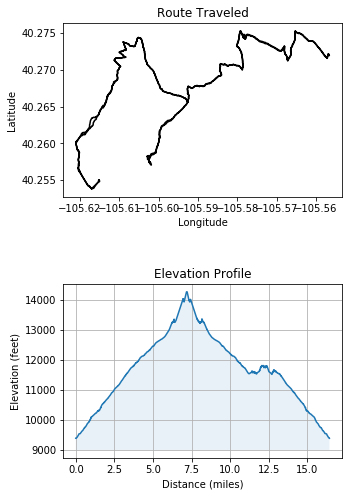

In [2]:
#READ GPX FILE
LongsPeak = '../input/ptm strava data/PTM Strava Data/hike/Colorado_Longs_Peak_and_Chasm_Lake_Hike.gpx'
CollegiatePeaks = '../input/ptm strava data/PTM Strava Data/hike/Colorado_Belford_Oxford_and_Missouri_Mountains_Hike.gpx'
data=open(LongsPeak)
xmldoc = minidom.parse(data)
track = xmldoc.getElementsByTagName('trkpt')
elevation=xmldoc.getElementsByTagName('ele')
datetime=xmldoc.getElementsByTagName('time')
n_track=len(track)
#PARSING GPX ELEMENT
lon_list=[]
lat_list=[]
h_list=[]
time_list=[]
for s in range(n_track):
    lon,lat=track[s].attributes['lon'].value,track[s].attributes['lat'].value
    elev=elevation[s].firstChild.nodeValue
    lon_list.append(float(lon))
    lat_list.append(float(lat))
    h_list.append(float(elev)*3.28084) # convert meters to feet
    # PARSING TIME ELEMENT
    dt=datetime[s].firstChild.nodeValue
    time_split=dt.split('T')
    hms_split=time_split[1].split(':')
    time_hour=int(hms_split[0])
    time_minute=int(hms_split[1])
    time_second=int(hms_split[2].split('Z')[0])
    total_second=time_hour*3600+time_minute*60+time_second
    time_list.append(total_second)
#GEODETIC TO CARTERSIAN FUNCTION
def geo2cart(lon,lat,h):
    a=6378137 #WGS 84 Major axis
    b=6356752.3142 #WGS 84 Minor axis
    e2=1-(b**2/a**2)
    N=float(a/math.sqrt(1-e2*(math.sin(math.radians(abs(lat)))**2)))
    X=(N+h)*math.cos(math.radians(lat))*math.cos(math.radians(lon))
    Y=(N+h)*math.cos(math.radians(lat))*math.sin(math.radians(lon))
    return X,Y
#DISTANCE FUNCTION
def distance(x1,y1,x2,y2):
    d=math.sqrt((x1-x2)**2+(y1-y2)**2)
    d=d/1609.34 # convert meters to miles
    return d
#POPULATE DISTANCE LIST
d_list=[0.0]
l=0
for k in range(n_track-1):
    if k<(n_track-1):
        l=k+1
    else:
        l=k
    XY0=geo2cart(lon_list[k],lat_list[k],h_list[k])
    XY1=geo2cart(lon_list[l],lat_list[l],h_list[l])   
    #DISTANCE
    d=distance(XY0[0],XY0[1],XY1[0],XY1[1])
    sum_d=d+d_list[-1]
    d_list.append(sum_d)
#PLOT TRACK
f,(track,elevation)=plt.subplots(2,1)
f.set_figheight(8)
f.set_figwidth(5)
plt.subplots_adjust(hspace=0.5)
track.plot(lon_list,lat_list,'k')
track.set_ylabel("Latitude")
track.set_xlabel("Longitude")
track.set_title("Route Traveled")
#PLOT ELEVATION PROFILE
base_reg=9000
elevation.plot(d_list,h_list)
elevation.fill_between(d_list,h_list,base_reg,alpha=0.1)
elevation.set_title("Elevation Profile")
elevation.set_xlabel("Distance (miles)")
elevation.set_ylabel("Elevation (feet)")
elevation.grid()

*Step 3: Visualize Data in 3D*

In [3]:
CollegiatePeaks = '../input/ptm strava data/PTM Strava Data/hike/Colorado_Belford_Oxford_and_Missouri_Mountains_Hike.gpx'
LongsPeak = '../input/ptm strava data/PTM Strava Data/hike/Colorado_Longs_Peak_and_Chasm_Lake_Hike.gpx'
gpx_file = open(LongsPeak, 'r')
gpx = gpxpy.parse(gpx_file)

def parse_gpx(gpx_input_file):
    
    lats = []
    lons = []
    elevations = []
    timestamps = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lats.append(point.latitude)
                lons.append(point.longitude)
                elevations.append(point.elevation)
                timestamps.append(point.time)
                   
    output = pd.DataFrame()
    output['latitude'] = lats
    output['longitude'] = lons
    output['elevation'] = elevations
    output['starttime'] = timestamps
    output['stoptime'] = output['starttime'].shift(-1).fillna(method='ffill')
    output['duration'] = (output['stoptime'] - output['starttime']) / np.timedelta64(1, 's') ## duration to seconds
    
    return output
df = parse_gpx(gpx)
#df.head()

def create_czml_path(df_input, relative_elevation = False):
    results = []
    
    timestep = 0
    
    for i in df_input.index:
        results.append(timestep)
        results.append(df_input.longitude.ix[i])
        results.append(df_input.latitude.ix[i])
        
        if relative_elevation == True:
            results.append(30) # for use with point = {"heightReference" : "RELATIVE_TO_GROUND"}
        else:
            results.append(df_input.elevation.ix[i])
        
        duration = df_input.duration.ix[(i)]
        timestep += duration
        
    return results
#create_czml_path(df)[:12]

def point_with_trailing_path(df_input, time_multiplier = 1000):  
    # Store output in array
    czml_output = []
    # Define global variables
    global_id = "document"
    global_name = "Visualizing GPX Data from Strava"
    global_version = "1.0"
    global_author = "Will Geary"
    global_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    global_stoptime = str(max(df_input['stoptime'])).replace(" ", "T").replace(".000", "Z")
    global_availability = global_starttime + "/" + global_stoptime    
    # Create packet with global variables
    global_element = {
        "id" : global_id,
        "name" : global_name,
        "version" : global_version,
        "author": global_author,
        "clock": {
            "interval": global_availability,
            "currentTime": global_starttime,
            "multiplier": time_multiplier
        }
    }
    # Append global packet to output
    czml_output.append(global_element)
    # Define path variables
    path_id = "path"
    path_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    path_stoptime = str(max(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    path_availability = path_starttime + "/" + path_stoptime
    # Create path object
    path_object = {
            "id": path_id,
            "availability": path_availability,
            "position": {
                "epoch": path_starttime,
                "cartographicDegrees": create_czml_path(df, relative_elevation=False)
            },
            "path" : {
                "material" : {
                    "polylineOutline" : {
                        "color" : {
                            "rgba" : [255,255,255, 200]
                        },
                        "outlineColor" : {
                            "rgba" : [0,173,253, 200]
                        },
                        "outlineWidth" : 5
                    }
                },
                "width" : 6,
                "leadTime" : 0,
                "trailTime" : 100000,
                "resolution" : 5
            }
        }
    # Append path element to output
    czml_output.append(path_object)        
    # Define point variable
    point_id = "Point"
    point_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    point_stoptime = str(max(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    point_availability = point_starttime + "/" + point_stoptime    
    point_object = {
            "id": point_id,
            "availability": point_availability,
            "position": {
                "epoch": point_starttime,
                "cartographicDegrees": create_czml_path(df, relative_elevation=True)
            },
            "point": {
                "color": {
                    "rgba": [255, 255, 255, 255]
                },
                "outlineColor": {
                    "rgba": [0,173,253, 255]
                },
                "outlineWidth":6,
                "pixelSize":8,
                "heightReference" : "RELATIVE_TO_GROUND"
            }   
        }
    czml_output.append(point_object)   
    return czml_output
czml_output = point_with_trailing_path(df)
with open('StravaData.czml', 'w') as outfile:
    json.dump(czml_output, outfile)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: 
.ix is deprecated. Please use
.loc for la

In [4]:
url = 'https://cesiumjs.org/Cesium/Apps/Sandcastle/index.html#c=nL1br7A9bh32Vwa+dlydSRroXYDcFmjQFkhups40HnR8wHhsICny3ytx8RG19syLAr16v2/vtaVHFEXxJPLffvvH3/zdf/+HP/zmf/7Nf/p//vNf/f6//Oe/+tvf/Oe/+i//9Hf/+g+/+8c//ee/+uv9f//423/4HX7+v/3+X/71t3/4/X///T/+19/8h//l//jNv//tn377m//rj//0D7/5X//0x9/+22+B/7ff/fFffv9P/4g/qX9T8NPf/uuf/v6f/ogf/u+//8MffvMffvfbP/43/O7v/vBPf/d/n1+db/jHP/3uj//22z8A2Upd/67Ivyv9Pxb922p/2+f/9Pys1b8t429HjWH+9Y9/3F/9H3//fe9f+Gsg/+Ff//Cn3//zH37/O/+gWkr5H//jr3/zUOCff/unv4/v/rff/v4Pv/0/f/+H3//pv/3/+KZ//qd/+f2fghp7/N/98z/93d//f3zc3/32j3/6p//6x9/+89///u/+/e/+6x9/97t/OX/xn8pf/+bf1TL/Zs4lWv/6N6P8TZNWz382XZvQ+9+/eUDTRoCq6TygaX9j+0cEmvOCxgfa/84XtIpd0DSfbv/PX//GCCT9gsTimzaoSyWY3U8vQ/LTu9B3SaK0vSgh1OiXDrU9c2ohmNqFte/T5MD6C9MuF9Yd1f6mH9Qi1NKccwRMD4zIoSq5guWw7qMZbdL9sDI/0BnLiP5W7zJLw5QDYynBWr07YC1g/rE8ZWu5m5h0/o3/JU/aE9Y+mDMLT3qZTM0CdeastOs276ep4NOWz1lp123dOXX0gJ0JqjBML6x+sEPuVhj2bUGV4MiA0babrAsbgTrb0pgceg+KxJz+TaMxOewelfORjjpr6i85pLQ75ZqBOsvsnVCXtCt2Xf7m/F1fhJp3xhmMJr7KbgSz+/1zYQf8w8d4mUNqu6SdQQ09rDbGJNgdbJUZqDPnEEKtJEacO3XSDvq0mqiJLzOn2aQvS65dsZkuqMakD2vjDialB+wsadKXNe25m040cYk21stB0vvdAmkSsLPORRvVpSXMybFl3uHuRescNUfrH+wsQWi0/anJjyNgZ1Uk+2RYwqazmjQfTYlss/cfh2DPdr5NabSZR0psBuxMYMS4q6w8eX7xiEuiYYNg/fKH9kCd8UleycqxJog7zx5MEleyJMdSDdi5oQodgy2vrriqFjA5MNoDqQkb2HgfZlaaNC+WfZnVgJ1JK3GbPHdeUE0wGi1US7vyG1eG+HmfjYirPW+DXgNmB0bEVRk/blBR/7ZGO2p3q1pZmNQpMVkU2chJRQK2DoxWmkKyFch5cWVispTxe+e9QnERz/FyuJaaVyh2fsP6gQnB8tP2dRCw82mzECzp0YoF7HzaHASzu4LWAfNDOkkyaG3zwiDBN8wnNYKNu4Sm32hn0tUIdpm39SCI6xRbD3phmy0urK+AHeYlAaKtJ2xiNNcptjwj2LoE6fLBzrfJJJjlt0Fd0OF8JC/zas9JBySqTp+U5MzWne5oAxJV/eqeSpOOq0o2XPBbDJ1NUJpz5M4PsDh+P0ka6ZC7CSP2CieBpJHOPAkDN6T6NTRJHOlMZXLGQv0kLJJHOtelx4y9ChgtdN47oc1Fo9GWpkBtU32l5sy9SB5p7uiEnDE/CasSG62kx8IKzNXhRXrRvsOuarpwXZnfQ4vkjPqNFzBcMB+MDozMu4IFVX3DNnx1nvTqT02Kkw2K8CKdZx/du/MClcH8wCxSejZD30llfLBDkEGTPnQTMIj5gVmDVqoptcRqwOzAaKWPGh5q5+azPcFieWRXadhahgZMDoxWmtrp0fod5przmu9KreTdoTD1zD9qkaZiJcWWFQ3Y2aw1CJZiy8C85lfMWkKwtC9tgkPUv01o0lrvEgyCxgywTrCZo/kNvhflBBFaab06WfdFbxj4Td4Ts42ccWEuaPbafU9JHlmbemEYrPtRIHFkveRgZ9scduhB8shSD+zFFfYPZkSPflXxXhQwp/4im8/6tZl69WN6YIePSGzZyElrLBR8ZES2cZXsXhtgE5PSEua9YvZFJAHbk0upBBvtwtzUP7B1YPRtLtICpiNgcmDER1M+BunHNr2DVSKbmxCBat+cemDERvcs9zaxo04HIRmYp6o3/VD1oIiJ3DYArBcL2Ibv25xgSY3eAzUOiphIrm7U+xwBO8sk09C0JOx+2oGRQmY6LjVGJRhRI7XAPvoM2Dww+jbLhY5Z39Ho26wnbEnAzn4O+rY0vPvQjyB2YMQdaQR3v3sT9nDH2of8jja/wc62v+J0o0YONt+FvuJ0w5IeU79NOPz92oer1CtO+3o2dCqBcttXq8+UqxIsp1xjPKO9MndrD/dK62uNdzSiRrvqR1/6bJQQNZpemi1rD2lfFXBf/tcV1KWAaK5nidCn9ev9626FO+wcg1cyb9j1n219sgfs0FaIbGnfbmWwPaMpLWH0nFTGswSlJYyrV3Sx9bCk0hLuhda1ykNcJeLO6z3oejf+UPd12m1YXho61sOSRp82k7/1ZW8jVlspv1VWkOMILCOquTcjYCpJXC3EbOkl6XC0Hdg4MJpUUkqqfaPZgdFCU83aMOyoa85aaaE67mhWasDkwIg/kj0sjrsdZtNKc1ruu8W15xqxNprT8s6AJnNgZwWv0F31ER5WncOr25D6Ct0Ne0ZrPWBn0lforlprflvDaP577TRpnQ9sBexM+lrBG5aH1FwDPLCzV6+vbWv4Lanbv9H0wBbBUswYrsfqjh4dNGlv+W1YqPt5dNKcff3ZQt3PoyQm68hrw9zxZXVgNKLuGDXnbAE7CyVBuW3lB9YDdhZKgrI+h9RwpVV3CIWn8sJW/XPYWcKrdW7LqDwwLME1AX3daBvW7ecSXMwoCa269OecLtpUaU73JQZs9IAdbiNpVGUmU0LMVHeyqtGcYkkPXJDV7dZjnTww7blQwQoMoxEb6bPzkAwVx8+IjVJhGNCbYTtaITa6GuxmFAmUHBRxkelFeaBh6+7nw+xVElf6PkbB5zc/BfYqiRs124XhOmhu8dmrJG7YPXpbecJorvcbSaxWa8KwAxvmoxnBRsKWHz2YyEYiC96pgMHAac7fRiKrtcsdo0EA7t+PA1OCXUVgNGgfzdVhI5HVUiyMBtOlufZhJLLgdgpYrNQ1Aes06ZXNwz3ojtr/2qA5UxEYDdbB/vRDtlf/W23UhIkEzEejjR/zfhqo4W5/I/WvjdzQjgu+OdsaqX/bIrhc1CEk4X6wSVNenSJ05g06JFs05bREQWHbsLMBi6ZcLWFQhrs7FG0Rq60b0xrwnx2YT0qsJvdGHgMWSW8+Gil2+7eSMA3Y+TbS2JpcGTlcRjtsr9hIqrWUMGOsFbBDXBJrTZNxB1SU7u5JI7HWNE/LrM+nkVQ7bo5EgR44eiTVmt2rZcOwVx5pMJJqzSTnbCNg+0cnpv/geqk5K7ite9Bz4wbhnmlh6Xe/gzZOCZe7OqGHf+O9gc+Nu+HusWp7x6s0b73OtrGgWXSPcmycEO4a3mPddfh6G633kb1hdMCBtnEvmXu7Ud6x9MP59zWat93bY7j70HH94EgqbaP7rkP6h3O6dFpvv3bYkNXe7yO5tM3ueyyEv48kU++S80I97q7gbxzN6yY1cAqnSl+g36B50/oYCgWoC9Y7ad5rnG5YC5g57JXC276ticMy9AiB/WuaNhMCtn3dAuefRxpVnzf4N+BoggK6YTTtumb9UNxf3UA9Ej59Sa4WromNk4Mj6bONxFyG+6EN/taNo3kzfDYMwmwULFdoXtHE4aobBeQjAdT1aoYDh21UHA4l6qk8MN/crXD7co2oZynPrNfA+bRGzJL3QCjeo4MqRmcj3R0j9PjhWnCtJINGmizDYB8PyKpKMmiUlfPilh2QBZVk0Kglx8PuDpyNSjIIGk7gZAbOHMfjXVkwS/lwPi/JglHz3jYF+fz3tXaeN2WQ4exunK+XZMFWX/L7wH1DMW+neds1I4ZBrRiu6NY6iM49ZVqsdxbQ5Q1DbpzkeO72Pzj/PjLARsqMTRefd4L9KllgY1zr8OIavo9ssDGv03kWqDTTTbVjXhLu3kWzgP9mx/eR0BjpZZ0Fas0M/iOhsS8guzjfjomrqJIZNi73TYSXD8y5hfxVY1mOBu1+QuJWoVml53hwLU7BtCQzhkhSRTRwvlryMm2xnTgIgxncQv6jodfImhXcPCH7qtK8dm+iWeEhgDZ4rHjC3Wk9hH9QPiu5hoZdb85EaNtWxd6S3rI3PmeFD2kFT5E5trfgO2sTAnK5cVQb2WObYpdVGiTaguRrhaatNXHQ85drcrW9iQ0bd9XMjcMyurNUIwE+e9fE+aYh36k2EuAzr/G9DAncdNyP8XqSZQbOv89+jLeSzMCpk7mRaN64ZIL24c46OnnXZn94qgdMHTZ5uDzhkMy4RzdOCddyvKYvrvK0Nc8G/GvLPWcbx/PWR/K1wHXHMfnSCrL+fZ+vgwzWZ95h37TmMJ62/FQL7nA0bbPO2sgH67RpLXX1O9pyGO1Zm6lq2rtW0vhmm6kZ3r2Yjps8a0+N9MDgUN+wH2tIRR3+BSn4utl/sdb1wXytkxeRHpLVv2mdxKsx7sIcVPFtZELOdPpvtZRwFBzYS03jBduPdLWN4zVc0ThCmAnUsy487xxp9y3CMe2u23wMCL2PdiwF2mOVQlv+vk+ZeKnHxTJiufZjuSPt9ID54bEfbDd/uAbEsyI2bv1qVhrNfsFOTfoz2jbuec/SO/NNOhwmv9hayHfxbKM6fgiKdJJFvBU5gRv348Refgq5KO5F2DgWFOmhqTBvBKrKeHNAXoH3ed0E9wWlvR75eSVFXPICjXqTnHDJeQWecemgXqe98ABp4GoN3Dlmg1S9OTJ0HKqoQPUZZPbN8TjHg0MHvo/MvjkyAGQDHDqxH6TCzWHpcw1OXph30jpmzYASlBV4nzeO9iNVvQ4Hi+B6pETTJ1m/a/AoVKTB8mJm2CaMXBGsguXFfEJswVWwXgeFCU/OYQb2sGu4RQepZsfTn3FCLAOim3JS11xP1NGJogVMqrSMzPzsC/eKQlxQUurGaeLgJ0cC4MbR4ZAnEAtBoNC5Bh9xycDdgo8Nn18nH3G5AmPb4zVw5jg645qRiCnAucerUtLpOhl5FwelS93ltXE8XjJp+LwUzEz5pBuXMCgX6u7mDSOyJCvHtazw2Ey+5O3JS1g1cIf5Jh9xk0wlAJOqYFo+4pkq2gcuIQXzTT7idp3rX9qEgpknH/FnvA7VVnE4Jh9xu66T3qu+ODriq2QIveHyU8Vu0BFfJVMnGkSLKr6PjvgqmVTQ2jfe4WZKGT24zOexD+d0WTzvzBScBTpDx5x0yFfJU1ThClb4digddGVQLZKNrARKCZU5WubEM9xDlA26YRl2DYXa4DqhdNC1MuKHZz5m8HRQPuiGJU0QYDY4MCgfdMNSTkVYytRvF0oIXSvV6V4ggAya6CTrYfXMCLUT+egFVkNd5NhZ+W7Ijmg76Ws+7So8bWYjHpo4TBz2Y9bM5FsBOx9HKaHrcT2eXH3HdafdIpVgz5oJhAPjQaos8v6s9IY0z6TYOHi0F0mV1TM3UI6E2Th4bil99OA0cy8D5qslsbL6PY7nYDgOVx8lhq41amZ8FhBZA0fHIrNL2hIsA3tLqaEHd/fWk3c2JxSQZfC8Vwxs7VUCh/Fo10Ym1U6QpcIwWOQw3rhMHz5nrp+AgTPL5G277pXmTzgc5/OyWMnEYMdA21uL11AyN1sC5kMtZrx8mjdGe3HygwMyn7pY4Mxx8xec0kERuLkoofMw3h2ujw/nO8EyJV38zdVXxzkHkNpwvM+Zmj8D55xn5RcHww0dx/lyf0iLlQ8H2gqcL/eHtEicC+4eIZ4qP6RFpsPW9X2fOq7zAX+eI8qzDim83szprcUIx3TOxPUCgRHrkB+CJR8udotlVIf92N18OFJb4KbjmEFbvjDFcJ53WqUxj16lphrOLSL25+EV4VTpLarjzq5JJyrPkriO3YDmLSxX5vNosny45jiicurUVUUDh3lpuTOf44W4rVAvhJJ/1pR8ERlyBeqPkPvi3N8XV7BrGuPRvOtaENWjKhsHd4iwWpMXfZWQP/D9CKs1y/R9FdkLMjz2HxGZpeV7u+bTNti5nAT5POLyF6MOc+pRIGplQGhLCeBglwp5MFZGpPcRcuqBmzaOuCVD0tXfpDnOqUKB8OdR774Wa+B8ucrz6vPYEvPGGWcZZPV5Rhkwpwq5O1fq1EdLDZxPS17l98HrDCojcsQphyt15W3TLBqP7vrUgat7sRx3yKIkqqTci2Mb6N86muM64fJxpmclXLIoiSopeYhcl3fckS1aed7cNldzfDuW48avcO3ZNSXVRvI5Q+3lW8bhKs4plJKPd5s+VFYSLVLz9W5bmBaGlZIjE1sfuNhdiDQdPF6KglCVGiwwJVXkvMzMZfTA+W6QhSOpfNceTB/zkopxng9eXHApVDSlMy4tYbg3GjQ0Tt+T9LPVHmcDBpOSmiHpVa6uDG0cDBclNeN9fOveQsf555GaIakI1wFm6Qj3KekZksnOdegInDMV6RmS9+k2vFfgnA2U570XZfWUkgenjHtkga8DeUJVjdc7Bz2qdpyvl/SRdx0LhxIGeDU+vKlnbEVPA9cc1/n7UuZao/Ho8PbnkTOh7BeoGaizVk7Tk/Qrbmb9vm05jnkltQINmkCHtMa007wlmwROHEd7NpLlFSzfR4xHqxi5DI11QJAaaQ8y1qM9gCrQboxFwbipBCimsHE4ksai4NVGxgzcdBzNO/Pi8Bcvx97FOsgqkXynU13mO87XQVaJTM0XyrAkOixnY5GxauJgIkTiCafQ7cs/nwtDS4tEEVs8Xr5YLNBaEOSpnB0nklZTrR/O+YUSVCRdd602P+Mj+IplhjyqtS83Mjs4P04ym36r6itww3G0HW89lo5pg60osCGaD+Yqbo4xA0fL1XzNV2FMDoTqOUluKyfXiG2VcTzvvYlag1I6PGuslcK413TC9/lN1Aofcs231B0mx3AlvHH2m6Qa1DpE1XDluhWyJcSub6z11QN3fHiFj3lm+zWXDBvnDuZWyPcg9ryAhuMGGSWtUNhCLOuvDIj64Y7tVjp/Xz7mHRD1Q7EOUv7F8j2y1ID559HpVTLZh2KldHC1JCNPMPIs2Ak6uJpp0W3OHjjfWTq4mgkCbap/2vTLpRVyFeQbtbZgY88KgpDzcU878m3wIJz94vMWGPmbVvovcG5RbFwD5YTnTRtWIPdmx7x0cDcunxEb5h0Yj14PPcv1LHqHOZ/QFa7p420aVO5YhvFwec7CSJyuGTbOBNP0FRmsjemu9MaJYM/XxWWAGPOG/eAVpWe4Phxm5c143td+sLOISva/lnxpVHolHO9Fvmf0AhOJo1RUsXzuWqBfXBwf2utW6vWDmcP4zGa0p84WVDmyp1IcgnCQZROHsZJh/+IaDHE42DaOqZfhAIiyVbCKwVTJ2BssteWJ163+OLf5thf8uSoWMZnx8mlpNd+L1YFbvGeWOOh6yw21c229uPrMC+cOdPi9cmLQ2oz3Yk0MR4HBbYVLvmTGcALOo/vxKYPRC87FcnWlcY6V1ozhQNv7hiNNWVtGc0vshWE4Po4tqVcgRKXinNH1qL1mtALXqPj13RplCWm/Usp3FqHhDSJJ+7gzDWsVz5Q+xUle3Hgez0NFQjB33+S0tekYO/mijjMnSuPj+Lzsh4b0weg06tCnnoDDcCoaHUbN6kKfxENoeONox/LNVlPcZx+OckF1pjNToSiLgsSUC6ozqyJ4uSLHFcfxvDfK2ARSQATr4Kt2rudiabEbPh65zzTffBzzMHC+G5T+oytlrcBd+O0auc906c+LDyHzjaN5JRXqBc3n2w++l9OuaqvrSxe+cFOxXZWm5ftWa0ZJajBLcxgdjIw0twnzQdwE30xATJWPxlqYrqjU0zgNUC3NggVuQXGdjSPq5VWwV+vfBxO9NXLh72nbn+N8HaQnW0n9LYI92jAvpQBZfSqjgC74/o0zwo1n1x5Yp6xMq88yoK6qv4hpnFZoremvcEq4ZxnzXQanFVp/YlarEm4QbuW2waZH2aGNe9nARnmYmdZLssVGxku9eJ3juuNoO8YTGsSVq+6V3TjajplmUGiFCrWrk0POXmHQB+Fo3lVy3vHhzHE073vIEaFBZaSNIzZYj5YJFQOJGFumER9IKnKhjSquU05VfMpNNIWwUphpnRx8JpKhX1jhqLW0jSLig8fcVJgtiquoT+IDvR6ljRMaj/hALSvbBF9BSHay/s1y3xQOTYVw7iTUzNKK8OckjnP6kdZi6dZuBjUDqRgb9+yHlNRcGxRNZGI0Sn/csLwTLKQGND5Kf5RSU6oZvAQKKUnpjxvXf+rpamAXpXnTz9sM1r/BpqMKo1Ja+anPW8F4r/TbuDGpro7jnHxG8z5pEQ6qoN2rA0nJlOBecLEZLLpRaNKnZASctygK1Sj9ccMeTa5906rjaNrRhQrwHBPBaUIJkBv3aJCjBq45br64WXNeKLh3PNqzLPbVw0GFAlJtvJnSG5fZTAWsbB3jNZp3PSklEAXW8X2N5l0P+ezDOZk70W/ZpEQbxzmdO9FP8vl6rd94TudB9EsPVQ/HGFTlRoU9T6QkDQSIFtS4alSzc+PmoDpBjvN5J9EvS2ttBvvmNccRz2e12X33gF8m6DxpXlvrh1Vn7nBtlCkp9TFOK5z9Bkt8vMGIjRtPISMJnNP5DUZs3EM/+3DiuJd+NR+W70sYdIHIHSQzas0cyBb8DGuXUiW3dlieqkfAwXIaSvO2J7sMgVMTfN9rYZ0AkyVOAuf7ZrTennzQ9JvXv+81sU7gKLPfgp8hmgeJl21sziy41AN3ztsk8VLTeu5wyBksO0q93LDMLwsz2+AIpKqgJ4DzFHCqgfNpK007b6ykdxfh4bDZOFruTGeBp484bjiOlptPrfAy1XGHfJPECwIzgfOAbS2QupSjeWrZZrKki92D83U02l5JcTo+2NldKvp5Yi5PjSlMC/2aqn6ezISs99QkcE7mQeTTLHyGOHFFzlqjHM0oEf3lhn7zOlkGLcN6zuuR04ubxAb2FMFamBfSlIp6SislyeL+4HC0baOtEO7JwK01cL6ON9R5CqpmAi6mnRhOeLhMrfW6ao7zzyOh0WpyC3LCKgqgtak0Xn0SfwVc6gHgjVuEs6cWlgTuCLVJCkRrPfOXV8DEYbTafPLQVzAf1D4qoHmysrJsVvk+7+waVdA8WV6SOOwG/JqLDm/LfLS+gksRPVh0ePeVWKlcl+O644jMT6U8WIsHd3aX6mOe6p/5fb0RjujyCI0VbPDhiC7pW+ie3Om4Q7/ViS6r/4XxxHHEzSvzzvP7nM50KpEn+RUeA/0U874+krCZvppi3XEWOJpX0tsHH0mt0EsX3fktwyAdKZ0VKY6NSlseW+PCXIaf4XwZfCg160J6KkKP582NshyP2ys/rwfMuYBufBS0/GAzcL4KuvHbk08u48P559HhPdkQiXNZhSTMbSoXwj2w9g5HFzn8qE8RNR/Ol/GGCI92ltTD5iLC3ih78WhT+cbDbbsznm8GHd6exWn2vPWZV+jwPlWmRGpM2xy2CKbP05IWuMPLVPvx3N65XMPmwvUqdPH2njJIAzUcRYsYmZ6ukFQfjq7dnk8ZFAKoQsxLo0WkE7S7w8xx6jjai3kNwK7BoVBehQ54z5y/rrEMuJCpaOORxlmdbWI8KJFUtVHSfdM1OB5ylFIN5anu0DX2AnKUUg3jMc6HGy9u0p7J8wxJF+F4PHtw8/0+OuBd+zNvrNZZZdFwup5l2Dsc3brPraFQvSqcGZRCeN6B/QWcr4K8AP3Zi5gVdyllBp7nbM9mfDj/Orqbx/Mcw22j/Dw63+OtSFc/IjtPvamB8hRjQGUyxzlPvamBG5e87E+DH9zLU+OpSTf6A6NyhBuWQtlC6uGuonqEJ48mH9SFWPnGo2kfXvbgveO8sDP5AUbPu8Vi12BvUGagjEzv7xZkVnwfKeoj/QqjFKwDBoeSTjBmvsD2ZEfHeU160glGpgkP+CkiGNqoLqFkUGeUOQPmyyA3wMjOO2AcxzlZOnHLeqbFFY403EYphKfGz31XWaGiNcTjKYVwXxRXzIMRHedlpSdth2QZJLgVKgTtxhFZJF9N+8XlOJ930rzaspKaxzEr8nW9yc6Ly2pwSJCpSExtlGt4nq3n89pAfR01HpTlK+xWP9yKHhIvLguzNCiQDc4HyjQ8b/mfmmsSOI1C/C8uX836a/ZTwBnUI5kx0/kQVljDdUD1Avet/ZR6C6JA/6YEwlO/It9NF2wGwqxKomDmG+GOo9GgVhuJgtn6z9FgHVihWZ8KUni+kcMJ4bKaTu/ftBaVOx9cplWOPgbhiMhdcrxhhKN5n6J1HQpVQ+iMUg1P5l2uFxdCg+uBUg03Lll+BF2gVVO5v31lXi0dqUVRRKdRub8Dy+E8RnTSHUZUnHpxuYyBSxfl1RplGm5cVlnwx8yO0yhK9OKy0hRSyhNHy8hna1CWEdZtVKZP5pJnNHtHI9NgpioyXAlznEQRlxc3n2JyNebtUdfkxdlT8cACh7IrtGnZV2BMiHnkfXpBkBeXVQDwOqui/NtXquDDWcrvCUnQ4TakfMSNy7J+E36lDq3AWLJYFsyauP6w+/4EOHHP49URpn0Ppid34Mp8quFPOzcObjkjLWOVLBQYpikKifkLyweXEgjh5zOcxNvEF5ayIDwA3bMBOlXZk1OnM8eTwI14cfbishaIv+x2nOYjoot7q3J8y6jxHOXBZUr0vlk1cDMy/V9cag/LA4WnElXLlPYPl11PUGXPcRZpyi8u2SBxGmm7Ly7ZYLl39uC+PNYH9wiDBaX0+z6y7Fd6MlDW6bwU9nZ7lG24cVn/E9kPB9cyM+3DrbwTFo7v8HwAz4Z6cU81Q6y3G9ZLx3KtPL45HrKriF/Sk7G/T995hebNiv0jPBmjgE9J918ZQB0eH7/bQab9yvTaIdALPrKQbb8ybXaELT5qjEfsklwawhTl7jy288KeVXiOzsF9Pv0X90wLovgw7hxOmJTUvZBrX5HE/Hk3L24NKrXo433upQeXuWZDoIKPjvFIpX98/gPR8YNrYR2/uNSC8BLu4ujwZqO4u4wPRsM9MkNj00bgaBmPzFAYTsOTATpVuxN5qs5pn+94b3KBSHoyhkIGfWSmsyvpyxghCmI4unfPvfLnn+e7Sxq4PHV0tX275p9JGvjzAmEobgTURuxUTE7k0R++3WjgAnKVS/oyBp6LJ+5l0i3T8gxdLnWy0I0qWexjCCyEj3x0JuURLYJQw8f1dCazCR0yts/XObXpntyoRzAHzDfD+OOyfOeKSRsmJQ1csr3pd6+FIKDExLPYvO4v8c54rfBi7af6MNC6tJEOfs5Qqi0zcOo4mvep3xlqFd499MZHV3IdQx8ebXxy9VFx4/MmPo+C8qJZUTnCSMNLD/ZG7jvJiucogtwjB3fj5i/G63H9ub/ttJkhXPJeD0G6sFy6nuUpcNyhHaLg5skIJtxjJ9qHczIPXsdTThtOj+Ev6zaOxrPylPrugXO6kONdspThaKW945F2LXajhKPaJ1N8PHLMPU3/RoUtMXFNUnLiaW+Y4+EUzRbjLcKlpK82U0Z1SmIUfcxnfyxVkW3fG93i77R4wH+HI+Vay2Pew/+J+pidihkeLn0sVIf545dOSYwblpKlQ+IiUf3UPmZcMh9mFQxHMuN5mQErdmqgeA0pCQZiKtMCx2vIu354PmldnmN0ou4vLvvgfAbWgmpDKYfyPKT4JMF0a7dTKuH5vjTEYLUvD4x3qlBI3zclbhUfrvHn1cd+cU6JXsy9yS+Gw/vuivqYJ9pP47UfevrC5dLJ8a71sSMgqNBBuXcynp9+jWMFld1lvXG0jJYCCFnA59Izx9HBaI8KBLsJ9Sc7FSk8z8IeBdK5ZRmoTIJgy728dOE2hIt842i97VWpRuCW4/RXuDFf3PqBS50K60DVw9755LZ0QwoC1N94Qtv7lO6T+eHOvnStv5hXIDEkuJnMYu0pWaR8ygXGo3X0+lRP18D595FZrP2p2g7BLNDAOblOn3qbi+bl5DrNIOGYd9/EcbyO53jAaRT0G4X45SnfN2HnCI7bIB+ZJmzou1xOmtP+1G+cH+78y8lwms78cGkFVagYIM36sAr1rT5jtR9iFHUZO1X4O4M97sD2koTuPu0pSMPN961h8VakQOsITApUvkH6rY7HL4coNsJMnRPNNMug7A8fgfN5Sb/V7P48wlqTifUKz5uaHNRvgao0+ARl278x42QskIVP0EzrZSJugQqEnfPM9FH7JyQf3iucvBrCPaVIg3yQaINsWJ2PYwlhLoGnhXpFb43q8QRhe6Hu98knY6URi5T2gxuO4/Ha48n4cGfeySdjJVuJ14TYVqivlxO+dKV5JfAyq2cBdE74UknPCFLLz0sp4Ih+rycDAR2FBj5JJdWnHwhUG2S+bxh93lPfH/JbYTRxHpfKY5vKh/NZ+bCJZv1gyDPFPTn5Hsps0mE4HAoFnPOzVN/K+A6DPj9Zz8x2ZKiz7TjfDNYfn+VajOcB6j75DFnJAusQj8g/75x3pZnPPstnHDqv8NmwREGbV6honHWlJlRr2mFOYz4ZmduG0tWO88Xy3ZJvZVBx/I63yL1jpWYpbJiaOEDUt3jDbmRthg2BpPJOjYs3ThOHyJ/hzlikGFrGsSfeTZ6C6Wc5iw6G1Syt3SBYDDYEtRveuKcyOcIvINtJ6SJcln9HJunFkepl9aYLTCSmViQ8d6rbJtbqMy/WOwNH42VS/l4H1gtbkrOVrM2nEnvAfLmkUT1tbGeD/m0eNevUY1eep0EzTDXIz07F1jbOnvr0IJ8BR0aO9Ydb2ocTx9H39ZHzFg3PhLOB8Xi5HXgBep5WNsfR9vZl1H3AcQcvzM1Zg256F+B+CuJPxxE75zsE9KBwnDnOGPdIIDeZiz9d6tSEVp6nUMMb4znO56VMJBvZm8O9vo7zeSlfwMbjrVwWHpvhOPq+fCcRXsOG6oydypkdXM5bLHDNcfKL8fDOsiE1tVPH140bjwZeAyeOW78ar324s27OHXq/D7mGDamundq5bly6NVfQBaJeJq8ji3avkY6sTq1aNyybTq1gF8EyKNBgT8DENZONg6jnHCObXahNVI/HvRvH46X6MEfAfFrl4eTR0+FAQ3xDlIdLLQPX/cH5eLYYl14AcHPgOIvHZrryPWHGcdVxPN6j+JdGOPvFcpGD2RCz3+Za/xXOXSiJE543Uwvo8xqTb2WWh4yHfJyc85IFBbkuWcjlb+vxo7UWbk+flwwYW08VdXeiNPT57MqHbaWlUz/YmV75rK08a0iSiZfgG0dckN7FWj+Yz0rOAstKf1sYfTinCh+1fIMQuUh3PD5qK8vtF4g+lAftnJtj62n76MphQ4roSeB7cZnF7H5Gh/lm8FGTp8coJFAdWAYpc5apSCjJ7jinMllE9nbVLCuc1b4MPpNZg6eHBEfi38mNJFy+vPEqgqeKBHaNb0rNpxlI/jzj+fcZj/fkps4YznmPHH1PsQwJlodeQMW9NizTDRFLbMjT68YnXC2TrINH4Yc0PuH25JSrBc7n5RNu+aRhzQ+3HEdUsSf3vLfAHbw1Hu/pjh1kgcDlbBrLij5b47DA+Xr5njR9nmZ8OJ/3tYi0lHx4M3GvNdiT9p7Jg8sXNbg4Ls4Yly9gXM09uLMee8N1G9eeFzW+vwhydns9cxv3vLzBvrWKdSwe76miDm5G+9ROhbb29ZBJ9KjQ2FBSsZvQeLVxtfUe9SM6JawcXD6Eiu9D9JQSVvRtue6p4x7Kcf5TZZxRtXXH+Tpez9zB5Tu8ZoFzurw35fm+fOeGKwbjDeofuen3vGOE/npx/Rf7gYphDbUhB2W2nP3N94kQus3fHY7C5pP9+bxuuY/CV2AmEPUKvkfFzFF+nKN80VVXjfH8aLVfyYMa/Bff136Ioef9Kei3MB6ftyfHu5YP5+PxVfmU2SmK/fXfj8J3paznXW7AnMyDL4V8nFFiuR+O77bslQDpghKXo7D2up469P2b1mf4caU+j58xq2IRfKM+rwnjpkTK4Sisvc4s9e7Xg+N82h/aa3semEvGOQdV5dq452H7qIHz8chNb9nl5PQc9zhnAVOxlpv9vRseBDS0uB2Fjc/xvPeHUt8rxmPj86m5rrjyuytMo6j8ZSOwIffh4shNb1m3p6m7oQ7OScpqcxqzTaDPoc/tqD+Mz/FUIfvixOo4Nj6zrgfqUjRkE45afmGUN6QtNTSJHbX+MPKzDMcI2HIYkSX7KTa8+7q49sOlkUVRQGWPd47KWvNbxaQFbDqMHTNZTGQG8dyjMWov7MDJynbBBIKv6z8cR1nZbqzAOZHpEYwVzcL7OGwoXTkqS4ws7YI81obUxFHZkH1KveGp6MGdH1UWBfnAHCneCSMPqD0lAQeoZyAyR+Lsqb0Ppb4bqEcJr2q52g5RgEzCwWk3+lQ2REpDQ8HMk1bPPsusqAjqjYbd5YidZeE975TWG5K+RuVYe1aqbsEtI1ieY+1PhUavfrNxuF8qB9st2zn4U3jH+XiUIq/2VNbEPTmCmdn5mg8CGvxfDSkco7L3NV80t4rDccejefUtONqe8ThDR7NgeStgP/RWHZyhs22QLIgK/XC4+j8axy80S/KU/uHOFFQ97PXUtwLLHeljg1N0NF+EV++Z6rjuOOVAgmWB2h6486P2I85xE6aq4YIehvWSnqFyM4ErSsU01LkcrXNkIoseK2zjWTAeR/Ala24jfa3NivF+RDqyyDPK5Tf0dB2NI/OSRZQFetpsGI/cw5qKRkUKaOL4+25EpKKNycENx3H8p2TxZvDzbNhfDolkrmhdkEPoJbtxHJ/KAsQr6OJ6/WgcflxvgXusY4Cf+ZxnV/s6cY4C9yNBIztQo95gQ6XL8SM/Iysu1R5khp72I0FjZSny9sHOB//Iz1g9K7QbuAV3AhVcOriRldxr4JbjjHF3tQ1W6gTXU3NIxkGhQ7bMxq1ffB+6Kxzc2Y3OQehcbjiEkMyzYRz0vHpLrfBuojnt+JGe8fSIQJGahqSf8SM9I1+T4ZHYpg2oJ7yKPBuo8dNQxHL8yM5Y90wWw27AYbRxPzZ3XRxkH5rYjh/ZGVfRKAZHygfjwFh2ziioGnVw54tH4dD3x/EFDzcTNv9yRLuEUhqr4EpFmj7VEspmfB5XKnpxcqlyfjTIsnsqIpZQNtGyd+MW4y5Z8K794M7SBh+1eZmlhARangO6cfx913IvS+Y7L+lfmi0OC95KXBwlO2o2ZNnWDc3LEnfem7JMGBPI1RpjMl2uf654H0PHTccNzmy4dJ6xHx104RynmdyHB1FbK/azy5WFngyIgmTWg/P1ssSdyfUj9mOCX/iwzWuclPCtr4n1/sjkyHk79OYFjYkrBmnGElBQK3IwN0z+Mtf3+sF8NM5wynyKgqZl515xqvw4bPc+QLmxjYPEnYXHu/pDCRf8gsTlwj2aD8VKg16KEq+DC/dopoMXpLI2NBUeXLhHs55WCb+MlBjPfoWDXiUQpbP9uHcvDGopEs427EdayCUfyoc1ZC+N+eP+u+p/QV39hqykMX+oNyVxNTJi/esGayO3KlgJrU964DiPI7nAHVKOc+oN/ct5IaV44tfBnZX9yPeQZ7nw3qC965h8/2X544LnxYnjRI7rJStogXXnXZxnkmeo3u8Tx/G8VwRVoJwaY7IOlI/2CoozNzSVHfOHrZOSpQX1Bqj3I30kb44Wq4B5/2eJITleDdhZBJd1sXxdXLzhs+Om48iALtf7UMJk+8ajTbPMZy4dAREULN44NvB/CAyBef8jr6FeTa6gdPQpKeuzLvnL+Rkhpj6YcBpHblmPcwuNb3H0p11/dEGqf0Ph243jfIqV48G8F8gVajYnlpmiZcB+QV7axslfdvGUiKAK5M8ydhnlSRvjG8/X8cMFZXkbILCsnvE6qInc6yIrAycNeW5Dyi/i6OUbTR3FUfRnVlin6Iw7pLIjMjl+4GQgy23jOF5893bC2FCoNsJO64yzFjxHOTiflj1QqSlNRNFRHncIe6DWSs3Bc/8a+vGeR3kcoEzNwTK/f3ClDsv2vlvmYRVQCMQ4UFhztaAJ7m8uwJEBuxKBKdR2Hcobm+lhd1Y4FLRwYKDPn+PhPHJhDXuEykRIHu1zh9b2lwNTJQw/KN0bRwGTMp55V+AwHge6NKkXjOxpaVtb4UBNy/XigIO6g3pzbVyqwbEOFEUdFLvXLTnHj3XgIA5q4qXQPl4mQLnTQQU4NkyTLJ5K2NDwduigZWTJ5bLgwkXd0Y0TwqUWt+AvMhwNCspryQsc760PzLllEpVHUg+6KKqEDgq1b9j6qXsbWJkKYWiZ16l5vw66LRXCON0/nlWMeK2C8Wgz5k22LniXfXC+DCXqrYd6uA1QNXNQIYyNS2m24CZAct2gShgbpz9Ml284o6BjNgRHvdUHR8vI53CfyWSeRD2Mg3+ij2kF8kFZphIX+4CmySSQj4YzaZW2I98VFwky4/KzStuRwboScQb0Pd444pasc1LwJvLgzk4an0m7TrmCd8rxyGjj3u2oGfQukVyA6pqDalecphPK4/WCS806j6fP97XA+XopKF8zSF1Q1L8Xf2AwqHbFxg3jfetIEhxUu2LjnnnjqZR/3asnbXH5nDV/93xwPuukVaTOuhTDDUy6aBEtbyF4+Doy9QaVpNDaH1Hggu/gnCgUua/Z9jaYviNjblCpCa2jzj/H+XhK3zdy01BEvpdgUorc1/Gc8TnjBZmvgyL3NVPrygom8BcBgyP3dT5nfGA8+NA4cl+n/QXcnmJy5L5mVcXibrfeUbVwlkLryHQpiKPeUT9wUu+rfdmn7QIZ2VHIb5Y3WKdwA3/fFzB1mBAs77XlHtKOLK1JJSm05hvaEJEdTZdnaTSePuxSMZ5z6aSAvD569Wor3vNVh9Fw9nh3YtoB6tH9Vx+VDx0WOrKvJgXaN+7ZtYl5J+alw9ays8O3u3ViuZT/0l5RH7vronlSXytt9bnZYh2CeReNl9FJhF86uvfOQukvLRvaFBQw6UhvmlQZYqs69xF/QR2WjrJhk/pQKbqyfdqNH47mEnJSZYiNk8VOr456YJNKQ2jLB2wFdWc6+u1OKg2xccn0E9yHfruzFtqO/qjMHt44OHMcjZcXJWKxHeW7JpV82LDctW84MCmVfNgaYDI9CugenE9LF1vLqmsFXdA6smRmpYutZTX3TeZBOJr3oYqbOR32yKTSENqyZsF31j4c3X9tPaJ59HcZnaaV9Fh7wQHHqeNoudJT5Kq95KP7r+Xz/LLAfd+8dP81ffWgjyzOBXwo9XUdfzjf3klckLIlLlT00Z1UQkK3Jp3qQ8XnTZCPtNdTQyqv+xk4/zyhw5Yx9IK6sx05S5O6Vp1HoPl9/ZvXyULa62ntk+oIuHRhXtJee33UudheyCCKUSsSrj6c5mPmWemQ92qPGmSB83npkPd0zSbMyUzaa8/2D6GldfTlPe97XlyWfP+0L2QZTWpwdd6UVtYiO7KMJjW40vP29ud2GMartB35VOJjl+6ujEnVITSLtn7KXIfoo85VG5aGtlcR86fgzXFElvmQD9zX3ecxWyeyUFwlYMthtLnr0YUhSZFjNCnwvHGvLozPg8RtdHb7eg7RrIHzz6Ozm9VkCmoAHZhPS0e3y3qG86PbO6hCBmXPvIIiuAB7x2bQmeyaF5asgPm0ZFB21TxCE+/yIVma0HD2bEZQGZKFGk1pz3SVgmeRiSPqWVpEGswywHuklI5HzdD6FASYVKRh41JLw8P2jj6/s5FFObJlTEGVnY7Uq9noTI6aFyWSwaMD0aQOUoqyGz9x03Hvto0s5V7wwLNDjZv0kF9HT30kboTuFtukzjwbl+OhYEJH4bCNEx5PfqhfKEQ2KaK8cc/NhpsDaUuTQsp7Hbleb0m8cR4vmZ34AOVSvgtfAjccNwk36w9FAyWytrJTGfcE/zAeTlvn/W0Z5hpfvQcnC6lV43EKQxnG2Z4UeT5USScuuArpCZNCz5r17YvL1K96xBzMBI8PqmPPwAP02H/DUntA74yOajIbx3ubHkYkUZwuVOd+Ga3+Yjy83DzJE8txi3EZj8D3IYVnUoBaxyPovdHCuXB8bylArSNbjxS0jOlIpZlUQWDjcs8qzsbEplEFAR3ZuDGCUqdL1uE9CjyfeTWDXBo4X+/k9WrG6nCG0Ax2jkVnYzwxPdwcc+H7Fq/jCcLhwkKb10ktaJ55T+Ms4ATjaeV558XBQp3BB6S2jPGd3Y3DGUKSzBx8hsaX1LJxuHiR/LJx9H23DcOCs9txPq/ReofeeeFHQcPVSa1gNkxyOFyoyFbZOGLn+5Lx9EWzwB32o4jyxrVLPpSj6ygpM+ePY2R3PBQs69jWjWM2WImDHwX5IHM2ZqsvgnX6wFngquNYBH3q3MHJ+32Nr4RxtyO05m88cgSM69baF4J98y7H0dXR6v0+vMg8V4avY9B4t9D4xkFrXjBiJnkCxtWGT7+9D+f7O4mt7guS6N/XI/lp4/jq/a62tZWEETjfX74Ci136xdUBf9ucfAWWz2jbOKivC1f+XDzevPuL6gAHd9h58hVY7nAj2AXGxBRhjeSSbwQbLJBPebie4wU7w0iYPzScccncP5gPx4fy9sQ7XSFHVPY5wy2+sq6LduNiPFwKi09brffzEC4+rfp8PD5FNZeLUmkHd7hg8SVT8xQh6N1RCWjjFitMlwvQ6b6jDMxcfMncyrKn+6Z/HxIzNo4VknHXgdLgB3eE7ho8XtIFZRM6at7M9eOSaStxNXBOv8GKmtz9aFk/aVLofsuq+hPkS+B7aMyLqtD5BPck9VnZOLtLRU31g/Ml8MGYPWHftOYw4oCZ5yeuZ+R4TIrwbzsivw6Mh1SVDaNVrBRnFbcpUlXmYs3wVrh/cb4K1gylWuK+z/NlkDE+borMQhuGjtbQk+ob6JC8DZAvfnC+DNYMb4H7jYPKJ94Pbwqfs9tf7zSlBZU9OnBa6hHu2TQYzwIpRf1TdFi/u4Z+gh3dqyfVLdBhl8rlQ/nXkR9tXE/LhuFOQ8rIpAYqOkuutsAzgupDk6obbFwSOVRXJJdMqm6g+6bOeVuUC3OikNN63hyUDYP1J4Jp6dDO+iUMnI7DwDkxJjVG0eN3ubjgUU8umVTc4PTCzvHg4BF4UKhowcZ91svBYR3woAidtHmtpo3rEjgnMx21ed8tnfFq4Pz7yPE1U6io4c5AEsqkXiYbd69IVTCLFsxLYdZ5xc8281vAfLlk7M78urBNFaKWMho27F6kGrYzklAmFRnYuCviVWEfKDwt1AIk8yqX4jFXR2/oyYkK83YIX0hfc9xhFm1ElFsI/zTZXoFTx9Fq1/06FHjqKPB0PEkEm4mDjYgeyJMTC+bNINy49uF8tXRhnN6EF1e+0ndnzzixYEruRoQnFZ4R6sSh8zqMNi7WgUCNMo/Kvfg0PAAKp6syj2q760Vp+IPzddB1MDXptyDQkP8yOQVh3pbjp3e7Bm44jrb3thzfOM+n6ehZPJV5/ubnnJ7xWAcCRPomfO1vapcuEYFRwbxkDa0UaTr7h/N5SfFatxDnxsEaV8W8dIhWKkrIkHbc2V8jj9GqCQvQctAiUPLy0G9Sc9xLvNX6PeEwNdAAeRrlDq1bbnLhOnfcdBxN+4wG1VYhfjj9YPWUK3j7fvoe+1LppK2WYmrAOfaN13/gcrXrm3f/aNFj4cO+I78vph0Oo+FSk1dUKT44H27Szo6EIRZmbpceziDYVVgUmYYdnZIX1crXdSv5LQ0vEDogbxwR+Vby27j11az08YTHy4OGlqena3R3HDH8jbNvnL/UOzg7OHInrFtRbynMJaQYrULehHXD7FtRg1hGQ+BV6G5Zj9zznM2Nc4VlFfLIrdvkcKH1WkdG0CrkTFj3fdaGwdGLPrqrkjdhSbJyg+pg/hJ8caBz6bU2NfR4pOYsjnTe9PQDwyqclxYHOpemhtHqh/PPo8tq5V6E1YJuu4vjnMskp8VVaq6wrEr6mZS6ctoVuMMr9GZXpSRPVbiU0G53UW17RQJk4CAIzDAe+Qik5DqqBzdOHVRfLh01qf3BrcD5vHSpnYa2Oe9XV9XXS5eatOvbURgHA9XKVqWzJi3PRo7nu0tnTXpZ+X2o04ozzpFJeRQ0z0lynHMVXWqnV+LFueQ7OJ+XjByUEfpw+D7IAipuv3GpUnme2YE5WYyHswemgXOy0FmTmQIczcEPzreX7iq5T6UOWYDz7VqNDpus+pBlBm44Tgg39Of3QQRROXp9VBZPwvKquT4cHTaRPLsooHRwGM4IN3N3K7h0YjzSDEUe8tUZOHEcLeM2F8p5/U3xuWYJ95CvtMD5eKRCZln4bQIrxhN8H4UcT1G9i1vgPgihNni8ebmqxHYo5uXTZnna8FDhxCGm41420Ee6lPZVJ/bx6LSddNIf41X37Sx6w3qeRl+64PXLQMPYRXXhVeu9EvanOrsg9WpxMFFvycklHlfcOA/6rE6BkJP98uE0vs+t2EVFy7OI6YZhe5FitDqpLZqOXtQld5xPS4HnrKKc0/oTidVJ6OqNHxycBe4st5O1e4unrlMX2mHgAqpFvmGS03rFnoHOiYtqjKuOq/gLQrGnWHR3HFHvFiXZuNgN19IWhxzzfdvpzuNkaZDNncIg9+HahkHkwlG4utBwq+Vw7jBMHC13JcxiUqcds0re44JC6QN5V4sKjGs+Az/Ei0mbw2gNKakEtulA1abF4UZNLUPQz3Y0CPBO2s0mysrxUJAbAneQ3q+3AdGLO6zHIcLURj4ORX7RGuQs0lt0aEG2Oe583qCQhd5iWxs31jseuYFu+4ozHIg88HXkBbL0uKPDh5cf744Twj3L6AE7e8txP6s9YZjVDc7FYT+rkudn9MCZ414pahkn+YZz39MalPxk9/1BLlaxWFIx7JbKz2kNW0t2cxZsXaK4cxuEMj0PPW/WUph1FGUvwJFOYP3heHfJDdT02Tj6vts28WxGiyLvBzfJoZkPkQ4rO+t1sN4kkzOfIl2WR6e+RQW3txF9/QniNS76QKbFooeaG5e7667cjYOBwOEyu891Nw46RodU5jCYzecIdXwf9o3DYHZLAWwcmLQb5qUwmK1HALnVOdACbXEYzFYyM/xKA5f8oqeVavJndBlQrTm8hVjkJwpq4MRxRBfNQ4ln6mN4WvSiWtobN/rP8Rq+j8xEU0nR51GGgUyLjSO62HNtxLwQaZP8LHaTA4+sqoFrjqNjaY8w8Bc1YwT/vbqrZWG2K9OGhy8XBcKy/M9CKf6vHcGictobZnksPcww0CJp42jamuyC0lgDXca2udwI90ihhXkn5n1dLVuS1jy+uNjQcmmb6YVwyfYa7ALddTVaR0u2j12D6ro6wUgKSeDOqVyDltHHQz7smmAZ7+nYuEcKjYCdQ7RejXTrwY8QgvAbUJXWok0bD7NAmA6Y2RST2jgdP5lFsQyhz3t0Gzg9BqrhLKqSbWU+wg+q3IAwoCiSpc9Qwl4bkAXCvLceDdJhuKkW1bS2fC11h5vQqCg2tHGqP47ahNZCsSEr0ox1pQm1moJDG7ZSQipwnuG46Lnmxpn9UAzRNWpJp/EyZPZJ8ImTS1GfjXs0Q2gZyN9ZwryXITNBosVA/s6SSVS29twIvrlzgiyTjpo9N0f9cL6ORfNa8jJemw3k7yyqLW21pAKBFhYDjaMOmQg3crz54Q7TUzRn4268RPDC5BS+8HmVxqspMlbDfkDTkFfinoL+l+nxmHCgeM2xtgh383cETW9Oh5XDB/p6rK221NSnfThznBIubyy8kRgoN7PohaqlyjzBVUh7Oe5GQl3XksCzhGoki95/bpjkpPBULai42unjMplK0P/qtInxaQeNd3P5DrfVwInjeLy0ENASYyz4HnQS8dIrLAPyG+rjiWIQbiSsB8xpt4j3bvGQM61kF5uNe0VGXQ+VwQMLgpmiPiein1SGtoT0k0VRH0ONq8DhOl0QzBT12Tr4dSnIjG2DYFal8SQFvdfP6QPlQxY9KN245FF4ANBPa9F7Uqua9wu62Rzcxsvg3dW0nZdXOR3ifkgZdK1Vu9kxpwVzNgE65d8Jd/2pSB0b6MskZHJsmOXJrWgC5Dwv4w01WCv9kQQSuHlwr264cc8yPFl8IMVDyDbZGlpNSQAqozyHUObixs1Hon04H+913GxcXkSITQ4U3hDKcDy1Hh5J+uEwnhLu0XEL6OJKkFAm5MbZo6v3wInjXq5vPT08eDgyZIHOJElbf25AqBmyMB5J0vYIDTwIGchnEMqY3LiR61gjcL5vRnQej24Nsjg5hDImT+eRHA4yTfwQCWVMHlxebNBaEFo9kotwqY582+an6IgGwl0/pKsIDju7RomQG/YwPSxjlLbYOB5On0Mk0dLq7Mbs5Rc4VCw4OB+PdNe2SuJmD5x/Xycqr3QH4s3cQMKAkAW4cakXoPnaQCaAkAW4cennQ6ffg/PxSNS3zGyCX78f7myOW4y7MFzjOjAcifp2KyxtHK5nxSGai8mShxIN2E5HMCef0HIlDUXEEyONWKgazsFd8nVopbrwfUrzSnKfvwroA02ctgRmsqRhBzv7wn5Q+aJi01ypEjbr2sqjhny/b7hVSBSsVA4RETu46Thl3KVKRLpgGQjbdfddwYa1D7Ycxnubkg8CDQF5YavuZVHUhTjOHV9t41XcpAJBFdGBUPZRAH+xWiRUHUHm4/X+l3ErPO+IZR/Fk49avziorqiqIZQtuY/ul5J/DKUeOP8+PhrzJjZFYthAVQ2hEkYbd4/aQn+z6EZ3OtYz7s4bDkvEvIW6Mx3RkuPBV24TdBGm81WtVzi1bGHfhOly1ZbPzEYBiS1Xebyr+n96Cwo+yOKLKNW0Fc4lhJX3tcki8ka9Fx6vDQtuNr457gV4x8PFRlWM9kV0L9QHd+hMVYxOr6xcB5yMqA8i1MVp467WfBg6xluOs798Ua4wnYIu1MXp4C6frvg+d5ZuHNHvdmfaOFcMJgpXCJu87T5hXAtVYsL5KZQPuRWDpAtqX090txLKhzwKxN03XEWnit7ZNzaNW0+Ye1EOrDtssX5z2dmrMDjOpx20HXc0VL4+aoMTmQ9lv8rwQgHEiTDrsab54y6R/WnIxk0Qj++rnszsClGfCIsK9XDauGvfLzQXCnVFhC+svu68fYzA+WqFV6s5XmvRItLXwdpmPvRADZvjsPbP47Pbr6dvoZbsRLTztA0n3H2vEixVg6WUh7shnYXGFBNlK46LhnGX9VBK9ihnPp79GO+ynj8+dNyhirJy2FMUIEF5ohuQsDX+6K6rxvdBlFIW5sbV+314P3twh6uUr6xxldJVsGsY54R4GHe/zzsaOs6/j7W+FAXTXb+OM8fx992kr4meCUdpxXi8Xs3xwM0oSCGUr3lEn1xcAf0WxmOtL3MpJhyvE+2ATgHUv3wVTZXoO9ocxsqwXdT42pM6ldkCzItoekXyjYM6omwBpmIwcRFNtPkRtu8zT2biHjow/zphrepu7gweiFnlxyJyuFiDOMr4sr9rWB7ZnWh9JMoHLSM1E4VpL+nshxKUuLneeY2VIEmcfIs9O2usQqaCO/HGNkqMnnwNwt3LdEJzPbjmOKKxJKfI/HBnvcZm2G0Zu1AQLmGsV9/k+ImA3Z2WvL1NZuIGTdt4Wk1cHCB//nlaYb642wt2nahm4NRxtNx0957/CdwRfMYHXJ8DPoVwxMq3VOvGybcOcRwJltvZ6kSE/PsadGbjS9JGjoejgTwFMb4mLeWemzkH5tOSo69nIGl5lp3jjlwxCnH0fMe15aNvL1ILTtYO4a6VuDyvxnFOZrpNe605L27x1jAe3aY9PYer4H5pDesgH0+/L9XPffA1PvZ1kI+nt1SV0DDhxGudzG9ehvVMulnIDZvILRAqU2U9LY4K7kNqgVCVKuv5lGJVxTIGpqVITc/c41VxbTRYz0aacO9pmcS1i1ojp+Dii3s0wxpkds3/dIAi3A2fLmQSHpw6jsdLi6NCg0RtkFNI8cXNvCartMCZ44jMqYBX6HxN8Xl0O/eUuQvpsxM1RE4dxRe3UitofQRuOo7IfCvWbxxueyjAp5Ai4R5lac7ADcfRMjKlb7ml7zgnHx3efts5LIQ4jqvIl0tnt986xkflW4HzZZCK2/NRw+q47JHJp5QKnn2KDmwGzL+OXDI9I1PohTd7w9fxkbxl/DYMRO7ugDoFDQmXqlwowt2PmlIxK0OXxsBBc0XNj1PQkHA3X27jNHDOUxRwGkVyPMV4A8xCZ23UFH0dkrQPjEdn7XToubjYjYndIBV3PCKo+0vm2f1VmlJbptNyd/0wOBBI1Pq+BLcsMrFxtQVuOe5lvtHLg3OZgV5ASlnZG5eyZRSsw29epU5Kp5Wu/BzPbyylslL2GLvDH3hPZHooJWXb8/5z4TnFwfkyBg+XxumADonaGyc398XNZD8IZnQWOpnNBEsugPowGkajey2ff37G5GhYK11rz/PPNXCLw9mqlLm9cSkwEDc7OJ+WeVnyWsOr7VMZ3feMeVkei909bgenjqPv07yHwsQeE3tL3sqhK8fDGR9ubmhlXrY8kwicTSRcKPUL2rg8kxPX6fCsNG3MyybpKqhYrxvFSrnRNjP4vNeL8Tz7U6l0iW0jLvcDZ3K62qKUcWgz81UWtJZZMRzprrOl/J7QHtA+5zz8Jtx8cBq4w3xUk8RmS0kay0XND6WaJCc57PGMaOAOWQYpmzNdGbEbqD1w3ie9sJESbeIITXAV9cywOUZ+nj+sOjinHhmTM0tgrAn7ak6MR0dyZjLcmuvDOVnoTM7Hrxn+pwkJOehQzluY++Cwu5CQHFCcK7UWKC0TAnJQtHh/0gNzpkI7HuU4Icygb1qMB61g0IU15XGPXZxzFemGU1MwB255JEk5rjf1OURQ/dE/RwddWFOfQ+TpsxMlSZSaZti0PETIkJgrDge5SWdmjiwU4ZyrYjtIGExL15L3U3Lc4VJqrmEra0Isb6jUT5uE7rhFuFwH3mxGbqBOUiJXFnFYKNExUcpDqcTJxs3x8/vcJ3NeRBPuXQfo4u7y8yL6xbXcD2SsHNzhK+qaYc+7w+W9iBxnjnuF8+oZbvDw6URJDeWA3Xoclt9ywc7UDWPj0sSK4RSroKDEvpRXfl0PnFOF/J9rJDd7KNBxh6s4YLdGWpQLHiPkPihldtp67mcUyju46TiaNx2Mghvrg5EWmRJD+no/jo7kSlUJDv+JfIvzPphg8gQuauCcJkq0S90BSf4T+RbneTDBkvFQrW6iKohSZ42NS1cvkmcnqoKc58EvTp/4BhxV8GNtnBFuPXGaGrgzL0cJVz5Sxic4bjmOxrOUo2If7jAyRwkRVPviSE4XJHps3HsfoL3JF5eagRuOU8IlD+D15ETJD6XqKxt36z0sNFpNHM2bWawLPbImEkfOG1zCSYbX8Hme0accTpSW5FN4vlDz47SLI9x1ySykfx7m9O2g61RaevIVvhE0bDmdx15c//NlQE6t90nAxj1hQtwvF/eyQapAChsW2SUbRasYLb8OR00WNo3Ot6THeqEm4ER2iXJwUmbefgrdSyD2FnlkZD7Ug/mH4hsbR5s7U+yh3ENULlIOYspKZUThahEBVeiMyyOAUAcscTTvsie42wPXHUfzSt4abkg7ztdB5qTIsx8gC8QyVWrZJ60+n6eBO8zCMczspLWiZsrBqeNoWk3xbQhcgGwbR8z3aPQWZxJWIsc65bHuDZYEsm5USGZoSZcMiohMdKjZuEm4dLiheMnBieOMcGmdWshcyGaOiWpNJQgdRSfSfZRjonjYGzjP85joeHNe1xLuYQML2HTYe9a0pQhHs8GJljenJxbhbkaDYyC+hRQCzee9UuAAQObQxgnhMsuxwBJXiHnOKN6ntScOa2hgAXIXbSPF/hyH8ZRwmdSC9I0J41U5cqpPkijalh9cdxzNO3+mgxyc0470dM0ELZjOyENSIbmiT44o1BCFUijk6H0e4BXIbqQhqVCOnj5pPgXaFNKQNo7WIJnjCB8L2uwoh1ezP+2Sghsc5UjOa1nCZZJ6xen+xiNVXjXzeitOLTQV5TAsCuV8OAvcYWNOila7fmM8gu/xPOaUvCHcpV54yVGNRJUuek3FQcIdrJChSv5bfV7JfKjqKB4tidKgKCOF61DhwVmpT2rWDFxz3CBc5lU2mw/xlPR4K/lqJCL2sWlKXl4r94ZEVsm3Z5yLbU8iWqw2ZqXT/b4PDDflt2WkDVjNHK5RPhbwaUkbsMwlHq29O0u2taWXMvL4Jho3KfX2MXuSXMNLidQxpV48G5cvkbxr0MZBReew6b5L8vugXqBainJOtPVnuRjPoFNTU5wtg58MdawDnZaUas1sXM+8RQgp1DdRo4QCG0/eolPZ4OCjXjdmM1OsB3Q4gyyzRp/3JMYjmGwDw5FP1tKbKZEcY1AdOdpoWSUq8vsnypso1aTZuHw9PXFwDULUSGXduMnJq2cZ4rjFuEyahZ8S1Vy2gCj8fYkb9SUfM2lm6sIOQg2Z0y6eUHmLonHAGc1XQV7ZxzwUgT3ybQbz8m2D+T3CnCgioxxsNCk/EqIv9egKsifXVGy8u0uqraVQ1mBluPeMj5Bkcihet93h6K4yeR5eaSccT5tHCPXYJtIMN46Xe53aEqrZ9310WT3PrO1SxXmFNFvLfOhQuNC8ywq5eO2pxFVwlZrbLaemHuH0Kd+Ar/NNtcIH3OpTXuLD+XiksJpltQ/0YDmZvMNxNG9Wf8LFjFS/jco9W2WvKYtzwHrAhWxvf52Dy6JTceGaYdbnhjy4LBdX4WpFzyt7+/AcXBaraHdeX+2j1h6cZQme/uHUcf3F1fLUQ1rvvE+0x8czrq901zt43utaRiMJp59zweD1Jpl7yNEPR+ut13rVyM5DKSErk+atWRcNZawuXR4deONa1kVDo86TqF0dZ4R7ioV5wGIhB9Le8lkHl7UecV0dnM+7eN6nHJe73BdyJe1tFHRwWfLMH60tlMyxIpVhWS6ufZ83HUdk7jdDShERyPFo2ltEfUECLfQqs7cY14GtLANnmHaAC5SnzdJo8FQfnK9WadqR5bNwbZxnzr4Mo3lvKicaQm/YwqYZTTue4oI6A4fheFrL2oyerrbQq8ze9kQbd3uLn2KKwLniunF0OGZWpMET1qhavHHEVDOXixKTd7xKhzINJkUxhcTROubMSpnrw51teyPEB5fD+XV1YNNhvAzJOqPt+7zD85Vly0xZgDT7hUzYjaPtuE2+jyOmO04xb6dlPDUrXUPox43pyxi0jMyU21KxB04cR+tIz47Bpjs4/75JXJW1kIsn3i2kwm4YDSdZgL66DnRw5wzVRWSRpyBy/3D+eYvIkrXg4LBZKDe0YUQVUSrVvBDZ3H9CNHkKBLfOOJI/WrJANOTPxdGs+hSSdgP24JwoSvPqyILdH8wXoUQ7vY5585hoX6iFZG+psIO7qSxRJ/zgnMZ8wi2XgZyNhXZ1G0fXRnIAjIMoD26t0LSWFX1DKldXb+2tKHZwWcbc6yo6zhz3Lvfuv8ueOmOoVwY8z6sNmvzC24BT4IVwuf0o4LmQFrpxNGVe4OYeV8cdZm+tEC6HC2bH/d1ID6lPjWOUxV9I47RGekg+6jaE3C6s86xXQ7eQ3Mj2PGn8hMvVwnu60NDOWufVZhcAtDhNHFE561RsySOBO/zUSKTUlstFEYB48WRvDbODW9n1AMeiFcw7lHBPc4kP5mQhyVPzWjbtNBxpKzWz6w0RjRNAAY6Wm6FDg699ITvzZCG/uMyaN5TvWCj8ZG9JtIPLYux4+HRwPh6pIXXksTWoIQ16QyPpU/PJpxnUEBSIsia0jnl1dEPW/ELapTWldcyV4+FGQxanNaV1zKdXCm40ZI9aI/0i350LFHYfz9nUaB1Po2Bkwd7vIwWjruxPVRbmhZ7UC80rbSbOAieOo1Mp2ZfoGw96Ui+0Xsl+iji8DaZVr3QqbwxiG7xF3uFID3mbfsJ4ObjmODqVml3oK8Roc++E9Urbq9kyDtmyC1mw9la82zjL70O11IVOf9ZZCD3dQfGq8nzfYYPeicyWZGm4cqH4WO/v9uZD9o1rI3BOF1JYWsntcAHiOKfzqITLjnsN0u/i3u19unl6j0OHOVnIFmo1ydxre3FkC7XsiNv7INhL5fa0NO9T3tWS/tNaX9knKmDdYUawp4dV+aZ1ZiGLqfXsaIf8wjstWUwt20SNgcVCB+6kJrWeDe2gojfotp0kVRvZxAqVKhbqp1kngymf8Am6ljvOt0xoL257oBNesMA5yyvtxXw7pjpMMS0JtDazNfaESo0yayfH98U97QCRerR6AVWUNmPlyUXq0cH5MozmXU/jV8N4FZtG+lSTt4P7CNw5aYMUqkbdiT/cchzNK1O5EdxCW0MbpFA1ycZtC9uG3GV7E/1O8fSndTeYD7nLG0dMpU/rbk/MW8hdtkGWVVPLfoXQbzoE/SD3TrP2o//h6gPf12hey7aGIgGbDqNts+ysqqUHzslM6lIzefr8WeCK49avxlv6LqPzvNmnTu1bri9j8Lx3N/CG5lBZHSa/mNbmN5x/3mTq2aUe3tAsZIjbIDWol+x9HgYiMsRtkAjakuWbt5bYXffz2iA1KLsGooV87gZpQb18htrGib3DkWzpt6WT1LhOPyYQXsa9DraaXQPnTEpaUK/f8+CNg2DGNWWDhMbG6cXB3XFxtI56e4OiCMBCk0kbZIP1bD5dUd374JzKJDPyqc3GBfNBgA+SGftOv2SGa3Eh7GaTZEbPJoloXu+47jie9w7Xg/kg6SeJjP27O1zHpdshwScZYv2m128cTA5c8jbJEDsNVz8c0uYXKjPaJNFy2vVdXIgML9pmk0RLzz5/1VP0Ekeipd83NBsHHbfDsJuN5113vbPRvI3X+2UJbFyIKphss/N6r5JWZ4hcWIqz87y3jXFd0Ea+efuPeS/9kLF/cSRbTiOLixMjHO3vfSEsFcUq7joGzXttnY2L/cCVOkkN6iNPm8SV+uF43oSFDILlOVkGJUzbR2VnZtKCTqnai5uVcJNxV2ZANfxmXT9mvYtFP6mLE17sndXurIDxWq/KV8OO/WhC2k2/CefS8Gp64UnJaZVHuKu5ttDSEDWwSf7gfgUVakU5zKc1Jt7nBZCGSubRNc2mMfHuLd7qN5yfIGPiXRWy4bHfQs1SW+QOvgrpVrA1Jq2OoklnvZM22JzoIWuL5c99SrdxkPJ48GKLjLB+8243Tr/x1HEkbmcSL6yDAdt+sVy5dZA2DuIbT2NssVy5lWs3zkPYieN1XL0f/D6gEizyBb9fN/o32nQcccBtvtrQ8iVSLW0N3op+GS+E44BeuFhYXBna5kcSJzEZTH1ekddQ8GIN6CGL9ZBpORzMddhxtlb5BW4Ff344Isq6FlhbQRQoBItsnH6r/Zx8Fw3cEY2LT/dNfZRItFkDN/jiY3trNElD0tuhmm8GH9sb55aGXO5TRrU7jr5Pbpvtht6hC6+AbLHmcJtEbRz0vYGg32LN4T7EkIY22wui3YTcJ/2WBN243gNXHUdcIFcfbbq+8c7+CvlF+i3bt3GQ8cNzC+2tbLrKbTjckEl5uKk7iqhyn4mc7KMWuENloejMM5oOQi0e7cP1gpAaXkaZkMe1621z3Ausf5RT3Tji5Rte3zjY1xMHVyig229NwdOVxHkUZVJPwjDh7t72EuuAsix83aZt0CssNZwxe5MQD07veJDd6HJswveoXQO2h+tpwpUliz/vGpIdnIxiqvYWbzmw28++o2HOwYnjiAPsCpaOB8QLL6NMyE3Q76v+jUMY5xuPT+TtpXGSxNu7DFb5bzEd6X22lyys8ttVfnrHpfGNR47Pd9eQ5bXQJHrjJpP5jhfiG82fTfgqNb3rHbjUUDzWlHV5s8tVA6YLdv/kATPu0gXtyRaeeJ08YMZdrprwO1zc+gVXTVxqH44vyYet8CQrce/3jZsFLWFrQBk0JQfkeFEfzBw2CXYVkY4ShQsPwTbOCJdUwdOehYdgpqRSjzQkewQR0ZvalKIW476vkB6XOB6C2VsV1nEXBu3xwhbDLhOgkPRCrVxTUpXHDQ5JD2/Hgk6gi6fNTUMnkoPz5ZKufEv4bBh4b8G3o4unvYZQ16BK4ISpd2/JHnL+4ogH7scZ4m8L8lHp5I6WNLbYM+gESlb4uLVvBMzqOB+PIqGp8G8etID5XlAkYqQ1PMJ7C5qZ0YHchzpx88NNx9Fir941SmwtPOlG53HcdhAyKuTt8kcnZnSTjjSaRx0fThzH084cDwbJgvwxinI+zexHgysGb+3MKMyZzedlRNgcfant7QV4cD3HQyrBglFq5JAbt+LcSUbF98Fgsk7ruC9vNw5yReC/NYocjJspcnA9cE4/ikuOeY9QxLkFyoORLTxuaPqB+Srobh63ucSZ1TleIC/eYjAHd3l0hKkh0L7fYjAHd+XU6IHyNfCxlZazwvAXpFoZn9srkkdESXBczSgjYtx3OOfjeuCcpcjGzdbKgvIFC52VzehmHrcWx4ZBqqBj8klkJFxyaPd3KdFo2ozPtz7Trg/n4/H5tpx2Bcq/jo+35f6jdkZ0EqilkFX6zDkCNRxFCvC8j3XOIgDUGI7O7by5MxsInx1aEh/g+4Hz5h3IQDnYhWdHG0ha8KwpMWCV4tnRwS3Caa4Fmg3eE20gKcKzJVu5a6kfI6gCSGtpDw2hueIJ0AEKAS2BQjhSmWe/ytfo8C+j0vABdgKO/ES4ChJIM/erlu6DaQHsDiSP+uyPfJFBI5IpO3vyV0NmQY74nrqZustolYHkVJ/PjYTStQe4AKTFjJFAWBR4SlVPqhUBr8dlhL88gTziDe6NsCnQMboWzl98v7HItxgDcPE33qkLLFo85dpA4xFvvHCz9wggCE4adLahFtgiDgR56EjPkQYSCpDF+8a6zypPrY9+YgEcANLUM9VPvIhcaDF9gLTX89qim4+wmI69ruQTn1NS1YIjRDsIXskpPm/f4AP0mwIehgOkVWdmRQ9/KPpMn7YVtOr1KIP9G3EBOBiYU8OJoCNWTTr8XPfC6BGcu0CWKC8QXkzk3R8gMW7ee58+rTMWQ/G5eVufSA9fts5YDGn8U2Zq8iHMJhiXcyRnukR6uIp0QepV0hympIWzgntWcA8ZBzNDsD2cWXiVVQunU86bYnhsKwkgvpFlz62LIR22Mx6NHRzNrLnoGWSUmJkMhNOi81qT0JZUYubFM+daBi5CVRxrTr6c+tin/QO6rK/Ci7Y0oMsHBPOQx2De5nfbIodvDu+kDpDY8ZboEVSNcyA2hoWZpXXX6wfEqpVWndHdHpqThQivlDUwHyu6wf9uIcI5DfOk1KT7wxcDqXiARsC0esIZbhVTt8Ijvo6XGcAJ4LszqAIYwPJN7QTnBMr1GLUROrGQo5xBuepK1xAuBbwQqydF5gW2azQ8wAGgEPCGRTqiItZiLRRqW/c22tZXD5wAR1Ts6fWp8FpYCPBGCsVKPaFX+WY2AGnNo+SI0HngqT1AmnrklfCR+wOSb2ANyZ2ORV/gy42od/WxxDd1BZCmnnklRDwar8Bq4azGtR6WgJ6QQFr1rcJ/gD2A4EYyNdZKdxfqDR4gdppUFJQ4+YCLgcQS6dJ+pvaj1ehUr0eKNthqFldro1O9dDzk+QgOpqBTfXrYJBDkiTu48al+BEqD0Y73ZbV0utWf663BnYVncgdHM1sSBzrmHY/y/aRca3cDhQakgyUPbYLaA9TmBD0p7xd+K3Fqd7oFpfYH2AOoABoBH/nUJwHJhpaWxP5gAtgi2HgcyMrj0cQtvVVtGQHpEpT04PRwQdyp6RRIT8ZB2cgkDjnD5ZEmvX/EmQAOAt54bO/TaF/oFByFP93SI4B+ADltTm7d0nOtLuIIClHJbSt8LmrmRfKIS178cxArknkuM2+NIT+AtM83BVkQjn4mNiL3TOKgFtwDpJ1OCTHvSpw2g8LQeDr7+brru3+D9H68if30LOLZQXeq3LZW0lHnbeF18QaSWw8dmT8gNnpiLYP8A6IPTgI3gaOZNfflGzDU1UHuAXkCGuG4t9BCB/kHxB4yIsZoEiOSNq/lUVdDP5D4RvIPaMmjOu0bEdQhqaNFU6WG5wltMWoZpKSjjfwHtABiarL7tSaThZJuoV0Oun215RW4QiELfwyn0mlLiyM2RoOM5LrT+/z/GhwJpE+8LxEPEEwWDh7OktOeUYEE4hNJmmh/LBN3JAi6YxwgTT3qYxTVAGJj6E7Fi0seMYz0QXfqKZCXAZMRQHwj3ak6Uz6hGLvgeWgtnCx3KoulhScBxNQkJvSxlGEzSgl1ldPldGVIEU9bpIQCPEml1pWxONdWD24BR2SU5EYXBM+A5B3U+3BNfIscZ8DRmp9QNXqkXypO0rz1iVX7azcHTgCJ3JpGPyJKOSJpEpr5uB0vMQ8VG4C06CcMjS6hd18miQkrJY3+b8AKHB3+x3ZC7QApoYRynpvet2SfF+EAQW7KSlFLM9ld5Bs4PiBt9GMx4lFUtLk5QCZjXuhocHeAYAlKTNFMk+7u9OiCh7QHSKvWR5IF74Qtz4lnqo+A+nDgHT7TkmREd08pGkA+05mr0VH8U/DI8wAnA9OL4Fqo1HAOcvKZStqBuKilhq06jacej7thBBBTk0KtksbTcGkrNQzBaTz1o8Q4dWpYEZyB9h5VvEo/iSkdQDpZkkcQ3gapcaMvPtOPlwzeBkGfkgNkaTITWGcABUDawdWelIceQKcOJ6LpKo9mC+ossC1nounMb4Q1doATQJbKSUdE/w4Qq+4slZO/YSefBk0VQKLjfYl90ktqAEEe8vnrbGnyt8Bh0fTUJ/1PXiihR8rQgfHVlrFnhGMTyEJi5EpQg+tMjCWTXaLp+u4IGD8jLr5VZyYk9QCCNpTlpv1els3mBwQzrh8X+k37Qkk5qeF14zw3vc8dN7AIjUgxvq1L3G/UjzrYFYrxaS9P4leltZC9oW1l5tcYREayN/T2jxB0FHmBysCb6mZCa2Zhkq+rmt+vDgTnsDDJNPkW9wYakxwga2SXydALZpM/9CdhTSLjVOcFgQMrqCOUHKBPVqYETAETZogLW9iW1nC9cJ6d3rIPB4iJ467kRLusRHcSGp3FWrguONdOZ8mpoXK0MFWl/Tj5mZqJ+7yFYJTGI745koOA5MTTlXm8ghurhbNfWJasNf8cCDqSu08lufYDriAPqxJPPmVooXhfeIB8q954TYM2f3qmY0Ty4atm8vICN7aQY8J2xC1MJ+ga2KXFUZWfOkeO2FYA8Y2L9aJMl1wVwHCQC1scNji5Vv5fuq4ry5IVie1oDhDY/W9sACkj0H3VX21KBYkLbwrfwVCFYz1RvZD6IdkdYBMRz0VvNIG6wArgEmCEsYMoG83jGqW3ciox4AfE3REisXIEf1KIMboZx9IR3YaHzl0XiKnl8Z/qAA4EUTaqEVO8h6dDmQM/XAdONuehJg1fSGvtFBtC1Hc7OCPwXogpdvll4xnwG3EA+L6XFfFcBSmWA1lfpzSCLCXUuwI/0TBaWKY48FedMWIyAu/tnsLNV4vbjTYEJ3gWI8oLjPptGwiSZ5SopxjcVw+uioDHYXTgTWHoKygeCgAdIoL9FqF/jbhjN83hAiuAcjAjOBYyXw8QixYD4gqCR2HVSCM0zG7NZ+ZWCcSahZ2fAqYOhGxpFDk00m7NEcDSCGwAygGGplMqBASjdqDRdmvFoo27s3gb9QU+q7ZFHNbyct8c9b42jsSE6sYUK95aIRXBFnriqe82asTdiZVyIChoAHXRz9Q3hG9UBrIsYasr1Ahmdvg3rqz7bc+IjcABoEwd2hicFsNIape+wPHkipSsQL21kckAn+UDlJlDLymoNxZACa1dPR5/GUUWLcG1K7xthZSskh0sYb9RQ3ED67fqe8nWz+N/pjYZULjval7locA1FsCW/0GfyrV6P8CmFM8fDGJt4u4I931pKDyHB3jfwRIZfUWWXkEc/QOUEb3b0AbWLkB91JFfWa6X5QIrgMqyQi5C67YAipC+ypOBdX3to1KTXyKkr+zun0I1qzJwaP3w3wdHGA76h/uWwMG2UykoazjeqUcWeW4f8CwlJ1HkVwoyj8IkBzgAlM0JB3pJ/EYY3U4EjdqfHiBuIxh/TuK8m8u3OyPhZCBPLOdU1P7kJ51vBIFR+jxAtT/lyBaEfl7h28xJZer5JCmC4lUOqOr5jBTZuYibwA0VQn0pE1JRbdzFqmJtimzLiivW+YVVjUUjsjfxhYN7U9ffJqA8eRWh3h27oMryka26JoH4xKZmE5ckMvSSujhgV3Uj0qAdhy/sarmYMfH8gJi4/5iyI08WkgkEkpPLrqpTpM2ji8UBYsQfu3zkzaN961Ey8I0/dvnyAInD3VYTnrdU3jgcX/uu7Er/AsISimSlA1TF0iKHeBCH+6CGudrHf4F3QC0V+CigG2gK1HOpgcuCUx25PWnTS2f+McyV/+IqcFMNeDOARQZUFTnc9pnekm9zNHAuaqKfjO0PeM8vmxpMo0ACzckBVK0yRw741N1Ra3tc7g4puRUO+PPw5/zdncK1qF1uxVo+GOZVRdqL3J7jawTaBaoYn56s8vx9YQawKieIifN3twuAyqvSf24OgoCyRsOtHLQJ2Z1nEzG1KNIrEmGeg8YuirltRUWh3DsedP2AysqjZgE6J7En+7mLqn2uuBEQfhsJshYQfI4FLaW2pMnbvVSrjCoI6H9+0gkvUEv+PfNyt6EXZI1HW9We6gadwA6gHEsEICCYefTEAVXmfqhnw5XtmQOqzN1cdaEg1nkVNRpthYGKdRpG5xso5UfwdUpC8wbabR3gUtWz/gIr91D48xr/hWFiVbfHsxI8e/Tb2sCq6oO7aFDvZCBZ6OBU83RNKKOq0QOUlUQyRoZvf6A11wY21YSetRA4eHz6+rxS5Dm+TiCORV/fespn4PX1walfBn0zKvzigGOg39ehslmAzX7ubAB1xBWvD/IVWm9t4CtIZ++fEAMuvNIyRemNyMiMLMgDxEm/cvSJ+uw/B4MEow18n+kNgIyTvrszKBqU14514+x+bveggCwl9HKKcmL5pt1fYAOwCTB4fofIFsAlwGAZF0W6bVn2JnIOcgcnGKTbVmSza5S36T8jFvnAqFaRO5ToGFE+MKxTe8RJIPbmfafHWbt+LsQwjmiy25EgtIGZQIxYZbcjgnKv+j5VtMQ6QFlMxMp/V2eQSEhg3THk/+f84IA8xS8FGM+gwa84YD7fQJl6PJcRV6zjSVuTS/toDw2CLxpe5SyRdde2FJcWayGRkJJ1x4bxQ8cGn77UrDtKemwOP5HMyobMHGnSW2rA3Vm8O/L0cwpJusFSw6yoUxpUgM/UOECmymSpNHe1BC8/hEXP7wG+MveR1X270RFjU3O+qzcD5ojWUdAI93tSUpUickdw9W00CG2TcokEuB3hLEo9QZWdvI0164jBKw1ujQn3UJb6cIcXx9TtG3EAuARYo3oUbJuT97u+yvGl0VG2CkC4h7LEox2SWqIMFoCUnarpN4YgXyCNTd7bWnXEENsKFPg5uD1V9zEuOOznc3DAptsYugYNWZP3VqLMclQR3rIv3iqTHfaJ6eWJC555glRn316v99765aHeO3nBq7yt/LBVdLIfi+ps/XlbcTAZHhAmO2ygsNVVY2qYN1bmYpStriiMlrE9iyKehJkdq7Z/Y8IFZ8ZBlpJsx4kQleqgYTFDYAN1xDDBoN3VYAh8fnu+HuIYamWCQL2oYTXlguFbpK2Nge0l/dLvWAviCtBsZAObMEzv1jvSgkGCcbBFMg4Pj4mqgLjfjCY+xjcBRgFTcA7GwZak5DZqTSJPbjAMtiQVtFpUN8yVOKxkyLwtaomihR+LZRygTFxjyag0ECMKVUaFUwKHfqLenMjGTNDYAiczm9+wxHgGB6pAZs/MIE/+iXrDLIrUzqRrWTJ1iZrLKJXtwKySW4lzZuTD9405yX6X/BTZNAUOFUNjasVlmfkppEurTgBl0dmNbYlBAIyp38CloneUKe3vlRXbSo5WDBvon2gX+KNvxGXs5XtW+MQffcMDTRJlPOaLlB9tP1Sd1HRAVfZnfCKlHVKIDRTVfLq0k24NsCARWe32T6nc+g2INavT7qlyzWMGDSs/NoERpYEhcARuqYvUx6MXlylJmzHKxN4+eKSKcLAAqlfKI1xSrfXd7B8rQ+QFbUWhvuesnQVWSLUorxJXUVsLbLUy6hynj+hgxB8vYInyz6ROkCNOwee/leRkUNrQOOkA1Y8bzwolCwY6J21g+bmLLSpK42SgqRZNkNtibZSURkjRgh+3aIbcWk+lbXLKxW9U796K7SnXKDFT4jfa/FvtTgh8YFzEBlahjFHvLyHLaTLmuEgu3U3q96rm6+IKZ1ZO+fChfL0VB4hFNyUST5n0enF8V6XJxGERPNnUBHLA9Q8ydjOjTmkyjthl5hCo0R3lAjFiV0obA1Z8IvI79jmrpSHqKH+b03kjhimNX1HRPxOI3VZprLQo/T+wlvGNuJQPPb0EjEAsWpmvJ059zQkOEFPPHwtCfKNh1ZNXZ/5YEOIbywe8FKpoVMHTjwFNfg+wA7jUiBANHiaAMNkUS6bAaEDRPmADUE7Qe16u253cZkZQQZFeATcvxDtf3Bc4GT5dpFnAmTmAuN4Zpp0i3QJO1kz08KjELeB0zSV6eFwz1WT0dDFlqjUOEF6DmckQJH3wAKNrCa5t5oORhgE37cmBGLByZvsRxyy6qtzrnRt3UanOc9C3adMFYkQ1sDybc2sAXSA+UQ0sz0GDuZ3oKQNQtzF6ZVQupnNEJTt1RDMcw34Pjth0G6PbyJVHLxBXoutiRjQJwltlEGz5MZw078q2H9YH7ACq6SuOGtr0zN87+JHRLfoicXsWF6NkokWrE+RXHiAWM3+k/gBel8VkWO1pQaB2PN9HxIUcIEZU2buuaBh1Zy6Zn7h+DIPRgOralSYDcDdQFR2HFYwHrbJIAqHsdiZsAjZ0ry36YwHIZ1X15T/joZTkAWLErDvzdNwCXSxUAevPi64BTIvADuD8m0ZMcgN0KNlA072Oxnok8qVxRPuhTgEEUy0Un9S6kqKx7KbIg8AK4A+Rj/ZrbRG4APwhT96WDv1CT7HBeyHUDvMuZhKGpfw86OiJOGYlEOfy+6C9j9xouNqU2+rPg45Obdf5e4ENwPaPc4EZ/QAxtT5oLyh3WvYBuHiAaq5xfjV7/3CYWeWD+rQeBKUtizOrtaZZjHg3h9HBRars30Qmx9kHxBeKxTTMEQdYFKgGjuhmeGN/JsONTyCnWkxydFH8BsRSlEBEE3OEfdgpP3kvjuQO5uh4N2F3PrgJXFXjT4+2kRdHStLSVGtSjTaUjcB7Kk017hlvoOUPiJlV457NN+eSlQ2kKtZUOnDP/tcpcxqpU1Na4kb5DYS8YdRnW1E7X5vaovMA8Y3if8kpeqbeWlbGvuPHufhjbI/moDeS8AGqvdTliIlybweYAZxq8Y6poZQY9comckTO4+lf+k3dAax/Wrz7NO4jTRxNqFOYnQ+wyYhNpi7RHvJmhLxAWbV75E4v1iJTi/6SbT5NYIcARX/JnuR0gPqNor/kGs2ArX4jXprcRIHZQD9CFA6eRrW7icCRa/QoLdzHxm8Uo2B2x+HpuItv7Ly46qqp6WnhOwjEYqbu43p6AuMbqRJJhmPOwdrymMRhwPUzs+9O5vsn45C8xfc2Zn4hkqGKpCMei7rFgO2dWYriH2t113bJPnPP8onR+TSTTFCy7OrQadEAFx3WDhAzq0OnBcdCoVTW3D3+fVPgiv7Vg8AKoNwxr1Hft+LUCMRa1PPTavTrhvTLAO8iRfQ30J8gG3tPRsqWbjq1K6Bj4fWjkcIGqovIY0P6QGvYByhT9x5A3J0AypXwgMcN7F2A4s/1bjOn6XlTnJxg8JiB2M0HKCcYbcqnb859gF1dSdNVrIFOHpPRwaWrK2m6hDDQHHJWstUujgN3n20cuCCDeUsfPzNb9LXHUgoPeox/fCIKPE/G6BbJWzw+M/9E9OGc6HBwgHJrZ4upUycQi1a/74zm8aifwYyXA9Ttdg4zYNY9QOyOUhMP1ttA8P5Ke1ZXB/F0xWkgU2UyjvgYKV7gcoVj1PYB72KkQcABeof7ClGLEcdlKIFyCjrIBCvZ6sh6MC5pDVRSPcB7GUfRmV3hH0jamJWcSOr6H/doTP3NjKWoLBEtaEeBulHJsYa+fZd/mbC1hRncsaFP3/2ffaAO1wFizfr0V5xf5uZQdZIswxNo5y81929ErEX0l5Jc5jhu9gukVVCaBWSEvBPIW0sjxxBTaHGrbh+J5KnzXIRIlBTbDefBAeIbJeijJJcQUJ7qArHf8vhLitefeL0H75hoJiUHrU0Q5yvZ9JgyYv5iNPqxcRJYAJQN9/is3h13H9aQF1jiTnSUFD1A7I5EXRXPsDjA8gKnmBBKeWa2b8QOYBOg66B9QTapZOiSP3iM5f6NH4OhcVXyB6+x3IF1EVgA1MW4PatPPn5EKxTJH7z2yQAWBVYBuhX2iCcEYnuE9RePQ9/AlAnE9gjrL94G6pScGwRieySUq4R4iVJyG0jxZIr9otS4PAMSFBMJiuQ4Hr05gHxblGMkx/HqfA7MP0CZ+pkZJuVKk9sUBSEUCTSpieGE8ZeeH9wPUN503MWRvq3BZuuT9hSL3mknrhTIpoRmlu5tjTuqmpwczftSp779kWNEcP5GgWzq2w+FuiPAbjYKMVMYehnxjUhaPkB8o5gjSzR+7w1m3Zb5jRJDUqaVAC4CcXPEGVGm96XvNGYHUPY7+HRvICeNcpGkOGZUeyAQgi0TQYqkOO5/PlPj6jRKUJLieFRLv2MNpmcIlQf4LsaSiwi9QoxhWP0GTgX6C6z1A96TWa9zcwNLjJgHgRPALkCX+7vxCBF/v4FLgPGmkSp6gNhH06mDiBq3h4KR5Dhu4HAiCnfpZET/Bsqqo2t8R9bkyS7G9ogdwdx1uIGQ8hpdh9KJ4MTQ+g1HR4UDxD5W3XA3QqGg6gViMUImLLmA0qmuMutgA/WsXSjrmUdIkUf6Fpyu6wHMHxCLkbC0vT1+w9P8gPhG0SUsJ9+eREpBd83qOrXFiDDON4o8a+jUsT0JZLnRrCz5lRvoYhkCbCczKIqkV26cPxnE1x4cvlCkDvMu1B2VhU8TFX6hUB6UJQUQUU2TORkbKDN7jOQhZYNAfKKQKAuO0GbNBOJpLZ06BuT5UUZYQqHMq9xtSjY/4Lne57n/PeAgJQPn3zh506X7F6Lo2gF2AGVmz3rdQDjvGxi6JRFjLIQOVCo3MrUDbAr0qTupBGIpN1CndtG2QUJgaoslJWRezWXj0jdzA1AWbd2ByN84wHGBIsUI0L5PXADKdpszVnpBe+JSRIixWhyH4poHiPMzWXPtvt0VLo6eeIBKx9xe9F+cfKFXhjrA7xOxOSLsWHOig4r9F4jNEf9rNO/bQJCInngjlIw9S4E+Bt/LwU3FORCb3TP3RsQdFGQjDpcb3Z8OUN5p2HYQO35wWIlSnHAzNBS5OkAcs5g4bbi1v6E+00QDqA2cPyP63iCU+QCxFiUlXpB5A2EE6oWXe8k5e92A3uAf7oXvVCnJcBW0Zf9ErGXpWlxyaxmcEl2gDu2X7R7xiZnnDG5uWWnJfKa2D3jPRVJAT+S+7zcCXCcTtw4jE2D1A0S1sAkudYA6tW8Ogn8PDp+opGQ6M29opD2ZCWYaz2jLmUZdsB92MHOTXNENdDmiXkvGBd79llzRbC7W1gW7SW/cbhV1wnxRaQvtjWsRUad6ndcNhKkYna1OQk8WoLsjKvlahwXfpHXCBrqUVSeffud2i4mzplgMTZcdpn6TIM4DrA6EDYGJbSZBnBl9UAjkCX5AESOq9/zewN5larFJbmAsZi1ZzNCpXQitC+p0b7yN4reIdm0bSLrz7aM86ur19DdwfEBcHpEPqtcq6h83+GZ+4zhzNDs7M38Hg8vzFlvN1XKsBUpy77w8Ikh4B5q4ZBCyTMI4N27EdkMaY8LhKUT4AmuKAwRP7ZCytvwltzGiBirNHB1Slkn7gg2MlwUnWkcwzhaCZBMjYKgykAvW7gOUGxHRAHV8uAKcPKwWMDg3O0UiieE8OSQxMaS2TpFI8kX3xO44rBSJmJdoRV+qF+neQD7AxU8U02X13sQbCEdWp6hTxHRZg5vXTrJDUaeI6bL2IHgIt554dwcoUwf3rUg3PEADULaxu3+jIgX1ALGPSiSCq6K15mSOpWli6T6NGBAHMzJnltiLOtwrV1HwdDLH0orEXtTgWLXBejHI+DU4s864E1TPmetomoG6iZcfNS/ZID/XmMt99/1hVTyDQYauMZd1xtvnogsvmdIIT9LZOIRcDvJzzUCt3tkFPTAu7n6hJd0cPxV0szm4CpyO5wELlUr8gBJ/urfIF3qUIpt9HeACUK6YJyZtIDcRUQMbKFMv1ylraR8QaxEa0cLeThEUPfEOzgTnAkdFhNuAP9404LIljz2s9EwzC3QrK0WA7g2s1PUH2b5mqrYU242CrAeIpUj4dotouJphmhtkLib2iH2h/bkwOJp5paYJqBvoi05QZwc5pfR22MAYEFx/kPWaWBlaDopMz8EgMzexMrTs5jH2BD1ArKXrWlwoMtrvB9mQJpZ67/mNAy9n28CNe59fK+6z2KJeIRDnImGUrfjLtwlZdQwuWqSDVkYAhxGIRYsjsoUmTSvaGLyLIvFvlcXXjFSnA8TmLB3QyR07hx3gvbWaf9oi/MGQE3WAC0BZdMQKotn3BiJuzjRCsgXvZVnyAzQA5Rs9B7wbg6gHmarmnzavN9xt8KTJVKVxwga62GYD6iJTiE0aJ+TWY79pvh/klVXMlq27KYvlxg8QU+uj7nFtO4QidmA0jblsETNgHdo5OytaFcbfhtMd6wipYEfADZRvHPEQOt7qzJxaTIItAtOM1pVJJbkK921euKcbY8cneaAmoEajrw2EejfJ2jSisXm2zAZCLpqF91EfoeeCoQQKSx1umPDU5r23uzXuIjmRpp/25HrlJlyNQOyiPK2e4mk1OKeZX20agNhTnHSD1Yv51dZETo76K2dEBYruG927DrATOAAcAuzxjTBbsinf/qcsJsaDCMM0bNMowF7sWQpx+EC53L24EmgUdSbZRhOO1S1uGKqTTrbuM43EO6f2u9vkG00u9ybFzyYuAu9BN3Gf91ANjI6a2bkYkUF7DVz9cPhEif/tLR5qgxmUGeUmDQQ2sD6fWAjsAMrMEalkKPI62brPNL6u99J/t5EkVOPrjpcrDmYQiKmFEz3UqULbmNQ2NLwObtQP2AjEzBJe18N3Z7QdzsWZRbTsXlZzA9s34l10F5nRU6Y7syIWraBSm/8Ub/LLXUEWF+lnF2dXX8l+vnCRfmqQW181RoRhbsFzt4E6YtCmCmFnUYfo+l6Wi4JWIeywHZ9p7Fr3TL6OIqaTTfZMI9JG+OPMuBZa8HpTYDANa9hG0sUuitNInq5i6Ns7mcp++0m+wOcTsWaSRanEfup5+XYbPNNM7vyauzgwpKcCYWfBMXW7WrzA+MQC+YDJnSY1xPPIwYUYPLr49DW6Z5QcU+O5LIqCQ+TkET4VNDU8uHu5pYR4js5m/djNLpB2BikhnscjCWaIWeyCZBqKMyyoDqOAmC36FS5yoHumLEFOXovbKDRieP+ADWwfEAcjHHBEiLIhY2UlijAaOTPMTVTQ2Q7u7o6U3d64gF1L7UqUS6YYiYc5eykoWrDYveemywmwOvCGmiz2DbqZYy/Q2UuB1XIxT/UmW8knZgfWD3i3W+NmRnhzyhWj7Lj/G4AydaTTncikC6SiquEwIwRqNkNYbHlzo6lfoC8aQu1KfC9Tn0F1MYItDg4Qa6k6oLuwmFSzElWsWXVElwPLbYlii/mn19cuQJ/61uy8wAHg0Kl9xMa7Qyekxq+MugI4MCJFeSm8nUeEKJfWK4GYWt9Bc9JYIGWdcAtMLT7f4UVC+0kVucDv3ooZZnh/hV4Qd3GA2EexwwzvrHK6pd4NzzQVLaWNLfYRKQ8HeBez9CXEwSDtYDELdP+l6e74zOhFdIAcUNfiE6NK9gkxwReWn6X4O7Br5ThADFh0u31vblfH+2FXkFimu+3qYrkVFS/wPoNVdW+CSqDz6WIS6AYKOWnxVEtqBGJEpd4RdFVugIEtJoHaUurdXSoqSEpcbIRiUoL6AP0bc8FB056sAQ0jnkFaH64DpwM+wIFPpPV3Sdjj6B72iGrai5mdW90XquPWsQKv2GJi58bJkh/ijVrMBzgvMOuATmoz7DWnXHoDUC5EBHFlpAicmKN8gUpBZ4kReyEQaxHlfEwXs/LC0y/GEZWCrhRTN+KwFiWMTnPywlUsleMpXVzjGc8I7BcoqsHwQtUbCM5WGkcUF9bwSvr7Tq4PiF0Uq/NMbqTKE3SRKZs1zR+g7+IEzWHKZlUv8ozg34yI0MWUzWMiFOCIb0yYGlJR1dI0MyKK8pX+L2m4l0x9uTPslucxEtgAXAL0gxkVM0MrqVncOdNrn10p5QANIswGyoDFg+VZiZaV9o/XUT4xQnWP/E/gAnAKMKZGwOWJa7u3NkvUxZYCfHc6bq0Zt1GE0BnyWEafy8UEr6qu12luXMlIsjxAbKMYa2dZMSJOkF1GahbdNxpddlYBXEy928Cui/HreKNJnm+U6FFX7jJCFRZT0KrUyj1JI37SDezFwA1q1uvtfbaubfkCOyfW6x0JYxka7bLBpUiUxLR4q/A5HeDdxSKkcdbAgVUalPOqzspIV8mVpwLSXdVZOSM4OVdItezLUdVZOSP3nCUAFzsh1CJxBbPlAGIpTCOqReKiBQj6VBOnFp4aTeRuwNkFZk6tV8y5+bWWHhSGk9zF6cU6TwDyUqCQkh4UAt2yj1CAzRYCOsNQm9E3bzHnp6rbbkZ0zdVY7fS5wNboTYxAoZNIQSBWLJaQ2eOtZJBuJuhU9cbNEc8UJeAXE2+qVm+dI6bO3B2+FpM8gjmCQqD04GLiTVXv2fRKeDfZ4wJROqBqHZI53X+dC7cH8QxVC7jO8FWeBIkLJHvRsiFzunU6UxpjykhVJ9aM8JpMLl0HpxZpbEYWUS68i5MjijQ2V4upqxF4z9r0Oj78HJaGxcyEakLFVqTeZAqrdXFECSBZXlDp3LJCII5QosK25hWLgdLGqPoNXAKMa4YGHkeYxRFKENcKH1+Ge/EA7zdWsU9HQ66TRHnfFsu21ypnvYXdGBGKPIO8axW6syK/2oH1A8o3RpDL/sZ7Mo33UetJrDJ/B4TMX9UHsh4WiCzexajaqnUiVlgG8m04vYGwr9TaFRhfCCrP2NYqPaE3Lvh+BsdiyGqtIvJvyuq7iEYtixGmVUshrCiNkROkogB2AQZRTlg0wzJrE0PMqm7DcyCFGK1xsMJXetqUXCASBKp0M84o7EMg3mAndWxFR4wBb9jFiSkHTkymq3u6aE4gPIyPqtJSeAP7M+LdHUaF1SZS0RoeC3cKoV3g+IBygsNJWUIK2mJwT9WM+yjdfurEXTLBCJuqifRrOilLNxzBFuNhmiTTlijX2VOGUYZiaJPmniVqHneSIIOZqvWpA1aHOW5c3BtlVnLkbSRGGbCDXZM81TOgT8yPNVjSmjTYLKd1iwNBoNkHsI2uwM920daCaavgerfxWnZKdo/cBkJTZ0mQNt6X9WxO+8r3+dSvF6TgHhAImvatWnoVHp18OBAKAItZtPEKjQcYI+ZvH+9ixBZakhf3a1vDN45IoE798fSG0mJXl72rnq/ydGqbOg7byBZ2TRL5SvKKhhsI5ZFyaBM7Y3FDf1sdijC7kJ08BcEN/8LOSwttrIn5cAN7AMEPWT2gifnwZJX6SbOwTOUzkP5+p5KsL5o9f2rmN77mwxI1go9DeRCIb3wVmBKF0TcQ18h3Z+iIzS8ZPYPWeYBDR6wOZGdj9iBskv4mq4Yh0Q9wtn+spSISgvUfmmS/HaCvhe1pbXC/9dY+IzKdwTq3cel+pxjRZNEryYje9WYDwUMM7LKJ4fJUF/ZbVhB4zfoPTRrJHaBf2wKSz/5wTYxzxaOpNg6/wqIX59LpgL5oav/fNq6hn1gcmGd977dkEW1g8rVkiHEsUbEJlnxiH05OGIJMLaZJLs+p+ezbyBBkqghdQjlKKp9zc18WXFtywS5VrEryKKlz++7nMhJ2SOeUPeJnsN0ECY4E5tKPoq+6TJ86wdfBMgyj6Ku2jwFvoolwDXZp2xssU3ubvQP8NpxAmdq9NY19D3jJRhmyO+YsZlCCZCO5IeUwS1S53Axgfft9Z5aahhvodH4MvJgKxjqsykNwcfAwqQ9YL7D9Ewi9nhRqiBZTkjmug/Cygscwvd/WfS3sXMFGlxuou+PH0nEjDALrMKV45jcC1TH8wQxTimf+pgftBDY4sz4Yt+5sICj5B5SotA10jj44IEjoxunMTsgGa3eSPm3qoWtJPnO1j+LdS9us/+PqJKd47QJr+selZUVsUokhTW5L1M1snUUQqTOO2XTqT8PbQGiuTIceUwmUp6BtILaR+tiQzrAFFYwBZFmpBulkzPWvqeljbbzeS4UOT/Zv3UDJ0LTsXFPxrXhv31bRFaJANzlAtbk7A0a87mcqOkA1un+miZMyli/w+kvPR4n/xzsqnhEBvD7Gs0wxus8cwMuBC6LMD7Cr68IceJnD6VpUDlDLSI4Ra8nAFexOVfedZ2Rt4H2DBc1qDlBm7sOB17h0gRhRjIjhojpATH1NQQcoLoke23jNA/cbJ4DqwOsx9aXKBdHHG2jqi/TNuRr1/UQMqF6Y9sxsuBKLn/jjyJ5+d5DFfIL+77nUH0e2U6h6n+DhK9jFHz+2y9QVLegKUu82UMNn6ucWaPXGSmxg5szq6DO/OVdPvrcbe6NhNkGUj4PtANsgcOY/ozSaXSX0BcqIZY0Y8d5uGCZOr4qiISfFR8RBI8f5ADXY5bOINlt4L7DalFPs9M9ol2awwRXQnXK6NGmIz3LgFQJK4x3TeMHhkY/tBIReYCJQDNXD2+Q0BGJQJjk4jX9yQmZXTCkwX26cxiG4ttoM9vxSuYvtJ07qM3Q0g1ZfIBaVrPn2rcQdu61Fq8EWu4EaCV9cCa2oc/8ANRI+bjc8kwc4APyJ6l8xYhbg0FSGoGOXJsfMQxMPnAluHNZy313Jmkff3Bt5Zq4ENgDbn8kWJ9M4E4hPFJrsK542iVpAtT9R/LrOr5OEtpZiX26c/h3uHHLRzPiWXOKvd4e+VRTNjG9emHXj2gesF5g1t8TFReajPMCqwG+n24sqP6gV884foN4Ev1vIZb1Au8CS/8xB2cAbh+TAKclizW2/Z+rx7o0WumklWBoImH+jlrp5H8qa31XoF6j3vwQ3XX4LxwVqcPk7ohyzFqZppcRaSpcB9eK40/fcsPV+otZyEWDN7zYuTYooI65i+R5KvkDNSipuearQcb63bKnq7gSTHO179OcVWNdVe5/nVu3yZ8sgxqYl6ZongbWKTjmGSKpiWmmuuVX+AO9i8vUabrFMSut2L3i8+UAn213ASZB3/eylh7GAX9wQxfITMNC9GPQZsDzC4snYlVDr1YKx5If5Vc1G7r0Ew4Bo0HAnNlAio/sXbNIM9QULCq8coEZGu9p74u7ITjGiXNseBglDDURmVR7gT6x1AEsmO8XUP0HZpsyP7HlrE8JMkxNQA9Uu0FFL7UWZ3/LtnhRKDAeoVT1R2Y7nkgc35y5l1B951t80+m8UmPk3sGlY0SMs3nokBam+B6git60QU8sj7defgNnxitKVQIwo3G8E7S6c9y5ZbMmnUmcoOGkQiCVrALV3VAxg5YgqsK1gV+W6swpKIBzg0DClR29Zj5RatXLd8A7O7UD4rsoFSpjgfDhluYbq49U/VP5kYIg/zgXfBmKSUdXzlOMVp4rfnJ5h3aDycCoGC86tzj3jcQ9odV2jYJf3kdzAezVG58QiKS6vHdmOrYozE9h15gDCe4gc1VsHXIE+MfgwMk9vSXPFubbNRB1knp668D8zx+bAukNd7eQDvNp22Pg76xn366w8LVTEgpZLfCPMO8i0P0AZ0Z3D5xsrgecbh9T2KWiy86260cA4LjD/AGMXK3H94tReki1mxo6isMEBdrVYWgDv7kAsuC211Aba46QxYuFafm2gLb4R23iTIk5LNAW6btVpDkUtl9slT6Yu/o0F6+oZwKwGqmKxPfhcB6pdvFhMDWKKWjy3B6QCY9WwA6Fc0O1nKcDAQVQAh7xtQRXnQJrTUBfqti5VYFiTGnFYilruSw8bEWSPBtI9sjppLO7YZ55qXHNX62tsN/vfNBCJIQU+ZMQKUzrqrW2gvqzy4GBB463N6lLxiLnW2VsGxdEOUHfbRfQOITSRA26grsVlnU5vOy1oQ8psnEX74280tfF6lx8jaPOrwwYvjTei6B2rAYPnhcdSioznLYZaZyg1tbBRTC2bLnd3JtTWiptT1Hpe3a3RO7YbsVQbqFesxrlgt+H7Pzgd0PWc3qGgU5weRf0knrbRvqS6yoMuP3fRuT5KzD27I87m5AnTjc5PRFKdQsI/FmcfcNHnwztb288r8Ge1oGx9i67q/DTfbbKkCmvlqD/ulPCSsPgw3ICnhHH+28C/GY+Fx/cA1QURXGPhcldexaoGZ48b3VOXz5GLRU+lEc7ZPgsLCphv4PohOjHiKOHxPWWW9aW64jSSO4cqgOPvgxkZfB9dDjYwq4XfhdqR8SSMB9NK+dvMPvC4C7exqYPdXBIcFBAKdI3RfrxN4Rsi8y2Na1FXvLn+Oah/IyT7AHXqHECLmIuNa/kfu8jawwjTOcB/Dgj2WhY/sf/LlWOQx3x3fq6tS/yDpQqNzFeia0p6BkTWCqKdD04Zmwc+DO68fdv94wV008Vgz1njU+1JL+Pov8BBoLqbwlI6Kog8zu0A9RvdVzFY9diBesfKDAdW/2IpOoD9b3Iy2LvMeCW6Um/PNGyDYcDGOyGdGF7WxrQjxOoenD4s18QG+ZBNHEz/cZ2NmBlCqHW8wF7n396m0VYWoN7G4Ad7gz+H4b2NXe+OxZ3oDGf6vvFHkoipWSHZd2coK4r9puaPcPAN1FvmzHIwyRre1JP8p2sJajLADo1S0VBC5kl3GwiGjlYop66ysqzwcsM0ndC6ZAOLCghB8WZ++cGwHx7oT3WW8ZJ5ycx9RYnBmhLfrR31BxgjTpNP/PFyu774ZfV85zJ+ZMZ4MMu+k74vS6PHkmcStM9piTicA/zxm8eIDJCiXDTmT/hB9giJ8jmbcTA/smCJmAvIRQaTxJDK8gWNYwnsK4JcTr34qtqYj8g7gXpYG2iq6vh1nAPcBkXADlDVMb88k9FAeFEbqLzIC/dsIEQVFCrbQI0LCb1tAzNVRgD1ZMqXabGB8LZ34zeqfOLV2DcQp9mN2/Mjn/jbmiwPEECVT9w48IWb09A4f+T+oKKT5QE6nsKUCnKHOvqGM9ycetssP2TU9bG5Zn/0rFl+ePrwCCkGhTZQnll+JEynZSvhKbSb2bKB+rgi5Ir+MZRjPrj5N51YdGDQFrqpgQIj1pN1vansnL5RAowgRbYNR4X3A5Sjbh5Nsb4wJZiKp2lEWosYN5Y9R6ODDVStyKsLnYOplPzvNpo+Gc9UPQdTKfp3APUb3QS1vggpEIrTf0uB878j3ltm/WfqWEymFlOAk/1uz0lT3YHteXZVLldEj9KQaTCJbKCGozrzf0Jm7373rEG4foB8WQbj88YNxfkBsmS+8Up0ZUZhQlyMIjdu94/E8wLnx/zvLnazP6fuKeUvtBbAqlHUnhiMls8v8Gfq4UCcJQWU04/xz/3u6dNOeCV600BvT8D5OllbxVF3uRLZUa2+x7dUh4nCfp8VDObXA9QQ3IhtBwsxuHTmUloS1XITgyMLntWSBL0TOhqh7fiIcoulbBVRDOkrKv/mhPoGw4FiUp4/WRHkbGtq+kTkYyTkYY7E4cTdtUZkTzBxYySsZGpCTdTEyahhzGj+U9n9J+Ng/STU9Jv0c4AyYp+RJ4NvJKtc6jZ8gQUJdcg4OEAdsT+pToVAfKM4fleUP0IvkZvsMAEUq3fPMSKSDekIWesnwyNyOwvytlAOdgMllXa1SPoxZJ+iVu4B6oglgMj0R13kUyFfvjEqyGXUz2EERVnaNWFF2YlsyBZFYesDXAqMEZE1TZfl0uCMFcU2UMz8ptRgMZoLUiOt7dayukk6GFGKPq2oMJJRNGjRCbqp2k9m0pOA+qQwncYAWZOiRmS0FiZFnZHT6Jr6WiOLl6mq1zZ/gJo2HWnqqIm1kMVwmnHIiCVS8y/vupnGGHFo2nTk/VxueNOm1wVqPmb0dToZDgQmAMWXFUXSckeinN1gvQPUNPXImkaKniWuZWryeSShdST9QZHeQKE8M60nBbwwTR0z/2TSxwmO9OW9n7uxqWbSJP5IkE+FKfcTQI2ijMszkOBZBqaeWq5hRb4herCdbP8OoI74TN1ZkAAza1mHyKPH7UZP6lOTKKsXNOoW5MWSCRjvp/pD5HddyeQCsTfqc55efSWzxk8x3Bz1CI7p5SPz5V4XiBHVOR3dF08WZRSe2MAf53R7yjo8pSwOUKto5KhQgazkkrnbXSuMvKUnOoH3jk0tFPGkvy3WVrjM6AC1wkjUVWHmXV7ccHV39ygRg2agLDGygRqi2DyTviTk+ufJEdXj/VSxQYn+A8Q3qse75ZgaCbp5ch81ALd6/5fC0lQfcGnJqWgdVpgdmPlglj6YaDh7/IME3kuxshbkGu2nYkruuGY/pXbcCnwTbKI+zQFqzakojZM5NZ+WdmEabsrbwPqVxkkAanUxZ8Hlhl7eojwNwKURnOO/wHvWyqtHSVEaB2VGsuHiahemkT21tBSQMkgwB6hF2qIoj1c2wn7rI4yq/6WgIlfO3O+mdeS8vh8T0HPmgBKy4IEkHU3ybtkn7LY+mCidh/zTnLgzGoYeZaOLscrWApHQ1kHd4wtOBaRO4FnI6aypFQ1X1Gh6imedRhVa+jCqC9l8ynEdoMYBeamdYpz6imSWS9IQpKgEViGSpatYHuBPXcgVhakma4sNAHXquLMsdZUaR8waeDViasjzqXJErePYoxwXC3igoJqd7H+N0PKyXTwY46LLvwZs9QPiE7WM41MfikJMKvxELePYnxpkkJVT4SdKTd/eYxu5ZrCDrLX8n6pP3b6CeAk4XUoQ0I7CBSjZZ1lMQBsYr4DdeNfVDw5waOBcVKUrUafQshbo3zgfcKCsJ0okHmD7x8xjtqi5eIBL12JRYa+yimO9QK2O+tT3miz32Dj10CDA9hT3MwKxOyJR9+blNctEkeBVuTsSnXya2DgQlb+XcWotElxdLmKDdJQCOTiNfAx+xWMp2G7TWsJPVcGFDq3gpAco5+cZDKfoYmeNUowoKShf5tAFzq+YaQFQigRHI52yUNl6QU4+jSW0pm/Uj8wzSrjaaQ8gQKdjlupXjXYCKLtoUQc3oZT4XFyMaZVgh7H29uLE+qyiQSva491yuQtA2cUS9VZRJYZ1dU9jHi3dHKVHc/0q9WJqLU+cn6nbU/v3AGW7c5Srz6hGO8c3taw5OvNYniXqE9upWyvAqG9b0BQIFY8PUKaOPpJWSo4Sygco8dGhRFhh2W+IOtl+y357OWE2aEY96APU2OMZwPEVjsaqh1Ycj4qrBR0MJvmLaWqC5zh3Yw3XWTm1piYEszSrI8p0H+D6R/l0QzX/Cc3kKPb/+EYDlQigjvjUCS41ao5b1lItLWrw1vYVCE/AaYX3qDD91Xk2vNWqCQrzqSTOEuHQiU4VMgHaU6jboiL7AerBRCOBhvYzs+AEq6YeRCeWffO/UvBYtNCT9tSiRglQVqE/QFl1VGAydASb5KqaqNZCJXoGxKKF7rQwr3p1+QzGoZlqrUV18k6CQtpYpWrJ05ig1w9nwOmAUfOYpfwTd7vpeLE3vT99CQ7wp8nC+ukiMEhCq6Yl1WidgLrDaJ1wcHIq0QPGeyxMziyFcVqNcx79axiBmYfOHHyDfaHRMOIAtbNEjl4V6esDgd3RlAcP5upoQPc1tdhAbSNgUQw+ul9gMUokooOlsbvZIFWuEoLfonKesRcZWn5s4NKklecb19fKA6vWVh5Pkf6VW7QlOUDNWokXuNBZdJDOa2OClqN5wmJbko5b2zTfKUenmsSeH2QITZuDRN3FmngpqEe0/NOLpURfmQ+YAdSpo8VRRjlxdKo5bee0sUw0dsqcmpyjaR+fp6db7h+wAqhTx4AfDEvR1iDZJa1a8ted595GLW0UbaK8zRDWoTQnPX2L0DRwkA1JcNg5ywCOFQ2OLDftHLbW01tpRsukA9TeSrEzlmc0YTrAqU2Yok1Ufdo6WdZmDHVFWy4bKxpFHaB2a4rmShVC/6Aupjkr+/FY9Mb6el7hG0XdrzPaC9Zu0UTrALV/V/RrYn8AtOWyrNWcqueTR0cwyt5t6NReM6yy4cfIPGttHTaiPVZ0LcNZD+1aFl2T2L1kkBE10WDqiJNh5+OROPXUqaOxU89fqzacjPYY69FzstsHxNRCyGqPvoGdjR/Jipo2ImxPy7v2dbK7J9PF6l2DCbIfQ6eu2rURYYtPHLlED70D1JmjKR+7yJJldSFjtT1AbHcny5L4vsOMY+b59Q3EJ4pR8OkbOHF1OjmWNquoYeBEu7ivs+FpnqmtElt0z4SE0MlftKtF9VDq06UxR/PFA2zapTHamuYS7RwPcGrfx2hhWb+Ok9gdkbNqKIJfC0syAwksPCUlY8Bl7HW5AJSZS7TOTcmiy6blriTPi9h0JP9+/U8PUKYuJbrD1g+Ib6w/fTtjRPZIphrRtVlidg2GRALNYQ9Oe5COwNnTbvYAp7Y/teix2wjEAXbt5frMzGa81A66iG41OEfLXDTpfNcmySt651Kr7TSldW3gHnT+AeJgtJ3yijU3hWnP3h5fWBSnPXvdOdUye/aSEUnQ5VEe++9ukxF1EfDCyt9y/2bGfZj/avec2VybfKhrc+YoP9gK29ySD/Wf7szlaffcCcQnStqfRUn9xhaInQxLSvHl6JLRUKKfeWoHZ/qJPiC7NHbyq6FdnJ1TNrL9TgVLO7ZYd8dPs9EJxBdqQ/geTZxhd56dfG1oQ/gem1Pr13l8AaiNwlP0MofE0RO/sWhz9Bn929ETs5MBDlE/Ldo6tVZm9GU/QDmXlgJoNTq92+nmIg3cXZBoX/NxB8rBeEzxBtZvRJzgT+/46Fn/taLH+Wnn+Gg0jeTJC7xkcUgNXjPnqI09ZBtZ75DKKxZ9UxpaiMxG1quddCx6xbSBlmWNvFdb6ZhFA/AB6aDR5Da0dbz7hxrbCyJd7eDkWEITazN9QOy2iJbmeQK9sftwoxKovXlkRDTubFQCNZ7Coip6W1CmG5n0UEIbjrtGltrIpIcS2hKEESy1kUdr3IVFOEVbDsRJD535G68nNMVstOCNqRO7UtkTuFCjwja0vX2UeO+01TYqbEMkUMt+IzqttY0Km8ZdmKeg9s6upo0Km8ZdWFQ97agSPBvt/EOs8hY9ypFaarPR5ySB2Qfo31jQqa1RGdMM6/cbS/uABqCu2mLE2w9lNnLzmX5W7SdjoE+NTHoqDY3GXDCoX2AHUFfdA9i/EfGNSkOj1ms3eCNQQODYl+Wterp4R+mGDSw4a6k9movnTveOWvkHiG8U2bJEa7UN7ARiw0W2LMsv+DP1ALAJ0G14HcXyDxD7KMSxeAGy3lEsP1YtouA7tZUPeO+jNjkqYR7/etlxw4t6f0qEj3aDSYJTFwlmziV8yR0tAr7FFHX/lOh+/LPhxcQAXOKCU8dqMMJunOk2BhCKZcucWQw28IcB2CB6t/zNLIsOGa+z22WDFbaY+HPLdBm9U0tukCY2UKYeK0bsmUBso5hsSvQi7DdS2ibKTR2yWRT44TpP+iZjH5xcMi/4toHtA2IbRYMpwxXB3uEFRT34DRQNpoy4jWw4Wxe3UTSYaCi3Je1BHHZRb63Lbh2tUw4Omyj6y3FdB3ARiKWIbaeEzbsPuIhhwj5A2Zzw027pHSNO7rZoOqUFgWKzYtTp30DRdEr0+uoTMkKdXIww4FLnAxwClDKFJRT0zobKAZTFVBdP+gQz8m8U1aREGGenG9uBwjA94f/MbDKzaBx7s2It4wPidgsbLObqXadzug7eMWGDJeKK+oJMhlznA9Sp3VjUF/cbAaSlJp06Lg+dycihOEB5qtHoeqT0feNdjDqoSrhq/wuUbQxX7aBtIIDyEEJBR1r0AxTuViKmcSSQ7wphq6iDqoTfeUCJQW75wenMftQjrQ9432oVBSHaUw4Ehk2keRycrDk4+qB7OoCy3V4E4gAngVizMsFw/Q62mkfKygaKhpDDqLwVsEEgFi0aQg4bwigwfKM01gFOBfq5FDg3kctv53Eq0KdGRPpEW5QD/NfUtGejzt0BLgG6F3RQsUUBAyvaEDsv94IO+uUC2AUYt5EiVK08maGL8aNGc6AJ6n5wVQf0T0SY1CYWeKtVBPpwrMDLV43fN3TFrpmgNeAF4lTEfZ69alFHOOcFYiES5pbDOj7a/KbGSkTuf/ohnWzpCyx8VkLwnnfaoRNVijBVgnFe3CAMK5G2Ozms8uN7ppRg1NEmQNiKUGrgAGUTp7Oh8U2N0JmiBTNzdNMZaITGSvoHKDd2xI1FdPSsFEy0QUcOhwCDqSoFE20pnqPX0GBEE0qTH6DsTrRD2t+wFCi7073X0Fhwvla4sDdQdqe7coAY8gu871nKJuQnqmEs8t7E3RH5Lkcc11hNgaYjerjJWLA/2eI2Wv8bOBPuhFF60rqjubn9acIBaggYKupCQw8y4gZxHTg5vzpjYhygUTpQD1quMR6UZFSzODgd0C/tzGikDsHTTt2fFxjtzWaG2G0UI6QOQ85eE/3ILx8Qt1sK3WUvm9An7c4OVFoXrfFm7j9A2UUv5LiBo8o3KrErcSzouTVRiMFOgrQAXWebhdtDwUQdaDkcApPNplFJ/ADl6gTlnlTkjVxfHWg5u/1w04tKII5a5LbsqZPdxyNMJg4z/zRYD40suil5Sq4sTgPLMNhNivrPchoxIsiTkaF2pTpuyp7oSntwGFBMEjm5Fj/RDRvtBQ9OrljKMSAvBJmausVSNOaalQ/asDnqFkvLRaxZYY808rUuMluaK4A8FfK1LkJbmh6DS1WDeUlFnV3PZlPtRcedg3vXnEY8ggaZzcjW1NmVvLb0AXYCsWZRFVN3HX5SkTZyQHV2pWhlNxu3O/MbRVdMPYhJWx/wEhN1dqXu4uIkL0e66AHK1BH4NKlJG7lGF5tJajGgfTjMLMba9BBQatyF+nGXOIBUXfGd1LiZjHVUcAU6iRhQ2ArV1C5Rjylieuf4cHgFQ2eOKwY3TaEaps6uFAFSE7lTE8V7DlAn9iilOXEjmNxV1NuValydiZCrQiKm3q7khVk3EPSzdB6LyGKn1PsHXKCfTAM7YeQCdL/YXP0DYneWrtrb082Flwp39AGuv6dGeQM7tsX7DkbSqd2gtBIExkJZeiRd9XQczoUy8ki6ZqfwK8PYViioDgmhThEKt+jWLDSiDQmifC7tYkxv4QMcoqOmSGhdaDpJw6udom//+Ea0u5yFguCQMIDU3Me3GFZU0jdi1wfoi2FgbaahaIgRLTVnqYtmUKaBlSHSWIpmcsvgOsh8MENJ47MYg1+F2V1F/Vj7xfgJ4qAz7RbqxkrhaFu0JmdyfXVjpepi8qr9A2J3qt4Jdy/CspLJo9WJFcXhNgw3IpNHqxMrKuhsIIhJbrw6ShfjuawOL1b+XsEPYXRFcSFnZObvFfwQRj8+6C75ewU/ZNENkQs5qjN/r+CHLDrpXoObXTjx+HmnvpSBV5Bpzx1DT8W5/pqcmtxFk4dTdZ66mAnCFKuiycPv1IzKTJT3x9RzqTE1aHL6LvfUc3H3wlqIHE003w3RUqNgUV8ckNxgiJoaRYNOiT0jEItWAmpxdRZUuzS4FiWgXuxmA8GImC5W1IkV1Uw3EGw/kW1olrG7fQbqZ1xcAU7O5RPvNg4aREIUTplKQN0pdrLqsImVE4uWmnLMnEG7E80qU7TUqJi7gXgFyb6pZXPSZz/fQN4IyndTtNTkXGMwoighOuMUxRHcRz83d4KQnEjjteJxenaxQIJhcleZL/08ZU2qAyHBJDoXxNV1SrT41LdSo52LgG98RcsNjLVc6nS8nvfOSoe/U6wkcNecewpQY8BXskzLe/YOlPqywZwtbSOQlicmbKABSMIoqdXJjYEHN4jDgK9+fJIyfReRZ3gaM04AuwCbrwVtvQ8Qu/gaAzfQL8QVHe28T9ycLsfSPzPkAOOy443GUroci7eHOyUuB4H4xD71E33qZoVT46EOOZcxfbtbIw5LGXIsXlJloGjRs5ahx9J9u+E5O0B84tQb8axlNO4iPnHqjaixltUVKFO7aodeLA9O6Wfy8WANjONT+pliE28Y0gVizeL9+PqdXqDPjIe6lIr5JkIx9xu2JNwq5e4052aiXOACsCj59N0emXc7ASdfWMy35vYivMACoHyh16Mc6G54gfdBLyW0lvy13PcQz2qppGo1PnEMBSoXGgFcpsD1p2Kwn0NWYPkR2gJI6uTAH3HRV32bcj6rlqCC1CxG9MUAqDp8m3535tR9NNWkHYe4njgYU0W6+pVY1uRKVFWkRwBbfy/jkgSi5LF6dCEdXAdOzmXEAa753W7somQaJW9mfLo81PdhaZ598ljLgeJUxha4ByjnMlsAyyIxwTeKzXLvcQD7R+8wYlerzif8DrbMPhQU5yL+3lNr4ANmvCzy3iXxVml9CsRpKFUJxIASb/WIOqz5NBaZtFbtyclvbYbj7Ih/2G81WaYZI96lMOe1LLVYfkbVAUvjxeFY1GDpFuKRkax5WhhjKT8GS5cO8u0WcZKsQBjXj8HSyVO+yUkneJbnpwZL76ODYg12CvBgKUJps/twRzbwtUnPnjZqyuUzwZza9ADi0lpSh4qX0x8ZmuIBZgCbrsW38VY/tBOttgAU02aO87sN2i9wXKCQUNwXAssHLADqjVj+jbe2vJ3GIRNAvRHON25TWBtMb7RU9C4W30bE01O5OUC15zqvzA0PcKxvxK7PwBfdQEGZmmdJZVWPjRqnRfYFDgJV14/LjfjEwUQxS6rqz7i1MBwe1Y9ANb86x8q339cFYrvVJuBtXQ4QU1dutxoFRln/BWJqJaH9i+AY8GVdIC7ZjxW0xogF32gcUZw5qacYkQdTeDBNjTD9GTErUI0wLuGxyBWL2m5g/7FRxYaDZY3vNv6YBR7cIA5P8McukP4z83dt1S5gzy5m4jCgmgW8kvgZsBGIk1azgIc8nUtWCDQAVSwKjvUBE9esZgGPWT3ASiBGVLOAV8s933gXw9SlU01JgPEEuTtMNToFiFRc7T8PoU+u+keuzQ/wHmAfnHp11QKfp4WpOw9mLVXafl9Mh/HXciqqHbSfI2R+juXU/tY3MoxUB8gRVdN5byOAEHdM2qFs4LvhRiBGzKJv9GBaDcI3U1VM+qZsYO0/JIoZHqeEjQB/3gtahR6YKKCt1R8C1fMHlHNpDyXj3XGgnEt97zeWwmub1TBQ68/5NV7GrHYBWzEzhBgUCD5AORa3PY2MFL7BeHXLahgwVwNzh9aNvikHKMdSHkIGxRJt1Q5QjuXh6P0aQkf7boQaBvIMMgFhvn03Qi0DucX1ht7GAOqTASrA52VBRmA8r2W1DHizxAOcBGJqNQ2kEENhJx4M07WspgEPtzrAQSBWLaaBuUIy6msReFlMFtPAXHn+E/iezNbCY9WgeYzdPikCAizzv4sB8JVYNwGcfywGq35F1jSH/c4MM4dJ6dg0+4w7saYClwB9QJioDw4v6xVYt2LyDqgn/UqsG+ga4zMidnHJudQQ8kb6Ltl9CCXJudR4rIjn9btTkpyLBeG5GWGxiyXJuVjc76vsxUlLu58NnH6AA/YGxk9voJxLtdjH62U/vfgwdZbtqXF3BpTLBmXHpGbX3scS+zi/Ee8JSh/SDYw7MXDJ0Bz9AGV7eihkE1ICg4k3ULanBxWdIOCMvzXpXrRv418jYntMr22wQVSTGIyrPWHH8mJCzEOM8GAU7AmsFWAMCLMN40FN2iFtnFtDM1zOgzGUJvXCzuv3OzEh8VRS0VLlEx/egRKXB4iDqUp4Qqxe0N3qd8GVLjuqVaIwXFPKGMI3Sk4cjx0+sCllfOZdxGFr2lTi/V2cgrDfA7xvv3RhWSG6lQSRmuF/J/pBgE7lWejxAPGJXVmWL7qk9o2IGzZka4qb2wuKXRwgjm8IyyqBg5mD8YTH16bs12dGyepRv4c6hGN5DNdpC2QE4rXMoiJCdyA4P/owHaCcS7UYsX8jYtFz/i3FIJD6AnGCK/8tF5UMKs+AwmOqUknLRyyQgGvi9iw5GK9+v4GwujFO8Gj9IuJ94Q8nNHkQmAFUW7/bTgoK9j0j/sPWXxCbPBh5eDQEFWy/+73JkRF4N9x+JGAfEDHMD+7H1u9rQRrYMEqDln9s/f4QUOcqRlQBeLmpsSAh6gGa2vr98tjQqVUE9vSlUb69uTdC6sJFHf+Ngl0JVPPg7G8fQ0EtkMEgSrMfx1iqAVwEFgB1b0Z8IAxQRhJvVd1TcXNQNGQwnnADf/xTFsBFIBZT1T9VY0RQPMb/beBSTefDtfThMGCTi9Obz4xKBIPFvM1UUPYK7wdYCMTMKig39xLtqQeB2EYVlD0KNtbS+I1KlD2U6gBxu2m0sW6q6sRiIJAZjTZSu+4QsvjGD8eZlTK6O3BzqEsjGFFoUrpuA92IcLofE4gRR1PiHdsIbs7APpPSdWnFQ0VE/cFhF9XX5p0OTj4EBiQjMvW1eUWj0/VwEIjLqL62HOdCMx7j+sxWUu7r9K6RjCWuZZny8/hGmKmNNNmWChxBxxokQfsoqFgl5rLYRjyYQqojuUYb6LpToQ2BgX0muUZHyvLtoR2PgX0muUavplNQne0ADUBTAS+AkGLK4Ddmmdpr3I0Cxl8QeWFV5WSP9RwFQYonKOvSnVpUWA2YEdYAk73pQeM7zq90TlyaitM1gPf8CtJ4NlAl+aCMKDR3gJjaVJJ3Rb50PAMGAG5gVSUijgUiByvBb6BI8vU9lklgAnCp6hSrxiZSu6sqTlvIY5dIbiCFUMldSvNZCt4Vw/U2Tr6wuIZVqAUWillS1i9N72J5uoneNWda5iXH6fja/FwGBI78XW4h3gKETSJPfqMI1DOspoX+10xmWZsuZvklm/YD1O2Oc5nNZOquCqjbOAvVlzy5aqHy0+v1bSCCBgKoCmgw9AWpKFNEqGo3qUFNFm5jXnwIajepwS0XxFWfWu0m1RdjCfY+RjNaVbuJxxNvIFhRpixR1W5SVwDHt2osRu0mnvY6WN82plbDSfMLbrd50AVi1Wo4aS2AnZ+I1/9rOCmOmx8Qd0INJ91lRiu8ZZSLqhpOvLTmafKJtSC50poaTjzfaBi9kSynb1LN8FX4UaDjAiuA+o1+wVkR9hlx/G0ZMKvEJeCWUu8YsANIIipVDzcwttsgF2WEA2xgVb7hlwxpgYP1+a39MBi3P1mF4p0pxjTlMDMOpoJ1ZNK8phzG26EMo3zJME6TOoqHWwaw4iHkD9j/BcTTYnSmSSXFA/SjRk26E5CNfTS1h7gSauQxjJE0KaZ4jJwxIkxf6btlNv8WJgx10Vn5aAOr2leLn8zA80/wZVv7McW4tciQRTjSd4TKPELdMcbkpO8I1cKS4ghpTEsUHJsK9BG0YJPf+J2MUvCIvTKkG54CUthHpeAuVJ9QQQ6Ip6UEfKURnzgIxC3reiee3RmFa8E2KgGfbpP03aGVsykBH8834rUmGlilOuMx48U3gugl+gWaCPTvs0bTnXOCHFFpWTxC+gUSlZM2lZa1uGUQy7470X+MlzFx45o7YEq+x++8VE36r0wW80KQYZCrdTVxRkiVdT+WBmBXLug4CLYpfwMuZdSxNd99uMfcf0Sy9uAqbyJ2RkWyEq/lDniSRbA1PyJZcN9+hcEDxIDyqmZxCdjgoeqLUkxXSSs/tOTqbZ1Rsyat+9KMaGZDxcwHKPcmx2uBSzeAXb4xufJkcB0eIBaj7y+5xGrX13GBuBEiQI0VB90GgNRgpATgBgbLatzw8U29BBjEu3HDO0cUhRrpxR8wE4gR5f2N5+lf05+dBskTwHcfR4TDGgrEHCBurUhaY9QfltXZCMIkgWoDU6y6YtXUTSSBaotrPfbROoG4j2IOHT1kt1tY+ALxjWIOHS2kE7Q5eYBVgD1Yf68EVgDlCB+xsQpOygWmUZ+Z8zux5FltnKuCaLb34GRvPAvtiEVDgbI3NZiv1fJuoiRapWE9RsxVgbI3FgTv6mYXOACUvfE+98NQRDlGFLFouNEGFRJjKSIUjYg3M9RmjM0WoWh4O+VhVyl8gfKuPOn2AL+Lc4mEpFmlExcdU3+bkwGUc0n5dy2MlBgiE/WwNFohjfiAIhP1RyaCLH+AC8D3WLqryae4jQ7YBVdjQPuZWT5x5tjuYgIUKt896/boJd/UuBBC5ft41pIHgbgQok/3Z3Mchxsh6nTvj0LUFbcEFySn5EIgLoTIYr2F/FLSUKAspT1LcSBujjCD/lzFVIkrwMluhxHW4KnpjNe9EVgP0OtMHiCOhSEDUqZwA9ujVw4CcSyiTHcLVplJFSkSSZ3C1L1A4gEuArE7okxv/XPFN1YCsWpRpr3508F9M+NZiS7ds7X/DojdEQp/AtN+9ztzd4TC99SeK9EIxN0RCt9T8N7vvdBxKH0kUwvhCSVm+6LfcIou3d6nP43ACmATYMht6ILWF826U3TpFjYOA5+ctOpK2cONC+IEXfoA76WVnLHUQjXHDWMHny/d8YPNR0G+IZedHXy+FM8AlmCnhUBMLJygzbAzoHJAZwefm0j8Ah9pA8SJAdcmKWMbmB6xpBCI4xNe0Eb/FcYm1VmpjriB8VIb+N+kLWSKwI9arJ8I2gjMAMpBj0dW5Te2b2rZx8e6wk+kLUTKLR7co3FPAvGJohq0Ph7FrhGITxTVAJVqCey4YxTapnCNDQz9mDB8odhgWxjRbUKOZ0OgW7PzBYaAdasgXSC+UHhBe8xoE0z/CzKfIvBHW5dhqDB7gLiMQuOjC8s4rcUukHRxisIdzVVOPSoAqbFNkeNRXpnAtgjEiCLHt4gWsqtNXCC+UeT45hnJR9BrBGJ7hk5dHNcw4Eedli7aAjh/gLpo18Rq5sy0y0uK17vomqHbfUDpK3q20afOS3FVZ/5eai0+8wBQrkR1CaZeU/4F3ksmHdxTC55aC1hlAGV3vHbzJgL+jR1A2R0vybyB9gOUc/FifRsIRWySG0jqVmqlx4j9+0YDUK5EiSthvpgCoBxMRGbXqyV8Gp3ZUornbAPlwU/lDGy3OJ1acp9qRZpHZ3sjW0rGkj/+SgYzyDckc2sDLYA3I5LK6QG+U9flBK8aFGQ2+tkn2wXo+VPV8AIHqfwSKlGX0519gBiRcdmSFpXqnAEslUBMLdp+nV+FkQPEqklCJS9qA9NzySaB2EexttVgWdVguhikZEtimup4XgwGpOVJ+q6m2l2GqTft8TMvbKDo8NWr3ZwBsTu0RUpiVJQNeXG4i+IUrxFWVBEEdJog4BOFPtUIVGILn86WKYdQCjD/Zy243TWJ3FYj4LJSFWPewQbK1O9iKnEcUGb2wi8bB02ajUs2ULa7umxSKdV2VNiqSXwbNXx3NfMTB0eU4NHqXQQGGzV19hnZwKlAx12namd6wiYEWXAu7NQ0AMQz2EB5BqFEVDT7OMAKoDyD4oGZJDrs9VGTBCrVoHd2X/cF4lhEzNpn4Yx/QYnvMPxuoJxLycFUYaxh54sq6U6pRpKecWbj5oj0VIOA2oQ+1BGZuYHtHwOiVO4DnDpiSDugERBJNlDkp0j4PdUALq5wc0R8qhG+YvB1d/az2MChwHAalG9E7KISxvzY2UG82fmiSrJTqvlxJPFcMrdbxKfNpR+b7gfE1el6LiXEXzAYtr7Yd1NXXUKWH8RhLUMXnfuPcZOdL7bsI4t+vAYoM9DZp2L/RBYdKUdWcXfa4lqUMD5+pAoptCESoEoSU7KI6zPUcTtFvQisCrTQxiaB2B3RaA+JDv2uE3gXk5NOHZ5S6osNZudDNATYHw10EGgA6tTxqBGZ2dnpoGpukj3eMxLlAP6sOiw29QNiMULx7FHP05ABRc6q6bFJwGrJ9Jsj5irQhXnKtT6zyFmHPUTEAD6RNDSLnFUfJ2QCPWFCT9WkI4tiJMa1QJKomnNkKx5MwkEbcWJktEeRT7DdMy+iasrRUc4cCCrR+Pg15ehUl9JIjs5y8VVTjk6erQO5Fr4sTTmyETE2Cw+mLi5GRDyL/LeyeCPI+DXlyCJGaoFNO04yjt4BUbkgZhZbn0VkQZnQN1gvvmrG0bHUORBkngXjq2YcWYQKDlCTuriLQvBA27+QJnzi5CcOnTliawc2BwzoBM3pdqeYGkIo8yw2UEbsrjuV66s9UQO8OyK5WXhyC6oKdpb83kC5O/0JXrNC4N3GomSnP7FmCd8I39QGypWIiD1EXNLveXByI95oXX4iZY4iApm1CErjQVOS0GQe+P/e8N/OCs9Vk3msxdVBzHNnzeiqyTz2xN/Xn6lFILMWwbpUpysfvybzWItzsfmNiEWLRIY2vV/MuhGIcxGJzFpcbwQBdWasbKBujxvw0QGms1r1xukntsCBB9bCg676iREtT9MAC1ZvoH5iBIVmGPFq4SeKu8QiCbyg701nxsoGyt1pLpIhOKszYaWW9jOzB3um9QEXgP0fn5jAX/wTlY61J7UFtLZmbqMSsha5U4snTfmpKCELy1dePOn0jSjXto5IdSqFQKxaCVntkbYFRZAZKxtYFWiRt7UIxDeK7GZesPMkgn1T41GL7GZPciCYqi3ut1K8WiPnj4/fB5SDeVP5wARjRDmY+uRsFuLwsCQC0J60RIZJ2CKVkAhAs6i4gWcQuKm4pnnYB3g30cTkZvZkdsNuwrSRKs1xktlTzcK+NWcA5VjCjZyRTMCglRPKnBTo30ifgI8oNjezp3pIGTqinItFYinlWkO0SZXuOMks3oFBuGQJ7CrdcZKFrpoN5myWwD6mHgFGzRv4iGxwZvFGnHS4KP/SCGwAygmWyKSnPcQoo5vIjBauNhTsvsFE+ESxzsG1R2BaBHJEOcEntzvz2pKrmkqN2aLQD0gja2BXU6kxezxqzjzBxv1WqTHFvaVZwir3UdRfS5H6nmAYtMoLLvrvqU/iQJATlsveQJ06KmTALGFkgibqb4ngnrTmNyBmFvW3LH8ISCvaP6ZMbWIXLMuiSFT9gBhRaOgp+uVA0Hkmt2xg1RGjJhfovJGv2tCpna8mFODuTNSpNnXV7uFICGY8QIw4ddVOG9Pw7cEJChEtkTZ24ndkw4WIRhBJQuAFS4lXacyTynzruX2bg4mFhkbVRaSKHxiuopDQEiJ66lwImWoVEloi7inRzGHw6RwjuABzjGjfiAagnEqP+owI1T3A+42aU+O1R08ZQJwe/CBVU2pKlMZJDaZQ5gdVTalBKtRX0/COWJApvoFyKN7b4VRTBBAu4qrJMsWrCQ+UKr5ArEW06VLrU/HxEpNCUqvJMqU+5TChnxeSUE2WKRY1KTth2G2hi8XialdYnwrqclRNlSlPfb+K58c8olpFCC3PuSAS/QAxogihJSpIGmyrLBC+cXIsJQWQa+lcssigJUdJ0dzlCyVTvISxL9HfxdypqoktxR1oiVwocHIoT73HYjqgBNiUVJ8KrpmfiGMWt0o0Sxqp+G4XAN9jySvqBTJwhtXTt4CYBBhVa3lvyNaqeFVyVA5IlLJK47GIVyVHiDBqp3cmY1XpB5RypL4lhHEwDaxWcap4S6yR0soynsRF5hF7iIq+ncldVZr8JFTN+IDE4dlL0Ezu/QdGba2KgTF3j2dISLXf/8GFiAK/hYH4QDibWbO9av5JjhSZlKDpB1CmbjVWAsHgm1rTSnLzrheLl+HDCenM0WcAlX0vMAEoM3uDEWRi2+mJ0YCTiT1r6tSqxn2lKVlzQLILyBvIpVDB0RyQpwnvmqDazGermgOSPWx7A6EoZlJtzQFBxUECIYdlKiSaA5K9slBfg1eRRjnNAcnRC34NWCMKWZDmgORiMWIh7l5ZTQGJsod9IeyePUgOUM4lryjF3r8RK4ByMHk8NdurrEUskTluDuPA/VxEgX96zqyGQJMYUM4lR3X35jNzRDmXnKNQPWygBT7NKv2F0tOeZqEDS2fGXZX+Qulp9bEq5GOmvVVNAfFwuY2DOzyTY2gGSIqWdAs1ow8QixbZM7kXAuWHOtO/NqwLbEQ3AoUtgUXBdoODhrX+N/8pAvSuHMvALjJN502IZ4peb4saWACnAGNr0DLvALHXQj2T1zU4jR6xh/Q/NqGfJ9k2Gk/g9Kg6NKGfJ2/CW1lAfmdbgNrFQRMFHDsVgsC9VxaiOHGwN2cEbm6gHIvn7/SV1jdzAlAOZnijuZXwCDKlXmlXtIHlaRzSCMSIYipNPRpUJH4jn5X0K9rAaIKCmNFEa7y0K9q4ZtEt5QPiE0V59xKhp/0KcPMbUI6lRXcvUu40+YVCZ5NbfTcJQ6B6oiyruUMnFs2BjbgGnJxfizZX9BcEsCmwaLubZ2bZxGgwMql+ObDqJ0YrGWRVx9RCkKOv9UT5r85GCFWTh95WQGijeK4g7qK4hZNHom0gP5ECm2bHpGhWBPmd/Q2q5sYkiz5XJPBMEKuaG5M8pfq0csIX0maguTEpOrLS3ZOom3ZJTUvR036iWkhnzlntUmwilN0+qdskKrFdik1soO8Niq7wwW+gEqcSu43IUh9QtOLkQWMbB/sHkwvrEM0v5Wg/huCI0xjtnsoQzW/LL0+HtEFgBlCmjg538B03JpPVIYpfyk7spt3MvQO85HPoq8rRPO4bbwJWFVaibd0l8Cl94w2dOJrM8d3TyD1E8UvxgXn84OQ5PyQsI6cjUR/XXI3ktQ5PMoZxLRVAOZXobofk9baojo9H8du/vKK9Fuxmjclu9c3AOMBojXhDZRpT2Op4FL+DiyeQ+IVUs9/Mig2c8QYuilrfmy1xUNGRGNa1tsid33SJA/ROSgN9Vxrr/Ne3IU47C27a17IxF6i+DXEOsD8tNTE1X/3bEOcAoxnr5GZTrXob4twRoz3oN3MHrv4DZ404TPw8+p+J+QComL7tcC7QW3T63mDixyN7cBY9Vu0H2AXoLZdQ5LAxta++3XDa0aR8s2/jvLuU+4VvDsQBPn1qSRy4hzPJzD1a897GeXEqb27DAfrjG6DuAcxZgb45tzDinboAKMfytE5tpovJci5euqnfJiMXd3dnFpm5RXfX62B7PrHIVYxWrHV8OExcZM01vrC2RiBmNtnu6NU1bo05a8zwqW/zmgN0bj8q7yLZwJs4sIEWl7ZWbE7iiFU2x+KkUXDsALHdTb4xOp2Oaws8nu4PKN9YnlVfk+IBYtVdRizxDOoNfzkSfgNQR3z6STficBmVlmTXnwcK3rdJYjeH3Noci749POz0N8VJT3mpXjTqNMdeBGK/lUZ4AFo/+UoEYr+nrCXFZSzgzz7iktuYXPYcpes3Lp26Rktw3Alf9ZKj9gTpDczE3e1+e7kcXPTHRmLaAVYA3wMMljFuGOPFdeC64KLFONxvjVlD9Y3zP0CL3u+EDcBk3hk3zHEZOJl3tvyDo1n2jfE/uDjlK0tcIAYs7wWbI9ptJ+4MKmXUJRRiBp2FJa4xYeiErQsuZkY3owPEkoVCTI+56SPVD4gzsSFAF+sGKni2SW71xu63w8nbf4HYnSpTe3BHR32nxgSf+nZdObjsp4fYs8YEn7qazFyDkydeB5LF1aoA4+GjmcoxKuATmyza5jN1IxAjdpna4q1ch+ItUoGD6TK1u6D7SLwS1J+X0KaoatX7mt+IOJiRBegHs4GZQHzjkKmzH0xHIF1jns0GytTZr3dfYPtMTalLBJ3NYOMbW1egTB1UrC/7gNhwEXVmqgEsH/DSnCWizgztryOI7wCxapF1hoeo9mPaOMBBtWCJrBO1Fg6wEohvFGFnzBlAwi69fdupHJjr7vAjNibFtLebysElHw7GgFMIZQL4HssY/QFmAu8vJJF0tiAcQMgRY/ITRdLZovWIEe8THCCMLQl9Gl5j5aylEojFiPowuutg36I71yK8fLTxzFwIxMxdZvZgqN7xCgbYX3tjyTfOi6wc3Dcg1tzl9LwTVu9ocHWAWIowfcgYHxDnAhNkS6JADJuxOVerO0CsRd7VsBpT2wfEYuRdDYtNtEqcASfnV0ZcMRA8fNkBDgE+u8gRK6+OPKuRV1wdKwRid/RZOX/pqMZ96gHhoPVVhaG5I4DgACuAci7puWIZdxFhEy3ru/Jg6Q2EwD8g07YsD2srIj7iWMRV4KbgnL90lIA6JvC7lixSRPfq/gdYCMSIIkf0GQeImu9tJK5FBImjwzoQ6tCAG2UDlwBj5m7E3T+zPNTuJTUO8G5OX1yLCBI9rK4wxh0cJi6yOV4ArmPsO/Md+I1hP8AaQB7L94lWBehSYIdJYCRuoggcUZKhd98aTCzyRvdKLP0bkGlcGyinUpfvTW/fmjGzqC79IRFoi3iAWIoIHD361PaOB82GNBsoaw4T5ANMAMp2m5tnO2JFGhO+Wha62Eswc5RVPbXAGoCymPLfxXROPXTEHEA8/d44oig5PceV6AWLqbzdouT0eFeBK8DJ7qT1bOPFkURkoWLdc2zOgJ1ALEWoWE/PUiCN9Y9ECBU7VD6AhUCO2AX4XDJIEcxA2sD3obZQITr6zDRmFrUiZKx5ub0NnB+wAvi+1DaCJKO+8HEicsQpQFd7O8pPNaYgtTeI/QDd49kRFtQa4iU38N3wFmYdn3pwaiE7rdt/RuS1LUX2sQfxbjjrRkHijTnfQG/Wdd7q/TamILUiCkx4UjoKPzcm47S3f8TG1RgPz6BBc2pv+4iDCz7UYEZufAZFLCGRZL6B34CYuMr5hd+/t4QvrFxJlfOLp48A2oPD1rSX0m569wDvl7HhSisijDVvkRAzF87cZM3edGGTiDUIxNSivbTn6dfroGyNrLKI9tLCBd5h3mAW0N5S2cRnOMwLY1IrQnJaGDc6siQaW560IpJTC2kDBTkb82va23GhrRre6o50vcZGJu0N5T7AWn5OpQ5+opCSukIhaVBIav+A79bUUIXadQa3SnpsQiDqzPN3ZmjmG/huTvUmfWfRd7Mr6bGJqbSO51AgI7ORSTMhELUHc7nx+xeYAZRt7IGDLF0RRrpxsubn2dPGx8SQZmIqrQ/TB1djYkh7464Prvjm1PIBDcCXhNV49lfpv5VH74pM6E0NS+nmkplADCj05oQvfkAEmzOQ5QBlZpsBxDnzbpvQkci07hATNoD03cQOUsN00A1EllkAzYRARAb1AQLAy/32HjjAkBYN1Jhh7s3EiVNzqDhIrD1AnJ9IGzU/i2kE8NIOHfFZDJQmo9Jkol3VFCTnthc428JvHHK7U9BPmlQZGt7eUOUWQiDqczQGNDcTYeNUe3BgIY6nkwUXkoHhPdt3tde7EAsjJIS3W38XF0jMpBYEokAdYbR3e+OKDy7U/ALuzADkDXxfn4V1sRc8Z8YVHx4mQL+xyG5rjCtuVdQWC4IDB+rB4VUXWUkf/qgQ9Hni0kAnigkwlAfHcUDZw56cPBRwNJg9D1BOr8UnZrzSgqrem/DIJ7byADEiTSBV3r3VZ0QcC2NsT0EcAYZSkKElsk1AqyJpmMXufCOSwFehEGZBtxHBujk7v1FEDXuUggx7XOETqCJqWEQHdOjaDBBtVSiJFfObkyFqFOPMouBYCQKfBsUqnqBYVC0HgU+N8hx3RyyqluN2JwhspXBE8fbsR+cHg1jSLcXyYIQ2WTBo2nILtfcqpMk8bbsfDyiBeIBiUC0hRDTaSQM4BPiFKvfDhQnEokV8KR5o1BbX/D1A0ZiKl3vtbUG1YoThqV0lwBprIQzzisJUpntb2y0i/QJNgLE3NCThxR/g+wrKiC+c4KeZhogqClMZLm83VLduDGLdIl4R4JfcsoFgBJmyXROF6ZQYcCCs+wGcAnQhon0TQ0oWc2oZrsc22koytfwm5lS0DyEQvtE8vxHlVLz8/gbi+Fj5vzUhoKW7PNt6IS4BJ8fi+bQHR3PB/yjIy5Kbk/h2qwdeIAR5MeeUMOS2BhkigLpoF5Db1cUuELttumi/OdSrMsliq7rmEcBEqwu3W+w5xaPct0YHQsuIztaq3sXA9Q8HJbX+XEW/D4h9ydT8WtObGOdMWTFT9WuigJXw/zWDaT/TPtvE7FO8RNQGdpqkQMOaCGLvw6fYFEClTSlGBLXLFJtaV9rkqntDLakDpAov57JcEGtl6ohDCbIHjTSKG75q0eosHMyb/3wbTqOAcErvnLSB5QPiMk7hlPGFqch4ov1ZdrbWkAQeN0Kc6ptb+XZn+PPZraK1pRO7CavlanIXhS5acXmjoSZI3G6hixYUOef6vr8uZNHCGtAyz48uly5k8TT0+4AJuju7iLSu4mLQWUT4HhwGVCkwDCAbKHSxqxhY45wT6SIpbVcxsAaNSOVjGglAndodVxXpHo2NZVr/Ee+cdtc1ugJFgIkYneMDlm+USBkLz9VmjZVAHIxKbUFBbz/b4GtdqNNJ8P1wdOt97KoLeTqFghzYvm2ERbfpzB6uUukW8kULfbIRuGw6oCoQLkVUVJ2KtQh5suD6lRFoTF1pvavuEudCZs5citZVaIvYeRSze4BDtaYRwLxekagreVoppk6fCANrspKn5Rba2imf05TblTwFZazos+CSZVfNM0Jea+eqaT7rIrbV5L7jSjfAJ9N20T6r50P3ir70jd20Whe64/pVpVX6gw2JvIlKW8cJ8i0F/j01OrkJudKO+61kiM+sFpdgUMHvivHwI4nwVL1Xea+t0Mb8PzrZhlo34hOzjihkp1ocNBomHiAdgbJocxZYKw/aOLUak8zdBbVyd5C73IZIT7W6QbVW13KwPUJ2ao2DYYBeANWO5Ytm7JvjqhrQYr9tycxLdMUa8bE0oH0K26pqrnQb0SmuQyDCJ9Xq5FmRPb6QwaoysaekVARLu0q5mlpeXY+u2fcQMYxdLa/uFqqIqj7aLGZW49Ra8YUIaCuU25bQkhYXJxca1vmJQkqa964/NsNFVR+brfbr7Fy/ZviZCv1/S0jJ8fI5MNHAzRGnGs5jLYl3lvxqTXUCuCBxyu8pUEz2D64Rxih6mdi3JmELP9OPRtM0b5LcWZ+4MY2+J7F2tTCTVtQBa6yCcBI81N/yAZFc3Zjn3zVMJlJmDOUXAqdesOp0hFUhP3vcyXgVD1OKibkU4xcW9Vk5mzRwfIO/8+SQC+7j4za5kvbh1FnmRNYmVGNW7jhlFAToHzjHZ8ZNSA5RN92MmWkIhFXs1AgSD6E/eqOowfIwp8KbAN2yYZOG/USgestmihGtPPb1ntRd5k2ANzD3x2Lfk7rLImXAkPJ0gJi66dRuZzOkPDW24e4avBRl7btdG8JdNYEytXeE78ZYBxacOY0I1G3sU/fPbE6c3O0VV6JjG1ke5jTPEOAKoH2mfWZnqQvcAgj9wT9RaFhPztNQOewumqlm6vb3zWnufcC5CAnbs/ltRCsi6vcna04CDsIUyDY/jYWATnMtBfpa0D0vdmfq1C74nlweviwQnaWxDq6intx5PlWmCsrUYQA1+o/MeMnEq9cjIdqCPCHtMUmcTNyIz9vD652ThozEgzEY4wsMaP0nfMkbr3ZDquwhyczMlEWbc15YlO/USMIVr1732vIbWOj2+x8SXMWt170w8gamb9HMHs0aehNTP76UDZM1t9jtwrtYOXHR2KD/0/U2vaL2NpLYX2l4PYNI1Le3yT5ZDJBFnIWn2+h+AU/bcHsSDIL575FUJVH1+B4vXt9zbx3p0RdFUmTx7hxU0ljrjNTRpLFBw4F89cNpieLcr4+ktXTmkMCqUU7pAu9FjqGIc79WP1aocHJu/Hk+NGLL1zliQ/BdYR0kAd6eXcvBxhG5WN2LlaL1R0mtURS22q63OUVqdsaeNXqpXwt1rrI9KtsEyrL49RL0C8W1X4ffLoF+88L2RLOrw0V8KOeFBFtboj/ruE6QeWwSJxHrp9GfnqqQAs3Jxp2j0Z8uIAL18sF11uBP1+xSuDuHDXYNmPSx2HmEw4bQ4E+3mMCUe/WXKFJx0UB6g+e9Ew2KsGvWfbp5FSSus8ZqpvvkYmO8b6NTXkqU6GUbn8D+PrVOoASo3iJkE9js7Vpjl9qtgrTeRs9JBSOCxjbnK+KNTylHyTKNbS7ec2qvhNcYp3aNB2PAOZ+Xq4ly18q9eS8Q/utqpkHVOX6ByHKZwK7R1z5myJJzrVnSeO7rLLE+yqvfmViT7RLETCBfhBGDUk2syea8AMb3HpLHVRNnfOs3uYA+X8dJOPCtCTtx6X33r5Y1yt53BKN3E4WERkM94fh4S3KtW8Oh2uUym8D8PoOvR2wBDm/R3uftFSMpuQXJgeF9366mWR+ez8uK8EtKkH9JUy8ujG6fzqGIdudOMTten8bmRLnrl7inGp0vnVtRMz7M+7VjTJKkSbKF7BprxuhGsnpVEwdWvy5kY8wiX9Xry5S5slzujWEFfkCasVXDq7qHHBhfuKxzyCLE+iNJymduRGPrHp9jJZ53egxaNDYvJT533jjGO1jXRGPr5TpzLOPNzEDJWJNIu+4+ZOODlANlna/6Mg9HfG+rFD+pVFfmMGzq3H9JE9eqH3ywtNxBa8BWf2TOpj11tUQjtrq/jRo1ZPoDavqkrt04GWPm6NFTk2nS3DUgLN/jRyY+zZq7ZrRlRO8ehVZDsXr3rlPvTzRI1VCs3rsDy5CF0dy1cfVAoy5tlLRJc9ceocNncATGVo3Z6o/MQYm2u7+TOPdHMO+ZPqcD1Ez+W79uAkOWFdRMfo+qNjuaDsgCNa3W+RqM+aAXqJn8/hhmVtJ7BJMoWSPeCCYzOycLQE2XNd9kZqdFcDiKqQgiHgAj/ddUklPXFq/abXywwyZcwKHA23VkSAbvoTS0a5/GnbR7A1aqxneNdFVGC90el3hNInjAU0TgibUgM7LMd7rvDxbiiWMgP3HWnGzi4hjpeUCqWcTOuGVnluJXBChyZ9xCNhOY3sewqgFjK17zAmNVYNGM9TOW2PunRZmcS7u9YqLOaxiI7T9J9VeIxk5JRpMtf5Lqh7d4H4bI/C1d1xtmFTvtIZq9Ggo2PCcmUoc5WyJnJYK4tl1s1A+orGZNlveQlcj8HoxheYO0xfuJJG6wwp7Lh9TiLkwLJ2QMYxEv+7g1XJc7pr7nIFfl07jGXWRIt4FPY71lCUPHDRGKlXFWt8WhVB5H8MTzKHWAosYMV0IjiNdOWNt63xTgvTliOdPNWgdKInKXpcT0PGmst98f2vOHoYCKEZ8G747I1PDoxC7x84X3HPB+MTao1BL9OnViDul5h6tFj4FHjsRUxxMyVot9GFbuoBn4St68FfchQG8wjFc8laQNXq02WtMGszbo023leROuL7Pfxt25QTnh88q84nuUUuY2yMBJhglUDdQZ3cfCDRGpKGv8zej3MSySb4cxD1XDaoarHJE+E0Yx1fLhqfETzfcZhtWsoDQB3lyl2SAT6w7wc668RQZQ0V1TPjw11+kVTnAEHzbKh6fmjppM1YXscFXjZcAFSSC0mEifRNFb1e3KMOACipSMRbklnm88QQ90CRa9LNu9p0NneBmBGgfzcN+Ezqg/ehCqMst4MEM4wQz0SdT4YdNxYFNc/rWsDRTKkY6Yqoe6XSOZbq9I8VTtsy53KPXuHVbcKr/eO+GEMFImV/vIp7vSZNOJmZOT4i8Pf2BgMLkPq4bLDM+BD6U/AVkr4+DXZzp4TB06/ggJx4X2BFotj6s2eO4CskCfcMOqYTXDI+UCDRiGRFYNq3mHkqnD0DioX2lyW0wn5gifqHdvH47L5Qm/qfXDoXU1xkBRyxjZqmE1D1FNsBtojK6V+cZVwcCIuqPC1Pqh+fIW6ce2A5QF9CTqEPvr+q16mY/muGKvelBV3vnlu4hSX1Xnw8bnDA8h8H4pPPnKxheSA9l14ViUjs9NpxCsv3b3h47vxk6CYM09Ax82vnB2xFbhXrP7w8YXj2dnqcL22i9VqUJvSbxlRrUX2KJy0znO5NWg6SzGo0iQPMYt2qazePn9CtSeB6izeM3A5YjqCtSuz/tCGW0oTnq+lSwKGd2O/dk+lIbHd7890K/vXku8h+vO2i8Dr1mpJd7D5VhZDzbpSf6oWuI92LmuyrgOtwCcUk3GO4k1lNczpyXe75Yt42i0dKT1oEyT9a5zSeV14Wnl9pB8K1KAHl+I1m4Pl696xwARyNrVSsPpezZneQLpygyZfc/m2F8PUFdmyJzu7NBfw3IEtSszZC73G1Mpr6uoKzPrTcpZgbCnRRSvVmbWm/u/A5kJRHnmDzNruCutuVK1f6hZowOZSIbkj0V7KUC7KxPHAWKtP9Ss+Q6GkVHHkd0/1Kz1rkzM9Y2t0eLtTlxbzgODcSzKIlnjnZ1wU87wiVI/IFQfNGmlzit3L0rq62eVvovzitWLkvreQffRz3MXxlKV1bc6sJw8O2yeqqy+xwU0gTbeR1+t3h7ui+oE8iniAscPLaLC/H2K0OrtoV7R2Mno6ED9xuzA8GlRv/F4yFYUi7xga5n3cDNsCzyyD1AJsy9fYiGvr3et4vsyME5gOK/22I4qv+vdjr3eb8TZUgHevOsKD1miAtxVgLd8J7yetztsR5Xf1y5ZuP4+Jo0PX3a6m6eO95FvKF92b94gbINE5WQoX/ZNr/DJYQyXVpgPIz+zeFrMACo/eRvfWaSmPExbHLfFWk7XA0Dhqw/B18XO4x0GYx8u+DvqQglFvUgLvcfg61LaaXEf/6Fs/jcnbwLLiUhDix82/wuz8cZHjaIwK97eG/U0REhcVsX1ffYGPY2qDP3dB9LfnOuqJdmj+SEovb3RaEMqKsWb3uRAHquhRTxuXM8CGtP6MRYpRBSv+3cBmSG5v7EFUTriLdG2Rj1IehA2UMoBxRx8uiFCWXJ1cdb91CI0LVYVbVolPKb8LGDlNwKYtKbF1fF6ZtZ8ITArMN8lPBwFZ9S5//CNuTD1cR+sFuTOijdNZQLz4Y7A9GjZhkv7M4G40Qv8Ji3oLsvDgbCyCsKPVm0pKUri0jvD4c4Szi2Ilh5LfqaHzC1YmK4Ndp9vhHLUyAZ1l9V/OFk1cSxSZSvWUj5LXSu7Htpi73oEK45g05LQ8ZLPLdzhgQJQ1Mbot2+5xFJ7ErXccmx+vZRLDBYA1HI7LpMLXmpIctaibsaenxYjKeAAzNqiDxmegYY3uRZF24k3wnQuXz/AuIG6c3qNvmnbQ3vXohY36n5tZPKwFXYtKkfsfgIZd9hwtbX4KVr0ABtx+7ho/d85liufUrGH9q5FLR40wv3ElA554F5Ak8s3XufqBIYzaAJlGoff0gfIPWZaxOfGhU0JSsrEcYDaYr1bgowGF2hansqlsuWHGnPiipaxujC8+5I4tGnJXAutOvCQm2LMYh1YcFli5APFQ017eYkUGGEmdy6gVridwNt1hHQiXeoENq3ddY8BkxK6scVP1TDzriN7RoOfomEuQFHu8VAQN9Nain4ZRGi//ayzllKMvnMCqU1hdzfTUormF3/AZdB5YZkcF3MfQj+ErmdDiD5tV+FoA/dVH2xQqxSaywgU0VqJoZjEoTXffP0Cts5AJHHT0qzmkx3IW4+npKZVT+1WfyqdkYcDnvEVx6fAuyECYmwGwvqa1h61Sz8wgSzxAP28JSkT5RXxCihgLyF9S5/SefbsRabkEJi1RT/RKCl66g40LQCKQI9zDDILGeAbpa6nZfMWT2UEzI7usexCB+VRH6DWH0zP2W8CbNri3YtWtUGtrXmTWBewKlBWOvu6fHsWkWzF716U7VtA7DEtclmSdz0OcK9LFt1yHvA7i6gseOpGLGZ1LTXp1wvrQXBdvrUr/fDTE+NAbdE9A9aqAE1b7H4ZKEykU/Pm+vnALUs+dSEf49N4XLgVP3Uhm8sS0uDcFvOnUqjPNgTobVElcut365C1huUy2qc8Y7cHeAoz7FvjU3axP5N4Tyq6VgnaXbO00N4jnT81ZuPTdXuqVjStfojwXD1YB/gpHftclW8ZjDbKp2ht/k7jAX5K9Sa/2HpXoE7j8K0DwgDWt2hqBlp359NZGLxFtKGDvtVol3g6pTr2Co6uZWstu2SUFVR70RlX1mXZXhE6uhau9evgVFrZCz20Xm5z/Q6FkVmDbAH1vPg9FI9ExtyMof1GvyqNPa85mhdi0pH0C2RdFJgaE1h/ajF1aTHqJAa/paNJi6bLcoVOY/gRZ7uH9FmW2zXZoR1Yfuia0uT0nD7lhL3B3J/p7lFr9V4C60LKYMfVXxbWnbh0rlQAVSzekPrS2nvr9yhV0Cz7sjTuHHi8e/wU4PX2kj0KTI86NZcVcHWcn1M1gf3X99rsuTzCaR2JX99rjTcq90OUCo1W7iXU+J4zYAz1Iu8GdksPeM+41roWxDS34Fu9x7QCWH9YvsJTAMugFy0SnK9bp5VSHuW3a0VMc28NSNBvTYhePrqT94yDyjoKvahhkO6bYSPLZ8ebb9cSm4823TJiI8mt30tWhf9Ku0YuxNZOi2rlXK1talXloXHvRQsZh+xAO7bi3mS1qIEcL5CFqsjWP4Fqw1/R3QIOIFwqKwNWbfO7LqQ9YRmFXkVhjKM6EO62znNQ9UoNvskYOUq7qWsduzk7DszHwNqzU7UQ/K1AuqgOTtd7f+vrsOV7sbWSz5nOAOoRvDZgY6C+A4eKnTvqGsdjlvSmlvRN0JnAUh+zpDc1Sy5t/jox8d3fTc/gZbBe+/aszDoxI+gtHa9C1nLITzmDoX45uwxvi7chPt6VCdQa4U+L9VQUKQDKPF5KxHIKLXXIvBFU6U9+waTWn00xQv9YRP3bYuY3dv3Ga+g0Mjnw/K9Knmre3bXmO21PnMfxsdp8MNCAO3zZI+jVn/xKYAoFXQ0jqhmRogPb8UkEAPUb/SjQ79XttNh+bU7fGk9cmRg/S+jzzXUxwERCpae9sxn7xvXP5eZ3Flkw2N743L53nVs5Wi0GMvTicEWilbdE11DvmN2kOwfCsTrUO2apeNcHl4HTA1ju1BwTGc7kYSpNkh9AJvkPLsrHi/Z8Ym9H5UeL9hmLfRW3wm9Uxe2SZxfm+A+EWw5To+3ZiaO+tsEwvVWf08KyOvcT9W5zYA+xPoUGh6lZIh6g+niAxsebZW5LB+pFkS2qp+F5S7oNYqGbeoCumUPDIHBuevw1LMZTiA1To1vbXpOk8vvQr1oaN3t+GTnGFrEf1NaIPpDY6qPrLEpMvdii21dvgbUJHD+4Iu1W/NotJpU4z1Mgc+RYy2sCVYfxV1K6QhDjtYBdgfbxcLDM2Uh6roJ7GlI+ldjwjXr5Xo6G62pnpayRJHDG/BNTr+9VkD7eaXcLHAnPPZv0qeSmJd03sZ7Y4sc9Hf0d4hYc25s76bvd8EFTZaSAT/oaN3ylM1z3nUInqd52Yx5LL/HxyC+yYH2G8MecdKpaYbbb52Ejfh+mOsesT7ndl6Wk+OigixJMXqbcfVCMZEzsWp9yW/NHNj5sUMarFy22/DwktadwzJw2+cYWHmDic9w+guoci9VdSpnFNXhgsgQ+xeoOIDLis/LIBH4eAn1h4EKvjYNJ+rT4TE9JT3WUkcU6iHU8L92J9VbwjfrO9kSakKvkDkbfSW89inn0IpnvMI81aMDAE5JS3mTtUfVtKvhzJct+MfRhaIH0eMsrFqHsWdVQNObiohibcT5Qo/CGO4lbeaJCxqc4+g3oLSz5xTCTUT/RI36gmZKUqKhWDdbr/jrUmHTOG/VTRb37gHsYTxDO+JRRd5dJ7xYf1oBR5fHMi9FPYC4Ps8H4lEdv/pDbW34ICyZQy9s/XfeHgGR8qqNX9yX39saOjU919OragQPxiVrJ+Yn0GjEKsAQFethaPqF1mG9xcgQ/A6PbE1k3avkhfmsE9kyhUz8heFeWDJJnMPpv1E8I3j0sg89xpOoaVUPwyvCQx5geCvuhJnK4ZJorkvFlmhlVTLtpSmePjewPd834FHsvV/kdNJEZRDmB+o0eJHxI7HkRVQ3B856NwWiRs6MB1MXn+5DXUH2qXcfi851if5hAJlDHcmG5PGnQE6bRss3ba4euAF+o4eq5euhveFluJlCjZW/POeWHtn98wtrzA7zcclgVuSlfIDmdGUs8PuXos8fAXtIjfKFG/uV7R4/LqLC/sGng3xsWPdLD1zOBGrldnsjt9nA0rCROAXrodk1viPdoGiJo/YkZb0+O+CKX0XD1u2VPZiXdFk1jCaMfK6b7MK590dD8EKJfmS/Cu7zp7RKv7B6HC5Vasrp/nnSDlhRnn54d2OwJ+p/A8gOwR8V90hIuLBXBJe3Yl+Uw2F+gduw7p4+kQO35mhpjWHxSLEbTu8B1iDFKelggJ1BOgYdwjJvEXoHTzJfqeSqhPPknE6j5J57uEyw9pSZWPUzNpbnZOYfOqPATNcdpeNZUaPmpSbHy6zQv6HYdL9kTZkdqzLwpSazRzOTdVdZegJf9BLkoO9UIXQvryriBRzuqiblLOC81/Tr9M5g9ObQrY09TxbpnTbUnh3buYU1Sux1bf1LTV2LfDzlqKb7J7quGq47kDjm9iWITN34YcRpPGutoSpPQhyfH2ZvKNpomdI5b7j3QKojnEGimtFe3CeWyi2PMQxflEmuFkt4yABP4SVG7k11qfjJoV6le7fp+I9PDmTq4mHx01LfravbQ8Y+uhArdzxWrS5E8f9Ud/nXed2BcOZN3J1DTG2+NrqlitidTc/6L5pKOJ0fUntzPVRFaKQMcaNWTSfPKOBFag5t+jXD5DTQAlf/gsoOG1rJ/4wIOBd4E2pAEp8eqeBora4A4sCrzwvDc3SKfqOeqXqKiwDrESLVdQFmY6nnILLywk0UWTlkkfLqZbxcjP1FPTPUTeFKgtxNtAasCPVcaT11hazB5mVT6idHTtFnoli0quUB1pguS24Vtwi+g8lLcXM3I2jphk7HmoNSSwzkHY+QKcjDKLXlfsCq18xgwi1F3t+/FSIkcty49gVETlu8xiKeegmFylFlyeOXJaPEkaQcAxw9dW66eSL4o1JWL4yaSz/u6EJgA1AW8WyKSNycmjto+XUcnSkh++HPQQrbjOkImsNT3HCgX5LKOLrDLOYjKgFAfvgkmBPPwR81Zrs67wsch1OKYQL19ny2R65NXnZevSb/xziMD9CG/c1B6wncwdP+g3sQC6v5uTsZRqnMqLKAOxklNyCoWO/f3+PCu3AmvlyACgxlNvzE5V0l1opsctAjrOxgy94ObYgE/ZzA6n0r0Akk5KO3gqJe0J7YUvQxBDloydbENX2B5ii8soLTohNaRKjVu/wVUcWvO+TKqJ6gvoAr6m3ceycV8JtyS0vtcfSIyEQsVPhZQ6X2cRWaEJBMufNEju+ghsxBYe3Iwpc7JxYHNvGTWAmYFXvoq8oeDemUBlf3I2dlOQTEKACsf9qOLq4fohjjZjl4DwcJ4aOIXUHpOTj8Wb1I3Bq2abarONZW655MvoHR9n/gq3liOEbqAsifSLZ8x5e3DUDiBegV7DQQze9whC6iDcVJBsoDB/5SDcgWu8mgXSJdkYotS7GI9VzmjWXU237yCDZUFrDmZ2kk/Q9d6tZrzFHq5Srb4YSpzGrfr1d2/q8VYxzWUF9Vcdj/xAkrXMfo3juSVMhdQTkJ4mPgQe5goR7UYq9eVtUxfWmXP8UM15xyAzPYtOP7JlOTOx5LN3bALpxx3zqTIS8YbVGa/h6awnk9ki8rs57yVJEhERO2q3Smkgj05V+DIChQ+Q6ewMVbTvdOdlM+wPLSQRaZRBE93FcXKy/O6gML2WJtzXFqX6RHB02v2rrN5ruiqoCALc0OjUbT9GbQInu7arT206Qsmy1IudYfxukw8+0kU/17MaUzhgAKT/gTWDxOmdwxPY04HKF+Yndazkps/8xursnXey83IU5YzhESqytbpy9KyeabhBEr1Ri+rTqGTO8csin9PxTuGTpZ5tSVRY3q6ZqjxmT1TRUhiKj/cqN1OLes9r1owtj9chnwqLbRN0viwtz4kvafYNsYylDbWpRgfI0rEJ2pl2R5dgHZoCIV6epYyQD360aehVey0KHssjIc+eXgt8gUcSpXrwHyKlu/5VkrB7mwuxkiOQh1YKQXbeAiZGxvEWMSUaI+4Iw9J4YWlRWibO0WMgczFOBZhn2/uR0iBddUjx5I+7MlO0R1PXXWMJSl98sv5bQoU+uTmTOycxYsbygTthOi1yqCFfr65uCMFUUkHV35NVp2YLFZ4a2hp2Yf+OrHA3V1o5W0uV3QnxqWUyK6Vt7kU75rfSJVaa8u24mU5WMJ7QM5qadnmSmii7zI39ixirN3coDuW3LjHqjKnj2fQxYu/L6Csy1OsAZd5psqYlX4+XQqixGLyvDKy0s97Vc2JG17SfQFlWbzUdyIVXj7LovTzXuo7sexStgOUZYleYSRCPOWzF0W/ay4jToWDfBZafIgt5PYF0jjQKrR1eDmJyIdIekS0Cm11mt7EPJlzV2oV2urO58QEj0STSKvQVi8zN7Wq6KTtCyjlGpx0n4k3idavUkfW7it93iE7Bq1laOvNJJjAciq6VACzFoq4s2O3UssAUMo1tPiU77D33tcytNXreCeGPp0V1Dq01WsZppSdLWHhqtblqJ/iJpl3YBGNsd7n3Am8xWTQomiMq7KkA8ur7ChtZXXDMrEuQOfkJK1tEn0o/dT4wQKKwliTy+R0dVW0mLWiyzWxUn75/hdQ1sW8agkptY/5ogVrF528l7ERjVGJMKsXAZu6qe7aoqV2vJAGI3rvtpXXmhqrlw1KzrQxcaIy1ug1sVgo8JxpZdZ8ywt1FrHHSdV6tTX4AeRDbRr8wk8FJB8zY4BS55i1ips/66R6pxsLqFXchgvvWorTlSzg0PpQ2cs+1dda1Hq1iEY5haRMpluruHW/svgAe7etVnFzpsfUPudA1NDidOyJdbePDFWqznKD11ZBLiMQKyhqaGlP5a4ke6JqyTcfC5mbz+xU0UKLG050m6Zy2tMCbS5NTjULWhtVlNDit0G/oTP7W6qWhnM7J1FPTpRjVXTQkn0zkv86UY7V+ClKd8/VKB7nMnFC/SlF7m6IjQEoq+K1ScOl9urAyaJ4aUumySCgaeKSluG7Lvz5T9mZvRZQFsW82CnTX46jqGoNOfPKreGOGasiHKHF7mnJVATBzbY+RL4xeteRdEFUBLX0bok+6piah5ssoHxj8DrChwWe137VYnMhP8Uoi0dUTKBWwXxrTDbzYIAFzD9VrRwnvIAtatVKrx15CnDShV9Frc1Oi5zpwnOgFMzsXmTSSvSwgQWUIq9OYpztsunjG0WtzV5KKttI0qLotfkGuNZpKhUn9VxALU9639tyiubxBQso9Unr1YAzM8aMzzVVFNtcfR7Tw8W+cLIwxWsYn8Jr1JQ/RXpdN8mpDWlR9NpcvJJpGg9/+QLKwjxlrVn5wluUhXElhgRE3qCsS/birbmY11CdR1fU2pyenttpMQAo63It2ltT9+K6Ft99qvQ+9WUnUNTa7DpM5nuSUSh/CwT7WBjobTTPPwWCvfxE5sOTUYZ+CgRHr1FaWlegVkV+BsNibjT4m+i1EJ0sxxz6+2rRRK/N4Va+yNW6M/rm0ESvTe7lyLUcRt8EoNTyHn4OaisK7FrW2otQD69qPXGi1yYPJsnt1qlAg1lred9rdV6H7X0ba1lreXuDjJOiKtjED5qc8zszyQqFLxYwaV1yb3E0Z4xfwPpDoXNGiFDXaUVLrD8V1qW5qgXWXXYzKvt+YP3Udvca8M7vvGDa7TVe8rAkQBGfqXjB4ZGThyAtYNFy9hdXqwy4aTV7v3vp87pAkZ4pX021hCgvfE3EZ8p3H5ZDk30mUcRnuqGeE1iGdC2aakrDW2ynnD0GLZpq8uezchjbqchrxFDyQnd8NIg0m7oooCguSdw4ZOMFQBmLXSunsBD0eT3XOKBkt5bUlIrjfY/vUigiebGdEi/DegVQttgNfFwlJIZTsS+gDPqSVU/gsDdmoMvLdAr3RbVQ4QCr/ALKJgvmQDtRCJgeoZ83p5U/IQO8rrqwz5vrRMVu3BV6ltAL87C0coI5eOl30S2d4WMCrTnx/QSKbmn+hXwxjHzM6cI/f/NTJ47U/Ge2hX7eGVqm1I4evLZw76qYa07lhOyddRYT3tq98qcx8QEWAd49eyI+Ts9iwZsXpym5nx2G/SAmvHl8RmH53VhwrLqY8EsaXqB12dxiw9vVP1Ey+8GJCW8eQFZKO9GHBmBW4F0+8m6foJQu8s5uwsEEMvSBD75d5J2Vq/AXRm9HenR7166Dt5hPPCN2hFjm5iWQSq1dWhzxpxaHfuPQrq8SMWenebjnAjYdzF3Blk+45/7GEbTre/7OxUsHxwj5h2k8Fy/9FiPofLsEJbHebVHknflj5cn3izSwRtSxOO6NXJ04saQt+0ntT/mHhZOhXNbPVcukv6J7iCXtxB21MB78nJehUixHB5YDRIuislly4UTu6yORh6hs5vpLDW+Y6QSKzubVqivjwU8c5cjas3mDt6oKGhRVzAncag38RPoZhmhYL5BkF9GgBA6VJl7XelVCZlAh9mItPwEZ98QwxVF1dq6orfTdx8AWRXuyyy1bpy0Y3/jI0bTrq0hURh8G6nejfRbGW2wHuDfo6Nr1lcrnbSrQGTm6zuMN2KtMHg7UYYZKiecbUztAHAQ9/B4CVEnSErDBYxBt553HjGs64G6bQB31VWJqhk0ScPvGoIf6Mk5MICNXYUpPoLR4Odwq/HcBwZ4xmLZ3zavKzNwAg21VRNKOvT0cwYAHixj0rHqh0spCDCFyzJ+zeuVOZTR62GWxJlAViZtIVEFBtB6a8IliNVnqjtsULXl0fmLW2b7qL95hJrDxE1VDcPuqgsgpg3tsAeuv5U4FhVQGTdICDhV59xtxb2QwOU2gGETODrOARbrWQ+2hJoi3zCC4Wzi9N+qDqxw0Nm3TG8s7vg1iFvVIPw2eqWFz2u812CpiKH1qut5X98W+wiu+nihxBvTa9+qxtXMOjS1KoUkr1yG/igBsYDzAzxxe4AiFQGyxoV37yR/WCdzLF7/X/j2nSKfLoIhYwM+9713vwt8LmAD83PvnpDbk3kzthy1GHfVVvFvYJ3UB0aKKiBocuI273Hmwon10wds1CPNW8T+0KD4YK1foNNDVZhA6TGDStb5SvsH5m8ElsYCqm3iD+7LMnZsx5s+mPfPdwGS4gOhZ7+kaHYiT2qFczjtWdfS7b9t2qG0gZke1fi9y2eCpnXoSdlkUJ7HdLdESF5AnJupJvZnQR5Z0HhgNMF/B3ReH7Q1G5AlUzfuWvKgoH7+BmO3efhgzDlbn5RL1YNUrc9rOgN1A9CxeVfMcj4aow9wNZ9qC2iXXQdVg0K4Yig5g+rUV0cCunjtPoIWPVlsvsGIvBnYdtetrcyOAZgMTgB+75A4Gxb8XPSe+MaqQv9dG40XUeLBMb998A/pbxQlseIOcQNWU7xXYUPNiAfGNH035hpA0vGrm1viN6XNj3SXcZKobiHn83r7JgXtTNJ4s+1y/V0lviNPPeOtdQFVNXJJtNSuDKmzi9Pa1B4aOMydHzXPzdWlbUc4gYl9A6fgS5M/pHo1AjFk16pgduD1AufEgaBV6i8EXsFYCsS5qn4fqewdCufHO0qhxC+ZdZ+LQoDyxx6twNISs5nbOi7ywx3HDQVsNB4jJkRf2OPxc9UIc5kb0bmfmn8CGkQT2LMIkeqjeBFYC0aLo3dHr4DbUQFkRXthhYp0jq+Mc6UQgW5Sum5/oAhwVQa1DHz2hpqGW4gJGAKVnz0FpUJMX1y9blJ69vR2ilMGmMmEic+Ilga6keVvRbx1AWebi11U+ODYoy3yJCBYOc0hLI4lsenY2HpHmL3IgIppi8ju/bLdOxs5fQBlx8iGjXx4AjT+Pyf5hTYwdy40f7VkTtmjsWJ6kp0DzbVMwN9zZWgg+3hIDa2tj8QK7lgfk+O4b3FY1cLZFkEQP1Gv7oSGtEtBbhCXR4pf66Md04zqXWV41or9yNTjRFhA9i3iInp/eEDCzAjbRsygHMUQHYtB4A1/AdyzzC10yYecUKkRJ9HOvu7TuoC09C/UcDdsOHvl3BHehjaOF4D1UgPdAga97wqrA7MHthWb8a9Ty7l686l5VhVZvlidXp8OZQAiSQrVEY6xDc2kM911mXPJUP2VyXPEF1/DCGXBNcC5IQCWYGdMetRh7uOzvq6rkAWIs8mQQHrug4/bL47QoYyk3FrR1O8B9VLMc1eBm02yxEhgAlIXxqN+GR8AVuLxXUKu2h2wPcBCIFsXHH9IzmB3wlBkeHLN40ULK4zsYSlot2x7SMxhYbMxyiFq23dm+JxCiNtOpo2Xbnf9yATE9PAdatt2L3VQQWi8cxiL6fojXiTY/8QAxFrHMw7Ms+/xl2gVa3P0pytqQdp6ZARKzJJ45FcjcY8MIRMcPv07pTynauRm3MMnnBL4yog9/CW/QZ5nNEiWAuQ9/RGqtHCB296sb9NH9otzFo9cbJ0/qqxtM4KN91kggtthrwvfR2tMiNgSvjRJkLM2XpcGAyFR0SpDBNPOjOojbPZfXMO/jkRE74S0zPDCWNwRu4nL7DIUh1rFEGUqN3iLUF4YHxmLS82Nu71DmlBmPGV8W7wVM+WMVMB8wliST4/F88xv3LCYq8eVNm+hPemrjKUhUzl8u7c3Q9cgxjBrhLVFiefsKW/kcfZBrrTAyGbVf0hQ66Sx0kQbdY9nAvpDB9jSBVTajjUc67U9kEFwsVVbQnrGgReucnSYHy3waO6xZawcosxOrD3o/nmUGwUWJqF2MaOXbNa0wiajtI7SvYGTcWJSI2gl8pgfiCRfQAr6j7p5DcK4Dy6fFLsD6XUHGUMXyKggT6DZ8D5FAjHpo12F8tiPDt2KR099vUY61wQuBe61fGsMFdEW5cWVoK9bXNJjA8D1bRrdlFTHRW30MaSMQLb7GwQT6BUPhyLCsCZSun6MF45MxVFFCZfuTLnmEqEV+osmgL2/dGktToMy3M6AcTYtRWRMoXZf0lWVGJ39N0nV51J0FY7jOhMmQs/v5Ojy1zPGPEgI7ga19zioz8qOEwE5gts+9z/fUCXyPYE+jfO59PvnGl6CQdWpPz6dBA24IzmcbaYuZz9exiiDr5uoqWF8yCH4WUJbF/PpFfmNmREN8KfwX0E2iDu2S76Tx5R2cwOjnZUC7JH/GBMpCe+RfG5xvGoIv4/4CunUwIKBIWBIlXnWeKzcEN8XtSvHgfHdpMbhbAKFZOZ5dK1rHKmFygR27jDd6VblziQIrxU7kjS7BoL057QsrumRS2ESJ8ZzAayV38FLlQEOwydlvtwruKm8eCYwASoueMdkDDlagptzk8LcbLtBBdbPSTdGzSc/Op9QD1JPzqCmhmxOYveed5rCMK7b4ngOYkweYCMwAyjTW7N+IdQncjU2ERLsPtD3Afxco5ZtIiSnkLhD5jSsZtwLYBHgdNh1v7Pm8kzaREu0yQlZW9ltVvQaAMjvZVxqZkAuIrkVKNH+E7BHX6nl5bSImUN6DQJyDQDEvTHPPtUGy8YXDjhAp0TwyC6d2A9Fzka1j13fIEnIr+Rk9i2LUXJxMgzERiK5FMWrxGQt8NoGqVhNx0jxd+g76AEWcrLKvF5hO19gTTfZESPEfgVjq1yqal+q7MI3AffqFG26Vsx4+mLV50jinXxSjepmEJ3AfhDTGabELMPrKDLRIvVECOHvtzbvej6pp8HaTAM4J9CVEPa40jjwRxQiC7gDjBvLhQCjfOhxZB1gILABK180e4CAwAigTfuvgVlZUS+fFWUI9J/AGwvbN8JnoKFrAJMDswIqu+dQmoZ6rXs3dPXi7W4QBFcD3EFYPz8K1ncgsMIFialVXeDpe+dKgGSOhnr2Wy5PWkTa5nGMDQFmZ7A3mShwaFOFY/emnI19zsSSgQZGOKyfoArkdaRj1JD17HmbP3BN8xO5Zuk6+y8CosoD4xixdew5DR2xmGjyEXYy86uErs4U9351erV5kT9xaDJVs7Om8dku0Z6+3GlFlGezUeQgl2nMC/X5DFOdyb2JPiHisbmr1nSu7gehaxKNr1R2vAvSXLpz0HK5zkCWmU6cq2qvsxlttZwKLEYgVFLOxjOtXnip7JRDzLUKvuKXVCz7xHEHRtYoTgPZNt7WBWGmReaX7biwHh7kRkVcetWOHnCZW6pxAEXnFo3Xn7GIohZ8oIm8azrdnhI+mTneaxHCuevZ364DTN52HdonhnDM3HAgp0Wk0jjdtck3x3RG3wT2WIZ6g4g/yHWGm6Ty0D5FPxSMvOkguU6dDbYj2Vsr10IGXJ9F5v4AyO+4F7vBUp/MiP0TsFI+y2S9+G4eek4wl+0lFvNACJgCHAF0/aTxXlE9DVKiSrh+hIxBoAdG1CIlyi+NMIERop3waRRYwXbsIhuYGYtBF5ts9PH0XFt9ADKbKfHvcXAf/fWqUT6PKYNwkw3Fp9PmNKh37e24f4bRnAMosRldtETO7nnOwdZqsS/Tdvat3bmABUE6qP8P0AVHbqCJIaOYEFm8RErRRPA0VEp7FAJ/QBmIwb6T3NLdvXtlATFNq9bTYBJgvbtuMqfGNarx5gRMXHMix0FIeIiRyv7fB2BrkBFKaDDHxsjtZRuBYoEqsAucCvK9UIxJmgL2TmJt3fGBhw0RC5Fvgtq6yWhuId9oJLAK8FsxA+ktCxZQFlI5r844h4hnTMPXCKMA7hSAhWbgKnAy43C27HtIJzADK4pXin4hLqCV+YpLVK3H8IzAC+B6q7AE2FwjdaQKrAK/nC0EBG4hpFOGUc/Cu2yAQg8myMC5zQHW3gRhMloVxlqtBpb8ZB5NlYZysb0SKksiFESmW/cF7oE7wAhYAZWVcmAzq8i1yz4rn2xnABioUJ8Z8WBBpt8KRHIhPDJxvkXb51l30FgPnu0rPtwZEHcisXkB8oth32TknBgLHUx3sWuw7bw57sQ4un8iw5GzsAxxXixQNzYkMe4EJH1g7WxQZloYf6ARNB5bsAjYB3oirAR7DuZW4fCrEnFp+5O2ZX8EC+Mahs303DkopLhw+ccgpcA/+QBZmYhSJBRV2TimGB55F/IKe3+qDC3gtgwFu8gVMAMop8GOFiJ1VaqoDJ4cg+pipV9bMBmPUrXguIRCcpMWTh0+Megh8h+1wxQ1E11EPgQsTROst4F6XaHoK7liQDrxiPdCzCsZb7LWyBMQCZgClZ/ev4A1xA/e6RBWM1hwIIc+YGIsqGN2+Go2bkbIkqmC81f0msEcCK4CyJdwGHJ0wDEXFotuUYHDfQAxFxeKt4jiB3DmUOVEMu5yTAytapIR4SxSvL7xuxtGxuxmMM4Ey3bfoYh2I8k6MxrEo9tqcHAdC6y6d3yje8ZyunwEM5rMHzo54s7KTy44DhJ5jUaVdOtpGY/mJBcQ0Nr1djsCbwAJgOS3q+h0Vq4XA2aHGEbtO4/FwtgAP5wqOQteqi6VzX01gBpAKQhw6mHYHsyMvUyJj3gTqYOrtGumxibx1E/jZjLdrg8Jf4JA0iRJeLd7pMWweUkyaRAmvlbnTY9jgmfeBqdxJ5Q6G90FGhNaq7azA23WCJZaRZ2Gm4uQ6TdrivdzAeoD5l5pEC5vMZgLLAaomMe5gYPhmylAhoV64cnHQijIlnn2kRLjAAu8hmetMgoQX8C5MSYXACGD+qUV45jJ1GFOtKMU7aITYpUyVQ6KE1+ykC0ydQLRYdGHS3WW1nhYxPUV3Wb7fiIi4xIAOM9V20lH521Ra9mAY0WH2Of/xttjgryHzmVnTwcS7gjC6yZlnEtW7VtAOrofTID6xq85Y7qA7cNQ5rGuD8W5vhA0wKjOvjLNf3parQYwZj5YmMbgdpD7nEzuBeywShNvvzdEuKgCVVeO4+wH6OZmrLOmBvj60ldPSCNzfJyG4j5a1gEZgAjCJ3uayBPxfJExewCpA699VRsC6SQxudx6QhopAC4exiC859eL7C4pgQkCFJfElp27eIK4NElCb0EX3dNlOvUUqRUkUidSS71grBGL1RD9I1WWOAzE74tWZCmL/AnkbCLnzBMZnMMRhLGIOpeKXQYMmmKgUSVhvT+UdC4CUOcLa3MHPR2BIBGLQcvBT9oVBIkEiEZdJXO8qVhsduG+NxAtL4nrXC0D9tkjhlMSjmx7h1OBqJ/28JRER6RGgSMdIxpstiYaQ7NkTOPoo6LbsTdmOt6raAlYCMeHi+023uu7a33uprZ0WxRq7UU0L2AlEi/Ign6I9Le7jb5Q6Eis8gcWBcMEa/NMmfMwT6AIPZH0J9buyZT3+Mfs31rdnieyduOQ9Q7E9Y8ly76cwHGhnLA1A6Tnk74khV5hleWhPIRQ9MUarTSKAp7h+phtOJYZ8mUQAT+AjTyJxBty70Nb9MkBaUiKl2MpDEuAzifBIMDTMJFK4uwTlzUu2LsuiRth7WjaMNmAWUWLN/CbvlUAsnsiS5ZK+QNh2RnGXxUG8SEpciThAfKHIErvPdkstiQRif1WZ65ru1CANOjF0zSScuHu6ZkORzw3EN4q2YaVW17GizKJYG56au7S2Jl2Lb8VTc1dGaZWu5Rlpjc0VxtPiFowaUWyPYAQDiq+MmCWegr26bgTiWIkGM28Rb5GnhfdG7rIyoqtiemhtZBE6U4lzIAwdMopZFvvFLhdsQ9mpRBYu09DjR8cCOVoiPZMV0YimQeEdwxkSEddrwojcvSR7QyXZCcSj/cqRfoG+dVC3IJHiwzREeflZLxAOeVKvmMYoe7nzBdyXBqk7rIiuE4cLMSSqLeDeEUJ0PIHBFX6oJmQqMmE67rG7tQiXEhk5rIjTJPbn8ONeizyqwl/cY+vfo0pGDivi5Igt3wWs2BCRGkfJ2uKzLrDOWSzNilg5sfrdW3FTRm6xIgIqVt/dFaEPES9YVkTZidXvXsinQMNXg55j8c2NRKJEno0pPmQai98FKJGawtmMohTFSw+zZOjGNfYsOlHMjwjtxGFu5KUr5ujrvAPSUuA9WcRoiq/udIHYYuI0iTfQewHxibz/NDY6PuYVn+0C77Ui0mllojqwE4hNK06TaPHRGPeOIG+HCYlw9xy0dVPuPcZAM9OQ5xgfayNmArF1ROpE0Tf21iEhh2nIcwyPho4DE7jHqoidGHxlEP27agB1AN95DKNVVXWMEVIm9MA9jNTVgFnACODb9aJhUhXGyPGxqloJ0B07cMIaI6RWGSEBulSGim6DWq2GMof20U2MpCHrBhec+3WwJ2gYL2AToFu+oCExxj1ZFaUo1JpVjTFygSzOUAH6RbQru20gVlAUo+Cw/RzuMPHBhvKK2tMxxixSJ7xCIqFj+vmrxMyE/JzVC8RCiw/Wy1E7kD4qjVAOOZiKeWMclVV5cgr35c4HQwVBI5RDerRQw7rQiV5FLXokbTTCsHzy5hQu8cO6zk97mG5x1gTzjpGDbaQhMSHU7SG6Z3WzfUxg4LqIUuSpZUu53N/Yz0kVS8wrLi9gIhCTI/IphPpRV6cRwHWRF/YQvg68lR6OUb+OorYK/H1b5Hl5K48voLd4vpH2UHttuzb8PufskJDD3nriC+faDhSyBcwAjhfYxuO1PEB84ivH2mjlo3pPywezI+Hbzet7NtbsNUYAmYRvNy+Jub6RuH1e2vtq38ajIICid6Xto8HXm9zGa0bgvDAAaAJlXYofVaSKLyDGkmRdirvc4CVeQHxjknXJLrxREXM5K9miLEx2Z/u29unUXO9g0nOOT4MYCzVvicpuz/WyvyEt7gN0nKXjx4jI+1lsATGULDsiuQjd3BwTSO+KBGW3Ye63zNYIbADKjrB8N2MOp0VsxiI7wvyo4h3ZGi8sicpuI7a7azer2vL0cNRVtkT06UFJEBYoXEDZEtFvLGydVrnHmqzLTXufuG2XLCBmp0nPwc++9QPEJzbpObho3BSyE3jO9GtYtj7G8/LTCISQeFW3CXy63t7auVKnxSZA3xPGFaS7VoKyJ9BvIounRUzjq7q13utdmDgwanobhFV3ArM/oEXi9vYWVt2J82cDRMvbCZzpIvF6c2kSDSvIwy+h1q0/giwSlgGTkdwCFVNUt0YgvjDKSB6LiEf6Ak2GUp/3ym0vToGIrdNFPPVanhdQfCNdq1L/ewGfF9BOYAJQu3Y1awe8JFKzLKDMYvUzvf2NaV5pp+uhwLvHECxkJyxFAqhX18/WQYsUJxJAvbK67uFHOMwCYjCvZTmB7lZC2b5FSIOVLtq1H2miMOQi/RbfOJvnJ62qqOi3yLIUt4j2g9sE8qFGgqIn0J1PCFe3yjtVOHAn0F1FCTpMzRxJ1a7jI2ozgfhGEU+9uATNXD8eVCHBXS36/QLxdGJIehsKdAUhHiC+UaXOC2TXid/Yq446f3RBB2rXfvvCt+PA1501gY8nJjcCcQRVPBU/WbV9gLLHSh0fG+sAJYB6At8nhjPqCKBOuBscSGk1ssRMoK61S2+k6C3gHvVQQVY8WqFzP16gnn53onfuR6o7wjG7gHfU3I60u4Vidh2s2/PgfNOMGNkUeGdnG8wbWAHUnu9JiAHXaqVbaXwOv+MoJCgax+fs36HEwE1G0TjKZ3KODJ0qQCYQgy4/TE7kTVQGF7B8PrFfYCcOPauYqPccRIPBDz/7AqpktNszirkt8i/MoooJN5IjdY4T3TNUTNTrQIyo0baKUGMsTWfHLg6qd2mnwfpTg7iJThjQUHFy8wNazOyZYUBCgruk/B10ZtdUi0bXdcl30JRkhWrR6P0HYGHXlLZDtZ1LTb4YHAuBGPXQhaneIkedOOqhC3NSVVtEeTFj5dMUgi7MPdOxctSQEimoXnTlU6wcNM7+xKladE352OIBBgBVjfHtjSd+K7BgksRvT6DvRliWrEibwkeBus9EEVEShhO6gF2Bd7opx0pgz2IIehpoW8lAC5jxQJwkfnt94t22A9KE9XpTUE2r3ZsabHIbiMGkj9LoLcJ6ynABp6CaVrt6kaHW1gLiG1XTumQtK8X0ACOAujDX+WyBo66cHhW2t0jbBMLbkCs3mQrbfhUoQ37uAqJrFba9OBCKKPmAUlBpe5nzJrBlArFtVdka9xOR3GkkDkpBda2bLtrM4KhiqdIk8dvLMskXiAYTG1QZOu4daIiOtnwOjMrQfn3KRtGYz7ZVGfoCISVYOXMC1Ry7UR+GMhDGmngTKFvi1lBvhmg4YxHCCZQt4Ua/oaSTsbZgklDvZQneTZZ3ZoSls227WqvXwDOQbxujrpKEek9g8m8cChxqKF+XOyueGwv3JQn1Xhb17brcb2SLRU30uyd22a1VApWjVrdbzA6EP/sAo7rdoh9WukMTwgsmMKlj4n4jdDcGVE2cOFnMV7DiC3HDrFrEgruGm8GZjTTWnGL8uFhuewgOsZTYsTrdPGzAtiGcjKUAU1Snm/kJ7DDHWIRwFS0WN9A1OTap6cRB0UpRnW6XWr4Z9CzGC6WoPrfU737o8F7cBtPH8+VAthg4iUl6vo8RtqVFmgebq5yautwcuF8iDbEjKxBTe+73tAz4QsltNIGyHYqfaDg5rHPMWf2M1/E177y9bxgtlCQifAK7A/GaZDwsUX1uVx9LO+l/4/CF6nJzgz/tsMENxOSoy82D3FBizxus6v5N3jMuQAYLpaget5vMOu9WuEzJ0jSBclb8pkwgIzCSL61yRuqibhcI9ZcxMSk2+7XTO3G2L66oEz077gCxFVtXt7w5ED1nLrTI2XEJJBtrTBsL2M0fZXaGLzT9Y2RKShqKHsK9zBPKTxgr3c3fk4esmwHTkuEaMuPCSMxHCPfBJNHPaEdEyPNruHQSLSVcQ0ZNMMrza/DH0pRgBrI63Kp2rcD7jakdYANQ9oS7OBM9xQgwm8CoE343Web2vrii8317RoGjxWeNTxQv3hhXPCXea7dF8eKNcaVJKnDFkKbpbPQLvCZtQglCi9QtTQWex8ymXdhmAiklTAXes2/55BWpMprY56Onux2RUG5kVdpazwu8JmjicymrNW3F7NdHC5yrxsI3SYLbV4t3ZdrB7U1mojGO7lsCBH/Gsk7b2HqBV3FL4Ck1lqjatqjIk9siuCEXxznGIirjK8pAD2cxscUqS32LXk0gjDHyOR2HngtRbxGXZbTTYtMnr9si76zIw2oq8y598wTm0+K+EExlXr0aXhqcHuq11j43wtmOiA/fQOwJFXpuJueA5+kI504Suuw2LlV+y+BpMoYCnTdEB9oFwlh1oI76Cr2Myng89TmZ6ozl3tSZbupIk9GGHMLL5tYyrdVwzr+8R4xb9aplJJYu4J7wFEzfDu83GqcHD3M75OYFDgeWQWAHUCf8itFsZ9B7TySVefVqZDlx31Iup5i159sg/c+ROlmKqp9coZcpbu8nmuonN8AgU97eQat0vMIxZ4iyO4sqHMsVExlMJBaok6XPC6xPToGBF6iTJX2BLTf2MRdoCaGfFvUF9l7BNIkCVS0J/19q490RfLwPtLuTaoO+cxilQXaxnfUk+uodc8VRDZSNKX96vkNBMVVj1NdOM/vlY3JGPQ1vUdXBfG+OTOdzoPaWVB28llNuo8hYqv16zODDtFDYnkrGfN19SM+1QDM+Ve33hirlfoHoWN9f870O8sAxpeyWZIJpblz3Cp/Pg3FnN30W91UeMNkCHuWS5BJM4L0B8+B2OIdKxeItRdYKmPOMbFwpqVi8U1PgAFoZgRhyV5PtrnJBglBkvNemGJJ39ttz3I8WkURXm6lJzFS7wGQE4qyo+PTo2hJ3jMYqgrK/MaslbfeZtqBA+QP8qesdNLyBBuDHlI4XWPCN9D3ljy19YZwc3vpZTel4b9R9YcSRDqxrwMCdbGRNLi167+xsn8iCcoH7SEUGZ21GXHFb3HW2LA0mUz9I85k5PWNm5JVm3AeLAsaCyEJNKasWGK4zgjVcIxmpkmQmLOePLx6GwvpLKesT7dW6y46r2LgGXPu126mgqlJkyFXK6jccN2AWtXUjiauSpBwsz9hd5V1PYAI756aqr82HghPQ6e/KHy9f9zO1PcSRIVxJEglWQMNz7PfG7pUtNnWqutDeknPh2KAGPiTHxUYgVkUfQDyUcYrEvWUZwrWrK4mDOLmMxSdmnhR9AGmuAm4fUWStpJT1/aO5dAed98qnxjqPj5/dgaUQiGX5vH8MBxoGTXW26HOqR41nBBNHMintsoG/DCvItTYCC4DatcttcGZFEiTtgo6/fAjMeG1e6eboWp9TH+Vz63WRxEenMq0/Dd9PBENEJJ9RKhpBckuvTeDWICIrG51C7//4xJ4RtxYZfJSKhppk1z3zIM6Ak63z6AUZJ7/RH19EiPVH09jsBSkypGjatvKJj5KDglwLmACUBbyusYwIrtjoMSnivevJh5KwuxsfsIp473pyVT9hbqjLFn3U8Ex70CakSAqZJCTri2P8DgV++0jGlwn8tHjXb6f87hbRtUqn9M5iJRCDVvGUkq8L99gZjL4tpK8eHUlfM4Ha4qMehwPENOqTgblNwM3ICKBUVOzc6tZrex8gutYwDnc5Z9RpWl3jwGgYx60AytJrC4eTqlEcKfjZb2e+I4C6MH5eoEgv4G6xqthxnS0j7P/uiapix4YryK2+XVcVOw+w364B1MPvFAh5v/T5/q5iMsk31ijfqEfwFvVeVsGZR3StR9Dc0sc0MjIrVT2C5mZ5xcVR2+lZxhK7i9A9OZU+naovlZ7KmivOakVuyQTKSkf3HKBU9/JKdwBlpaNPDuKdIyNSksT9t+6vTXlHDU0gD0zVuJDL0b1k7e6a4R4TKOsSHomH27K006LMju9axNXGcmZHbKvlgHVxsgVUodFUxbhqoz8CCsDE7S3WVRu+I9K2ederAuZbtB2QjB8Xw5Y7pCtJkh/Qlo/hAre7ZAGxx0TutFHcuYFNxqpAEzi0awdm4jCLoha14cKW6u9tsOugk3t0dscs9ZOqGENtuGTEU/N6xNkNapB+6y4Ztydi4TJwsiz9GQnuDdblScKI3vxhH+QYG5eA0wbdOMZ5zsgzTBpQ3zzbL+NFOrLoTdKIetRUOBtnH+jMjaMR9c1jOOZWzASia3nda819gZuYbuWW42bTiPrmPtVpMwBIBU8j6lt9rheo8qRTSRpR3+qjZqXTIqZRpFOrfvHj3md1nNREOjUP1skVe5uMLxNYfgLCHsp2Wuzac3e52GV2xB5q7h/OTWZbfOKtjkfCE4cNVrTfR+2uxg2Bqak6ZD+lvNZY3WgCdbLNe+5nbnBYVJI8nqnKuSZMpvBxuyLqaD3JEiiLV1woosZzJMVNaiofHg8WXBtpcKpFfWnZdyzy8qZJy40o6kt7PEmgpVhAnCoVJMnV+Lp9TusdGp8oXpX23ORI1own4kGD5BFscICVwL0hNEq+PdfkxSXgpGfPm3iABUDp2d0gGSmBa9DoWYyh5l6LjBzDSF6fCZS9GEr7dn1aVOEULP4j0AB8V7D6WyoOC0tJTdgQmFsadT+5xhN+o0HydTzLwqHQa9HF4Vs9ySEjOHgBO4BVgFa/X0iYfOEjt89+oEUpRN8TmPtH8SXZUtKY9tr8qaDi4J9IIo1pr/7OlJHOvYAYswSr1udVqELKJjpMhOl7Ap9Z5LlqnG554qrP00yN+T0FwvQ9ge5DLlxAxrV1ebmqxX3DoJGIidasUH23OZbHdOkEYtQS0z7V1qdFIxCjFmlSky8hCr0uIFZGtJLqJDcTmAncYkdIwSfQlW7wm0fSQiWNaa/uHs57Sp+uxRqqFh9/RHxb1Jj2Gh/Vt/R31BrTXmN6btTIlUkAyjbzRO1cenrXWujDJ/AdTJUWo7bo4pt6/FlroQ+f99Brz+Ib6bkY4jMp4/GtVOIMuCI4P1s7DuiEJS3gO9+l+6PZvr0Wjw7nWwy28rgEM2eHVs4Qg628JgScXomayRCdqDwKHi0xBw4Bmr7XRRJNJQ3kL4+cyJQTtKQ1kL/Ux3ORDxDTKDpReZ5H8ey5wsAwO6ITlfK8KcKZbBSjQ4ReucGqR6m1fhp8t055HgDpADqxUcKEvuomuz4NM5WV6ZIwoU9g8AfXeICYblGfbgUNOhnsnD+RjMWnEIE6kRxFSXjQJ851IiQErtA8NCiPXOXRIwz+QDt7W7SsYm7LIuookpImaXR+8XzuDMLmeIKJNDq/RD/5ETKZlDRJo/NL9K4jpJNRjdfo/PKY+mD7jic8aYg+VoKfP5TuWcABoHyjBzxllO55gO835uGqIFJATtc5iATNw5cQsW0LaAC+ezZ77E8GGTqjMBewCdCv/hijAMWofGCwXRiSNWHv5Eyt/A6Fj4oGfXoCqwB9zwZMToQfJAcRtPkxSkBQv4CYHDEqs+dzZwQ7RkZQZY3OzzU8ISt7cljoLmt0fvaYjLVPN7DxG0XFy7dExATC3Ig40Vmj87OrEgklBiLjnbJG52enhUoDC0i2oKzR+dlDQTsOTCxsUARo9gfuhOoUi/wZYxEBuszbC6zEYYuJ0viQg6aOBxCGO02g9Owu4gmMCpSezYNLHYhNJkpj9nDohBqgC4jJkaDRHJ8WU9YWZV2c246xWw9QvjH4luh4Z76DkYCC7IpE6mcs2LUibNMTIIjwsgXEZhSTNnlSdULp4QXE9hZ1Nbk/KaEOdiSLU9YofkzyAWqLoq4miZU7swMhIVI5eagcCEJX2DlmUYTycgddYCUOkyMyOTmVQ6J1TvqoCcwCzN5gwpgjd4S8GCbnckh0YjMqKmsM/2W+bgmuEMZEZY3gf5gyU+M5hcNyAqXj7LF8UGkjBWgUObvqql8c/JAOlJ6fxeO+gZ6zBP6Lc6roBHqkBzgEeK3K1AjDxIg+u6L1bsjmOB1nAKVjv/RTxVXAGLkcxZJOTs+QQCW4gPhCCWV4yC9Txc0bYEnnKKEMD/ll4uMsi0fmKLEMKfhZYYO8CYSsfXlW/BPxiMsik1nI2lc8vke+IgAgNPYsYtac6CmhilNkNcpVs1qA6YnOJQ5jFjXV3N+caCqybGUWUvdVy9CBbLFy0KKn2hOcu8NUH9y7I6z5JIKhOjKibRVRFaDvbZq9DpRPdO6DRGv2AkXK2pOP8A9A+cb6RE3frjEY0WntSZmgpcgguSw08RPosfnIS48s6rkInwXosEgYNrfITvMX7lS4ZwuHIsLTkgepg4Ny/T12hEhP8xi0dD8QIxHhacllIkOJyN2WowhPs6dBK2xxi2MT4Tl1fF8WSEXG52VhnW92i+U2UAlvYAJQliXezKaUoe8zQC+beBjNSWVT5nzzUjNxCayyGxeId5fAS0hj/ZEdSSAMc5YdXTz/AkxPlgEmHPr+Mnpe4E1agAs0RI5E9Nk4qudL4B5nddLFbS5Ab7CfBjGHos7G5+D/AzAJ8A74SEXeGEJ2v/JvhydqRAIx1xJDEZtnGMDiXVVUMDPiAo3NlcpNFb+B6FpcoLEFH/TeswtYAXz3Q6zPLMYDxKBFn0UCNfNYtps2DN4Zwoo/RVPzhJetDS0g9oPos/4anWBGL1UEgxZ1NmaP3keqTWB90GyizkZ3HKRd2WgDMd8iP2P2DIMdRruq27BBmZxHN9iP8RuIyREtdR6q4vlFmEUKO00HiM7ylFAVKpD/Lms6QDTfjMiBYlZmzsLHvzgMugPxjZROJjlQMdYnn2sQiG+UXNMYXfuMnO8jnUSAxuDSCWV/A2udLm4GAaYHeL4RoxZLPzyJSJuNMlGPzVko/ieweIsRm4cmjrD8T6CL2i3RNrAA+J6Y0F3hQALdAmYA5Rsfs2D7Vzdw72+pB7BoRJrm7gWGqmapB7CISTzJryYC8Y2iqz78jgk0HAsYAXw3bqjfhMVAJsEsBQEWwYt/Y0wEYjDifg3O3ZYCp4d6dxL3a/BnA9uBEhu4N0US92vI1/M7lb1CILoW92vwILjFDbKAjH/NSQJmglNAT62wEYjpEe9BcH5XG/uxZNlfaFFCdP3GMtSqD6QmXKG3L87pXSewK1A+0WN/DBWDFhCfKAEzIG1603FXQjhalICZ4PSu0Fw3kC3K5nFONtterQmkMEsib4O/LULFTYFsh1mzDMCSdZKaG4Fs8d0TF7Q1/gXC971P13V4yIo1XDCMp13v+gK8z66GV/MFRLdvEMwq3uTZ2QUDOULipXibwHsVGazeBUSLr6U/gfdGt2anRQzmJVuqw290a1xn4w57n7lXmS7PhR8HiHUeMj33KnpwOFZDPvFq/KwH+eDkC52dyMDsuoA4fkO+0B8MDcbicpPsFvOborVqkvsnxkFgALC8wFtscQIDFhBhlssRIsCbUGkwAhdwz2KOMjmu8xsYYRawACh7J924ciuQyQ6UvZNclpSWCNzXgRRfYHVAAmtToEyPmX9jLdK1yTdGz4cv5dOiLKEXxLGSz6gTgDKPMfo85iTAJIMJvjIlnZUxAGWXhWcwp0Es9etpqN3dd4aw1kWpgaV+PQ2roqz3DBWBhJprU7zAPr6DJqHmGrUAHyaMAiAVVkmvmMCr7xiCGAMJNef/3vnu7RkMbv5GzTZnGUxzmbcdahNI1VYSMVatZj+t22JcQCxMkW/0UCaruPkZgp6lnAQLVBOIzcPCtllyO2p3Wnfb7IMpkP8ySzmJVebbBzMOEC1WWWv39RlowemhXUCZnuJ3Gy7+xhtBkkBWVXW/ERrGQkU0v96LCXTCnDYOEAvTZHbyw66Be5q0llnSRWpPfqHzsmx06Uq6SH2C0K1/cDI5tzziuvixd6i65Vf7rj35FTNgkLUjJoYcBHO5PHC0aj9AmR3zi39gS7BM6ATK7LhbwnaQT1qvAHtLlCBdx7swCS9EgcU6s6SL1O5s0SlAn2dtzRUNL8DgLeKSIQfePDCyJ4L70KkrV14JRSR991o3CdnPgUUcJ1Am3PO1lt9+Ayknikj6J0AY/AwLl4F75/uJD05Ifn6ATYD3fXglcm4gnaGS3VHbeBg2cKmTlC1L1kZduYhuDGIsPDEl6ze6BzFi8zCGOZdXD60rqczNor15CvetlImobfjsBAyazh3J2lif6LgS2eA+q0XkziLXcdPktIixiNx5WpzbFmOhaVKqdv2o8zjU5eydpvPtOKishdelpIGsBqvr3huYx2mwCrC4NGnEYf1E7LRH847nAzE3XefmWt6GWlMLiFXpuioux6AqO04PQfAG7fSM8ydq6FcJzedMDV0SHwhqgQRGgWdJFVnA6hfgxvHqlUyRNWBXDzBg3LgLqAMujzqGFtsB6lF5FA4Yi2RjyzWGH7YXShivl+MB4OdMZSfzKgR2AKueqej0YEYgu5bt0B8eMcP+Avn7vKJlP3Q3kbPCirZ3ZxuvbHwEX8BPx06yBoUxIxZmJY4I8DpDjEIx0wVUk47ZVVBE1ywgxpyka+fng0JEYrksuSy1uc/EkNC83v2xKlnG7MUzVpFYAtliV+DdOXFHJwaWJs2SorKAd3IilGQHyhZ7bLsYzjduOSKlKSbQdTGwpobM51kpTVGbx4MZEnIDa5hmKU0xYT6YwAXkea5Ndnd92AvhC03jAGXU5SYGxAEdiyGrWYpT1OZ8zRHks4EMdLmqEHu4HXERJHphpeREbfnpGU7vdM6V2NLNHUWo/bSB2LVDes7OpbkLzk3g2bVD5jsN58jEfcqgwywlJ2pzuzIikiKQMS5LNssE3u1Ies6QuG+bWNPwTB++z0QgW5QN7hGrcXOsb2AAcCjwDoYy/gJVkD1d04eQuB2bCrIXWImrwH16vjAcapLVZUmQcW7zWOAAYmhilvSY2jzJL1LGs7RlbqpgWXcg5CdjGLOkx9Tm3vaINPIFNABlarzySoQZZv00KDNj9xqKOH5GFbCptLOrIEfk7a5YLGwHlXfmc5gw10ZLsam886xBvEpMYOUsZuk63qs3goMusLBlljoStTldI33yjLKctpVMoj/oRIPBzQKYuakU89Iw0SpxbFAkib8vRJAhBtZ4zE1lU7iXRuQtxLKDWYo+1OZGQdwR4RNItVeKPtQWfGcnXAYs35il6MMEOtEvuOQDKegm8N0Rq+b8XWk4Sx04BPjsxfOJWD8RYtUT7SLySBcQgxZlrHZndIbqRKa6ieuCc1Zl2EGMLc1ddLHak/M0Z+IicFlwN/A9IpBi8QpXAN9Vqc3XuUAcnyBLqSHxZE1EpC6EE2Up2TET519IlyWJ7yZQFqXdJ5qIhA0GVy6gLIonsUXwHoQTPNlFE6s1+TdiLKSfm8CsQBfbeFuMNN+lLMUEXrUytqwtihCrpbl8h4MxNs53km8sJX6uFhLaTaB8Y3nuSVyokbKki91ZPU0s8sngxG128d7V7BK5Q4yRIi9Lss+T9xI7XG2kn8uS6zNx0ZUDSLHIVwPJ9qnVtwTbo/opxSvW8nl72BEndrKLFlidgDWCoeQByhemK3OmhpUIxLKIZSzAIjiRszX5awViiL1nsaCr1yebl4LJoEUgV+dmsJgPEEdf1MrqTApG18aJA5WCGGssru6HA8TubjqNrp4blOlIKdabdp1d4W9nYTCYrl3bh3I6nOhJyTKaQPe0JS4M1Zyuojtd55ThRj0xkV0ld3KmZIQfnKDIrpLbLU9k9y4cZlsFt3MUWIa2cWId+xg/Abkj+GIwgvb8NWXJJzdx5YdVoTc+0m8wgu7ZqtzQi91+T+FQyf28uNIjHug5kEykdUzdfw1F+sQwjqif+JBIQyKHfoA/fCLqoAcSz+Vhn7lxbzOsaJKwZclEWkD3lcBwIQtblkykBXTnC+TsCRyTTCTpukN/YdHPPFQg+/rRjxQoIobK4/S8HsMGO8FbQ+Wxva4uACN7Vnls7uce0AIDde6hAtke2uf1RxuDqvRQgezF3217d2xlfWCPFVkY81iGJRcnjl5pqRQy78n+kC9vHJ0bQ+Vs9NCazZa+y0ugYzHLa/Twn81fYeOEhEgi0gR64GZcLx8TSBVrVP1E92luQbtLYBAoCxiG+2eXUTeB50SroPUovV0BYBffwBZTORs8fGtfgBuIZRE5+yTupe1YmUC+FgyRs8Xf69Neygnkk9QQOVucNj/tFIYNxKDljaQ8obzGb6yna/1G94fvMLgXOAToMds72nMDMY3i1ixOYAaq5F3tBIORx5TiJRcQxLiBbLEK0MOEMnB0MQyR3eUJEsw4Lx1Xagkiu0t7OJV7IjADKNPYqofo4sCwcGMJIrxXuL/Eq26gbaA8ujx5PvvJdeKwa4vUHqnl4dkt3I2BYxF1utTnE0cjEGORt5RS/QGp4mTxobkEeQsvfqmm7fvaBXAagNq1r/R+VN3AuIGiJZfSnFI57K4bFPQiSUsT6NTr29OxgfhGEbalZEnrsHXy8Ikia8ubNDGIw+Rk7djD6jomh6/HJcgjTsnjyRxCi5VDkUec4uSryIJakVlcaXFtPiPZXu+Nw86RV+aS7SFU3rjMDSGqasnh4VPuBOILRYIW98jlXehlA9GzOA+KFz6Y5xQtnnMljz0lOaVdaMRhEiXsqDwp5JH7wU6DMjfJc6S3w2QDMRaVoOlNqRwEYuOoBDXnJ4kdLcbTYlWgc+BwK56T2mV2/N7P++FlA7EXVTA+37j/uIEY9dDpccbgXRV9DwYLMz7T4y3iOmhwbBZJMVpdO13OGOy6A6jT49mcmyZ5AzOA9Yd5zO2MOgI4FOiJ8wKL2rFnc5a0RTKp6ookGS2g56RzuvGoX6IKRntYdcYB7gWMoq0WTzPKu6DZ07Voq++Ya9UGdUc4fVIdxGHMoqsWezhr4l7nSkErdUIW0Fk4MIt1cMyirL49t3aA+ESVn175FuRuLzD/BMzEYT9k7dlZkpvAig7ZOZE6NmId3LEqPh/gsNMiJrF8Om7OWooWobYVyTHSFrEfGORRJMloDdkZWO20GAAsvxYRU1ZXBaoAjc4Rexrc5zl+5Kc5/TE3xAXq7FzRXSI3BO81yTF6N0SJOC21cp2bnhbvGfoiK4MWSTFauMt3u8njNxA9qwbqoTJlh9cY9fcJHLou0VvsAGZuCRWLFrrwKW8gFnD0n1rkNPKqlKoe1YuXFt4FlVevift1/quTSEPOeoOyGWPuwi+8gXt2TIz44lnAZUfKbGAEUDajhxGWbcjYspcKgDLfIdfvJuOdahKkA7bgA8wEYtQiQL0g+LpDN443peQYTVzyT+z7pmRFyyKFR2r2AJgSYBnUwJ5FA52Spjhwt1jGAconejTIUm42EJ6LtTkFWLxr7J0Ch24xibLM7sYuO3pqAisHI1GW2SsnlgCNv1SuYJbp8cKShWoWqzsWE1GbvRoq+NmX0c9vFFmbH3qNgRVk0cZioqxmzwvIu6L2qRy6gLIyDznu4KiN+1Y8sNlLW+UBwcNIomKirYJv9ojlTiCmR9TV/IyFSx04OyJssw1vECp/5h1oImyzB/Mtg5NADFqEaDZn7g57XfLZO6KEQk88DaLns3dECc3RGaYGJFmuPIIiRHN0HqOBg0DexCKJRjU/FJ6cnVxO1/KNwXm6+ImZyyJWfHoINwfsz3zkjiiraTxk4GnviHzkjljxHt2ZcamS8K9IGZOa+nP7QuHIxpGIEZ8eWuXO5aMmL2VMamq+IWhgkV6xSBmTCXRelg4hwXqIRdKRavLYkdyxZzNNaaljUpPb3LnDX8OQkCJ1TCYw+TfCA8QKi0XqmKzHANfwxgHuBZQ6JvUp9tCwxcjwVqSMycTFJvUyNjACKAuTn57hXSG5XJE6JhPo+vRm63uBMuicxkvKu0svY8yirKYctEjIBmK6RVlN76AJpLUvdUweb3Kmm4Fkg0XqmKxnjYeuDmOmVpQkkCnZy0I3CMSYRdKm+BBplkggdoRI2vQSB+PaIHtakRyj5XYeH/OFPGITKAfm5UTLxOEYiKB9CAhyyVkaFEmbgp/AAhWPQUJFcpFqCg8jN1wXibqg5iPZQ8pLKZEKF0ZEsnn90BWRtIFUtDQfybz6AdhaNxArKDJ5apRNaN83EKMWUTsldBIK9A3EN4qotdYfW3rjEmdHRK09BKIJFnJK/EQRtfZwXyaYESlxk4motfqwJUPsMOBpAosA/cDQqZvoNkmiKZuXU0jQQhM9ElkUZXtLRkE1SXQLSHGUal7HPhtuNhbnLFIcZQLjU1sKwHC6lml8mA6N8okKgpRHmUDfO4ZBM0JpAmV2ktM8GcSJ0fbVxCVLbp/TPmAo0wTKNzqfSd6pwetdh4MRV4PnLeUIJwdjnormLdnTXjztYbpFeNvbIGEBMFlmT4MCVdYE0lzM4pF4xB2fc6wenHzfw5ka2DMYJCZQpjA49d1+sZ9AKiZZorfMH1VyCAeIsYg6HT0M+7g3WfpyApMAPR1/wPQ1HqssYV7xCaMf2IqM1ilSFKbGh+6I73F2NrfcBtF1mDSwZ42KRJbbYNrgD3AffcbCFM1Fiu2l/dotxrPUchvE5twsA8KEASkly4tcdMJk8IMZ6SkXMAvQvfzUBFkQsUhFmhqLE2fsx6KV6MuVkYe26Gf/AWIe5aUtZn81PMB8WpTp8dCVtJOGNxATLhG18eGNGlBiGHUxBZd8Y0oPsBCIFkWXj+6KSQMu6sgnoiwXTLRnwuFmZDBF0bSl6PwxA9cvYymKZi3Fh3KMLrJ4hLLcG/FtEfc0oySKZi3F0H0FQyUQm0eU9BjeRwtsHjphiyjpMTyPEUZcAO7tOYz6nUWW3StS42YC/dmXRysgzaFIjZsanmwbHgTyKBUpcjOBz7aFAzHQvJMiNxMYnzMYCcQ3ipQPHq2Xhh3gAPCVPOGhM9qJDPsbE4BNgH78O/QiskdNoHxj8/mGeXBxIuiDJ0Gmnor0LJI+VD8HHZvsTqP4Q5z2NnWcwEAdvYj8DqU8LHSmQOnZSwWlBi/HXRfR5p/stIbL13HyhdlZUlpu0rM4qcMjTWjpkFmraKJWSE42U2F234UWJ3VIz5NqU6A4qYM9LGE1ymBEmw8eG7JKkyhQvvFhMKz2aVGm0b/wsyyi9D8kCalwi532RMqHmB96K12XJkOJz5P4ByenJTzFg02HLEI+POxIJZwhQzq9Qr6M4aEh+S4Ljssr5CfQSUAYWeDALMD0lHXO2nUVoIc0xE/P/cX1/nA4HemEgzpkLE6vmtI9LjioQ8bSfXfjcTHQSSWJZ2W0h8OpEIeRvI+Q8wdf54T7inxna5QCfDqOxO2RSIJaea4CgyObtGjrHAnOacx2waBFA4KR1CBz/TCzGJxeJEZb98kLLP64b7goSbS2bmUBPgRA/QOUSfR3MVAKbWAGUNY5P5mup0EM2mSZs99WESoRA+GWGSLAp/I7rJxAC1mqMpWRnGRq3/8biHUxmZ2HBzLwEqLuVJPMzkPDGniiafnWJLPjb7mJPvTAgAGp3zSB+QlcywRierJMTxyeoM1vpJIlSW8T6Pl71LzJoLac3AJMnkSO10BSma3HAgF6+tdOdZ3/5TNILbK/g7Mp7MBtWyGo2BNFlvBhhujb1bDo8LFvi8xjCCbsMRPYTtfvLnOdCLwwE3eO4HsNlT6cVaCh43Jw7xf27smpu3ziBPJJrr6XywTWJyIUX0irrb48YRP4hI5u2d0Hnyzqe2tMoI8ZV2pnoOBKh3uBXjPSdoGIDTQAZXI8LHO7ba0zoHDl1L+4J3N337yd9E0rZktw6WmwEIihvAr/vEU9iXXLiBULjf0gIr4XJ6TZ1vnCYSBDVuXlMinEYfVEwnc32GxzJ24g9teQmSkeX4p4uQtsIrq7vxnapve3zhjKRQAlQMfxE1ETu0hG3sR5qPouqmUsRrGA8on+mmOwNHrnEWgiup9qjLbTkTYwAihb1ik4dtVGW5HsBpzsWHfAGu61TuqmxU75Ap8A4Z0lZqzAsYAy6IeOYodfTCCt2WYyaPMsfMNWZJnTIkl5pTsDjx0YhpJkVfyly+Dw6qRaWvTDAvT8irj94guISRTB3T341nZkr606JpicJLMY6pMJXAjE5GTZYk6AZwgQ7qyGupjHH2Ab40kZNgIx6tcuKP6OZLj/+gl3lNJWqw6yebJIIRCfWKRnp8S3/SpvnXQ5q1yFAJ3aavu/NhBjeb06q25qkozhDcQ0VvlGJ9KNA1vnBFBK4uAu+neB245eOSLouso3ej7gJrrYOOzFV91fddGeROBIID7xdeqUJ4s8btN7hdVzvl+nzmo/foHU7yTDcJXN8a5xC50QSqmYtQrIeA7yDs/oZMFZxYpfYLkrGGHNLiD295D5Llf5jW0AeI6WyOT25ontzdjOyRoy6OzTyBv1xP5JZa2Xjj9uorVFWYcWpbLWOmfFc5ULgQlA6Trd6yA2LjUvNimtVVrydOpwcHvrdBG1b85whThpPIFdtGQvvRf3y+rGReBkL5rP4n7q6qzXWiTFsLQnlxrKxgmXkwzDxe3qGYbb38UCTwsoH+i27GwRQGpiXSTySte9wHKA6DrJxnGWnjM3lSdaanot2k37rMqJCetJls8jhWI7OIxFJG3zugIRfpWVmIZZFBW5hScRH+pBpUugZ5kdV2gjYqI7WZEmUGbnSW3shGGZVdAGn5vtFesnZk1qhC3Gv/omIm4c2+uCexIWcQmdmDUpEbbZ3Vx64gvpb5Ysv03a5oI7EojVE+m5WNv8KsBk02aSLL8FbJKJuIGYQxGf1QMpbLMIbSBGLeKz+sunRZ4COy0OAfq9FhNx2DjiBKntzYHEJzLgQkqJ7ZT9OxYuDN3IUkpspXw7YwY038pLX0qJrQRovyiTvcARgnYdJUN0AyuAVVv0bwxnMPZ//8//9E9/+N1f//j3f/vD737/T//fH3733/749z/97bc//pk//vUvf/4ff/7t3//0v//3v6//49/+81/+/Je/8c9/+9f/+sf1x/9r8ys//wkBjf8Fv/q//up35vdthoBNBPj9jf/zt3/BZ5X/uf/6/z0/1/XTn//0x3/5L7/9t/1JYf3F3//2x9/+fP4mhvW/9dd/+9N//OXP//3vv/3l329T8wt++5f10x9+93/85bd///sffreAf/x/5u//8b/+9uff/v4/8I9zq9f/HNp/Dum/hP77OH6fyv/y/J3F34f8+xzx63/9y3/8dnqZHfzpr3/553/7sRn8yj//8W9//8u//u2Pf/233/75f/vTv/7tT3/6jzMrd3mdrCmCc3LO07us7sGJA/Qv80cBPJQqmQDZvNUZFQZS7f/TP8lxebg1RiNA4h2WSeu7EMmFCyLf4WnCAbntCyGi4+XGiQfSdbc7vWW08yldxUVq7+EGQuWE27MRObQLohKiN1GRN0S8is6uFMoFFJWtnmptp5uhctqePHCOWIhRN/Wnr049EO3I1ZNhF6IduQY6OG3CgroMZdc92/mUqHdAdR0xpwNpCvGL8cy+cJ4uyNV92tlNWTx57zXX8kHokJ3Wp3k/OuRL60pGplUcTG9dc2XonJyPKpJdCTof8tFBXBMvZ6Pkj/rh6igZZzZ5uSpRzopxR6wqh1MVoKo6uHcEUX3A52zkLJ8SHVHOlxT7QZG8i1NUdc2ur4cz9WrleQZMROGeBRF/2ypq4Dp6OxBV45uJGg+ImgQPvUU6EDW+spPptHymVuROcx/O1CPPVhFNoBW3Mn3Tik+rOb9dbON8i9pOHlgwT0c8ELFSqxOz9DO5IjO8TGTshRMnT9DLnPU2ej8Q2bZe+G0qnONAZG5bdEjmIhY1d1xgx9HigRQ1kh87/tw+8hDQ+qtacoWKfYx8l7bpdGT5J8/CuYHkTXmak+FLgDYhKhJG9o7aaUU8QW08NGpHlhY98Q9x4hFOQqE5zcvoV9BdxayOJP+U2M/XFnFy+fugWTifIhbDtGOdSyNdiHQUH86LIymLeGNe75f100oVX5+XqbZ0B60ucXPlN6Wzo9QZ7kxVhro6C6JucK9kZygftiHqTnQfXDrXalHX98PDkI8U0yfQ7s9Elo8UK12dtc4Ckm8j6qX1Vcx3Ww51ITtTcb7zL1KhF9+5+dwy5euxfug5+C1V5EIv/i5QzvxX9T57AR0r9bYiS+RC7LBpToh6nB+v/TnzVV3NLyX1/VrRE7rnpRx66wXJ+n7xMIX2A5HN7WkwVo/aWdVV3NwwauFMi7qJhbp/HIi+9zhVSMsHIk91/ZmXdhZa397640htIx6IjOhRK6+KVcvnMcuZqtPpSF7aumth1u9Cl/rTG9sxPfTVbDj98YqSORB5TfRgFRt304nLYDhV26nRMSFNXzmdHWecQy8ckxNSHkqQ8y3iIBhP8SXWIVkQefJ9qmuFc+irhkY8YW23ERELw/OeU0j5QOT12/WfFI7yqY9fw/mSUugXou/OT8mbe4xEdAxPN0rxDkg8sCPXIS/sgMjnFn/gjomHXl/CRvEX63jMyBayBhEkCSIARPZC8XBF455rUablYS2xcxaFg7J4GYtkR83Vpy7f/Si5CITGbjgldTp3qz5vjeYjTukgPhElD4XIGbBpuMtDHnI/RZSS4cmBLJK2ITJi135SPoqwvmCNh2Mbxds2pGssj0PqWWV5jBpPrEo+Cqo+Q43x1NA78rRJXHEIHiRybvkmAcXhKQpZjkxoEkos0VF3NwmrT4hPjNcBaGyXL2G9+03ChkN8Qt6OAdE+EWdPkc16ITJizyJOR/S39mMg3FFamsaNeV2R1I4R2JoG6JWnZurZthI6/P/TdWbZsa0wDJ0SfTP/iT14FSTvSu5nUlrAoXODLae6AuXIm33Gk9muqlMnCOHCqQWekWeyTgQKpxC581OU50La35GMP0WALgIT183gtLSIyDtBgOWzVMh3eaz0jcLL/yM6wz5NczIFWQwhdSNP8yG9ZZqh1vEzDlZiCGyom7zVCuNuQ0zr/lkhvDQdSIhHTvlBGOa7Edr8QaAfs4DW/cQHKSnTDuHjT8LjqWjkcJh/Cl1dCILQUwxCfx0hPjfnEND+1L2FTOXskjVVfi489RxISFh4mg8eeY6m6jIHUkjIC5lNAVH3EzFkhMwmCqxaITCPZZNBhg/C9ZSbr+T9nCDkdcytMTb+fwjzGtrKrHv+PwSR+OEQ7SceFqJccw/JI4IwOWGETIunBJBoMQ9Hg3q4zDMIce/qZzFHJA9EvH8g6MdFcqqcE4vJAjOkzTwhs5gmsMyBtJ/PczFBYIVV1GllaoAFa3v6IJkTs/ly0ps3cibmQEz0nLw7Ma8oO6Hp9YJEgZK6uYjedbuRIlBCRmQuagUJVtn57rmplc2cKUPGezBg2lf+Ih36QJCUVrTKt3DtgyCLy0LzVnn9gTB/K7C1lKdq78rst+xW9EUI5S81ZNy9D0IQf7HQbEWPJAjfL80JXeX5jjb0nuKA/LevN9SeY92bCOkJxN2ZcFicwvgup43g+0Ce807YRtB9CcnX9SkspCUswxl59Sl6G/HzxYUim3woezAlNDlr9WnRG0pNcabHreD2IOjIAY2ttbcPmPU6A43TeIuMa6W4ikRrT3yTG7A4pFwq8t7MrjXBRH/WN1n+brK9IW/+cauUPd3Pe1i4L5bINc7u6e2WnEDTUlPo6lmRmUR9txgS0qo/GKb3Jz3ftZGNacy6dgr5k745Mak/myZgeMzM5w93nZTlTOa+WqoJqpYx6CuwXsw0Hwa3Qw1USbMag++qyVn+Q9+O++GYd07w93hwQ1Qn2n0IDX4wJApw6vrKmkNm4FtrbqtozMjXqYHfoWjI0C2qKZja8haDclH9iHlZvh8G2sWHYvFRRAjSyflgcoihL8dFUE2/3tZSV5P8Fs6QXlt9zS9qi2pWDfUFZqc6TU2wn9jIZMWrq4DF4weC2XF4dNve8F+kIb5TdlVXYHGqgcalaMSgtas2mZt00kxGu2Y1u+1nk+WcyJ4yBqjBfjBgi3EcVttarYz7ALwuswvDdgIJUhKmkEjG8m4/F2ImJ1wL98HW2SIdXCs18Mzo25F4fUtbg2LmgwGvRnNWWvwuZFE385m3vTXm9kUKFL7dfW0yDPU/MLARLimnmZKMAQ2QQ9E/5Gw/GKyFvWY9VX3XICuTCbiSphlmQgsET02jgR+jjb3BAPfBgPyimRq2p6F2Jlmnpr98LmHwVSsbo0NKdrbmmK+evQtBzNYcu9bzsz6vpQiM2eA0OXAhtD1NYNb1VeTtTd4XeWl2yNmbAp/c216FbL0OWOylGjPIp2bM01nzF0Nalmp1CbUehjR4NbDWtbcQhRSiFn8ferkfzFc71Z/+FoLMSb16Y+RuDBk+qxf0mc25ksWuhn1RBSHVa/Xp001I9qNIPvhTYPJiyF5cs/fy87PcOjHEhJunCMPpKYFdSuMhLWcNwkRdkZAz0JpajFaSFJddf0nsWr8IH01eqVa+iDUDBZHG277YPK0VeY4bSRH1/t+mlqp9jdfK57NbM0mE4jcNQ+Y/WGlHVVdkCjZ5iBoZ/+LA7e5ofjGJWun2Uk6O1yQ8vlDqF1OlmUL0qHsw+x+EqU2XTv0i+A3WkbRBUvhEalgPef+LIFUqCOl4epn9l+mZWRocPQmx/7ElivZE+2LlDVTEW5D5L7rid1ra1+G100TvTbl9HV5bqL6T2tfhtWWfpZKTwCZcOPa+ZLLSdBc2aRaMjczh1TsnPQ9mbiQNr+bvTVnfTr7b5mcyq14sXt1bcGJqd7EcdW+BxKO93YWgsUsRnsEx8oMh33gOzA/GbHKcm5NcwyFVbeAY1/5qPMOBX9xGFglZemBusUHXSDnrkkhVYWGZ7Cp9hIcSGZjkS+kjvMjow0m97YitOnRnN5JpO367jq5P32TvDw9ROqBkMunTDx3j+Vty5/GbgfJAoqjz/C17g/sUBq8UNxIHTAc/GLbjDWZfCOK/DmaB3uAHwvoPpheQSCNVSN/hHXWoGR6/Pf0Eqg3WefwCIVPT5d55/LarGVSPh8cvtFOlwpHCo7sYbq1Zq8UaJ8nPgkWCpLOQVPLTbtFRR5TXwfgxtMjgJQvHCO+yeRvDvkw7kofm8Kv0iHd8blqLyYInvwIXMnkvRnY8x9bk4PSNHGp+S1lEGBeKxHitYB8MR73WpMHggI4SCpvrLkAg162tY6IAXQagl7j1k0JJ6rctRvoqieSk/y4Iu3K0kb6bZYxH/a7fcyFfJZUcv7YkrMdXNaUR6t27nfWPKmF66c2jsJJRLEy9hOFXOWF3qqvCglYhRV9eLZYeHs0VhfWSnll1ePiFuww5FMZXSToXVVJwwMGwrxKS3d0OVqI52K3701ldzuyhpev6GixjVGWely4lePCYOzjv/c6CRNYcbDSOr1JuoQi1lIIxv1bTMYvy1A2e8LDi0nUQkIXiX1X2KYsBD7teS83q6qsOW4iVlYhFxBU2culaza8TbBoNX5Lj6wQb40tyfp1gh6sp+yCDM+AevpDKMoX5V4XArGlm8d5QbrAkHeL5ddCd8CKNe36dcyff+PJitd5hlTLLCT4L95eTJ+2oY/Hd4Xcw5yTl+VWyMiRNymJhyd1AeJ99xbHcbqhHk5dcUSy1O3pIuNYVxyq7odJR9hXHArtjuGboSloJ1jYb7bvC5sVQ5Fs45qm7YFLkD9effgE6mVV3x3SNzinPGIObQjLB/1lEP5DNGqxOFnZXrCHm17ez3TU7LNPo57c85MZk3FFI3spDtg/r6g5z5WaFKOfvkro5pNwIwmK6rq/cdfV8F9L1cLpnkKUYrQvm5uuA9XOt52V7OBbLf6fkor26DpD7jtrDek3NSHu/hYw1HuumrJbLYsdbmPYvjJv5VxXmKic444dmcqKWvHCsTvsp9fyKPqsrOKw+y/iD0Wqxgux09b5s9YHFY2/2jodchVnEzK862RfDytfFyWNVO4zVWGcxRPcyQ3emfS7ZRjErq057BXOTfbQmy6M74cpeojVZDd6pXc2LPlmO3emkTZYz8qZvOz4UUt2RMj2m/bzZz9vIlr6YcEY15s3v6u1XYlxekNlxzEMHZ/Nw1cC08CI0b2gPx+N7Tj6Mnb7K2vtGFWL/A/HGyzCdaV/S2WgaS+aaBwoCffcunJtQMFl+K4bhXDrjX/lkeUOjvt4+S0j1xeL2LZQ0TvpyHlEz7ztRNbOo6IwSu6kvHtHeQp1ljRka9XSseVbgVt7QqGdfzjyTNszCoHMEDhypugynmS44XfzYwOqdM2S8JEl1RssE/peSszB4JJ9235Qsd8nmOZ4TzEIfCGvUOwq1ZMkbBszMmHte1RUcy9MUsSXrZmYhzbmcJaJgsMygmUDjU0o2hn2Z30GBXCUlYqKaX4TheJwTp9D+woiYafWg1HdlFFasnNtUXfX5OUriEXSkz4dc/QeD62mHjLal8cB1PLfzzZWMdjR1jsfJW/JdXW0eGOeaPaddYQXJ9WUe3nTK+LO5Rov8dYXxKcuhiKV3jQQHa/mRs3QxGySYos6NKCNrYuBsWuZbL6NrODhXcThjaRFm/QdGKV4Hw75sR82hTYGDdTBOFdvqC1Hv4bNW1ZdD9K0UqjV7Bjeb8XmQ4VIYNbLsV9hPWy4MGgmj0YV7iVY4mvUr/aqw7OFKIbdKENiYK9QRVhpvYbXDo/IOO9reemaEkM3ttCcFBtzbkBs90IYKwjO1Qp1kYeAPBmYZM/6B0fP4wXB27KLVdcKgkhUoxosm8OtcOZdLe4uhIMsFlGremuPBdTBTuLgRrhiImBz6eg6B83XYXLns33OMR5SVA2+s7toMORNSh2vyPuZ5yPaVJ21SaIIr8D4nzzGPjCsdVnFyHAw2ezV5bnqiqLCO3qou2i0AbrfgttrTjWBPtJDU+NSGI/2wVHaWlP0cjDd0GhhDsoaDE7PaCrmcgmBqApOlb5yCE7OcR1CW5ENBPNfqdlqtpwgeDPoym3ARnUJhubkj7E3JqtNZKKr6CJe2MZjlHihgs2YQ4QVrRA7WIQxmeaw/hAhrwK1pZXFIIyiUaTOSpKodCiwrcMM7kPLKpNblOYAKy7gtv6yV/lTgwgpuy8kLReZTYfjP2lZvh1cd7pTl6/Z8lcYD9+pO8cuNqcAETlrvd4QY7Bwyw/3teOXcTuwrT70tLKe2cxiyVDOGEe1S1l+YBUwYsjQQhhHtGt4ANGSWTtvVhKDj2Y6FVdN2CxzAS9+Fs77Nk1hm0njgg90tPKNIZLFO2u5W260RsUTajoe0qi9Yhnsk99WMQV/xAD5v+MFgSUfQrCSKK3ywe6bxW/tiSFJI2y2Kni4sg7bN7VlWEwbCeAfTR7EIB4M1DczEq2meEbh0jCVn63tvwMLcLhNWlJ14jQ5grAkrfLowvmnbFVkUPn0wYZ5nspZWpFwhvOlAfO8q7LkgvOmYsr5ZlOhVEN50MPUP3RPhTQdjO2EPjWehLxfKDfop4psOpvVf/AAFAU4H4ydcAWYEOESvJgmKltBRSMF9zriC8KYDCdqMdD3EN52T6zokIhEoCHA6mKA5NfUVrdR5LDP3JUUOAU4H4+xkOTAKKnkdjCMjkrYgaLnO4QvP2zqiraCvEaZH+wu8Wwez+6+H/YJCW/OYb1Y+pX2idNbBODVSzpICYq3robai29wOxrxceyR7fjrmx9QdNctwQRDUTGZqq1lbDEFQBzPGb4sDUVAzByNJgW0FxakOpgWyhXf1tOgUvpSsnp9tTJyf7ITAI8T07TjHOTvGqXgfRqfw0YxSYGUwBn2Fqgdl6ruiJXAd96EIhsa88V3Va1rkWwDT1nXKOyLG+xDHPZtJuOotoHQc92yrrcoxg3CqA3EMik07MHJdR3kgk3hDRimog+kuUKLrsmd8VrcxWnVdIuTqPpxtF0R5U4iSTj9O8FeGRd+F436sQQdC6arrBcs1fY1pZ4B06/q4O0rD/GDQ1fIubEVDbpie1UMpGmMwPctEAE0+RMRc3ddk9/Vekq4fC5hAuCFXEIi1Ls2qP11+PZQ/un5nR8jJQYOCRpeszAFy6mqymR1KCmnVcZCLK7BXxY8U1Ae6ZGSOtJvaYRC2xenMVa+rBbV5LteY4wc1yzh/xWHAdXjzxFfRG80RajS94YDV6kaFTGO2MBiy41Xq0A4bOFylORlcVCAFkU6Xn8vxlTqk4K267Fsez3sWLYhiuk7R0NcUBt9uu7UOyX/Unfkxo361Azn5sSV+jQcn5xMD9QhMND/R1v7R7x8/SRUGfZkwudrWHpCTxS7oOj0eyMni4EmFJZTBg7PM5TQl2hHJdN0hHo6bwYh34EuRlopIpoOxZJ/NmLgzjhrnrnRnDByumgJEHw4B+PGRfRGv3Cq4wFjiTC8WDlc1z/un8tsPJm6w6gT8OiWQJw5XYLmY05AByAqh1G/I4Gy6Us+f9YJIrjcGGN8HSwgMuDncc+nGACfTrA7xXboMZsGA7eiq6+VnX6MgYroMk6rs2asoAONyYctDhtiqkXemux18lkmxFGFZEFo0Q/ZsXZ5j6LHVvqeDUVcd6zBD+LzcB+BMugsUMJoeHL66auhLEDSzRhiyVgJSK9zKS2oIwoZ+6k7+xmBBwxy7JxiRLYQ/r2nMAMZqiDIUCkKCbnHiUHZVExhDgmZIejXDSUFI0MF4DyodrCAkaLbAUyP3AuiGDmSFarpLGHRVAz2PjvlK6CrswS3bZcHWbDWUfdVKICLoVuhwO5pClLQ4GCcRpaQxQ4a2UCs7yUWzIEObw/aabV/wDk07z1t6uT0F1SZmM/v5ZwP8YLDqI3Ql0YewoctToJwcJaIWhA2di9gFu7NuHpSC+OEgeLlGWoqOT3cR5ZabMehrFTOw6I1nDezUZcYYPcwXxBbdNEOnWT0ExOMnq/0lYhmDTWijtimjtSCy6OZXBp4WbTCc456cQSUalv/rVEWME8GlE4Eb6Ei7QAnjD4cI7RazrcqNunBEu/PCqrbyxhHtpf5uZSf0FJgsFL5cQP9zMGYIqBI2IACaIZW3VW0LhBYdzHQ7TX3hhPZAZFOlYCC06Ebg+Lt06SK0aN6izGZ20XhwQnuX5umQBVD8XIibkQ8ekUWzh5VQ0mtBZNHBOKNV+bUFHD6zB7YLhWoeDIbstAkpg6DomX3M0IomByput7huTa6XDVdQt7huNg43zvDlozZGfUEWd3PTtq7rdA981XJWpjIHysZJ79t3pdK5CmKPDsZ0PmK7Pxh81zZBR5co2TFGYoakpmYTcsMVNByP0YZePjek8XA1oWYTaeMYO42o6bntBjEA4jMqK7OCaWde7iy384pgpIzhhJxpZehdpllgYiaz2sH5Gw5FPNJJY8b5GyawbuM9qhxMXIphBmsz7dQEETmalzRiJjBe0vE8bhWBRUc/9CFVcYGK6KI5bBl/qCY+GIjI0c3Fpdfag0E7w/fu2JpDHJ0xAluRvwtHZwwfr9gO1t2W8RmP1mKiLzPBNlnGFeFFc/hBqb33v4roohlKHLVZNc2wIYfD25psv4PBsnuH6RK76XGAhBG/eIAK3pqDCV29D8+QfzNZD1Gc6q3PC8xov6iTKmhr5nQ8SptPtaygrZnBF9v0+ncw6CtbO1AGRs04XC6CEYeMszXDOVYMV0V80ZzhHK+qz4Jwm4GRZlX1FR9H57Rl3JbuA7DWzGnbWFHZB4LhtP7XcKBZzsA/t4oxaCcQ0ImAvIJsZs4ga8Msw605bRs3pftV0M3cKFXvd+8wSKXpxOgmWvWacW5mOOrifqigiZkurKHIyIogpIsIF+GDbA7GlFrDHUGznC6FFOQEgpDuR1lEanJK4kft36L2YNDXNJ1j1/4q0C1DGQ+rGbXwaLk2ulzitfBkraDKeTh4aJzLrIJy0dcCF840K6cJAQ+m/6OdKlFSCvvy3hHLdC0QbTMQ/tWiMUO0zRVsF908pXHMgR7yGdAHg3Z2ClSVGg+co9NURa0k9QXNcW69qLTs8cBBE4qUNLHxVAQi3bIrbkc7vsR4gRliEk9fbmcDE0g6344vkH6xKyVWHkwnxlOoAmEgK7o7LFhKD7L4VT7pVbdciUHr0xGvrUrQFpzjEJ3cNN7N8fqEtupWOF7Lx/biwe5LYsSYo9yGQEWI0QxBxeGEInzojsfGwrMQK1iIMJ6urgqHk4Pe3YWZ/2hGeXr31RLtlN+6Z4VzdOWgC+vCqDDaQs2YNjyDkH2r+DJQZN7BYCOXoBpkYzA7gTfVq15xQM+9Y6E19V3woK4SVQy3s/6FkQZWxxfGOobHzJNV7HaaS0s6sVyBtmd62Vf+R19Tp7jCJFvVJ30m7UKIyFVzYPfUmGGSrRqYRHURMtBmBS4svQ5WBtosP6g0PVYeDMcctvNzMBwM1j1Q94is6T42AGPZpi3GIJpVAw9TFwZya9nR2jyaWv7RkwBf/ZTf1xeYfW4jwRUkDOTIqr7A5OapKNN2Mb5wt8YDPW614J8p+ijocctp4Wegagd63HKltmZrApw8UVyryFFt3O0uVdK6dnLjbu/WunvT7oI6uIIKq1JI9x0fmEAF5umBHbV6cEBkjQcOiDWC50DL1bmThw0phYceDNspwTIWhjt5eGvMl29bGSCyhs0AFTOqDBBZ0xa2QjYrGHcOJljGz3F+dDGMJ/A/S+x3aGArcMfqrmTsx5rBRprGYAbnMr+e7pTO+93RYE2VCirjOtaKTKwPQt3K5RmaS6Z26k3hs7bb4X7fyeSfupoYs7EcGypiz9q5l7cR0k4ZseFqzOZUPJBKSPtFzVg7723HgZsl88Z3BMxO2RSPS5AOiF4muvVgFCI7mGWM6qsOKEXb73VdeTfn/izAmCqy6KCjjNjBBCbN5+6+ISDAmIpUkWB1QA3ZWU+eXQFlFTwvc5cc+tJ34e7eDmY9Y9Z3YQ9u147vnh5oGKGUVS/SK1FXa4bwdhN7VpC0HMwO3KiaHijmu4ZVL8ZgPLW5L5l+Y7MdT7OyhSoIWA5m7F9MtnVyF5qfpqvS1y2rA4zvbnET18ltWAN/8XtkrChINUPYflOhj8roht3My7y2xoM3z92CZ2qoEjPu3O244eAtAi3KxbgvebMnLt3YznTVZ8TX7taCZpmFGf9qpwiDuIQ4HsUWVZR7Ohi7r4a/vXPMJp/UPYdyTrfAZ/8tjhm7sIOjWpT5lbELu9f5i3r/YNiORa2sXtCZHMgMuqe6WmzG0tgicu5BjC1N7UJGC+xuN2uT3g1ukIsJzhfX4N7/+CzFVR1zov4LIzOckQA7lKnQXchAgO105KaA4MpAgPjpIv6oDATYI/hV5OdZULz3CCyfMsQXD4XL8zZ57hbPxPCZ0OP8wWBF7VEKBchhjG4z/JyLQRgeCcfoOr7hYDhi07omXT2MA9gjlJ+RYrTgCXJued0v+r8uHokZahXpNlhQaLbDG0wVWlFE6GBC5R697yyeG3MKVN+WC/bqXo4mX7JFFyWOq8U7iKsyEiCk9/o5ADWAYrKxiqFVkIcciMOL/OayefrWdlCj9tfm6dshVlOqCF/593ao7+jG4Mt3iOeU/2oXthOq1unT+YK/zUxwJLP6orzZK4QnCxM1+JVcbrSKGP1gOjGOFNfFvOPBuRhHeEud2/GZ42BKiBTXekUPzcGEaHKvxWA7geVTuxCkHucKdhCq2JbOGUI7ufxmAq14NL8YB+17PIvthPyJpfGsRcz+xQRa8Wh+MetXjc2KGjZ3PM6xUB141LA58xNyYp6u1vCyjnkWE0nDy/pdL+e7vIuuJar6+8++KE4cnFCzyrinrz3vTIP8wuQP5l/nVMwojS/re4Wqqlnzw3MR4iiz55AiJ1AHpOfha4kyZ46QmyUIL14HKCd/VqOsMM9u0ixTUxuBB7Wqqy+xFJLb1BOlUshSkcRpiZpaN/XoXhrOl6ZWQnKghjOoroRExKa+4EbdZrAu+6lhLVGbc529ouDZlmgItZCDObTBaAgFPtDVNZ41/zZOit5qW4IbdZuDoKyizUO10AZVmU+nafnLEGqB1aQJQ0PIedDK8205/cMILAqDOPrNlzHp9GU1Q63QtV6KchEaH+h3yKbWimZqhTG7uwhCo94J192TUxMNf7PdaEFRneY6Gcx20zRiBHnvtEzwqkOReYqd1q7Ys5ZpTAVaGKUUtcwjmkKxeH0VvVw70AA1zQ5fMXbgeM1aKwSore2vqjqifOZfgblIz7A3JJX+KbMkeXb40rFNvlO2MRyz2YvCqvMNMbAtlaJtykdEF0YtJenbEWa6dmC+krzJdKo5eLbIL3IwdBVK/pXszYxjvFYk/XrfxWiAZYLNogIEjdEAR4c2CdnTjQ5mEWPCsypMLn97UosKqTeGAyxn9WXVWjqYRcfuNtmb+vryMyvoIm8JtwJ5vKai87LS41up9BCbBHA9u+xgOGZzSCq05RiVbMfkhqJnvYUl2Y7pWaWvFLj5lgVyVijXwXA88kZn0VS3wjNo0rg8tA+/nvod75WH7oTCJ5phcr7hb+cTzYjEqhozz6CrQuauPf/1gOyKceIWal/vx2aEyFVT+PWAPEyfWQThao1q5tD3QtNACHExzeyiWZhNjL6qPGupoUgNMVJqKh/dwnjEytsqH938WXIg3DKdhKgrkeO3r+fjwCOsZPz29XzszAYlLTTyOKzhvSyugvb1ejx0btL2LK+vxRrCDLfDIVdBnjHevh6GzaCcxGDRWuLz3tulSck+B9L/frlLVsLIrrDsL0tWsMiuEDHKbDsiNRGjIVvBarzBTFeZlIfYGo9E16In3waNR8IljtKYxmCWXYolKXa4NQQ0LZNrH61c7fCW65I4qUshbp3fLj9N6t2YxtdYzWH3PDNeonv3KHi/kRUhvNgmBaC1r4fo7p3aPM88FF2KdZIPtH2/MruvKr2QjAfLvl0ReNzKs3/v1CodqzFawu++SYUcWvs6FLpzPxQm/2N6YjuStUlu0kYSguXEhaSCy40kBMvhlknhZ40kBMv8Hck2fWe4RMRIz+jlS24JIjWsf4kSuWCSaEla/5IlUmWTOFxb/xL9yRh9eaPEFuNIstbz/cbsFU1Fw2nr77fqlLpWon9pWP4sWf2dssR0gEnpZK1TO3CgZFIJgYaaLlcD1e7JHg8DAaXIihKvdeoGTg5JIids/Us/90kvnp2v52zfzMUj/n6sdjtvsZjSvp1Nlso0BoabS6ommxRMV9+OJ0yq/HIwNCR/H+Kvt9gsbSaJKrExFT28H/u6YCb6zl4GhewcDD6qyJeYFBp7MHz3HW5HZiSKahyT3xPYpHePLzeFJ1AvSm1suhd8Ipp0z/Hlpti+cd9jWkPBjOg2SSrf3Wb6xxthcit8IQw9yUqamY4n79KmnTwz38m0VioDfqRI+vvNKSn0un096Fp76O+FsE16KcawlH1xPzf5gw84lrJvOZndvF3S69w5GvHmo0r2V+m7EfXqh44kZ39bXCiHkoSeVqKztva/2uHDgg95n2onl7+d/ckGycpwVKcW+hrC8NFgeXa0AVehU7z4u3T4UMvgYKzqhTEXOLNLbn+MucJxXmRkekGRuHwgy5++NeSGIZt2MKnW28FMYKzJDPkW8NC4kgWfcugOBDPYPDvSvfCEeCDjD50SycQrdTmv4mgmJtn072m8yJaDwSR3BTcm5dk1lClYaYTZ0Y2LZOKD8Y0yZIYim/hg1m+VG0+IK7kw34fb7AeDITsNI6j3m48lcwUToAiDBTVVUpq6m3bGNDuPLIk95WAwzX7kSPb5bp4b534n5dWcKxbTvOWcScpHuxXVAyb7YS/pcbQhD/gSEq8/2qlsZ4XxaH7w0Jj9IJdEGtuQB7yyH8niWkQ17mBCXw8RdYdzVYUz8fLaGvKAlyubnG2kZgYGXHy728ODFN+Vaziiunj4EpldAitsVKTvrlsd9Q/MwniaF0Jkpo0vkbmF89fdDibQYTbJXim+ROYezp83Bl4ic9+/MZ0vkdlMSWm8YlEHgzE75CKJAaqjdsARkNa5dT/1FB851sed98YjyATEcmI8D1hHiu/Kzqfy9XQwaGeFZc9qB4Ii6Iyj6MsrmtnBI+CuIEtyUHnEzNvxgHgwYSW6+sKhKGYBjquFt/cSr1SvVlSpV8lBUnjMA+349Ubu7p7w9F5MPp6U2N2RdXvUACVXJuWid3D6r09Fiif5pzAbmDl+OUM60m5XcQJFUo59R9rtwXijqgL1sdIxzTWohM+93EHrv4oFjt6kOlJqD8QrEZqBoCjmcEginzsYfLrZWpIqQvQMQVHMMHqmsAmDvsKXP9W8I+12FeeMhjOBtNuDCVdh03Aqupr2NI73ttxB679uLIavb/UFWVKcOplU37wjN/coiFE/0Kfz4Kzo/jMGK+qzLqHUkZq7jqFrUZs1HGhql8/CIvKdUZD/H4zNXvG4dbD/34Qhj0fnOENTq8k+p9m0w6Cp1RxUGi8XNLVPsMbDaGvgANa8g3qg5cIBrHa3RQiGbJpgays3Tj1iTEFqTaSjSMDNO8q/tKeOIgHr5mD9nuaSMc0OHQ7LjszbZWI0KzQdFQAOxMadKlV3VABYnxLN37unVHw6fNmCYLFG0Pd0g+Gh7WCivqfh4GzVETb8c+MfDIbsW0U8Bh1pt7dYQ2imCYMJ9LtomhImSJc9GAuBqcmBgVPX8nZ/RvbBoJkdJtkzCJlU/WSelFpz8wWAsQa/vOhQwloQxytrBqMLZ32K1T+MxgwLp5nuO4k54GDQV7bAUbBlByv/+qQr/8bEpWimF01KCOpIsFytWmb71gVj+sG4HSWpHsxkO/O3KoJXtIMJkkI3M57Rzpj9Xf29xvWKNf2kjj8hOYXpwPT8WyBXrpcTWZNSig+msS87wgyZHLIdd++r8NJ2v9xOOe0MPLUt86qmutzM5kIY89YBCZgHYkkrDuWD4VrZq6TH3qOR5H+0o2yfjse41UyklYrHU9mOL9Ty/MIdj3GrmWI6ie67I5vzYLwOWXsZ2ZyruZiMHf0dD223r+UHA61E53ctv3Fov7eBvdzCO4hu5jY45vCAISEA2vDQ1y06IMzK7KsLI0upQaw3VcY+GO33xv3e3qP6wUhwtY3xiLp3fByUPxh8V1vq69niHVTeBzLdjIRSh1rdlBVza0S8KcQr2sEUTY+oanr/2vJb7Yj85GC4pMOYZ4v3Xrg13ovArX2h8RReB0+luRh9e+G12zTN1gqRzXmvZk2hXB4Hg6u5ZI1HmTzHzkc7Isg8GGmFHdZmk8Z364cI07E1FDX9U4fkB0PR9UTFOEK1CUMxuTU/vpo7xUl6RsXBSFXrg+10rZeyNU+DOIJJzTQv+5yU2pqe5iVdbKa6HW/DL+nfNIU67J0HR7U+boWaN+JBMSC328GoncFTkbOGo2eyPrjjsz9LVCt98ALP3vF62DuYQSVCK6pKkX3wAhdb263yo/FUCu2mMYvaso/GdvztSlXt4+sCL8MYjblRYZmaZ7XSeTXn3wDelV0I1Z3v4M0+mK1PEudnH9zIvRqirqgWde91iza8Vq7m45m9cagVDV8pWRJpUCsSsyox2KQzb2M0HBh/TU/zQ9S9Hbmlq03fuIrF7INakYhVD0Yqz+R5UL2QW6yqCIP1XmEhZLSBE3u1XbUSqoPSkTe6VFP3QISAX6XJUj8QyQiQYq+e/FVJFjYySw/GE2g1DZml60g596UPh7Ox6y38QGSVILH0Rha9r1qK/e8gvF7XbhdG+wuJpbdenduRUwBJowfztO6L0ZhxIro0/IOpWiwcia5Y+9uOphkOke5DvrbuZHBVH4xEzVpedDw5dV0Fx5zUkGFsdY/GNhJeYQ9EwmjZZkOy58HoKl1Lei5onx0vNZaSDDofWLsq9Y1PaMsHU/DhIl+9BfDUFfwPci2MJdKJ63EApBsju4UPo11RQwdTjEFXM2t2lM/Q+TDap2dZzzcdTMyry7lwMB4z99eUEFm2Mhf31yr6LtGUdj6f9uX5GbpU+HzaVfLv1kZ0O1gulfw7mPeG3xf3qWIBbh1GjTkGiJwxFH27Pd6o4H4wulZW97dDCRkiybo1KDUebPhh5WGp6vz52AKMIQIMALwHmz4cGZhrlKrTJ1V5Iy5hiCZqfMTgDwZdhVakwvHpdFSfc+UpduRfXsqXZcxbzl2/MP6qp3EPJIjdbdc8HkHQjDXTJfa+gbLODigeq703hbvCgEigL0UWDXCzriEWn7HkNRgo/XwwVe0oGmogsetgfCBUMulgsEn1fngwLyPkGAvYpGLWGeup9geC4ej58CgsW5+Fe3uEe6cMdQXPzFAxlqHSEweCGVTuwIE8p905IxUYb8HyxOzgA9BYsnyW9NLBFyCFe17IEgRrviyJVbx98AFoeI6lbQ++/4w93dUTRwcTJ3mmPNzVW3PkbK2ZvC/yMobtdJ0aZXkOcKoejMecuzHxSMxcA0Z9QUjcAlfuqwiDdor8AUtK7kDZ5jWL93JoB2di1jQ8nrcJ+XIzg6KSm+YZQuLWchGmar2gmM/m2zTrUIBU9WCsYrxYlIEkqTXFyHEh2j04E7P7slSRvsFXmamQ/vvpD1NwKObI4dO7MBOYtn6PB3SoK4j0/N7UB/KfjgbjsyWSh8FHmTm7V0vnuEArmjNMT9aQEQYwRfCOvmDv3mQiYZKmB6qTKUqPCaZbl88yl1xHGMmS0thO185Inmaeiu1ToSDeg4lLusJpT55nnIobDvZHO1CdlkpC3PrywkBSrKxrd6pi9+CjyxJV1Jj7Pd4MlOhd9+X9YZbGA5JNE4gdiJarQqwvO+0+XJofDB7azCaIrnDRLflzL+YtV4W1JbKycbkQBWEz01099oEBbsy1mpTYqSepgWK3N9Rcw5FPc/BZxrkVlzVdnw4XtBInDkTXHIrUrjWKm5maHfgf1jBEc8Mlt/ybIvMcIMZcTuUbc6kjOB/CjTFlIw0+ySxL46n6VgeDdpZujCm/8dHL8FEigAcGnjZL7LC7GhwLS2QJ43O/fDBwGy8RexxMMyYOWZTGt5k3gaj3eiBe8aVzjnqvN73AQ36bi+8kO1dD1BMcAjtP7/WmZqDCbvunQzMIotiKz8VHQRRvUbOiK9hrJkUbc0lmIY3o5kz4QpHW3SBDdw279LlmDgbjUVmXO8mvrw7HlQPo7xZcwmA9FUIftykIJI/xJlt1TqlgSO45GK/WfEHOg08OW+laByNZzOeE3cN2rxoPVLmt1MyD0Qbjc8Ie4TKQBcTnhD28CeV/GEjLWXv++e244j5vNe+Iasy44vbywVFq4QA/5MG0+kc7MF32mr56luYQdvre4Vp2X7DTt4KC7p2hvmCn7x0O6YsUHyjquU3mEu8VPCiYwmB8KF9/IB2Q7aPzXL4Hg66yl110HMdMK8CEG0Em2Yim+rnBso+XBAXqfh6Mt6roQQ4GYy7eqlqJUQHBjfBmcDQMubYwPVmYCUy4Ed6CjqiBHV0vXAi6fMbAQrSw6LrE4Oc/mNV+L/qYGE6Q+zagwf64Uw+Xj9QZeOi3fUXT9sTk3hlBczJkAxJ6cjPRqXkwa/0+EvC97zTL/qU/wPl+IMO30zIGkzP3/q0UodrkJTttv29LeNYPJmhFksaTe8fPDlOPwWN2zOAu4dYtwuBI7HAzS4OYA31t70FlPQzwKO6cLGxFa3ynAZjmdrRR4TU/GPmppyKq72mNmOxjPOTomfGWu4Sx2qhKUrkWATCKE5giJ7/WR8QUa599G7OAsRRQzPBA9tK2Sti1M1aUkVfp0YrKA4FcoQOZ7kiejFUxGAdjTNUPGChyeDDV7UgEwG1+MNZ0RY98vbYRY+/ebLorFzZY9hGVI/Y6tQGRw2gqzulg4jHOI8yg1hOe9fs66RmUBgHP+v5wa/xgJJLgWT+6pczV2b0UC+1MX6h9aMwLnz69v2RlIudo5+W7W8zjl9YTGNts47GLXW71iNl6lb/l1B4G10FWqOFQiMmEynwg2yfrvWtd8tSAKamGEzofJupFBxOG3PVZUa8+mkr2CR1uB33lHm4VYaLBfzC+4PV2MxHFdHNpww1mzAIm6HJJ345VL2UH/VNLEa3IXaq9AgqWnuALuNxYliZN7eAGK+EgKxB6IhrqYJrHPDTPG3PYgt74Ph3RUJdh2s28e2UiGupiLCiKMBlD7hbZXoqeMWSVZB6qej0R6HQgYaM+q+xg2MwKG15d1fQPjDJGJ/gCdhnJmBdWfDCYwWFXkPI0JiyTg7EcVfGJCctkl2E/j6p7TRAG3IxuTaEIgCcsE2d9X53gbYyOK7WIAeJgklZr8NN9cFSA4kwUPmvaeNG7y0Sm/8VoemrWFC70Nb17ylI7m59uo6NotfbXDAqhhaDJUYaPhGJ9DgZHdFgx0svCpM1RgvqpV4NJm0OxtwdSDOFa+ebRpUKLI24v5dweDEesR9EpNq+r/PzjqxSQcStM/o0Z8o5eRYtHogrTNZ6G8fQXynoVe42HW7krSMJBJBOUCwejIzFU7+FWfSRGfck5NcGAf4+623l+zQlGhfNdUhuHHB4TDPj3GKsdmXbnLmM7UmMt1+fgBW91ZcgJcUQPrye97I3p3bx5M0uYoB1sMTtyAgasC7fOgMf8HEsTLPkHI61wqB7npMUVBM6Qmj/Bkn8x2mPD48mYHzHgj0+Jzw8GJldROswYyoyfiHc6gtTfLl7HiXinK2y1Fr7iaZaVasizxK/0puzXNlSF3iOZMc1qRayO1wcFhBS+IXKja8FxMJrAJg2Cdlup3oRNhx0c+QcjO3KI4H1OCoE61Ff1Yk1+1XI7RWOmhuUgZ+XpHwg/S56eIX62W7oPGMVlh22x2Ixc50OExde0J0ZbR/RsB/PVjrZOlg62qBhVH1EFCU5af0FPGyL/nYisOpis8SiXai6KgSYlbCStxOJ2t6tnJF1zi1qPj2jfW31VjkdBIl18u5OGZBFP7sFoFyL+6l49U5ik+aHW4zffLofaJR37+4rv0htXp8K3hfBq0TLxBd9XVk+0TCxIuy942pF+n+++32lGFlV6Gt3rOb8G7GaE2BSQGu94L1tz8UDYK95F8jbX/lIOjOn67k3lYBojwb+pOlmR68q1mpuq05RA6tbSNk2F6RWXK2NumgoqKTVEHDM3LYWpANOuh44J9vuD6cZIN0CN+4NZxmizb+pXqhd1q1KrL7j3il1394+H4eFb4fBp2Td1MNGhHYzMkk1ho+oA1+uu8VDY7OZ2tJU3xc32vSPVHPwXZ/xy0o9U1RVczNX5Bedu0nJBlavi3rke/nd/bUikmrP7kvQDBcau9hiNNN3OBmaFO/ednA2/QC1WH7K3T3w3Ppjq+13mDWgydrXGnL17cEirw4pHlmEHloyD8RRmXcsb2l6t1qottjZMoBq0IkUPXWZ9YPScNBQ9dDBsxxpzfprTQpX7XbvFTZ7qCwZOtWKZl5qBZKu+54bC3C43UsQMS9HybP5LjgSMAp5GacJAkasjKBDPfj4YDNkhPaM8H8RKOFxV1L9DLuaFSMsDkXthlO1msFEd7DtqUjuQbOKIvxCNGOZ8tbdfNT5W4rERhc+BeAKhyNVtdaZ6AmElfSrH/GCGFguuspYUP3Mw+io48psq7x7MUjs4Ey376qlL7eBMXOZ0YTzLUOVauA7qy1ZboL7fzSkEVphXjtl824m7B/N8BwcTN0+rKWDqw8ByaeGst2dJLbDW33Ja8492YqzXDsZWKxoy9nLIFRoKLV4gpL+ZZTo3Kld64+Yipnv7NHWFvdwcmKeS6AshktupQjZuFqgtdkgVGm2qGVj8LRxivT2szD04LSaUgbcy9+AM1mHSvoCl3pbvd5l1K8Mz1dZwOzp/mXtw+9zo8WGBt/1gfG76E0mXAQeYaVP0ORIXYhJ392Pb+a7XDlK6d8/V86xzgwij3f1mPp5UXyBPvoU5PJwnaW/yHjA9YN4xRr727sU3mD8L+do3kCRY2GoHCla3aexZbjBuevOtolrBC9zJu7fm4bzg/wXu5INZ7qtrODg23QEyow9jNjD2X8lHcZPzIkYkkxej1YJ504eluoQ6avjeMmsBoo0B3emjtr+u1A6EQJ/BZWIM9KK+fBFGDNpZYcMvjQdCoK+w4bemEAewb294veYuxEXt7pfsIYKsxbeQYxAb89yWCwTLezjfdoz3gLpAsLyH37eG8nyOSYt2nCg7lNa8kPZ9ML39MZ7CduKYuzBop3ie9Wq+wJ68Qy7LGF3jQeTBqHb9vuekxYeOEZxT4bNgUoxqU8DNwDl8BNrwaPTl8HGN5l2oovGLDx2j2cIZSysBm38E2SbSnAVi5D3sVJqSAh3ak0/x9JLj2AyrD3LE3pwwQGZwHmv6FubGclZBsTclDBBvnOmpgX95OBltKMjtpoRFzAr+5el2NjAj+MTfkPmiMpyMNhQes1Do92B8f01paXxR+TxKPB/9FCbeuR/q6ufr78IsYLyeyr5ZyEA/GOXTDhVnWoz0mo48G6ovcPOwgJl+ntBwYPLP4ulZzyNyS2MAI3N+KIxrMWJsFntZV9dnxRDvoz78OeQYPnsw4UlFd/eIdArbqsGSHTU6Rqxq8HcC9VU4e9OexiEeoMXHm0+96zeDWghY87OH2ZFZMuBxm93XjtJpFx945rDAXksziPM3w2UgjpGFTPWD2eFxqwqDvqZv5bXVF8ybOcM869Nh8c+Vw3DeFPJ9xxUIhvPHF1i191y+KvdzHh8MNk/QULfODd+AZrAit7ThiXO8ks15JVofTAfGzhcldR/MBsZWkqqNLL4TrWzlQBWKFt+JPkldP5glDFTLlcOSbkHimVjF16UKpNx6AsDoFfb9DgG6nNo1k4zMCZ/5qo5kSrL8GN13TlM1RuOFa+Eo2PsvzALGj+p6Wl58SVoh0Ct5OeGAWP2PJ+pbGQoYRRzIZJs45yvEeUlUTzjtQrJH0j05EaezQihBknaBcsx7TccxyUbnU5NrVo2ZJPkmDvAKQZ/ZJw+q6VqOt8s+VZCyHwKAh3lLxWDEteX7m8rmW6j8fDCaHXk014JwXBay0249VGM+mBCMIQRb8YcXKYILOudOOYR0aDQ4U67eMD7i7QczgXGktF4gb04UMJI0euFejHvcIVDFX4WTF3NP7JJakJ47O+6jaR8vSM/tuL7mAcOe2/ZIOY5ngWt97xCUZo8UONIPxhH07cVtLz4jnXva45EYZiziruGz1A6Iy8+dFyI+NWbk1W9Xgb99qR08iO4W4pOaIGimO6SxSY9BYeODMWQaggW112rqUX7xRWabscLxsAu59wfjrLiug7Whnrkcagg4O5hBjIPb5JPa3GB9G9M0Hm4wR9FJb0fl44OwJBIZ7drwtAWTZU7p0pt7UGV3QvLO4oPMnul3IOLig8wOcWLT44EKt30JLm9BbvfpAC9lVtwENmBCYsDS9Cx25e0uDpeD4WfJETmtovDRJqTObX85NLjtOEQpHzvBXbcD40d64ujy6gCzQorsEgYj3jmk7AoD5WxvZ0aLT/tg0JfZKJJb8TqMdMbvhOakVoKJdTEmvpDA2vHl52JMKZOH+gqH+GKc+FvcV1DfLmabUqAaUyMmp8DboFkOHvX/29m/+B92fB36fzzTNBL6rsbv8hTWd3/tSLR+xyMLailCZ8dSzRdjXhVRaOz4hHQwxbwqKgS0I13HxQQSkuc03pGu42LM1yQRsOND08UE2o+u9RrYG2bZUJW3nWYmxJQyRcOZmMKqKIslL+2Ob1EXU92OIAtdOcbpSGB1tdiVqVXkYdzxuWok10YZS9fykX3oS2FZn2JuPxB01QKRkK+Dza62eZZeKMuO1PAHo9p+lyDJGGzm7sx7pTbtWPD5YvxZoobaseDzxZiUR8mrN4EGmG42qyFM4ZjdzBMBO1KD/A8x11fRcHjWu8+oQlR3LOc8UlLBvWvEV2Ew5MAxtbf6ahiyI2e2CmfuWM/5YrRcW/bGzh07w7yA6QXgHAiamSZAzUmrNfDpM5ADVmPw6eaMkaG/M0/oXN80hTsWar4Ik+ipVOqO9CIHs5IJEXUXZB7QFUgTnxG1IzH8xTQTTxqCuVlynO5atVQbc7P0lG6Oy515+raHXL3kG9eyV1NK7o5lmi/E7He+BSNLycWYcrO914+DiZ+ltez6OZ7NkDK3pZnuWMX5YryUItU6GHRjwbf7c7EdAyQB42a0QQtkdQ6cf6Jh3QWy2sl5W88Vu1T2JK1z+5YsENU5+6vkGdul8qvMLqsSSTfONGKc83tugXcYCo54Lv4sJWXuyIVyMcOsudrGkaL+YgLxsCC4BbJF2l7VGHTlyNQtj/IukObZTyxb/tAdy0UfjKNOt9Kdd6RUuRiThCpIfxeI6tx8rHYxBmN2etDeEtVlYsxdeudW1Om5EzBmFdkdWx62g8GYe+C/loQokMPOF5wfJfQHgzGHomCKWNsFgjgP8/wnaYw1oa/p4rii0rkxc8CYEz62g++arvWiw1UzTo6rwyexjR4MpjAUE7LSXXkfhIq1qhV6MFiuNUOxULVT0Nf2eMROtisvhFBxSBk5O5YJvxh/epHIimXCR3Li4a06qvFAoJfkaS5V39UyMK4eUnT7VCjvoVJQWW5mAhKL/qoZ6O7FlbGqV6LHGSyhjGCVAluhF5SiauPJH4X7oMQ6AEldQbsv1dU6FE90MJhkU++3po+C6lCqi3VI7ay4MQqKfFZhMMXN9X16cjuYY9G0X1evTtbCHPdYaUkQzHEfoXq1vgr6RQmlTBTOsCP7z8XU/av4w9Ei0NcIxaFkPlboF2XG6ohvzA0KRkH1MWPQ1+zrV+GL3aBglOmCFUNLEYN8LrlnKKWnzRMrpF9MKKX3gnN2gwVQlquyyge7G1wCZZffNVoOBn1tl195Kas7shFdSCj8Lo9AgwpR9gx1SrYw41/tyPvQKvtyHY4lRS0maf+PUTl7qYyNF0boanc10zk7W7Oj2PDdoB7U5FqDNloaroNz0l9fOXm1oB642km2p6hBO6hJlbuPtNEM4qxX0eXPbJHUJoesK/eokFkYDDmr4HFW0PLRmysxSxiZzg3aQc2qN6SkzN1gJ1QXi8tiqLzReRGj8PGD8ebBOa6lagrtTuo4x9VFXLKeN3ZP7EvNiLh0dxzj8381UyW0OoyFqtDUg5HK3GEs1KprJSvsdHcc9SN21U7TMe446tV1SnKTD7HjqFeXpM1Nulwv7EtlkXOXTOqF36UilFnllW9pBmCkrGQxHe9e2ZdKlOUhid3rV1+aH0W57o6zfjBuR6eiwyNQlRU2sxJ/r+kFjCRX9nXZoR7U5lMxJZZ6Z1+G6D7ovA8MUTjM7tAODkSzrLiR3aEdVL0nTxUd2JHu6n+IPkr8/DtmlV+MetruafKbpPJk21Idkr8qiHMWZcPd0h/ASEsr1lY6/HpVF0ZRct6OuekXomLYRaybu29OjqRf8cnanBypTkXJJLfAeMR0IV6wx46UWReR1VGR/TN4F7goaym6TQcMhaq4uINZaifjiuueHGu5g+dcfA0Ho6ty8JyLAe5g3lPdHjznIpcXl/se8OnF0TTJkQETwMWaiii792icYlWGL76YBg+w7q4ijXFAua9dV05R0vDB8LO3m5FpOEb6B2Zobw149OqQlVCGPxx6eRVjwX1r19bhyVNo0/TD/h48VuKOmEWBMHvwWLkQdlG85B48VlPl74pqEe1BKSvi/YORvjMoZRWMPIvK3+0JE7yKnutg9PgzKUJdwLMsacsT9nUVZc/B6C6NjGLDtTCLIqT2pHBUaPSNaHizPOEJD63Itp5whNclDaQmPUlMeNLqUvmymmRhToo9PRsejGy6iQetKv6gyzydhcF4ttaqJo+Z4so6bs3JGMzOVvFz0YXsSVm0ZURVuyfm4HBk2FTtwJi4fiGqB1lFaL4nzNC6ddCrEsb2hBlalWl5MHKXT54a8SnfAExjODsSsbV6X1B9dQ3nWnUpTzi34kooKuRgOqdQ7fiqnBRHW6XPj5x8J3RRN3Ut6CO9ujAcswy2qpINNy6PGO2MLnt25fGPndElJBaFTdgaShe4QXcB01yG3rrygsOpRYQhHRAJ6yoaooPZwPjLFaK+F9TFZsOm+rFlwXPcFGc8q4VfZFv7HyOItKYFTbBlOSiqSBP3girY5Hyf1ZbzGuzKCyG26Rt4B4y68sPrGuxKintd/vLJ2ZG0qb5PF86fd/vW28XCyWrF87e9DrD6mvL6Z1VO9V54HbLyevaQuoJHuNkSa/bGbRyac+CM6cbgo6SDtKSl2jgzTZTBs2XdcRvSqNlYa6oCcKNAiHE7UqY3Xn9CMchWZMZvPP+4iONsfhKMdUwuprodPYVuOGaa2GhuEJnGUzFmZV8djM75hie36eX6YtQX3m1a13b3W96GHdb0DBchkGtNxMO3pyYMRix6r9msKscE+IvRfdE0Xh6rWdyTjMvNc6UrsNk7vfF62xRXPpul7IaN5TJpU6mje0OqNeUvH4hO+YbntPkt4WyiJyE2z94KXQ1jsLu2uxpCYG9tr6XyjnNKsI5CP00IKHldged3wAHUAJpah/r8NhcUB9T1ZjqbaNYOCJpezz7Fzzq6mAHM8rif1D8gKHu9eGvUR5NyQRh3CXO0/HE4XM7GdITmwUAl7FWKSKvNkw3Z5mJp81Mc8YHQW5Uadg6PZwCez17DeQ+LAnOqV++R0rwoEHDdsr2VbBCcnz3c9DlMONyfR08xaHh5J1uSxd7k27wgtqQHkSa9OCfGKcUxpemB47R1VaW9scdeu82W9LZytqW7g4bosnGzKizxgrDDmxV6EZrkc57Y3QoyfBuE7rpVLmXVXBDWrssuOvtBA8/wYfY+rXoMdwcnZleNsAsqBuHr/AJc5fO6VMb4uhGUoeqWIBq734mrjNQLwi4YupSrHjYOiKc8gtowCJvOcsT64gVhq4jWelb5IC8IMz67tVNfKoyB6javq1wLF4QZn9bMR9gFUHS7n6OqnB05MVSqK6zo2gEeE+8C5RbP2j3hMDX78sf1ME1Qdm8ZIFk4T4u4IPbmcbcRWmJ3wVaqBk1+3LbxlgKoEWRLcXqaeKmIcmB+2GV+QLxUtq2PmgMIX+cXriqN4oKwU4IFV6bnCUL8PuXbnPbAYXeOZG29WGqUxJai8d4NijM+sqegeDsxQGoE4yr76xghNVSPeH6eh35AuApGkQJM0ARIbumatXkLniuGbvqqOrcXg1mq9hbkqZUrEMDDsrVmH5UCz81oyS1ZJyjQgkfz1RunEjboaNMrFz4OJ/PDtfGW191BSo/uq7f4tmAE0xhheS1bCxxBQ4yvF+TJhMo8ht0hxUezQJSPGTZv9b7EqRt2R6I7nLoRbrBSvOVw6sZqYQo8mTh1l3fcIE8BT1045CVrMiskYhAZpRRj0Nv2BFi/YszPTLK6DmgaNAEaf8wkg3VmiiPyqCFVZq4BVA3aAIW7onrcsOFm8UQGyACkBWfgMgidFXs1itUPxtpMewCqTNwLQnfVG6BaaahwYs5wwqv3G4NppsLXr2fRY8LOvUqsXYs6AwynmeIOu+LJKwf3/1QZsSvovJfgyZwWmN2dwSyc3TdzmwGEdVNI4KzNimPdmMruCRB3zAVh5Xxyu0fd8Pz2Sad6fspsEDalagpf3aMbhO2tEgEHZGuVoTefCmsPtA3CdK+Amcagt+X5jg3BFJ3BudwtUhps0bnDNE3tgAYtdaWgolmmNtiiK/k49R1aWgAtq41Z+7tBAf2UZ3wgfx3szJW9UYIC2iDBPgVSnyrrTQAJ9qlb+gPyhMOVs5SaCcWZATRLWS4X5I0CjXBVe20BwlzWoF3bYG044avloMx7fSGbPlk7v1uCbLrEOXZaN4PieVrdd8UI64vje5lLbIV4nnB8V7DWgj3DUJo1/Awz7bboUBvX8JuGNbQO1+ua3k2za8t1eImWkihm9SnoeEFf4Ylu+jx1aJYrvNHNVQzCVC4bmfLcn58geZdj56qyeS4IHxee4FSF6PyE47tTspHphngwg74/bfIwFmYpxwHWasdL+do21aZVj96xcMGamb4HGMeyloXhsCzoeCxfDlWsw1Klw1ZbK9woYQ/Mr/X1GQ8YbiZP07APsPPM+V25dttznWduhucva18MVlnTdkoQdH2zuxZMWs8AlMY1rfA333J9s7sg6DUDjFiJx6nZchh4fV/TRyVYtINnLnhRgkU7Mk94N8iGIeNW1ijhydYDhzm3Rgqa3DSo8/6af1gODF1Z3fNUfMmNypvQ+zLYagNOG9No3KdvTwF8s6sXm5ieS4Sw21+RLJ0GBWbz21uyusswl09V+xdi4JagWy+7Lmuyq2lAuz7SqTvowWuCaJhVJXjK7gH0JQwVNrKtyTEeZimN5oDCmuCd5MhejclqzMA7yaopBI54SaA3rzIcOdK8TaA3u6jwLKsE0CJIITG+4gYPuDMCyrS2N3jAHXpawt3M6JpVtFE+3N4f0KTk9VvAjbw1qHK+PXBDJhdXkOHpZgzOUprtBbkzXgJthECmahBmsid3Z/E8y9epdPiVZeEsbCnGRGnhJpw6azjmbloSTJ5vlSf9Am1elvkvEEVviJ0K2tfkEReDwZ1MLwv8rWs5oHB4N03qxCKxmWVYOs1v+eyW7NmbgzqDw6NGDiCqMe1XUFy+hhdVHUfgWZOdiD3fSarlh3D/gTZADhP1RcjonZ1TcUMBtAByYFcQ9HOzJfl0itg+LyhOwM3gFMgX4cLLy63kIFDAYALCCbfBs2Crmh/mYtwQ/Ki7ztCQW4K26/LEF6S9xCCebROkBL/8wiPlVh3yA0oeEyTh7t6VzYeAETjmgDkgXzsLTtI9LJ2arbAFYbh964jY4GLi1bSn90nbnia8TOxpSdAsCxmGs33pBAWNYTguL3ydV55KiMK9QsCr9SpG4uw1DbKHjKE421p6aRaqjMbZ2x9XwwzwpISv87M4wnGyOUYOxgd8wauztzWG4PtiRM6NwxDItxdDco7B4+6q9smGeNpWiR3tfEGcyxpacnfQUbcth+BI3jwpM8RN2/3LuJztmJES3ng27MJt3boU6xUbYXF7+GAWX18bgXHbrxcl3CgbIsx8SQfU/HVfBzN0FzAYd1d2bQlPDrvnf9wVxV7LDQnmquizhDf/DQkW76/w6rKhf25niZRsecEonS0W+AOy+rV56JyzU3INIIoC6wzZFy9DdXYJmQN+V9xQQHeWy70Es2B/ybCAEeRLghVj7BtguM7lPXHuxQPlBONxJ1+pSua+IEyAHwyLUqPzfc2nvyKAqkGd/oruvBKPqdBfoZXLu3tMhf6K7AyVGlqilyEkw3RhaBYup1K9rK2LmVS+NOw1PKJGNS45g+cFel8QnQzTmUAeUdt/uw/ySv40mnwzZDhtr0mnGS7Jm6e/bVBtdvpbxNAqXu4sTNL4ckc6n2r52+jS6U57FOPxBdEwdt6jSkDlnL78qCWAjMFsq3TawYQl2elfoOwh0ZhzzpS9qJnBOquN+QeItEHBKDqgahDnuxmThaGd1kOq3HZvX86a8idm0aGzDNIkZZppfprM9lpnBtiY0/Nm5hlU6RxzwqrdgwdEayc7x295Bugh9aYc25ivQ7nWXzNAX832uAOE9tAKS6LtlqmeppAtmD0i6qdpuLPs6aZ+mtOfO4D6afY9oUyhC5o0dupfCwc3zDZTQh56K8v5Sww6n1QM9ncv0SLaXt3meUIQXZhu0fcfzKa148xU1SI8+w2OkdCXZ5JxLLvVkHU6DMJ0+0HVgYa5UKcMN1ffAURtSaq3FZPMKJZtZ4ZzZS/oS8nT6bbZfNOlaQ61v0CQb3v+CZl/W0MHpCNZGlVhuceVH34xtIakwWcxNFwQRu2A5ey3y1w6Nfgw7giiDVOddby9tjwlO6Qm+5QgiOX/6GNtAN/KIOK5ga71r/022dL2KbHOUaKymMXLy4YWjC9HROVuAV+irngju8ZfEx6P0v/BT145z0D0d/wfi/PHrgTVTk6mMMmqCXtBHSDLymH1pcZI0+wEPJ/JmvH9jtnNwzduLZjI5vT+cLprwYCcGZyHjLgDwoDsyTgtabprPEv3EWv/sbi1YiYdBJ+HpQBYcO5TQPi6aRAG7ljUuAUQfHOdrn+uSccWcDBE7tur29HdDJtpG4MNFzThbiUP0Tf/+yO84Tzugd4cNBXuE3DdXOPQExCGNNGbU+SOpPUewLHMydpir56AyIN3tWe3FBZlsSXvgRY+LuqUVw/VVDbLyhojwK/6aIIG70sQ0VxlTdNUrcAgIOYqK6ansFnVMluy3KlyM2fwzFx55u56aGkD1Mx00TzwaKD9fy+aVsOgijEVC5WyA4hjsoJarJ20xpaswhQbja1xnrwxiz+uc5qsM9vhkRGhks3Ed/Q8n6c2uAm8MXNYldG457QJgv3VcA5yEE85LN3XOfCE5+4xUTzt5u5sNjeKp23ylRymYOH82l+ZU9iYOAf3jdMMNl6VzZZsyqukwAXxmrO5k6w0dkoVv8nYB1PS933pceuttKQO4aNKXjPtFUCbd7jZgrQvr0MGIBOM6XYuideceaScv1ESlY9uhqPsT5voq5v3S6VKLgidNX+askKvPoy91DSRSdyFF0S5as4uWRYlUUGp2iXJ77IlUUGpoTddFSVxl1STwq3kcW90V8xNKJrIc4ypxRSvm19vr9cOoByIsqpBk+qXuzMmo7dAVGevQEG6zP+ZKqIJ0wPnAW2qlqYS03zDTs+m+D2gMKQvvdmbyZF65cu6dLZ8sq5TvqxLq+mpuyEal8tDsjZwQDAJl7SB1JUvdNYg0WNvqjk3xMePwPQYlo325zTNXvcmQXDdnrLAk1+2jpBBZyonNlObXlu+JKoayiX109p+WbKOfT+KbwDx27pbkqeqkNJ2z8APKGdtKV+vKMXUiDuA2t+GWqoyLg6Ib1s+AkotPaDytZe6WRazQXz+aaZZVAhDYebG3oFhcgcQzNDtKSjTY6rrb5Mv+fG2gJr2Jm6aGLN4ChpNPhk8ScGxpVDqhDs+y4NcYPRer7tB3gMdndkzdLPpDNr/uE6SNy+yO65OoflO0982eMO5obB3J61Z8w7GCZiV9+k2s6y3ALWT0k0/Oz3uuXnHBx5bLxwFmBIAAiHuBX1Zqh5T9detL0vVYwonky+lget3h0NHFaYFYmH5NEpNlSCTGPcAwqqoHs9exZhM01i1a7YDmQrIam9vBnlbgq32Royb57kZw28r5nmWS6NUCqfmRbFXtyB15YLMYO0tB8La/8P4BXJD9Us9qWbU3gatfyxc9830ZayHCei+mb6M9bBwQWB8GevN/MotDJzXQJsmN6+ey85pMgO1Cmof0ODAp4ndfZ6+DPGu6hXnEAQQ3SNeOltzpX7pn9Wc9WEKeHy7Ka+dv1Pq+tJkDWr+OuqWLj66/X59Qx4IMmG/e9tfDiIT/3evL1VLfVq2yoTkFcxkNmRyHqvrEBjEUxnaEWXUBfHrQ0UD30vt68Q1g2zstLL+Prsr3Lqtch5dVCRcqKBzvQfFIAsnWurJBarOLeiW2teF6lIV1iyRcXJBKtOxfC5pz8eBe0RfB841XubyVH4fONXXmEo6Ku3rwLmixZSb6YD6P+bb7s/SeOBEUHPLlBhEk19yYI0RMFyTUFrFN9yXxd+rW/IELO5KVV1eowbQ+NPcvSBvXYrU4SotxcPmuR2ebvvIy5fnwIUGl72RBXkr2ZU/ln2IpdPam55Jeb0OZtED0Vwyx53R2lvetz0HEB0eXRPQbcp2SlS9XIYqPrl0nm85UcdyBl+J5an/96KuXyWDLgg+veTaTM3GFWher7PKBYoUVVQ63XVZcneJSuaCFj2W7s6KdYfczXmGmknurrU/PZa3jLDnCTeFXYgX5GXp6K64rE3d7o6eP71u3FpPHjj071xXKCyli6lD/84K2r8gjwn6d24uFlZ97XYo4AekZakWch3COTfXRiphnuAcynp0uRW6PCa6yVsKpb48psV52qFmmMcECZ4tLrI9A+B+vb1pBnI4m5vjbi50phEhBeZ6Qqsb6gZh5awKuGTaAWUMyZWWso/voCO9u3hWspoz6EjvlgQiM7vvl5Wg7dp0/jhozVmcqmNub6ZBb3tvrrlnTQ8krwfkKrFBYxqV3ckomtsnc9AlrzfsW5Tcc8njO1xic3kPjIblVbDTAVnQDbxxiVX8Fib0DPD0+g6fjtE6IKyKSwquMAF02y+X251WdQfd9ktSdU6LngHHbnYd4WmpMuZXb9W1JD3sOf8xpGG7GHky9x3ClSuru4Okz6u7u+SP4zvYcgFH5ymXsTiVLv8ZXHaDJ3yFup2WmYOPZS6fPR2xfQ3gCNrJNVTt0wFZ7QWF4rDDIHydi24GoTIzJ9xFes12duM/2ZDG7aDmAq7Z+4Tk7twbZa/LWc1itXnyXLqSqkODy+Sx1DvRmOYHuRRqAHlNcpgASNVinWHmMAHQv0vKrqzsHQfi2vwJK31lnL0mcH2V5JK0yVcFUmAOyFMZnLsguL1PQq6EbcMB6S33JcMVqr0tJ7Trkn3HJaupsR72Bake6vVrGYTJVLzHGAGDk1K8vsN0YAWZK/87Qw3SkBZM1VLG7wrxF9QBimXtt0ELoKYxhQscuSv/OzoFam4pc+Dye4zlg4nclf99Uwb56/D2XFzC64pxg9Cd4j4PSDF2ZUFkFtHyXwobzxPCQopVqw89zQNhpzRvgmnNAvk013YzyOcA+TT/2yUC5QBCd6E3uwgXFF4rxcP+3wWBWUYOmADCmfNeckhrWTxyCkUeI/j+FsKwylCps+Gs8HPbYdQzuyVLzMVzaYNuOAinLAjDMj0mJ7CVBVdUcSHG0e2yA7ntXetikPc3nMRlqS7kCA5JpNPcPzXh3Ucc6TT5k3X7A7Iih3Sa82fozlsA6TTX5NE+6XYjguQ21ySxOppF/YY/qiaZfaOFMcWHoAMqbin76yANP1TqH5DTjg5oA+Qz57SjOzEA+QKrYQpgr9akYugjPClt2KvVFRyHM3MKCHEPqLglaztgxL1xcNqZpYaWOJlyWgwntBdk3VyQWgrm0+5cOykpI4dlgW+r5myQb5SNcJYzBdqZ4b0fqTkXpCkI7697sLvqluxM3ZPdeQqSr0Lk7xyQ1BQHyBWk7xyMtrjj48qGhK6qODf69jWH7J38oRL7gELkxIYYr4qNuleKVw7XRfXN25cCqAoIeXMtbiisCW6LKqacc6NoTe5R/LuhqRvlYHDmiqoid5O71ATj2BWODkgPlDVB1FcL6O6U54o8oAtSd0On94DYnVS5LqlaEy8UZb0fTHJvvFCqqrt3xzdX0PsSVD0kSPpPTYAfUDYGvTVV3O0mzDogfFtTDdZjF3lIvE/kZyAGIxKrxQV5SFAGatcl8GGUfSAMSQVMDqh7vnmdhGEXDwkxonX4CISJhDpQXfq517ApeU/YN+CYzZp4A9gF3E3GURnzVKe8st08EzWtr5b0/Q4zvPQdAElH7aW5u411U67n6MWzzdM9ZRb1HIa0OW5pMT1L6lRkFOUPzdAPyOuWeb5X6M5ziZSiGw2ruXSwWkUt8htfqkUxa8kBsTtNgIP1KsOZ6pIg7CqSd2Uoetu6mJsK0v4vaAGS3G17eJrwZFylxrVd3RtVAZvGzb6virSjG59rUHJvOLpNMSGjWVZUUPYekDSPtnwsM9xaLXngdllVBGtdUBMoe+VwnD782D+gsCoQu031+w5oBFAjyAPfnqfJ7qR8NVWSvxIbA3ed6WaL9oDQknhfD2gaBJnaxMUwwq2LeK3s4hG3N094JEPLrWaPu3rLQfCKdRwbBeFaBzM9ldJOLkFRBLXkRbFsKnhVan4NbTafKyh0D8inQA8TFUXG7xuAMA4KqSgzfp8cNKQZMDgE3RA9BFXEat24ancmDaYi9+h0pkeXFtSFwtMkosoD8kEpcFk11S87oO6ZhMuqWRK24WugwGXVhi8dhz4eELqzBGtOc6nIULph3DqXTmOqhYfX0qn5CDBB6cyyGwoTjjfjNvXC0UxOVgvejJslQVNN+wtCd8vra7OwMoupqdL1Efhho+Ad6OxXHYIWti7cxG35XIaP49lVUPrBJH8cfF9N7N4fPuUPpiZOgGbbzOWVAVbNj6/NhuNl8MaIFKkUCitUpjE1BdwfkCepwvN1LiwNu3gLMNep20caVC9GWPUk4dwUEVMZYNWTYpCaX+aOsl0A0mtKs21ZmenUk6fSZGm1IoSyO3Km5eL5hr17NqK2twMWK5OYDkgfl4ZnCU7iHhqytKywZHv2LWjP7gE1gOQ+cb2iC+K4pTBU+1orE5RUC/JgLAdrpEk6Il9+5KPyhIY2QDqVdVk/YxJTL9Og6T2Ax5tuS84ellqhxR6VW9/m0P0K4t8D0pUTqjNU5jB1P+FWx/cfED7OsUPVrAeVkVHd8itQcB4QxqR8v1Ed1FiZw9TF4XdAXjkQ9h6QVJg6bcqAsDf34bm0q7WiYPYByeUR6DUrY6z68JYbVhgYY9X9FlqHrcIGgXmsXG2CoefgA8KYpjfv8Hli2FN3QEsNlnqDBOsiLBjVMZuVSUwuqnBANkEY0dQVKX5A1hkaD4vyF5w+XhnQ1FVbb9QeZgmyaSTZO7UPzxKOwUg+Br1682625JXr9oygznR2vvr4lED9AcEGc7WECxoGTYCGxyR3VUX9Z6Wx3RFlQwYgNQxbGGzKUWSk1KAKdEiCUb1LzChWGakzVLQaM4mqzAcUJ0n7DWWZ87CqW+0kv4VwATKmGYN4vdF9mHoNIIy7tzAkzzZ293BERDXxWmUMzhhl/DVNcFYMFYm9E+4x4ZYPN0VbAYNNOeVHd+3IC0JvfgOpwX/UoVYNUWUdkHWmAZ1JKXPDUcQV3LGXgEKbsvlaGnhIGDvVP0bEoJihGpy3t2UQW/I90awMDO7vLXWoNisDjHcZyigZJh2rjGSZftv4lDH/AXWCfDHX7mmCsj+Twrara39drxJAYUj+NqzbzL7gql7m6oQ+PB3OVIuVgQnp/OEG+gFZpoI3M8/sG96BYZWRBbNkd5cCaAEkv7aLuFTQZmZXixjXr2JQB8jbO1v1YDjArL4FHH1wQPi4Ku9/TdYHJ87uFJ/tAVmrQP3YPB1CWB25XfmKP6vcGcG2AP3kwRhiT9yC429WXd/FyaUV1WEvqAmkp/ADwlT6+i7BW7UyJ0Au2+KXjco3/Gkvelle3gXWhukUjxsFIRCc9tNKYyDiragkm206l6DELW7dJrEbKHZvfWeA9EQQgskPiC1JFyrDsmlBgE2nApVRAmiyO7XUwx7g3m3bINuXIKDM0yGEpStQ55gHBOlqKkHz4Gv4FMnXuCHUBm2C3ikofi8+JgumQEzbt2KTJnPzbuqeJ4cJ183d6wl32O7BdM6AejOX/AFx3OrMrJG3ajSHrb1bbT2jCmuekjulLHdWOZMyZUqxTN2N3+/T6wpMB4Qj3n2cijU0PhZPB3KUvAIIszSkMRQnwlRQNF6QxpRt7/Bhdnrrph0wbCiArA1shDzNoZAnM0se8xK3gLwnxa8NDXVJL9mcJskchg2lSQ9IV1y2zd8SrzgHhGSH2rbE22sVtzTcEozCuaR65K1j2RJvr53cnXvjxaQ7IO8eMOhsz9BOFQiq7hSJ4wFJWrSEJ4Ipxtezp3YAxU25khwaeeleaqimeUGapdW8KBCXy8F62RFf100E0PSYpFU0pusvRzDkqaDGxvetZX/VPTQGbYA04bO5N7jRl/hW/pfmBqGhomDUwAbXUG7ygGTKXJ3WoAWQu3OAVct4LT7SUzMwvONQJPKApJ9k1+hpfJZaVYZ6dhLPAWFVynZLYVVgg7lIzwhsQQc0OHBtpy43ckNtR0dSZz+7NvDT3UBqrVxPbofbUvUN/vcVCsRt6QSHbOuqoR7jBakl+/ZbwdW0mjESO42POw7bzo5ZbnzcWQ4ezC6H3Pi4s5xbGKiCWsFb6erZoDBsxCoC5LuCufEuuvF/sIpA3CaShPKMNeaqLxFv3SBB94X3zTV8cl0ZrzFZfdkRl11PpPH5Y/mVPxcPiTvJwQk36NggHKXhvZ19VfJlY00fJVOZNrKqrenuTAF0QOhu+uSalqjxRWKJSef/QGiDcC8tvd1l59Y2Eqstv+1kFxJtTMNequ96u/PXQc9ZfubPQcqRn2w5Sj6bjKGhPOABdXfXPHBupyALbc22ittkO9w8W0FrKOp3QNUtVY8JkSU7ha0i4+KANkDeKiZ+bkxC3n4nyX6WaQ1+RhdBuIk6OgcNa7ezLwtTVbaGe2A7t44gjMkP72dMmnHm8+6y/moIGsoOIsWZXo25uttWaM7DHzcI8oh8o6I23MFYXmZLggY1djf59rMJuxtTVbfTkHOyxoASawfkizD54zoM+t3k0yEI8+33pEtlLRDkxYfM4Afks9ILW3JDei5udP/uodSjnHwRoAzZAY3QkmagQ2PYKkr6P/mKQViVqSslOVWiMXPSVKSXf0bHl0mRe+lKSVuxUx3JV8XUWyO5EnBHAaJi7sBhWpY+FhtqggRMjFAp2XHNyZupI8/pNqTOHF7VURCoXApvgWQW9jkIenZx31uPMge0OKYhUHZ38RSECegfup8fUPRIl8+a/oCmu4vy8NqCUyCJ6D6j0nRBbknuoQ7fV0kiAup7StR15KaUy/4rkO75vqLCf7nIhPE0IaGkJLEcHZB0yw4/U5FDtm9zeN34XmCmRuQkvQ4X0gENg3R/dbiQbnaSVm54y6HOyWV108c5Qb7DhVTMv3cf1jzfUQEvJv48IGl7fU221LVR/FbUkZpRkuoD9u2wkY7UDHxdc0Or/2PcjojoyMy4II27hn3CHRdaqmFVNucyuSWvyk5oSezmB6TAsA6H1WXt004xT0pH4Y0L0pazytvhsCmK0jgYeVvvpmFD+jjHe5x9zCEVgcxV2RElf0BJ4zZP9rk4MKQxdcSzjzji1i9HoqbJXLMDT88llfcQdBa+GDQwJkVg9E850P9BE2zaJYm6/FwQ0tJm4alTYel71WSBeOrqE2Ln0hIx5Jk8dKfSIxfUDEJ38pR3JxBPFDs/GF3hcxd/HC5es1idy1Y2xgTP0QHpTp1OUbsVsAHS0k2zl9xqmP8CKfx1QgsvqQpjFsJZuS/r0LiHNu+tGUqQMF7dylunanVDJvKsvHWqzty0A2FWbnB5Bw5IWtNENMsBSRpON9QSe9OFMs3zdE40x53Um6t7XgfzP7ZA0q1zPiH9Y8OZ5meieFYxH1YfJhQ5IHb3rJAD0vvkXLwslCpxQJ4mVKEqHzbAD6hK9Jwd+q/uqpSGuSmglajZhzgw7haDf1u1wXorbxNcEP2kEmKOs7sgOkqf6XtTHLJAcBFNVY25LRmEkORjaBv0pFhh6fTsEuQHVDRw0kbN6XFnY/gMooyCA3pn5YLQ25gCySFxQHAk+RnggtwdHElzeJpkil4QH0KGu3s34QFVvt9oAmTRXQzfb0Jv1UP6esRb2gP5uZJu7SM+4um2aMkT8PWGJ72xpeGG+JTfnuv2gJ6b9IL4aqwdIFvtYPjc74vwPloItPKfL8u9yjC6ILRU9nRL2pU0V2fRFqg7LNzmA/zzgPW6vb87X+f0An9A1SCurtIADigNgxioUDWmtTSXuOVuSRWD3NBXEIYulLo037Qxp6yng2nu7CsG4xnQB6S9lJk32Yv3iUoeHRCjTVXy/oKWQYw29a6cz3i4oK8o2e2WskCTIcC+T3QPZqZEdpuGbQ6PGzuu6wXn9uYhIcbIQck3+8xDwj2oL1vVn4/4OSPCaJBw0ZO/XbGvl0SX3y4ttj1d/2IGQ6SN6QZlxlpLXWpyHlxQI+jNosZTvhDbfa0A4qpqfzgP6hLo5j/jsQ/oBTGUspDc0OXTu91NgfAQ3IvFhC+Sr7T/uLG3dlpZ3LPFUmlr3cpiQGdsKWAGg589bonAr8T4rkewu0s0A8x5B0iyu2wGEZfprfTsxgNitH2Rp6JJPy9HY+MMWOBM3ZJ18OtU8623KvlWSW/TlbjQW9WdVMlc0+VFvaA38Ebi8iHiwHPfDmMQZNmeb+xe3AblryBLX9zvCbvcrC6EPe7uizsLNBisWHwpS5weEKIVx3sM73X1AGK0osyvG5sjELbcsMFb1wtDu6CvuEeDigf+FRxZfwmToxVDKKlG6pFouiXbKBQmW1O5dOYa2bk+7Dg/850Fmu1Lf9OZUzr/AXWGMQRl6QVHXhBVyrqtmml5v4LeZlQX9XUT0mT6rnQziFady3euYv4uiM2s+heIysu2GCilGzQZDhH07ndVNDLgTFV0O6ChDcCYtxWkTnnv5fcxG+7oIiWv+4APss0oZqIPccb9z8QHjDyIQySzl5sLDzeqiXNA7gya0hZXVL9+DYMGezNIUzlQTfmC1Jluk8EQtC2uqD7EbX65Tb968wToUI5N97B9sSNLyo0vB1MuHpMur7HprNND2R3TW7gJPoPyIVB/X9cFyl8gz5Ibov2dq3t74U4XNOipqgZNgehdKbrgho24W4GBLXWPaQtEI11cUQfU/XEboFI0Jr2G38IoGHipngJp8DPTp1mqu6vdIHr0qr9OgmBm+tqLMcu90StSZO2Pmg1qhSB7IDwielnLsG9halEyHeTV+0SujP/rKdItZKdIGNJs/2hJtSBumddFR6QxRRi6tRVZ04eKk18QZ1Lq57DydSvvckhqqWdtJqQy34/TwVQyxf/Fh+mq0hbokuCzcJ80QzRJpaAd0cR30zLd2tr0ZkmvHEq//b9OOUHqbngqC7dJ83x7JktjQ9LRh0iUD4j+aoU196GQqMv0V/52xJqy5oDw4JaUMNeHj0lrX95DNbS9JK1/7VwdAXH3XxB3gGZye0Tty6Vtb7V47i4dYP7bEXsudo970jXsm3l7UzY6DxUTdrrzrdsWz66khan+Dmh/XQJuSZbc7HTpWtmfSj+9oPn3hE8lsh5QpidWStzMvgV6KX+7RpULeAkROeHShqaF6uxfXn374oMA63xyrLKJZvHS9cbuskEeUs//mKXSA+ifDU0PafzLhV6Th/S15aTFzuo9gFf+kkJD3Q3R9V/0eDutx8/+9Yois3iqnkKZI3EzzfEXiG59e8Vm84U6Msck//FszS1xn5TlB4IRQOPvIz7F+3BAvC2V4dJnzwH0D3ExezOGh0BWwwx3/Ph6jpjuzcrXaOtvr/5UPd0D4m7yvXsm0HPJPVC9vqMvg9o/uhsWKmPymvdcTms6gztFguc/us4oS7JVBaJTUkHR+U/s6asuNpE3669XreijiYqAEERgMmkWR3NOeNYEj+eXCWjmlgsuw9DHD+d1jxBjCMns/4Pl+QSYogz7uFPyOGWzhAc636/e2OyB8A8QX+I8xcfrXvoyPxnsv6CPPcD7piEmvQwzG3f+PPL8gj7eCfnSYeL74zm15wsvWi4+7KHBWzE2gzCjjp8GVf9AGYzaH4Zsz920Wd8ttEQvpJivzpEG6P4wd3tugr1TmLurnk/CggvKt4brz9p3/+KCeoJU4uM3I/mCvID0uTz90L3zYt394x7Pc7CTJ/yB9B5PR3SfMie1ZdFgO2sc7n8cH5ZMCjNLM8YeHyosfYed2WOPQFYXODL7IpO+LujDukqdcpK+/YL0IJDG0TKKdjH7+/k9bTPah3Iinyub7Y3H5S8gEpVavnDuodkXM1+CT6ZDPOJbEfgkJ6axdKbWfLIoPIHnxE23eFY6PYEXkM4pQxYnsy/G63mgoP3tS+tjOCbOh1Tgs6xcmup7qdNzyAzbXkCaYpaXJmlvF9Q1gS4XpZyCJb4xTcEviEVZqugJI53DHviwCCpoAzL7OtxqrfPjXLMas2iM9m8P9DFcJCijja/XzFdZLjrSPZAmWmbS+U8Hu38gWd6eiLyf9lEbHBKg1tECH0kFmxzSDkbPNwx1jdfrI8UiLy2MFNLfOtXrvkgA9MCs13m+uSAJEe7/ZBFfiKYak7PcdsFMTaE9/0lsfiBJ/YUboCcf4GMp/cjYPf9JJH8g+dLa5IgzJ31yqaDRGa7rl1ZJ3U9JHnkIO9A69OxQ8kAStVydL7Fw5yP7mXqhcfiSlF6dSXK7NUSgGfBzADJEoBnwsNJ0YwsoW++h5LdbZ07y5nJBfOm3am4cfVA+FDT3bE5wQZoj7ZRd2Ckg+RLV2t3LnPZHxn0pYkJOUjJ10mp61VD/FvixGGvJlFPp9auaH0jL5ihBTN6OR+QsXxqUV2aw6YG0bI789vmrvR59qNT6wLv/MoMByVsBpCw9c9UeSEsQqZqz8iEtLqRYYv2aOhckmmC3U8r9+NJHVSSrEr93oV2N1bQIk4LHNgBp5hSbIH7DbRek5bOHOpfsY/FA+qUy3AIj2SfURB7GUg6BTRVTdml5IK3CpS4hb/BH+6pZWlmt3pPX4II092QnXVTfhy/p4xzdZV6lToI+HudmKbGdgLRauVMZbIhgabV2LftlTlqsW0ozsu/qA2m1NrXomYLwQPKqtiihT2v3gjRNaWZV5GjOsuhLX6nqzxoHa3rVxewM91vI9UBLM76y0j7jhNaO0mTQnmE0luXoBqep1Wg9NcrpShQS8z+V5g+kPBkL0Ga4D54MKAJ6GW7ocB2QT0DKcJLX2MhU6gc6mqkV30By18VoUAQEc9JEvJ4lSmOgUs4HEQyEBCM1ygdrAWy0I9MsL2gqN01yAQ3uAslv7/nYvX4aiPzD6AaHdmcYEJkz9IrDyi4R+ouVb6aP2eF3Ql1ahz+WowPXRCToKBUSLAq2C0jzD5JqYBjDjabpDrCSeAtAH1xQByKNDUiHY78lJcejzdFkjmC4Xzv1gZTDCpqQLI62Ll3BO+beSIayh/nrQ9MBKYVT4bbgou9KNLtW4UD5tQmtK9HsWoip/DalMYO1Yv3acQ+j00Z5ZWdO6xI+uCB2bnb1eqDQBBsYbsBofs2EIyNbkz7Q/GO0KEsidtWC+XbsjpCUxazwjWR+zQNpYtAsRECWILEa10zKrJGZf/YamQiozOkU0FSytxTTYeGOZj1xDyBubb+9CuvQGQFI1iQzfx/xUq6ussP+ZMb/A22Gk3TsBVH6yLc3e6TFypsHX1QHJFbM9e6Txqw5Exfl/bi7EhQHkDLwJaTMSI8AjaEsE60fSKQ04EPLKvpHuK50h1CGdXdAsii9DDeZtpAIrA7NaiY9PZD8NhjXrZdF0ePU4JbL7JkHkuHoiWNjdECSs4hBbMMQwSflZdL0ZdO2B9L8wA0okFMowyaMaFlX9tjruxJ65h5IbrUHkuG4eMzKbpJ7rlKDWvDr5J6rczJOr2lu5y4cfGnGdS1rn/DdOYdO6yTmhoXRuVVdk3t3Yc/k4nFN3d1WyCoNkAocYts5mbem7sLKfXcsE5czPgtXY9J4PZD8OtgkLM3mrsUUE1NePiR6YBJGs3IXajXFnDBxLg65S+V3IchdXjD6IbgDMYe0rH/Sv9Qy5eGBPoh9z39YbS9I0+0dyt6GtDVzGQ5weH0fSKRNv1iLhZBCR0M3R9lwmpLvHf5jFIr26Z6ZGLJ+mnX8AymtrUFqutE6Sms76cBDfcMDydaFdcd22ZVHk7fLnA4iUAroQiJ7Oqvykb3NSTnYcUqQOzukvQeFMjV/nz6v3jIS8VLtFQTDNws8+wcv94BPvIB0OKjpe2NOmizeId7vZTjlZi/9MHoZTsmk6TzQC0R/W1ofPlBfStsAfT/qVNt0z1Y459cAJLuk0XhhYDBom24/p/Dgb0DKg8+vt15AW8nyoe/HAVHyXz+0QrAyp6mM+hDhO4as5m7fzW70JmBtxb30TWsVXwWk/RLg1E/OWuvKSOFZM1g6LzyQDpfcJZ4k0Q+k3SBoTzDLxEO7QcByPzGup1jgHkh8ngLS4SDeX0WY2sNh0TtnlYmLQvFF35SFapragGWWliAz5bQkaulcKo61t7QBy2RKgUrVtuC1IwpHV7uC+ywgRKldwR1mSC9XgbYFL31TNltACZCdoNZPi41/oKEtYSYdf7hVlSXZaTHvG7doSQDJsy74lQUjJe33AluOF/29xPZwHJVswfMwoges9Go6BkhGG7TiaijdpWoni/rXT3HYL0iGG4NOVF5AH/2F+BKnd2lTmJ4WeDm8yu7skCrNbuxK7QnT88Vhdrx1eeV8RIn+n6ZeDyTDoZ1nLz9Om6gdenEVD2tps0V0qoK0Fxe/jWmH9v1azIitFNr3Kx8AZucmkCSr59isb5IUQ4do7OzcYGv/1fqtY+oubdgGNdEcmDDro2PbKK3fFqDQKeWcBua30Pd02JZnUsg+jOmU8kNGwE67lFveOrNcl8rcbSuD7dPyweWRTWrLPloNEkMMbdq4EICjA0LbwK5GP0JuZ22Kbjy9ztmYuLhEBu3+nEUC2vpt0pKyXJehrR2ddpvFlwtt7Zi5fxfk5Uva25E+kvw27exIozkKdF7/NG1bGTTJxHEM7RQLl/ZMuukHEnnDEz6zQbN1pUo3o7FfcKOGtnak22aUH6eNYvEaru8LSBvFZr7t625aQOOvLwU/TrvJwvo5D85cqILjAWSWqylUwQ0UE1eTvhcbT8HzVJCORlfawYy2DlY65aLhY3+0rs2euyUWF2J5WaeNdYnG6XuxdXp0Z2K6dX0vrg2MO8GDOB+9ibOpci8S0KaUtYHxyIlrdV2d05gFpL/O+NI2QB+/LiVu6ArtL280Q/gJhP6C9NctQKt8SX+d0zKaKLE+PluWBa6fUtpfkGtr7RzOuTC32FWDFhUXlPtpi101jtm34cSfuyZTp2u2Azr6pdI1Gzl5/DGcEQNXcvpBaJN+H68dsQ6XDxPL0uUdkmjYB29qK2lrH0iHoxs0whz20cw8txM+wcVo6/QB6JQPLW3CTs/3zry7dmpfNGHPpRsmb1xj0xIcT+2CtFn9Gf9pMf9AR0GlWT1zErc/K9vXyrYCDzO1633+uGxQ8ECyLyMdlbU2YhILfAS7KQtZHkiWNxtwrGws/TCyumnHrKTTvhixv9+zHSB+v8QGBjHLFflcNpRHdvB+dS3T8iURwERZZGOzCxIrfdBXYe3JwsklNnwXEL9O6IsGjuHKZmsPJBP3vMbXHiyKmNeDdK3FE95QRtos1nyjsXBiOV+BMO8AJNfKsHRB1i7HSa6VQR7Dyu7qD6TDZZBhHWTpTYdjE/CoNoR8qw+a20Xy6byOorKdeMJSkIiJJ6zAD31UAhWEY0hp3AXJjTHIaYqGutRHgMHbW6QRPvQNYPRcumgHkBi8tNgJkksuRn4bt2HwPDe02RzFuA+0AcmO4ykselk5sXg7QcLrMDAnsXg7vmpksfUDbQWlvMdElGLx9qxJv6DNl+ZfwxGTHMrg1JNY7PXTArT01+VrUfDGMZTnqR92E6bFkBrKC8qlS6L3h3H9UE6JFIxHy6CgXwy7O/SXpXX90x7lH0ieC3uyMqyftK1fkEyIyGZMbgslpyoc9q9iDtBWUGKcXyYJARXDrIVSvRNFjXqUzvoLZKysmDB9p4qPMpwSYXXY0iMbSzyQ7LZgt5GxOJTcuRO0JUljaIvADl98kDVxQSIBKOzvuIwmdk5fyRcf2cr8gUQCK43dIGFxSElrL6+zcbi/9HGjkxMSZwIy/VI+h8fJeMUQVsQK2o31Vb6wPjNekQ1FH0Z27syradfvyJr4ZrCyKGJ5dOc76agN7UjYPTfc7sY2UVVCy4jdMSulNrb35Px8d3wByXBZ0ro2McRXKlxBtA3ZyYD9QCKlJHG6oECUqnAG4u6YVVNc446PvUcRgVgnnaDtTnr+B5ItgKbcOI9DHyV6zxjSPcdMXGyYnuU5q3xHVQXh2G1WQEdBKW9DLeubRG/Bl04BycplOHI79pI+N/SWnmMyIT2MbJPW+RCLq88NjWYI2zlw+tzQTpod2zMW9bL7KmgfQEh7iQHTdubPFZNZHxKKIIv7tcSNacHGndgv+pDQkn/xgfht4sa0lX7jLo6cPiQ02n3sWUQpfkxbHPB5AIkj01aaS7vcg/qS0Eis2MWTW+KDt8mHcK2WBONaUV7F21vyxtk8HbBdvD3tStnofrcDx2JJxlMjD2+jKPQdoTnbJJhR6GDBYGUrhQ6W2RB7l9WVl4TmbIG9+JK8JLQkTbsgdJc+JTza0l/QQXeto8Ple8M+RQkc/XXZxmOfcprO+T4cJag2tHlnoxboNAymaPrrdmICiP621KanE4QJSWlspM0cnoAepc73DXfIw3tEODpcTnvgWMVof8wpyYkeSDYTHXwPaQyPdUUPSk6cxLgLEnnPvJoOYa8RYp00mm8cm4hAVVOZuAUisI+TkqtSFs51dScYNJM+EzRPc/D4KiBd33yWwUvXRwJIZy6krK7qpWQRuCAOuL4SlO19Vr4SjPhQTOnEHPKoR3woplwSbO/4UEsZhDpRdu6HWkpVeaIIMj7OUk47ys4NlXbelmeX4UKlnXfTIUN6aFFZHW6Xddsqb2c49KAWlV1R5n47gzmJ1wQhwzrlQ+I2QZDwqHk4lqq8jC1wcD9ClVcW/l8QSl4fCWAfuyCuS608y1B7UKf8MCLvXzPnYrCGtcdty8eGV+nRAYkAOqN1dOUWrwmWugti527xmq5X0hPE6m7xmlpq5iCD4ZEDCOZXd70G0wOQjsa8B7f8rrrrlYV7grjl5RnhlbPncMats6tZdUHMG00hnU5ewTcYQnW7WlXtZN+vaF5Wt1pV7WRS7wVxeKWsrmVQ6GEQQPXRXsFPSon6liEM+M8aznl7EWUNCl1QLq6jmIQWsZ31G4KK5lj6UsN3P9RytNnLl7ZOKYebxKKFlP+CdoqSi2mHiDvL0KPN8ttCxb1SlOU1Qur82isCTxABJmkW/LYJ8+balWLAxx6QYuL+3qq7Wn6nRIW0n3BrCGnN8iFRJo2ttOpoqk1SSMUhPJLC0fpKHbDw97V+vnUOXBaWDq07bMPy5wc2rNbYwzsVP91c/oFUwVnL3R2TKal1Zs6U0MtHFVwmqLxO9EhAFVwauncL8/ijFYwts+vip4HQL+jDXMpft/OteGi1fst20dGK13DUb5w798DeyMnUk0sMOQUXo46c5/KeMm9XRy4AEYg+kiDfMo+nhuu1FLIFi1JeNY5k0bdsevbYhFMxa71ky9yq6CUupl2eX61xggbylljVlR8gTspZGhX4NfSC9ngP5Bo6+N2XvXMKJIejnV9j+JH88+Mkh6OYAnBWPJBrWCQSRHxB+e9fpCJBTFsjVb/Bs/iJNP1iTMNLKSSKgC5IA1V5o/bBw+X5CFSlqugD60R7YffkSY8SPlQm/Z7vWtGNu0LJ9Pv4deUfr+ovyJoGtZP2NTpejGlbbZ4Zolu+Sl+QhLM6a+IZibUm6utn3f+BRgHp6p6cU3KjPpCuburmbEB1MUP30kgxkat6QRqry3unZ8+zB1q6dfPHzVlAR89AbpRZZKm+JZtylimpa7nZcQSPLkhDbHkT9JXpjBek+iS1VydPzZo6oDHOV5BIYP2+OEdPkr4L+oh6OV8azEmC6G01vlQEPtWZX+VLHZA682npFDIOa+sjnoEw8yq4IHVBCwYJfPig7ftoMiUrUmLa6oIme+b7EFJSFzRTKt5GYQ+oCzq4CSpIXdDMQXsgzpy6oMlQ9+bExNUF7RyVKoEPM26ub5v3w47rBcSinKVeSjkGZbijzsW3Hd7bUGt3flmW3uZ3u7kT0LggtdLrbgLU1UqvwjRAYjcvLoPkCH4gsZuXry/qog/xitaX/d2HOEVz+hdl0YfIexaNwh6QXvbteN2XTFudUPdva6I+qB1GM4SkPmjGKqJTSmJdndDsd/9ATEmd0FEUyuLHqRNabsOVga9Xd1ZBfXN8g1+nXmifbMvNr1MvtJdTwL3a1QvNpjAPxK9TN7RhfhH7s65uaKZwPBATFzd0H6yGdZiTuKH79P0VVCVOT/AHQpjih+499reJVyvtKqH9deLVTKPnqo5WrbR2PW7Wt2zeaqXRlzUKnZL1aqRd47p+CAFUK+2C0pvRL4m8HWMn0BWjibydA0UO3gWJvA1FkHS0DyTyNvZlNsK9INFfO6OI8UiKAIm83ZBTvihekIjA2QORTo8Jj8iV00BOmy8NmdNkfYONMoaIYOE87FZAIoKFBtsoTGGev7vp+5dMtxzXCtW8LzVQdjjmDvl8LzFOQHzImZLLnkt2gJdbxdKJmtvlOtxYBMNlSkU/Q2Flwm7ynnnzS0lVaS+VpaqUREwmNFUzYVxS7vuSJlTHMdYBs1VZ/m6A0cpBWXIVYMaMhtk4llwFWVwcheDpvTvKVZA/biTvvL0XNQFliHRQXGzC898IkQ7c5/d2oVdYjtZb+ZDcBJkP8ijekcAeeq2uBHFjji3yduNLq3xpf7/pfxIb/4FO/24zjI5GHcfV+sgvDay9cUTgydZ6QRmNeV6mmDq/T7gvdTAAaUw2ffEBwc9zHr7HZAe5g8/iVUPud19e9ZBysg9rLz9EfuGzLNS2zHlTuvAuQ7VSc/Na+XFq7J0MNQ2S+58+0ZhsbgKLAlLzOm9VPHHhm4Fj9iIMQZp9j/8O6qvNPh4cmgM6gPT3BxMiYGGuTwDsAIqwL+jjDcAAMZzrG4DzpVNAR630X8zkXNqUDbBmjkbVqJkahMlW+kD8ODUIZ0blx8QPNTUIM5tN562KMFM0HohduUzNdCaOgSIcOE+hMKeCUc2UzylX+3N2QzVTOquvQxqgqcoSMXETCgVOOxwmslXN9O0imXZf/jAf0reLZGt4XV6Qt75ddORdwjrSBfjdYKlzZlEnx/QuZE4HWR69nNEnE2tIuHQuyBATG1zy6C8o7f1RfFXJo3+WR4qgxHUkj75a6QMGGHM1CDcadUUByXDJkxNjldG2WvJ8KJ8wTdoX88RT8vkuRH7/Qp8u1sTHVJPRAXVAaqGimSCuMSHleeZ+R0gLkKtBjLi5nl0U4fYq7g3oqLnPr0NIajIa9smazNtFAmXanAEXx/iuf36oeClCAdR2duF5nY74baIsd3YUiNcuBZD9BcLnlcT+C8I+4W3qgnTiJzfKtgJSUSLvXcS01CnKuNYo5reLRt3J73NBhz2w1CniMjxYDK5+uHPCT9lN6oc7N8/BRHP1wz0nbo3Yj6sfnnl/F4Sad/XD/QDC5XP1w7NcKgq3nLk64jM3piUJ/APJsswJiNE+HfGRmF1AesbTZrJRdoo64kmX9RoR5bynOuKZSx/GC44Jw1F1MA2qHJNCgQvKjVkY2myqt44XapkbZ8KC9LQlH1qAuoiJfAczbIYpRurObqlhlKXY/FDgGa8wn2W4rVdBCtxRz1M1eNJkhxXbSviU3s0DKDOgTUoOFBTlS+piZ3jX4LcxqUu4oHSMrOhwIVV6gS2+RHhESJXq5WvwfpqQKj0y5JR4cDTnh0ufUQajguWCZKdgqht5ATbVW28sSwm0TDVUeYC1XeakGpN8DqPM5WpI/XWeo5VjoArztGBKHIOl61skEMhSFebOeJRIQBVmlDmVExUfYR3mhOKZYqjWYweh+gWpTuGwlNjt3KpTJjsFM2V9BK0YbAJRdRlfxlqfNgpjcdkvDWuRqmELcS8Na+WLmS0MuaUmSjb2KvVy91ypiTILhl+vJspgd9cP6U3PDbYwiCQt/9HLO6AOSH5/L+cb/0LamLRNpqHBhGXCAvSY81kTdpIk77fd0uC38uyy9Jy0tNJs7gKqYorDws0ooBAQV8EswhSHLg7KchZhikP3U3L2C2I4OSdRjuWcBVTlFKS1GQX0dxs3Afm3q0AKAS6o8euIoUghwDVdFnIiACiFABeEHTMxGoRTqMXkFocC24RT6IIWVyY3tHAKXRDDEZcXSqEWXkbrYEQAnq5KNiB5GPn9WS3xTIYAJL/fucAMT0WKBVrY4ktcqlIscEEonYFmkmKBFtl3MgwSQpNigRbp+MOWZFIq0IJcFYObyaRUoEW2Wgsbq3xJzkAWaD1QbgApFWgvV5HhEIAYDNH6t3mLvbCINNng7IbYC6vYC8VGDbEXVrpqNqxglmCcD1kZTaa0O6Ik3ixt6NvKCq1nWzOcaNQVZd4YuyH+3CoCqJgQTDHkF5gjGFTAINIWYpusyR0/iLRJYcLLMF1fQTLtspVIe5IWiBeD21Ci5CG2yUpOqQdC3OLMLd7vjAp7E/qitoxrp6OVhL+orSRLeiAOnDhz1yc6zIlfJ85cEvM/TBlNFqXb/PYh0aYvoeWbLEWbrjbL8jKcaNPVuL/K/paeOG1iVED1djEmmLIr8WSkeuGCsGHoKnFBIaCckVkZ7QgGRVF8OalxaBOXkF2yRePOXZw0Uqy2aNy50ZQl3L5F486NL0u15wWJkIoxSJWmSYnDBbVyfZfhRACxvhknwpR0QZymyX2yxYj94Un7Nb0mIFm4KPZZmZNE42bx1OuUjmKKt8eUxNSdK4rzwZTE1P1hivsHIm69RTO/ruLpfiVE4myT4Kdt7NM9ZZ8UG2fP8iX5/SXEsrkstxixUHtfUBSQrIlzx++yd8XZg2z78WcUkMjb89HJDvmYW+zTSYaCHYJxW+zTmRVqz+BhUUKHG4mZfOjojzNAu4D0x6XX4L2MJpGo8uO8439Iv6MnphwOB/xIRsjEzvPBaEf1kuct74OAjnRbbJO7yQfXjvT/azP5Du8BLXOS+NFMKsMLsgISeSe5zwXhNEjZQZtj8SUOppQdXBDLa2XiEt6fZEi648sf1TqpmqHFNCk6aLPlm5OXFOij6qTlwfSiwKXq4PVuBRSsnBh6nu02nwAAiZ/qyT33RIm85fT6ST3ghmaSFP/mewPixVhy/F9dcADi10nahJMSU2jCTbo5NecqcMMtPpI34VF2ePlQ3Uy+8p73QdT6iN/oWfn/PoQExNDJMmzFyEOgk8bgJfngiK5wEiIKLftTUgLqX+btTWwYJ8HKcRsuSIarE3cwMloWx19MLyARpecd7lhx3iTW7LyBeC9TksQwT1bbKGT6F7QVlJh8dLoHtAsmjQFvUUCydTGIHYLoC5KtOzIJCyXgTRIiHJ1j5xSQiDs7a1/QYkoSP/PRuZwcUYpZ4RSMWBlNrApHedne/DaxKuqHoKe7oK1fwhoYzFvsCgrCrsnNphSzwnlWN974LigURFB38CVVTL3ERg9TErPCewnaF3mLWXFvuRKvKyCV98DUayxK6K8b2KiIMvTH9fXfgNa1C+THlaguZaH3r/LjSKc3L3tAFVOJ2XtaXy6J+c3I9zEvYhLv6oIMz6F8KRS08EFy6XrT4XhNwpd5B1lAq3hFAUiH49CRheWac2/lRaIoQs25hyb9uXwFtAV0/uv030UfKnB83oxWPZNOQWmkYse97SMgokx9MCWxPbw83DTOuCbUG0XdVuZt+tvY4I2FkyCTFeexZZzVNZ3+ORIJGuVLsnAbKfHy7JpOb7EZrsxbAkgWvPUfNrim0xu1GeOU1ZXokJF/cbjmNJu+fogKU9dseuO1dOxZvrQVlE/9RaVqNr2ROhSccE2m/9Gjv2kTTCl0NHLjoghgqygbw3VEKcFvW2nvj3X4klgxxuvWgHXogmQPrJLwkkkhPlQNrJKnkoVFFyTLSzYPGVYXI6tbs+yYkjS3bDZJZmHhNHH95/3kM13PNXHdJluAXETXxHUrea1ehhMDxSZJdrhzronrNpG3FQmIhfLT6us3P9QAmU4cEDfPUH0yM9gKA7hLv82LmWC4U4brlMhGxQ29IJ0SSV99swUkbG0U/A34zS9I9kD2FA6SPa5r+zFaJnS1U0Drjyk19PdQfTJLejc6bqhCmdQAnLJyqlCIjvRTVk4Vigep+4M5qULxRcnBZk6qUcj46RD4X5Csb5JvveIFhhM7xkpxCpfTUK3jTt1JOZhixlgtKeFSGRJJNi+1QMxIsoKslMLwzOvSTfSB+BLillAMfR5q/d3zRxVEJV/64S4E6M2sVBBn/NdNLR2e0zoJuS4E6A+UcyJu68KA3sxKNfZg4hKLMaNAqdhxwoDezNi7hmElDOjN8J26ZUjSTZXcoP7fyodkSmOVEnlkKTbTT7j+H4jlNbGZjKeLH9LKX5BMqTPvkTlIrnnpVmr5OlvO1GrqBrkBqsnUauqZY9Z7WRW1mhp7rri9mnNujXLGFshJ/DBrnJXi9trU4ahGxu01ccMGiQXtcMQ1m3yc3Lw/afO/oBCQQXBRpiT665GQJAidaqK/xilcIehUCx0u76cGEaXb1l+XEedGMpMLmXqjX8K1n4oIRIENyhxe/gCgeqB46G7BtEV/jV35YhCA6C+YlygJdKFbbwPzs1Fg6i7qa5BX0Yr77KK+RnS+ZOVLIu0FPxMpdq655MkZ9uiCOhgRNhQBbRL60lTyn7T+X56j8iURdnIIP1YlQKK9RrL0RYOK1DVRfLgXpqcNSATuheoKv1ATxYfBPcVvE700jC3pRCs0TXwULiDnmLgYX6PIm8xPlwavULRFo8fvxYi4RwNU5i221+jQgXUwUhE4CPw03hJck7tHPkq0ouFdsqtG4XkaBA80bXs0L8xqfElC25DbRxtFkqK6+oFTqJcNIKHtXljjyvpLZLtT7dmK5SGdYlsnna+VoySR7U5ZRuv8NAlsZ0uCaK0cN8mH6oGMYM1zIW1vP9XJv6DEyAN+X+sbxAWS77KNkskLElFPVpYHN9dc7E56eGt4llP0Vp/OrLlMNc36dYNNisKct/Cx3zVIztsDTaVrBjVE1Iec/YuRwTL7//E45l7T3OiehuAFlWnLs3tp5nU2WlJzo3umTl4QTozmRndaAJ+NXaK50T0ZFNaB/941N7rTr/EE3q7mRneaCZ9gSmJPQYO0DumsrqnRr29Dglb5kgi8R+EgZUoShersAHIwXTOjC8/4mYspidPYO0yls44m8u4dglViXsIR3wod+fEiAXEaCz30cexATY3OtJqLySdA18zoRuuOA7eiC0V8axkdhmLBpWtta0n7fOpXjkAgIDWC41P0VqPZxjFU8hTF1eiRcYq3MEVxtcPPH0WZiOZqWXv6mtcgI9FdbXshNGZFRHe1DU8rvShdGts2yJtWMXCFRL79mJn/MMQOpbHtBSWp92mnjCYCj2zKcRobV6jmL2gUkmnmJGGxtiA9bmVOEhZr8Iyfw4ckKtayZnZt+GVdqOZbUnw9Ku6CEXFPOikUTamp8S2jeVeVZFKoa278y2FJEKNJ4KzRrnKXeK6Q1jfSRSqtuQtpfStE1Lu4CkJa30g6eM2ZCkikRJcIqEhck+MrrTutYly43y/IoJovU5InsgbRPHap5oU3Wrbuokw1L7xlOd2j2mdGEtBudIIqIfYl5RONHpOb6usLEhml07V2scuXFPpeUP5+itRdM77bQJKOjMQza5l0cjH41CGeSeu0diiPuyGeyb3jS7eJACTD0QGkvKGFOCaNfvLbsoLk2qXy2zrNNviOOCaNRo13/y9AoYPRkIMzGeKYNCbUo2DkuBVV0jPf2TWXuSX30UtYLl8SadP9g6LEe2Ei7HnOoa1BianULOUHogUMz/ZRHJOHYdsWLVkzkC9os29ByFCb7mUl6lJTix8oWe8DDm6vpOevzyl9uWBq8Up6/kCrtABiuJDhgiZQuwhyd/0SrYsYrZxIxaDbK+X5x2Bl05Zn7f+DspVQ+f3lpephjP5O5YiUfJsHSmp8SI+8Mp7PZ/mnIBcR05oz/EClBxaHtrZFfSDaey0rX9Lh8pBE0aQ1H/j/oBTA5CTVjOALKq2bSvi5ZgQ/0OJLjDZktEk3Kcd730O2Ei2gPApGfpszI08ua69ZvA/EDnDCTpWo/IHylgzahnpNvr0gmjGH45tVEvIHYuUgPPFKMP5AqQLDMZS2qoBRfh0hpZoP+0BsXec5fusBr/3kGE3Pd0//LSBovSDZcbQZDiPyuLecpiS7eI3w+JKe3UxcWS8HH5DMu7GZBvfbPrKbWtpcMVAV++hwTpu/sr5Hli4L5C4op1T5vB+GXngUT1xQXRTUcnScpSOHd5d2geUpo+bMPpDRnxGIjLXZJRUjY+3Zv2GOYFi1Tt5SzZe9oCgtLMuvl5O70W8lOnPk5O5gNFjo/cjJ3av2wiygEJDRehOtVHNh57sF51eQDJcP0Qt+Cq8M3A/T6bzJ8+KZMppzC7aytNMFVFqGclWeKT/OdhkOCSwZztjbjZf4mnn7QNkqLFpZXtETsG+8rql8KbqA6OR6iPRVdu0L6jRGLsk2RwyB3elle7gujxgCuzQIhzz9gmQ4tMk6ZX3FFNiNHumnrJ2YAhvvZJXkniO2QGTK2XouM6AloFFA5Uv1HARdM/OozEqv/SDpL/L+Miu79sM0Gv6m4zkru/YFxSqgniCxBK7RByjv3dnEErjmI22Bs6JpNtEVkTXpb96eIDGFY9HMt/w4uQdjRhltJGjJaJlosdZm2ktWxOn7vaN8SFYkOxG8LsxMSS7Ln/v4F4S8xRgOo1/5Ts9jNjkDYc5wBkjOQBhCMiQpRyBGsE2M1ZUjEKNIqXxJjkD0Y//taD2bHgE6NcNIOZueAIKGi0fR2fQEtLJN8hFydj0Dmbx4QWnEzi6H4BrTg3bdYLZgUn8v6Cuuz18FsJJ19oEGIBMQiwJ36QVVCTx/KkFpxl/QERCjLQQgh2ll2fIDIQC5eBeRNQI0s+aKPkxps56J/LPmij6QAyriNhdQK53fwdT9RonsWuXny928Sm/0+iG5m5fTr31x4LqY3qscXdq/zC6X86IH1locuC6X8yL8pCARpWX4bfGePbvopTW4CKE9uyCZ+Pg+8dAvdUAcyy4G+uos7xpMXAz0xRkQjEignSImMDLtzCt/H+IIiDZZrUy7swdEmzyNCojfJupknrJRGvIWdTIxhxfc4nOIOplJ0XNBu4DqaZqBGoSz74K2gNL9WtBlzJos+kD5MrRIRbigKsxJWECGEzUw6RsqXxoip4WypAPprDmeF5TNEd55CkCyLBMJ5LvfrNzEF+N8h61bqYkfBh1PA/E5xLumiPCC+JDLmvCmuWZjRi5rwrEkAW6OWTXc1TkFNAHJaEnNq6NN+W1J8nuP7uG3ifU9y7H0fNCZQ6zvybPfSrf5ikuEVD7DWKICJk7zIqN4DrEoJjcz5FqzMvzO47zULcpGZk2lfCAf36Qtx9sPRvXs/PxTf75jws98GJsmB9d3319GM/GsPRuWvB93AMm8owgbW9Dk4PpCedMx84JETAsM9qJ1+W3lSBLvmSZhMS+XJTdFzX98mOydfS+yAqqqxDmSdIWeJuffiYrdGwdJyvl3OoYukjunyR3vtgGxbnK2qbBbi1rUaeJbOy7qMpSbycGleu6B+HFTvsTD/zI0oEnw3DvmOUVY0+Rm9l4mjlay0C+ViWPom3gD3lABNgtIdmVDdxE6mzWNcGIIUfs8TS7mV3WbIGQkYTMrt6mV83bqpI0A1I8h8wNyCYkZB3dgUtfcv4fBrRzcbi6XqRFdWrRzf/eCgHK3UXkxXcxuQwHwwDQr+evFrGyru0jquiATEIZwxYiMVrY5XYNbwuVI2mRKnZPkcibfRQ6IL8mZNC9fKuKWS9mKkdt3+VLdbGZIoH5JTq4ZepJstOlyLVsxcvssX5LV5dVz4ee5nG4b2V77tWYCJHtpoExb2UsSObOOMm2cbpfImXV2JU2xp0uE3Wgyv8gRmy56wrjgiNNNFzVhWaa33ksRoPrjBpfuJCY2K9PqA2WP+XeTJUiu+JFJDfOU3yZW/kj6tTUProCLNhlJ9LS431yM/LHzJWruxe8XK2Bsfn8JPrgY+SOY0eZecjHyR6Q9OWF8nFNshZHsiheEwp1i5L9y0ARlFPaCtoDy0mUnTQmbjUifahbfe0rY7Idm+h8o34/mFD9gJD3sBbEkU5TXWGm/zcyymFN018jaq4cxQPLTZqrTOQ8gCQcMgnRzcudO0x+XhuCcs3xJf1zugOIHTNffFoAaH5J4wMhM0ut1oOCm614CU6TkH1sp1zbf4u8P0J3EuhVbaYqzMHg/mUYIdkrIYCS1xQUthhPDpB7KYk7MpXqi8SU0zlyqJ9JdnPBf3DUUeWeP4jVHmXioEsyH7Vmu5imeh/HIdl0nfp2YOJYs9xdEAKpm7j3FnBBu1CneifW8KibFfnPKA+K9BVKUPRjs6GAZ6pgdw3uKXrKRd/OkxvqCjl5xicHNWaKWDM9zdtZkiVp6jU1+QW2XL229vxND3GypJYRTfUG5uEtNIXrHT8oJntIQEGeXtjgXpMPlw4CTBj3Xh5mTutIPdv4SdWLkCLw3MUBbrSqG40ZZasGgveiu/fSvYFKWXp5GlqiKR8yaIKycNXW0fEb3EoZfoisswGAKranGcN66DkvGXKIqjNvSyVy5ILW9kXe5CJcaMOSlOoRgV52opR+ACOgvVRWnMVxjUVRVZK/fuxDYnktVBZrJ4fWdS70hUtd8lV8nJoy3fEPzEqpd4hF51sMtp1fkBYlrmTMq0cWQ138YQF5A2gHpd3J1S4wu5B3CR97yTnXSDDEqPPsNLqf37AwxKq7XzJS4wULUgBsLR1OYGaIG3PJKcWfhQgMQ2Rf8gooExKpwz8CZOyc8RA24I3CSd2ZoBCIvVSdPZlba0xc4QZaG8X3Ej3Fy3Epw5biGqTK28MgFEqRRiqy8WWVGR5SAZ2q2k7z4otwSOEs/zjsyOkujaxmGdzIc59FAxjnMKBNg5pHzPdkANNeeR473zF6SL27Eb9MYZM/b0jvx/CPH+72UJIib8GwNeDJvKPFeIobEYPPifZQ9gCS8WjD8frEEMtztrYhIHyGygdoqXH+rSURkEhJz+Ehe4rPGu39BFNUtfbInVdwoh11NXxc8z3ZhgXpVUhLJbwxWpj30TSCvHMubcrWhTwK/d6DtMuuPB4hUbrY3P18ygPBObOf2X7XR9cNsRst1XbXT9XtdyQNpXMuPOUZA6THbdn6/vkDsxpfS019NnyCyedgFdYbTJwjSbo30/UclKKCMvxjp+0sTJKBhvSBDTmIrzOzYeEGNlRNbYWYTwUUa+OMVFgzLu4qYRJXMcwAVMYU++xmgjgREl6yW94TNIqaPJ80UAE9ej15eMGnBFhr5x9UvIA4K+auvoYGCct50FHlNJgSURt7LW0/Q0ffadJleHSQgGY6AlxGrfy3q9Hk4f11RFb3Jmz2rS4T9dRyXF2s2uGXwdH2kSGTDp2WUVt1VkB9neXsZbI8XNPWpPfUAOZ6ry9PISmLBZYbAuzyNLD8MB0R+20SSg73Uh+Yj5A6AiXl103yEA2iBkY1bNNwoM5Ig7CKSU0jEL+hoPkZOG+bru581+4N162VxRTGtjHYYVsDFiLCJdlgfgMR4WZGRQ+sNCWiGxE6P6a4aP06CsEV9NwaTEOw6aO8W7BGxcNZBnVLLe0Ei7pOO9d3mrIlmd5Hia82Yk2Z3cXCbsSM1uQsLx1rZAZrc1cu8y17S5C6sfJjpLkZGG+g3kkVXF4UTYyNKVK4mUYRlyHscdMkQ+yWSWfOCdgFJwlk2d7igjAouzY+IZK1/70cpgaE5h57qdBDOviAZbjKaFYykt6UhPEjwXEOMnJh5eylIExy9fwVtzYLkt3G+h2k+ZTrfY3O+h3g5kcXzF5QvGmuIlxPUcg5i7GtI8DR2JucSy1tDYqeRvacuJkMUa7hmr7K6ZNwtzbQoKa4/cft/IFEnkfwpF4RiGqJOgsNbWsm+vCjJzTVAKKah2dDUe5WOjUvzMdhvhAzWECuHoMkgYrCGGDk7yQoWzGVraCb0YCzuwCHmy3Upc2nJbFpDAh07Q4KDnKVV2a9elndq5dKMdGnKxuYJdfB6sIYok11O9yy/X6yXTX7AmNjCmtdBW8BVes0uE+tlZw/oBzJAIkpigoOg/6r8Vw+UEnAsQesf5QCpA0jHWKaFFYtDSTX70uSPXXSAO1MSE2fzfjSKJWgfpRX5Zj+oQFo2tJAjjeEBDfMzeASUbtzwzsS1tmIznLGdNLWDdvEXNFk6ra04aQuNYi+a1lYUJWDMW2srig6gvcUyCcKeNhitSECrMLO/xwW1ApICMzIc4fZ6qRlSyoQ6pbZoaSLJ4ZFhjIkAxPA4PbMkBuQAz/HTOq0NiC+JG/NDQPADgkNm2dYvpVk5ePhYJorgJJnau2vZKEeHQ0y9sy9FERxLk2m0cjJFEfxwMPwD5Ydc9MCxjAuPltGlpckkydp1bRt0hYsaOEkz/gwgRhM9cJKw/II44ppwcrL36QWh5Fz0QInm9RLycNEDJ6knX75F6ib/KI5MBdapDl/+URx5+FIRk9gn10lLEWyuS00nOeSD93LPu2sxbvofPbhTXQsfeUrv5LEvTfBIhuWLKQKfH0XEKfDgNnSJjJ7sGfXcen7c0prldEA6KZXLP0qkMy2hL0Jjrsd3p7nfCfwvzd04GF8dcpflco0ftHPHBXete0y122kbt1yPXPkOgfilmQsXlKvrWDqzf8wo9y76W7MSzs6gQHe8lKlbl9ft6wkfQB8V6fnjSGB779MC4kOtYPRDacV1ur0tTSY43GD0SlmVAej/mPz9tB97eQVaap8f6kXceu9s5l0WV3MAzs5Hhg7XwNLn/cP13IsPPj/q9jlxrcxJ63p35t/fD3VAH2eAL2VixpofdfsZGGk87q75Ubefv64wOC59uz/ZAPiCuOmn3k74O+0QPpha11vmxMPty/xXXbETxAWt7/KFA6BtLuilFfc8yjYeZV+umn4JUIDx7zquFUW49NBlo/tVQiNrfMg7p81D6suN/L4HGilML11TT2+uHGwCa1n/ejAbSXxLn+4PNY0NnbMsvp+5Rt7NWh+HFwyvKMtVeWV2XmFLXPq8f8ioacUA1+f9Om3nnl+fJzy/RPhIX/fPPmDwLtYHv0daTK2oOH3eL4X7bZQdoAwAmENtFFGuD8oRvkSsQnMADgV0DT249CI8AWbyIdU5XGCPzAyQUM5QadtaWTll72kGqAyn9D2Y+61hyn/Q92S+1A+Ryy9GSGfa7+r+35xJ0PlguLEEYaBpv9aWrUKe6Z97V/uVtg6GyylUSv334v1XWP8L2l95gOaPWfAPpFJKN+UFLjYgHe439jsPaxJKhpasyBO2mBUfFEe/cdb/RxMBKaOS54egnVrahrFlTfoLlueaaBvGNn6vgXkqRimlegpp4X9oG8bcbrPQ812MMkqtXLeJp64dFpuxlYry0h6LLXkc/597AEgptdhvUEq9gloBsd+cxd3KBOWWEig+/1YmKJ85J5v8OmVMyyT0l9BWvqRzOvmlcRDBB2Nay5UjsXDtD8q0DgibcUs3pJZ1pPP0U0D7K6/aBXHC9wdl2kqJd46TNlmENG6W4O9WxqjVUwLFQNvCZdsWP64VgU8lzeM8Fb94TyXNyx+3D89beylr3gLE9byXsub9hg9eh0+GU663fHG6IFSqdlmsX9rlRCnbW/btvaByopQ4MrvkXlArX9I5/UZQ3us6ElfyyKzGmj9Rt38gJY9M3qRZePMeu4IOtxKEW7RVX2YbzbmLibZVYQbDLSIoWxVmeAqTJ/yt+jJt64dJMZ0P7kjLTYCRfpQ7Mtu2PswCpFSdeXyrALTzYztepMSXlBYymdNESmfol05+aWHJH+W0bQ15c69qv8beRv66ibbQZoy9Ie/J5XuUZTbrQy6ozOmDZTYhHKczFTIm30mMHN5kVnrzGWCUPXYzad6AtH1iH2zcSbzqCPN9z3R9BSnxc+YUPBBzEhL5nmG9B/pVFdHkgu7Z3uL9upMgoXXv3hBlqq/He/PXl9L6CO36183LogAy5UdOW2f7AeQK8lwWaklDO+PVOXluk2hyF/RM174gR05KD5w0BxdkyEl3ih9A6RU8nn8hrUZbegZJo4kF2qcXESRm64c2suyMpjtlfTsF0aSzQV9zflu6o1/a+z9HJbQtXE8im4dJUXYxmzo32MzHhNAWbD1Q30TjLkhp1NGDszMl3Uzby5eYkuuX+GnphUYXa6Bn5thdkg1Id8BenQ0XgEKntNhLuXW7XM99c1LIP4r+QTZfQIy2VQAYAzYZTQngT8spWWZWxJALrGcQ7YLSvI4hxnw/3HIVpKTsmVtytVeqy9BWXj374l1QBvZCu3SNhiYcBTO1lUBCDIy03xotFiAEINbuaJxv+tzHkN6fFdQDAWjjhsad2tEUQ8h/R9u5dUnojfHRlWEwXAejTRlQXrSviaG9YlC6PS291/tNMbkDaDgQQ1vFDC7MhtIdsr0HvuompTeG2IwjL+egD3hoW6kxOLutzPtonwzWpLEFtB3UQJCN7aadl0ay8s9NBtLL71FQLm7Lt/7QXkgjS0Uv6AAS6n46hcwfSrZfkLYTGWUvpSjN9UucONochTYn+nmU/t26iED6Dg0ffIkP6T5xlADtmS5Ie65YOZe5Ky30S7mXxuJD2gcoC6AeaAGSlXPkXUcTNTgm9xftS+KjOc80hsuU7ZeZJSDkTUeVxxaq7XJQ3/kqEZ99dziYePTx0VOneKH0nA4f+qWN0gUimiL4zGZC2uOmOEQ0wY6PHjfB+YYOINw/OhghSZSXqxbMpp53v6EFPtrO7FFAfElbyuwiJLaudosZG6uKNrLhHz2sehmugEQznfLrOAT+0Z6qXDt5ds/8aIblX8R0Plp9GZdFxpkuSMV02AJZ5BnqpoxNsKIIXJuz0+nqqQomvrUd1nA0ExPfOidMj47Az9aGWKhdfpv23grsHJqmXZDub3R8Lx86Olbn2vkV0tbW7GP/PiVcUIYztvZmly/ly8XWtutjN265znBDxZ1KIEh12M0+xJ3DwaK4m80/hssTvpt9tB/jQ/l0s7v2+kpixwkV3+6qlrJB18Xk9r42iKrvtNAjHbndpaPEcMQdjRl9NPHiO8aH9Ocnc9AbzAHt73fFHY1p+x93ReTNtLX98Zip4IM4+nV7Qq+K+WU0beIz8BoDtrrnrf2xJJOdO7WxmGdYIOZkOP1xePw/JJ+/ILUpGK0XjEjA8r0lYOra2g6oWIzhXkBqxKbGCXiR9tRmZy0tmLBVfpxa6A4ozeG9pjppPUE0DLgg9RtTVUbjoKwPnzDlTcn4XmIw9bMAZRhmL72aGhuFrLCtfT6uBACxUZY2asyOSK8cNYfTl7LheVnE5MdF16OSPkqQ/Lq1ZcbIHlyvJIzh1JPLhPQLyqz1HWpaJ73r2+H560LPSjI7vj33O/HT9JbraaCEpy93NFYzkj3m1dF2QNrzr3xpFZDIKemRZiHEP00NWUOBWzDx/WHJ769f0jmlkR5U1b5OQ+qC5NrxfnVBH94FE09r7zS9Mg3VS7rx6WoSWweU3sXp2q9ysH2JjVxQfHfnCv/+6f1jWZAlENEWVr6TC9f3x4XBXZCCrHSb/7/Bct0iVeqpRSD/V6mo+bydj0ZPRhaBKEg9ApsMVzD2tRHlvcJZ26En3DgoFGiejwhLmdIuw42PeY//GjGvI5eCsJly/cdHA0120uEwDb2dyu6GMv0MvS8A7ZYe2BlqWkv0AJB6swNfrg0mrt5siduXD8X61q5z7sasd/8O6SicoVtyVLOasdRizkrIZ6CzImozdybdgy/pxu0EGXnjvaDzRxhqZH3LMdUA5SmF2o0L0nuelyTc65fsrKDxX8/5aC/t674ByqSRY3qBZc1sDY8ebZM9mJJl6PdiNMqIC1q0qWnIOtPt61vDdd3UiOnEh9O0PKbvH4cflybTMX3ZOKycZ5j1gnRKg6c0ZiRP0/0gAMzBYx/tUaP/N/h/tLFz34h7ln1y9BkBN3UOhtPnrQgeLThOGmHp4SVoD0hfrqIVUG4mDZ70RRjC2bvaIbgvggewt17Qx0MKAs/Q53HTJ5kigslwYu32dcoLHyB9tygv4dR7H9e3pOQ4nhsL7fFIyyNneS5PC+0sjf83nndor3C0sWHP9jE8cT6G7G+9Ly8CIS3N0jkE/qJgtIvk5EOM9fHCzYEj1f6CJDdhE42Pw2ja+XDzw3bj12siDy743lmedpY8SNAg8oK4mz/aGgaPWxuTammOTpThNpiPdInNh5i3pugsblQBrT8yRg432JKurRdEqkv5ceI8N/btyTfus+YfuSCn1dH0x+X5PhQpn/WRopOb+/C0cZam6MxDulMvX9LOlhlkOnhgZ4n7cV05JyeKVdEUnZmG3hllN2mKDk/Fh0jrWZqiw2hjcQo0oXEiS4r5z9o6b2Rp3HJL03jIeCuLq0k8RIYOvMPnIzXUF6l6DXFvzXjL0dyYtSb6eAEtRpNbp4JmGU1bRDq5bLOMptPOO45kr9dO469UxaynuiDNnpwlezIAyfob6ZMrY2wnNGUo+2j+v88CIM0xTXPhULlzQvOKOkeAtPZXmv9H2uvKHOoLWppAmxl/cJadz26bi5RWMB/NNskNJYJ4PpttAuJ4fzbbJKO3SNI+OnumuKkIvyAdjB2wy+qqzsVkPodrIFTncueegx3w2W6TTFziHaGpk22Rr92Yt7abbaS10wDzfLbkzCrlBlXD+bMnZ2vcTCEF6Cdf+P+f0QVo/ZFqT8+289m5MyvHf/Ky/4GkSv1kksP/MycA2fdyojbYS+ujtGGT/c8ZCC2kyMEwYSP+qqOwXr6jvz/LhFrZlHH++GVlRbSEdR+KNjL16oQWCZ1sydiKlRv7o01qqRFhRbS9J3yiPy2Tf0EfZRQpyLlYEe3vCVtJm2V7a4NPKJuuTZDrtrXQdXMGYPt/Pcq+1/g1cjkvSEtpsifCNa9y5fZHTdIp9UbMSavugqWL32Xxl32tXUDz18VvMPqBtD412b1aRAEdBWXB1e8d58/UEgwlUMkZ/UBLq2EP9V0zQXoGVhIxtOxZ9kAi8EVd2q8J9zBaxYsos/7Dm3JNPf6r/5TBPZD2b23Uyh3kre0t4b/qGfF5oKk/jvq9Wb6k9cBZA9STN92b0kgd+Ih6Z1WURypfCFZang8S3/dS76xJ17azkVu350PxA2mxYPIL9NEPoPPHcMNTAH1orXMWC977jjkNXZRc3p7cAQ/0MVyniBURaB1cOtcXxKIo/9Oz6hO0mZNWqK5S69sQgdavLerUMxh/QXqDleX1X+vbX2xC55Rycval0hbViWfo4IF0XwbFzkUE+4+GyH2WXXA+6tRTmEnO+kChczLqvXM4bf5UJ77QTcpbdFZ22unJqOdNKYnOSrKCHgZIeD0eg1+CpgHS1spOgX0MQKrmBnXxLMvQnZlO0ZWS8SVTSoO8f/tmFwytr3Yq7A+aYHz0TUYVJIOCt6H0AT4BlV+ne5weUSM5Mx9IWR1ggMmGDY+H84PVITGo3qENmOHfvd4sm2BqK2foT3pnSmrJ2YIfwzYg7fc8AS2WTq8xSwrmq+eYk15j8O+OwR09QicO6dAoe06JCAYkOCP4ddo+fUCVZI3h9Iqifd1IMsAHmsptcuCSYbjzwZICTQxrp02gTjprj7rGAU1tQs2cjgHS/tKFvaflxtQmUPSuGs5tZ/2DugauoM6HhhLlMG8vGOXJgVGpKPFPFqBCX7SY0gcLENxUSZb0+gsJ6RBNLIez5cy0n/OB5altQMpxNAsVVO4BE0WwucrHZPOaKIKrkOCwGgzn2vXZGa4IU/swZ7riT4PFX4w2fT5QeAHRns9ZFj3K1WNizO45oB1zFm59sFwxWDCc6Irt0HOtsiZLmbfywhjRynDKvIW4owhJ2zlDuIMSUMahbZPBsFFMrvpt6RqN3cqX9ncOsz3AHO0vDb9RPic90AerWiHDQ0hHKdzQJhkk9qbdq3ZHeW1uVdeG7p1jWRwD147u7RT6wTLcUXo6QJ6yVMqhTdX7yJfnB5pKmQeRYYA5yr0HRWGRwNBu1p3RzgAk7IP4q9ZQldrAKjIT89G7MSdT+sHKd1m+JPSDAbtokZKYzhHwqzYuVe1fFagc45xo+6pC5Ggd7a3tqwolpGUDkAtSrkP6zFsv+0S5Dmmrab3MaSqVJZTO5UNiegTGl3UUs7avisx/13lrZ2w75cchb+VOLcTAXISu1KmWNAvWHYySmeYRuBh+v1Kn0sLPkkrngpQ6lRZ+1tHw2uMqOkzUfZUvibg5uzDsXpA2xm4eX0HKVQtVcd/I+yhXLYzOmSP+QOd7r2rraCbtcrVoyXGtjQ5IqIEhhh1cYEoVtTYrl283F9SVGjjZwmywKtrmakVeKTaifEmogaMX2uc8c9rmatGjzzK14oGUixkmYiJEUyymxS0P8fUDibzzieuC0LpTLKbXIQfQBKTE1/D+4hRNU97rzrTZJ1MMpmXoQcMWUP6qhUtgxfic2ht7wGrt2OjaDOvRoUJZzsSn8prD6u3BxKfSqEPGnFl4D7SVax36d1ZXTKbV6UkwVwH5HxTxmw2nPbYbB2Vhn8wP1np+2yLWpL2wJuF0W0WU2gHjoCzXLKCjvP0OJT8T1w4YdLR+JcyAtE0AV0GUU6AdMGB4sih7V8yvCcWoZW+9B5I+AZnw8pogMCcxv2aUTgkEyZa2ymDeGxN1ifU1MfZLiEyZuWY54XsVkMgbrbtxiZa208BGt2IPLrG9Jk04LTkhH+ijeUeegcOMhL5LmoCgBZZEhya9khrCXmKfTdryNKLy2nhrWoZbva0CEmEPmi41TMZlH52xs3VLK79NOL7myN3txRhSjq/SGfvqLobTxhydX9dRqEsbczR6j3UvIFmT5qWhDhPX7j21Vw7xqiVWnHTd4QpfU7vu0AdnED5ZYsY51IJeQjrK8uWbZjljMpyYcQ4hoA9Cm8rg5dD7+yAyogxenslq65r4yElbGmc2zwWVjRna+jqtPTd8viWGnC/khPZaW1tf0+us3OEfjb64w93K7hU7ziddlexsQNr7epeuUsxbu4Fx0Xs5dWLGudMwymdKKbSxuZXRWLkQMy7pm0p/rofZ2sSrdPrK1Y3+0UR70jNsAvLvTbR9Etj8aCwGrbGXAP9HY7FOz6TJw9NHY7FeJo5KCbHjnN72vlr5kjbRThZlXwSQQuw4w3v2xW4KUXMvnYoGdMxJmxAmy8ByQpbafcx48PbgOIVrn768nu71EoC0Tx8fwmYKiXsZfJeehQIPZNpfkC8RP9CEh9qocLB1p7ZFLF0RE7K0KSK6chc5ro8ejPRpBKJDpfHtB38gRHUZLW39eAFNbS+ZGEIHEdpdkvurxEVCNNf1ibMxaivnTVSX9M4sR0mbtjsNdNtEAtq13Q5fwvgOsc6MJ4nZCOpploLRCKQEdbcYXj9Ncv5h0Diaf2DDS9dTQJJ/YKPRiNUKyP7q1jqZk3Y0rX1fo3xJm8xuvsTSbXmZs0YX6XI5b+3u3uj7OrBPtnZRhha1qNOtTZSxF+ZACW5tokw6yyyPz1ubKBP+n+VG3dpFmRmV15atTZR36VjM79ceylnN/nofg9EeyrQadwyY/dFEOa/KaxgX0PyrYzOz1h7KkJFP57l4aw/lVfpaE2Pb66Nl9aYddfmStqymrXWZtrZQJgFlTk7l1s7u9JWaiztgx0c/bkAER7d2dp9pxM6FOby1tfukQfTCNtniEQ5o6+daSOD0v75UDtPR4UqPdMylLR7hnXiuSqCaT9Ph8pyUy+s0/0NM5fI62rZ9or02mTOnf3RJz/Xd2NVHe7KjKDYxiCOe3HBOE7vyiCM3krnrcV0XkAyWRdFrHgK2R7WJd0Bl2mK+DENRHFKejpgvgzt+lXf3I/YLXepW497V5qlUjK7VME2OmCYQxKzVypTE6qigzlvi0RNOL7vXLQ3Q/AsUBaQSSBW3Spz1iFUxkuNtXV8FgYcOlxfvKllIJz4EzpcI+mjb0wv63bs1/n+2yimTeZYVEejpLXOyIgI9mKQerCxo997EGqhy8rzmunYshSbogtKu7k0PHT3Ql+ddeEHypeSIWYvBhn4n3YGVFVwPFDoY35mA9DzROGkl8e8D6fKmHliZ/XlBevFmovxKmoWHET1Af9i1vHxIJZmm3lpFSHqr4g+sJKN4oPVdD6ykvnigo2on54Ru7k0MearnH4gv6aHjKZz8qotR3bwKhg0XehMwWPmQHrnyIX7+x52ajsWKsrm33gP5KrmIaF6QfonNvYuMpGHOmBlAfeS0gD5klKDTEOTR4TiVJ+2T3j+vyzxLWeLxQB/3JcP9NvR7oI/78vc0Reabv8id/ro0LK8j2wHJl1YDlA5I14adY2bYK5Js54GO/rqdoAHIdO1SowZBvQvSO5wP5cXTu39suF9ZRrIbPZAs3eqAOE3aQ3PgzMZYBaRiyiMXROK69r4cubxhZVH0NGU1XD3fmtT5kisTw7bUpM5BF9kgIeqC4o/fxiHQXpQvUyQxGWru2otykP8cZB917UU5ZgYzAufqguy7RRzJGvpAH1bcSlB6F310HS79vSAM1TXxc9BNO7Kp3wOpQk3VHEXJD73BPBNkY3FSxodFmFdKJH/yBX1YhPnMHbwA9WEfN0EuSzjDfd5gBsgA6RWWBmiQ+9q1P+SgIylZrX3oDTYKhMHULRzIOzqLoqcpyVyvKA+/Ta3G7oAyetC1O+TojUVZyFv9wrbYAyhCzdYcbTAcayLPiT0v5yAFrQ95Tewn071ilR0gr4n9cAY2QhK7EubYCwpmLQe8k8YTE1WhSZ+d3lqR3NgP5AJiK/F6e0EyXHDi0m/o2h+yk0ge2S/mgWQ08rGjmIPaH7LznUyF6Noesidh4oJC5oFk2SbXgBeMLFsWjT7MBCTLxo4kYN81LbQbd+XMsMAFyS8zfhpjSdS72/gqa7kp+yiyLl+SJ7mrWFj+ye+XwFBPutu3JVkQeUjrdf25BbQRYyeJJ1YDJNbpM584SmBkSXhBiFUkKce2U3sYq0hALtTeOqDy48T2vDNCS5QdILYn/PhPvwcg/RL7rShKbdbIE2jRtyaXbtujYHLhtA0jTQTkCnB5joIW4IJWAR0BoQEJ51yzSwSAkRfoG5cYTCuHO9Dc2jyxJYvp+mmX/AuSeRc7d3ObuBieL30mQZgdLsepYerfLzFxuXMbWXrBI0rXDovNRwExcYnFNisTN2QpEZZmfr5NXC7UZmXieBbaYhGmywtCxWmLRbitHggRiEcIqfkKbG8XG7b1DLDcKQESj7AVcQeQeixLM6igrPCCZDM1jOE4rEnhF5i7tLq6m6kDMgEZIKZU79N9CNhHTED1Pt1nc+nERJD1Pr2gYnUtplTdxn0iypdycWeTeQfiDozh2WTiMThOuQFmdQj3KWc3izEuZgrG48u0Z5dpr86XuOLnkNGKqxfGlIZMe5p/sXKniQDI87lzQko1xXiX8qYoO7fySv6fNaToE36dy5ycm7ccS0mt25QgVyUwp3yISFVQEdsla27/kGb8gpjSklUZZd7lSyGHYCCmjWclGXGvAzQ/zhB4tWEfA8v8OpwIvMU3xSQZcRdURICqkIy4vcnDrWpXMuIuaH1dlXqpXhB+Y7bIfSAdrp1v20lO5qZlaZTwWaU2eiAMwkDiq5q6F9S+nYMlx3fHKo5cikC6VV4QCrwoJ2lXuXc5BjhEku62S0lOVWCS73ZBrXipjDZEllSPV+tD2lVekH3TKdKucu9ZzAEg8tOcmM8mEiepbBcU8eU8SSrbBfn4cl9Kv8q97cwv96X0q9zF/9plcattfTFIkjKZLu0q9x6YaFTGd+lXeUFcYdTS9Eov+0CY8hvLqnISXVBnfx8sq7Vk4cgGilNkGbJwHWv3oCwk/+yeARyV43xpy5caLugpe1du6EdxnaDNTlE9kGRCq6gBSfbaQWk8rN7XkK2G8wWlp7Yb8bqQcxnZWeu1KOyA5EtU5ey2CmgLyBLDKZAUrR3wQ+zGNS4pWhfkjJapwV1StPaPm/MLMkAipuXMCXmHHN7Ih6vdiOeEnN6raBJELc3rLS6gdPo374k95PRGskAtOpw8kEjAWTkqbi5IJMDDze5cTyHH94cS+h+IvSvMNUU1Q675MLIFyPTYVNN04aS5oIwf0XLjgsRoCI74dWaYtxgN0cu88ftDjnhQLic/To74azOVILyZCFnfZv0rqK7vOlXg7BQxGlY5meWRQDhnLihf+HZ5JRDOmQvqSByfXhK19qLlMJ0LHsgFxLIMwu0hRsOPsvkFpTCFTmb/BDx+QROQDBejgA4gEWb21lp0prggUU6LpN49WGBJ59oL1goapjzQElBahbu8gUg616NDT4kbx07SuV4/QEAYfJLOtddMXpZNaU6XdK6Nt3Lt1Fw6See6mLTVN3VAXdK59st7TxDbqbYkfQkl/Dgv6+synLFTqEK/IBmO3N9NHtYFyfryrL6dZ4k9ZX2T+3fBMPpAIvBkk1+0vXsgEXjnziBbq0tK1164BnsS3ZOUrmI57hK53aKdfiin/oHwoGpL0gdKl+bOlXmLSzNPxgmvOYosRfFMPIONVpVkrT0h8doTw2mL3pmb3TQLpgpplit6ch9KrtbrUpkCWESkJFfrghiN1LAuuVqvv2RugcVLgeRqXckcQJze2iP0gbgyyockijB5eNykj12QfIgXY1qyXpBYMnNm1GaXOLgkYl0QR7xEHI+ogclr/8ZuOibzdk5TyVE4EkWYzj0enIEjpsW09Fd3SUA4cnhnEqBfEOrrTFkUS3t+k9LWJcfqnY6U5cZyrI18/t8WE1CZ+JKJ4z6wvWtL0pdXlwGwfVr5jkipY8qR99YlDeuC2JUHe0DSsHapBNoHFSdpWBc0+RLa6+jhJfv3J57wC6qbyakHPCVv4oiHkb2wX5dd9kmtS7mYBqjMWw6v79S6p/HudsQNcRz2Q+L2a1AooHwJyPqlIdlcV60zGBA5uZ6Ns9ZraQBoCigt8EP695CEr3vRBIOlOh1NAgi8qB2KuS9GftjM7fYeDgHJgszJlBbzNlmR2c9XUD0AzkO/gpaAMjpyyES8IFk2bwwXiMlF4OiAH7qcX5AIHDaOgyE7JMPs2gjprh/o14bw/V2QIcyDMKdInAN+sFEvSCTOHshuZq8qTgTe88Cd0ZiSaBzPvjIfX5LRkmd4HarqhmSYbafe95CwOYQUcPOZspdElxgMo3S6vyDRJRVkZUKiS+xw4GyyA0SXGPWJB26ja9GLJKFGPT6Q5FFJ5gbIdjEPIzuXaOvxst9U4UBr8hNY/wHVrisPlJbuSR7OB5KdyxEgY2B0VUud34ZNNYRc8G2lXwX/UyD+C9KNyy5Z6To+ti8BccDJ5Bl96M7NeVMqNroqpmwutaAZfiAZDV/95/3lH0gV0whAKNSuigl/4MQsIFne7HJyQbsMJ8uLj3L4/aqW8HVOdnl5oKlaEFDZAeJ8uBugxZem/rYMM53NruyqcbKpzDpkWY4ufsUVAKC0Ki/IFZT7+7C9JerhkLydClKNY783c0Br/ECqvX+VzgXNAtI1+TU7orUiga1i+o1qRSOqNbraJvZ7D1yQAzo68ciJ92BORye+crhR1MD52Ew5XLY/9SEZfe9LKYLBJpCMvifxFMFgYw7VA9luNlrRu0MNlCwIjB+m838gPeLphEcz7suhZzxv3mjey5f05j058XTAhpA0PsxMDBbD+Di9LUGzAXKdd0uBT2NK7n99KaM1Y6jFYD1/HGk4QzL6ngQsQYaYpgrccqesVb6kO8VzTmTPjKHWgP2asa+7PRP/OJs9vxQTOYVOvOeqBPOWV0zPXsnRdhH4Vptp5o/bBaMf6rkteQ4dQ+/nvHneh/htR6+nOZlSzlsS6HZq56gI19s51xbb0/TAZXzl5XXn0ZX0uWJ5PNAAZGLDcL7hIhmSP7ftjP1l1SR/blNbHcnu7sMkNmh7skcwhkxig7YHH0I1C63idbrj65fk4rUwdtvgx8mdagsdUEESFbDFThKQ2IOrl4knRsx4myjdwBqSVLwLqvMuIJm3H/ZAQ0xyKM0ROMm4Q3LxXiOsDig1s+TivSjt+vYlidZZURTRmZMcXSvKi5TlC5JfN8r6ciyFEPFRHSJMY+IS07Ps1PX2JUsnQT3LzIkHYjvJw6P1Ub7E0RQz3ZIV9Z26/HXCY3hBKB3IfYbr0ezOnBYY2XLdGA1DzuW+tHYAob2EffCC/NsOd3lUtNbmf3e4ZOxd9VhESSBCMvYuqJxxhFTLvPbYKF3S7V9+vYCKkPB4Jatvo73K7eVy7Y66u4GEQAa34GY+cr5faDFB+B8uQb9X6M2lW0Aix3z+eNc3v2yJHJflz6cUbkja36YMKNrktpC8v8f2ubA7GE6sZkq4ngXDl8RPp4TrVSYhJwnZ00PzGUx8STL/RlFMVI8Pzfyj9O4NV74kEjc0xSy7e4vExT5DBKIErkEDCCPdxf4eyc0WtAEYmh5Y7A7IWF53aMFMBsPBFlbBTQvF+OlY9QuS38YWgDt3aArhi6clKAOoQ3MIaVf4QA7oCAhlQjHFEMLAC2oYsVzhwhh4PVg8GcIQU5zwvsvB5K4QLsDdY387TlOc5x6ei7JY3On6pSJvvMIpFnpf3F+LW2eKsuiLXZkdvB/IBcT9tcqH6mnqk01Jovw90iKmic7NNk0PJIuS5fNPf4GRNfGivlg3eUXo3lm3zZqIod+rTVFBIu5MtHwgpiTmQi/uwCoHRTTFq2YCxMTFCe+jF4uJ1RUnnFqJd+uwT0QJXD+fG7Xz60QLdLmbcwtoKmJvxfpkgy9RA70hcbL1hjDvvQSe9cUUEOq93Y7tLwa4UO/tRynx5ZpfogfaJjBQAm1L9EDbaMJifmqaYYtvd/gSo+KnD85/1ldTCH+s7t8NDkgMhraWf7nql5gMNBp8XxqAZDggk9WVOFubVcUxmGiBVg8v0bEl7/fNy3kqIImz0YruAyTDeRtfVOqS0H7LFxCduJgMzYr1hZZfYjIUDUdwTPjrdssC3HcV8h1x+F/zZkBsE4ntt04EbaJQlhgMlEE8w4o5iddAJ7YH4qCIrngNKb+YaEteE1v7GtCpTQSvwjtFBHypdhF8IL5U5hTV/4jDXVgkUPsDPgzWQDFQouqTOHFKtApQ1SdxYn4zLSWFMuhBFPT9eqBdQavYesy7vkzGKZcqVHgX5AIqJjH7O4bIe3KcKAkcYSLvSSimRP7CRN6OsqSTzwWJwJ0AKd6lZEe+9NryIebtMhoH3PHUJTnyJfOmlJznBkmOvCDUl2NWSHJknEG8ynm6kezIeGXRCWrlS7K6g+NU3tMkOzJOj9xxhoMVS5a3IwIrO27J8nZugrIFQuSdpYwXg20tyZFxGudy7AKS0RqqafASHNXhiX1OibYjy2rGXFAZjmicsNhdEOs7yqpU1XRBaPmB4o1qxsTeKwXeyWEQFrsLch4lUt7CYncxhHXJRr2gui93cMI77oWkPcYuCoXviDrZSXp81SM+r+QzXhCWfDlye8i0V3nfwZfZoir2muWliDmJqthrlpeiDUiHw/ToOGFbVMVenLmOC7LtKCj3SUlQkITGN1zZAnypWjqvGiEPZnme39XjuSBCEaNIfOpwHDkQMtZkAxjPCHuKuCeWvPG0IYmKsUuwgtTQIdxzF0SIwbjnhXvugnpRcWxKURV7or28rEnocEV/oyp2HAVxqRYRqBaooDLcXvrr/Is9tLcOxw1WYgO7hj0uqHj0zuqqqpicglW2wJF9Mtf54hNIQuMF1fCvAVJhYjhTDnVBunZoS8pFxlGFMnl53ewnoai7e5fgJ9TmQ7jeHih/HdtJqN7eIcjRDrI8PhSUEjiEf4Xr7YJy9/bG9XQ+DiYYDu/5OJc57V4esc/8EMCv/rpXJys3/xBAL1r+zI8p7QQhbj2+K/fu9cmZtx7fZNx5tQ5MSY8vjlov9/PR47syiNTpcXFBKoGRGEzLE+uvD6Hljx7xzLON7mW0rVsgD+b1Rhhuq7w9f1zRKGfvP0CzDKfWQNJwPvYm9sBRgS++VH7dUYH/ljpFp32DtaYCzzPXV/46a2ozpK7ohHUuRk2GdB971NH0qmdb8oRpkkN5Qeym9HisfRgWGZbvvPKapFA+UIoSfWKSQhmUFcVLegfkOqXccqfx49T6iLzpfhhq/oHsw2jiS2nxW1PrI9JmGPQ4sKbWRxa2v1KlAlKBZyBxtPLrVMllk4sLOshJldxOw2JQx2VNldyegCa/TrVcsu5cUCAnNUBOTomCIWtqf2TpUYwxmPdSYz7j2yQ+XowOlnfKIGPRmuqvnTHCYUUAqr8qKE/vBanrkC/UA6rhC5Llzd6H12fu5UuyvDiZw8uW2+pf5PEdPhHTVu8pnZDh5dRt9Z6MOZWNctRZyzBp6Vhokmr5PLocbpY5iSFD18oYMzh1Go7pDihjktY1HNM5UIS/LsjU8c05pR1zMeKwD1YlXyhf3zLBpIMxMiBpvX+46/kdHrGtazCG59ARu3xJ3XVOyk7X4TU3kxBCms4jI/zWNRiT1KgxNnLUWIztXFta5Vq3j+gIoPIlk9EySDxOLx8KDcUAcj70EYvZubvPYmk1FjM5cQdpu8aZMjhy7xHWf2qcaQMafEljMWmfWMs3rouRtcXBtGblQxpoy6QY2o68JAmJ2BmjcaF0jcRkIdS9oxo7acne5tYxCkcfDb2GGiNBk60U43vQ0ookY2rw08EU0NYw6gDEaKLfThJGRekxd/8pEjgsXC9bQF6dWsuL0KA1vnh5KMgM8AtCxQvj4wVl4NqIM5nmh7Ys5702SC9f2jqnnaB0U153OwXlnCwKSNaXsJYR/TPJD43kCbkYtuVQvUTg2iCmNyF8fKCcd7krhPAxXqvvX9BMl96k0/cFpXtltF65V7AcTPLebCbd2QX5H3uO5wSTJt5v8+Z2omjQhusOT7fIeFK6oPnHMYATzSSJNOgCGxZgxGI6m+WFDOj1HBRQGjEGt5hJE++glWgYfFAmTbxFpUA7Y5JoGicbD1wQjsNYquVYlc3FMzQCnA0ZX+NNtpPqnaQ8vKAiAtU7Ky0dO0UE8aF5f7eT07v1glTzpk5x2rKa0EfGSVrXcPgmLkiHS9fBG87T2PrrUvE4XUNsqM0086Zzwo0XJIcl2WLCi/ckjcXfVZcgCpRMGou/d5ec00AE0lg8XtO+BGVRhUlj8YDLKpw701TvrLRQ3Nhz1l1Hyw8RS7wgvcdT8XhRc9J9/Ikpl67oOVPtlMrJHZViqpxmHl+notvs43UKAdDp20xfp2bmPfnkZrWP16m8xoopL6m0z2zK1eWB0kwtInYAL8sXo4NlwNkXx8n8Y7ScdhRxq0XEo5rDyXxBspc8tbMTSDRTkyitfQ+sfVvj+2+D68pMNZNn6IcyLpOO4c+QzVkXQ9b0bcpT7frhKIU+BaarznOhST7uxbBqB9dC8nEvKG8UP2VpVS1lm4eYsO6YqVrKnz9L8EDScQPK+QvC/zJ197JAK2Zv/DhVXSOV4OxFl6jqIjtu0r/YXD25kc9Xk0aD5u2v4Qbq1D9duZ4gYlH+4cslBAG4unI9byaUsquP1jOEOKnMMR8fr6UzQWx/H/ql1CTFXpKs3udbB7+e0SRCfjKIPKksNVdLqKWzW/pGmWT1vsABC1KmrU9XaVXOjgUnib01TDFhwDfX2FG2cI9Zpj01KMLq09jTpBH4C/ksDgAYjfhs9j9RP0nGfQ+z5UiyIUODZyhJtJZrLGcbGMwg12A0qUxXJbHdNBgdXBJQHrzebALCDCK24BqLDjQpdJbm5yM2Cgh/yD9i0QcQvuXU5yayNZ2kvwvy70+lvlb5kg6HnoTTw6Y+N/GQ4ry4XZA+8GF0Yd/Mru97mYfoVOna1FfubF9xQdy4U4PRPCeWfpU29SncsbkIHc0hW6Dcpc6pnKJMdrmVnUDFNJlSMQJognBBsigZOnGyQS5G1sSYtrErp0RztmG+Gr9fg8xUTDrd3EzIQx+nZk67xFjn/PhSrol3pqSawqqU+JKqCjPkXfaJxn3tq604Q79UzEBU3NSQ7sDGrZtJ1UB2tHvbsoBkWxI+dLj0beqzc3YoKu0rbOqrszXOJY7s1FdnCg+rsbhUDWC/OCm0tlQNZAf3C8qHWVuqBgpol+H0YFKi6oGVt8TMlznh6i09Ktmw71m5DkgnjmcZ5UM6b9zBhXJe+rSTzWajnPClLzuUQfniPC192el4qKtISQ9dRwDkIZrk0MYmqu/TC0hOQfJUPh3HcFPk3YrW4eZZetGz48iLsyW+wAuyccQDUJVAnF2URQFtAbG6hu8lebYR2SP3ubEHkAsIjWK430v0QJyJ01w2itgMkXzTQUbMdWKGznvg7DPvrT/OiAgwmBjxcdBM5blNE19jo5nwdIXxM+DpjJfjk6CuH+Ii6AWjH8JB47xpsmpQceLlRU6zVX94fH83wAAky8ab891KDCcvJBHEhJw3C81WDWJn1wYuIBH3KuobE1WzVWMV08PKl46CuFJyd4doiiBZwBd7MkRTCAg7PkRTxMrnXacL2TULun4JfQpExL1O0aZgdKxiVhKikX7LF8RJKleF9Fu+fx+MRqw29HSXKAbfEUs/SmitZDiEHtuJUqLfm4We2xLpwGUWhs7HYw2IN+mQKz5K9IFy4PtH2W2GebqIUYR46FFuQYqATJNQfx5Pf0H54zQLNcqVUzEyGjnGCpLRcK2dkhQT7s0IPGKntuWCZC+1Gd+GU0XRRv8KqquyeGtic+9annshWMyL5yhNQl2niLtMWwJ5i8RgJ5HPpG9xPMrR/85I4nir6MmytkJyeUG+vxh5mju6glDu4lBq7uginu+U75nmjq4ShV9oN2G5vKAipVG+JL+uhMUXultYLi+ImOAsiyIvA2sS76OM14TmMu68i+m9AclwPsqXkJOc8GUsC42lTMgwL8jLl/h14swvw6iEw9M0d3QR8vNJhF1zR9foxd/NXaC5o6sXMw9zSXNHV7dyM5UvyVahOM8nMQ+hzLygOvEFSL+Euiz2qVBmXh1ffSvmJD74PMVPZzRRA5MaIJ9kcQmtZszNQ8TkQU76G8csoSEvEhDHYlZzmMDIEXthFkOneA3C0BklnFHePTQxdpbzS561aWLsXMUr9gISCZQnpPI8pJmxc5a3GIKDRxTPzOSzasQd0TuzPKCU4IEwfb6eatiMuE3C9HlBjceoXkAib+NDIETYiKgkCgjP58VgL4yytPKAMMu9O4gLacbrHPhVJcNBM14n9XsOyaFpxuvsnMoeBSRr2xmuF00himkW17IXTSH2yWycE+jYL0jmREKFQ8d+QXVOfjCHSI32JtrLD8tCLowLZei9C3F3Ifu8oBAQV2bvDCfOToG0AqkCuBZnTpvHmP/VdXa9mdxGFv4rwtx4DBhy85udOMZmHWMRwFgHjje5iIJAHr32CCtLhvSOE2fh/76kPvicM9L4wpjRHJHsanaxSJ46NUDVQMy3rQAyB5clsEZYNTvjNZO/lyE6ZWe85rrJVToGsM1O5h55zjNA9nRLgniAioDs6Vh6E3K32RmvGUmLtMtLMe+VoXr1nbdrzitzsZdQPM5OeM0JzlSnMwuaRNwr9XUYPUDWG8d+A8QcsO1OjpDGFGRBU4aimKhRlJ3xmoO0lBiTOa+MPo7wQLLVrp6TkYEHJopdkmYW3tQZtzm5JIQhqCnZClxP7sfqjVJl2QRIJ9VktUTdu+ys2AcDPoFoyUK0ZJwaLGCeMEGpQeArW63sNo8SFoh3Yn4wkVab2BUOUDZQpqHEs9ltSyKvNnEQmZ0Tu9QgW1rb6+yMWFHASqgLzIriCspwfFYIN6tpG6aAWWdQsyi1gXghvP9gDi4hqZiQfJgT1UBrt7PUcab+qUIituaqaVa1NdBavRLlcbPV5B6gTUBlgexKVoStUq10Z1eyImyVuLSalS8VtDG3pSHzbmmTcQesbe4tkeue0KuZxfoEFBGqSKjsZ6vuPYt1C6sOTDYM7q2IlSw2ix1XUqQli82ikOoKU9JCs9gwEuqNs4iTgZiTbL9mVSUDrQuLxM5qljBSkHB5DWRjqsJilO4shotCL2YXk03qdIDgu5JzOMURDQSEj9L8VuRmLxWZb+a4YoIQWuRrMs8V4a4kGZA5rpjwSVAXZnypoCgNLYGobDXQB4iZy+Yrm2Jqi6v4VktULc7OiI1hMfVTXjHsVHM2EBMuY8to288p27xAkTHZcfVDBs4jaG0Ip/6sgZKwdJcxox1DrYmbdoxk8VvYK9xi1kArpd4Cnjt1GrLwLchHaaBkoPVg4pVMnHXmae0QmbGj3f+GBkOXndeUmzMQAVUiOI925BXaxsMx36IdeoUqVgqALH57SJ575HLvvFuL38IqxdkmlRRQN9AyE9u4bDXZZ/pgfk4vz1aTfYAIl2OiN/NdIcPQjcw2230GWU8juxOn1Y4PoMCdx0oWmQVUKhJq/dlptSEymeDzZ9OLnXmmHRBjMj5/CFXyEOjO8pVCIOoKYktzXmHDU1AybObKGigJiDHZznITgn0gXjbp2QEqtLQuJLOpzw4QLi6sK9mZkaagzuJMUkd27u0mYe5GoGMatTMluz3PIcmmUTuTu0k0qdKSjQldp0SaczaN2qm2+EKCTDaR2pkEz5gC3dkR24Y2TNrEBHbEtnGsG3dcYbIjti2vE70R9GBxO2LbIMzMfGtAzUBroR+RES/YdqkbmmtxjzydUetYCSL1IydtTjFIrg0Qc86odRucg7jLdLLL+wfhiffTtiaLR0FIrkXKF002jIHISuwcMCTzcxt3MhHx++ws3QcVj6fkNmxpO9AFIIpNem1Xd67SY8OBWwH7AVpXUpFbwnlzp6Deycgj0kkqHzNAy81H2X1ZlfsBWqthbDIBVDii7qyGscl70+u9WRaB3EbCgbSbCZabd4wNaUWxUt8mG0d3YMiURW1tHrEpiMuWKBuZrOkFs7YgQ+LcICtTYJbYICWTA6asLm5epVUyQNckycEMQBwbyZif+x0DLS5nLPhBE/ud5UoCWanrzZnY72N1lEcQS32OZoIYGdO6bMlGC561aAAVacleC6LnkYuNbNzhx4JETyAGnmzgGxYvnB7lZDNlk4FLQ/rqOsc5EYpaNobxrFpFbyyrWWPC2vv+4sPpnnfW9urPE4qz0ZAHaMUDERLT+E9t2ZsMnBUzZxt4w+/UjbeiG+NZu40vit1MLjYm6BKxsmKaVPFjYbpHkEwCpUPVjkRprGxDTap4lu9j4LuA7N1x7hORw8wmVTzrDuLmeDjzvD3zcCjkD1AyEKIBTb7fZhbIksHMOmcU6toTi6EsPEahrkL6jOIIuhlglYGZCyZzQKPLWXyTaIDNQ95t8kZ84S6fgXneHlkwd3m95no72964r5uiXDbrLiyDJzmRNwr1rEJbSGLugOz1ho2WcOLFvGrfOPuUmLCYV+1omicy4AbIjEmuQQqEe8W8qpD5yJfNxo6uwuVLJMANUDPQuitLFIjNxnyepbYlZTgA8pZkiyEWyD4mTpECk6Bo/FVnAgThfAOUrSUswDmqsZrnkMBwYFHMD0xxAcJrWjI/IC2NKce4q3cnYSofXWluSzCEaUaPrhQCn7GlgKqBCl84RjI30CSylEfr/vxr1xfR/h8gtzb+hJCwuBfYNhqSj8nCr5eCL6NPz67wy0VAbuo1ReK6mM/Gnp4PxpLKgxl7elpRwhNpyae2LM5sZGrYPjBFKHU2QO/N/4y4SAFUff4HZEoYU7BX20XLhGvJanFV62zTMpDi7SxLyq1Fje91hpgLAVO1WKixwY7ilGryZyP04pY/G6G7ip4PwYLxuWtjDx5JbMvG5x4gggUqcmfjc1ehF87CXQtUkoOWAQLBYC02TWT/QdH5bHLHA0RsgrJZNrnj2uCURBK3sskdDwgD3+SlNJuVVRSNOPuq7m/KItiGnbjDBI9rQ+MwIACXqzsT0XTC4ZqUcW1ZeuPQstpernHA8KDL/wjarbeMPlbn5tKkjOu8Tl0g1iWTMq6N/U6QW2BjdA/Qmk4itTVANqaEQFZjghvvuzYYaKFxd2NaxhO0Bi7+tLlDke5kr9rcoSiI3sJ7vS0IH52Rw9HvDIXDA6OG10aiSRB/2jzoiB0Qvsuo4bVxQhpIFczNfQ4q3IEtQ3OXE5eLD3wmzT1OXIFgILcrN/c5ERslsaP7HDJWHk6Ln0DWXVjLV0DPJptGcW1INckZaqtmJA7SQywCsneCLHjgRqZ57MLZb0AYKTf3E9tyzEE8vAkL10aQG1IGZCdDbWNGJpyuCQsPEEJ6aKEOkL7duqosjzfHwZgRvwdI5hJDMmdSSfwI5CNlEx+utaOASEjRLDZBnzeQuZi7xSZ1FXZvaAcNTDbMIpcGuQTuFprUxnsruEDTJxaGcYDym40ZPjCMSI6qujmSOQNwJNKbGZski0Be6hQgMFBiTDJucya18sFRnCyb1PEArZAqtExL5kxqafhSDph6sjGVEl5w3T3ZmIqsOSxM3fZClbSGIEe63U5zasYLdtyJkdqF9x36Lg3ZW8mBBRVvYqz2Wnm90o6d0lRSTsMub9cioYo4WiDLe4BsRGn5gEg10wHqHwIxavNvNXGCLFy/bju4St2HSDHTbMLKA9TQUZRpYiFVJcM1ypbZhJXnuAlhNwG5mQg9IwFjb95dJojlDLl37y6+IMmYjUE/QJzAJDG4u8q0DjIiK1N3T5lQGuQ6tbunZDeUxZ24oySXNGZW5r7vHwLxdvfNe3tpW7Vv5QPWltPTffP5Vp9rKObdPaXcRslppjHs56fEGSTB4h58SCK0WKWlDwyJGoZ5j+89PyeH7OKMYT9B7L0JvI1hP0Fs4vFvxrC37jpr/O5OkHciZw+7+8Akt2jsF3b3gVGPQwRkkztyTrkTCe3uBKNIJLKk7u4EKdAYhYG7FzN45E4Wv2Sq0mPN6SJaCMbMHbji34jNTFV6gKAdINCdjWA/QBC0AqfQe/UhcY4lDm53B7ftnL+x8djdwcHgQZU27+7fNqggsqDs5t8kgSTJJn03/1a4k3yon/kESgaC6BLZEBsRf4KgeciYuo+Js0yhzOzmBcsOb5JU2Wxs/QGC54HUYDa2fi1I/CqJabcD7SLUhCwYG5KQhvKa32UzX1ma6BGuL3yAzEytQq1bE3yAuoHQ/oN/VjY79BY+O9dRxfSpaxFNOyiBA2QPV2VIyxGWzc6zS+Wwvq6vYIDMlCxOiboAA+Td8eaouTViNrNlacgRbnRne8tSkBOldmzZzMmVkp9TngfGHk4JxjsY7wzqTRcD2OF5ybsw42nJDs8LwmjC6C8mKl1l1FzqDIxZMkcRI1wYC89K3kSLkM7MexVOaTJC38UY9gNEQtqWaMkO2EtCFmdjAhjFoUiaYJB3696LAuKZDXjZ3HslTdnB3O69IjneoUtL1UFoAchU6mYB1svMwXfZ3DHJmNLGW9ndBCjxpYSd9vdMQEvL7Rajz8/ukAxYBNNiBPo58PhcZrCYprTZidL2xUSlJ4gkyAUJ3hkZQmVtv4oR6CeIfENMGdwxRVEV2AFZhFag0GdKkA5Q+cCzrc3ewPjbRQ6iYiOLz0qUHP513lFMU3qCyHIWK1mApr21Bsh9F9W0RDhmgPKHQDx/9t5QGWTUxR8NnYcuE8ldl4A4PS6hvNdZQ2WMlur2oZbk3VafSmjakf1VQi0vf7qF+roD5M4roNdGQ+/5roiEoLxcd15xucoS5OW2+vLLLUFmd/PZTW87n0n3yb1uPgripyV45MW1fYmVIe1u70BLXUD+cFt/rkVYTAnaW8JMpgRdKaRUxOdGO2Ib/4LQIv4t2hHbMHJ/rtk3mreHI0OscGs/B6ogKEVlW0faJXrAtOX6wkSJRhJ4UOF7AjFwc14U+Zvr0cLYkX7marNAeC0mTl0zF/KF4mXFxKkHaK2phRrqA2RD4ta6UD14TiwDFbpjDkRjVWWOIgusjGIK1jVTHaZsRLExmwkokFMk9Ijm4jIVmURvdICagciV3eWtWICW4dfmvfJa7JQtiyDdLk9np2yZ8gKZqgADZBZPiGPthYFbiJZl3PLqzMnluNMQYWw0J5ch+eQdlxLNgeWIcuWGvS34eoiTnhqiNwu+ckAVY8ejmDb1AKHRsMvkNX5DFikutYBtHfOGdogOSc2dREALDkgxon1Nu4hgJt6u7RxhcGUWJ5O4rqnLCsbibBLX87AKDUxeiUlc19R4ubIhMInrASKHnYJjxWj2NXG/nTvzzTSua2K/l0nfLaZxPUCJMa3Tg2Ia1/PAlkiHmME0rqsICqNrV0ziemBCe665XEzjuqYsvWVsaXcNKRMztnXlXoxAXx9qCrwnfleMPz8w2wuC0sPHWG/6cAqyh0vSEL3Z7jJFVf3h2YwskaIq2mBu83ApiDhWoTvzcEkF+XDNxp+fR4j7C+F3Mg+XVINlfUwmhF0lWTST4VeMYz9AfCmFUMc49gMkqpRsi51nH0X8Tr5e59lH6hpN9gMgnQMR5V1RUSvOs5/VKJ/Llw6Qdddjei7xOUDWXeuylwOzG0ZE+9ilOc0+iq4V2anFefaxitqguAG7SXgggT0JCTZA3UDhuQJJyRYQRpXxZwk3wewaqSuZqRpaTDB7gIJo/QvIzCTKRxFfYZLZA8QcoCzuAJkFEjIV3JQVJ+PHxL5Q4t1sEWEkHzyHSne2nYWLnwObZ+fiR2knSDtmJW0IiL02KP0i5VGy7XjF5XCMPjA2HtE126Q386fDdrQUeTJjgkQOtvO2AbKQMUCH1COtbE5XE0+5Th2gYiAoqrtMJYsrg8g4cLdRsnndwDqfdplv5nXH/k9AFVA1kEqQSEu7gchj3/nAs91uBAQHRadkgLKBOI2VaMgUyGsoJCjvke7s4iLwXTrITJC5cTGQmYAr9UQy2QDp7A2id7Gz0GfzzSElAfHxWowa2NInbrgGyOwUxZgcMzkVP5Bbv7OEORM/iOSJHKE4Ez9oS6xzzsQPW+etbNjSAtCw6UHymgTFAtCwySFxBKO9bXt9yUqmZT5AXIPJZ2Ba5nUThrlMXhMzHyCZchwimZj5AAX5VpbjKeZRN5g8aY8CUk+wiVRD3wXUDMSn2YkZim2yN2qLkqdenNK/kWyTehJQNhBztzNRiu2xkZtLcMxLMX+5lSKKNrxe22JvSL4nNPYHyF4KGRSNBcxk0etDuesn+RhAdti4yRcuUbonGWyJJHx0JwfI3kmSKyc2xsUOG7coaiWVt2tR6sYd9pSvBmRjElUjuQYr1czEiMTcFshKAmsqMk3Mo24hiwwHpmw27CDXgIKx2b1JwTExtznUTRQfCvuUog617DtX2FnMrQ51gEislttSS2oYoCQl3gRUDcTVbJDeumJ6Fx0KPMVu40b+LCWZ3ruNuzMruZSxBImyN9Gh4L3pxc34C+8tsQ4UdcwDJJ0ta1sSRRGXS6nqOecNg3xKXHmg030YCEcZORipm42ocHkZWXRqMBsVETzoAjIjcd8g0gkzSlJQlgwpGor22jKrAOzZGUobSKozEqGbcn7ZE8IYW5eWzAKi/bTh4GsyC4hE2sYXV5NZgPutJGefpq8/QFnILpggmwnC3p8XFi2WkDFA5JFIZFmzfXHs58ful+mUbUyBlAVSpOYRu4Kkti7kyWJZG0Wzc3uSlsxOUu+XzPpJuBAQ8YLkzU8WjGHIAmUvU/U6abgNkpsoETNJrAaqwvhiRKpXMkBCC8NXVvXMAySFfPGVVV1zkfo3EQHiYtkfA0RDiYZUrqTIsGX1quZzu5AHETKeGcIKQgg1yrdr7rQXkvTZFZpO/8BIujR9mTftbCwiGkpTlsBA8MaEV9PMVXbuWyKys1O8wkBgGJJlhwwMtFCKGUxxEgORbCQRczNXKZVmIjT7YtkhpZPiTDWaYtkhU3aXQt2sFS1ab0LmI6thKnAZiDTgCB+oRXu4SCZlZCpZgkjpqA9EgZi1uUWIcijSzFF27vdi4EyzmaPsEOdiKNKdWWmrkiWGAbJNEwR0ImS+qbIpoLbvkkpGdxrnFs7so6wnVl5g1kmLEKgZUrHekG+NaNVM+WMDIcGxcRzf9FRg1m1KzzPJpry1gRIgmQLVx7RILEH2ca3amMhHQRdmatMbpkmSGPbWQ4EimYKBGq6zGIKB1rJrIAtPWyVxrePhrVrBFA4nJ40r5WZRZSvrrQTZWbXdbEmt7tB2AdnTaV4Dk2m3h8uYSVYmq2igcrEBQZdiFQ3mN1HIWyuArLu03G5oQUDWXSKVDn/SzcVpLlnlE+8WDVKKJCA6OTA2lyJW4hrBUltKkzw6FmbLbJl6a2S2cCZihRFKY181WhKQTYCwdnqhMt96sgmAOoE9v/nBRjkis3ayVwI7ITTBmAHQuA2yR+8WCrZNkilZUns2CxDABeEpdvdwkkbDo7mD23h+Tk2sDsNUBqrPkl+KZaPMyIF2cPBWhuFeOQbPxYiq90bQtXHRYpkm96owuFwMaa6rSrQox+OWaXIv+MJSwaQ011W5IYpBZq7SgYoknEXO6bptrGvTXBuGZO6tIroZNzG4ubeKN43UjC5WqmEmwbHosI/dt827C8+zjSY921tiTA+7ir//+snJ2aufbi6vj2evfnPyf2ev3txc3dw+/vn2h+/O5x//dq89aP97+MWbd8ery+vDFy/9zuj3PnvzXhTo/d/46+XF8e2E1fv+L/91uPrz5b8P8yd9/uTt4fKHt8dvDt8fbg/Xb+5/fvbqmy+/+v23f/zLl//49ut//Nc3X//Pf//h7NWvv/797Prs+ufz25OfLw//PNye/O7k+vDPky8Od5fvfjz9y/3PXn/05v6vX9xcH89H77cffTKGen0y/jsebm/Hj/50e/Pz5cX47d88/eab28P58fDXm9uri28fMK8//uThd747vzt8df7L4fZPl2/+9/53vj+/ujs8/uvd25t3Vxe/v778cfz++Lfj7bvD2fWvH//2fpz34zm9OD+e//nm3e0Y1un5xcXrxz6/+PePV39Y/3R6dXN+8frN+NnHH58e3x6uX3//7vrN8fLm+vXF3cdPD/DY4vH2fIzl4svr4+Xxl2GDi7vTw/zz5ejhh8PxP3/548Xrj346P779aA7kcTQnJ68+efXZ3fGXq8PnZ9f/cfnjTze3x5N3t1evT08/PR5+/OlqPMLdp9+9G00fT9/c3c1f++zTp1/47OLy55PLi9+NSePmPXt18ubq/O5u/Mv3764e3+znn3068PZr8wEvr3/4+ufD7dX5LxPyNnz+1cMPT09PP/t0/PX5bx1vbq6+O7+VFs+u/x8'
# NOTE THAT THIS URL NEEDS TO BE REGENERATED FOR EACH INDIVIDUAL ACTIVITY
# Step 1: Navigate to: http://cesiumjs.org/Cesium/Apps/Sandcastle/index.html?src=CZML%20Path.html&label=
# Step 2: Paste CZML output from this kernel into the sidebar in place of the existing czml variable
# Step 3: Click "Run" then click "Share" then copy and replace the URL

For the best 3D visualizations you will need to resize the window below such that the top right section takes up all of the available space.

In [5]:
#url=''
iframe = '<iframe src=' + url + ' width=75% height=1000></iframe>'
IPython.display.HTML(iframe)

![](https://i.imgur.com/D8wSN1Z.jpg)


Credit: Many of the functions are adaptations from the following scripts: [Link #1](http://www.geodose.com/2018/04/create-gpx-tracking-file-visualizer-python.html), [Link #2](https://willgeary.github.io/GPXto3D/).